<a href="https://colab.research.google.com/github/net39/ML-anomaly-detection/blob/main/P2_05_CNN1_img.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Phase:** CNN1 Image Classification Refinement  
**GPU:** NVIDIA A100

---
**Objective**

This notebook refines the earlier SVM classification results by applying a Convolutional Neural Network (CNN) using the

---
**VGG19 pretrained model**.

The goals are:
- Improve action classification accuracy on test images.  
- Introduce a new 'type' label (normal/abnormal) based on predefined action mappings.  
- Use **ImageNet predictions via VGG19** for cases where the CNN1 classifier is uncertain, identifying possible new classes.
- Add a 'status' column to indicate whether a label is from the existing 15-class set or newly detected.
---

| Path | Description |
|:---------------------------|:--------------------------------|
| `processed/svm_final_img/images/` | Final still images from SVM phase |
| `processed/svm_final_img/svm_final_metadatav2.csv` | Metadata with image labels and sources |
| `metadata/cnn1_final_metadata.csv` | New metadata with refined labels, type, status |
| `models/cnn1_vgg19_model.h5` | Saved CNN1 (VGG19-based) model |

---

**Model Summary**

- **Base Model:** VGG19 (ImageNet weights, no top layers)  
- **Classifier:**  
  - Flatten  
  - Dense (256, ReLU)  
  - Dropout (0.5)  
  - Dense (Softmax, 15 classes)  
- **Loss Function:** Categorical Crossentropy  
- **Optimizer:** Adam  
- **Evaluation:** Prediction confidence threshold (≥ 0.5); otherwise fallback to ImageNet decoding.

---
**Next Step**

The refined labels and metadata will be used in **CNN2 + LSTM video frame classification** for temporal behaviour detection and abnormal activity analysis.


# Install Libraries and Google Access

In [16]:
!nvidia-smi


Sun Jun 22 16:11:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             50W /  400W |    2739MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [31]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [17]:
!pip install --extra-index-url=https://pypi.nvidia.com cuml-cu12 --upgrade
!pip install --quiet google-cloud-storage opencv-python-headless joblib scikit-learn tensorflow

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


In [1]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive')

from google.colab import files
files.upload()

from google.cloud import storage
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content/p2-anomaly-c4545180e308.json'

storage_client = storage.Client()
bucket_name = 'p2-anomaly'
bucket = storage_client.bucket(bucket_name)

Mounted at /content/drive


Saving p2-anomaly-c4545180e308.json to p2-anomaly-c4545180e308.json


In [74]:
import cv2
import time
import io
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from PIL import Image
from io import BytesIO, StringIO
from tqdm import tqdm

# TensorFlow and VGG19 Preprocessing
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load Metadata

In [19]:
metadata_blob = bucket.blob('processed/svm_final_img/svm_final_metadatav2.csv')
metadata_df = pd.read_csv(StringIO(metadata_blob.download_as_text()))

metadata_df.head()

# Define mapping of action labels to type (normal / abnormal)
label_type_mapping = {
    'calling': 'normal',
    'clapping': 'normal',
    'cycling': 'normal',
    'dancing': 'normal',
    'drinking': 'normal',
    'eating': 'normal',
    'fighting': 'abnormal',
    'hugging': 'normal',
    'laughing': 'normal',
    'listening_to_music': 'normal',
    'running': 'normal',
    'sitting': 'normal',
    'sleeping': 'normal',
    'texting': 'normal',
    'using_laptop': 'normal',
    'unidentified': 'abnormal'
}

In [20]:
# Add 'type' column based on mapping
metadata_df['type'] = metadata_df['label'].map(label_type_mapping)

metadata_df.head()

new_filename         label source    type
0  Image_1.jpg       sitting  train  normal
1  Image_2.jpg  using_laptop  train  normal
2  Image_3.jpg       hugging  train  normal
3  Image_4.jpg      sleeping  train  normal
4  Image_5.jpg  using_laptop  train  normal

# Load Images

In [21]:
# Function to load image from GCS blob as array
def load_image_from_gcs(bucket, image_path, target_size=(224, 224)):
    blob = bucket.blob(image_path)
    img_bytes = blob.download_as_bytes()
    img = Image.open(BytesIO(img_bytes)).convert('RGB')
    img = img.resize(target_size)
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

In [23]:
# Load a sample
sample_image_path = 'processed/svm_final_img/images/Image_1.jpg'
sample_image = load_image_from_gcs(bucket, sample_image_path)

print("Sample image shape:", sample_image.shape)

Sample image shape: (1, 224, 224, 3)


In [24]:
# Prepare new columns
metadata_df['vgg19_refined_label'] = ''
metadata_df['status'] = ''
metadata_df['final_label'] = ''

In [25]:
# Define known labels
known_labels = [
    'calling', 'clapping', 'cycling', 'dancing', 'drinking',
    'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music',
    'running', 'sitting', 'sleeping', 'texting', 'using_laptop'
]

# Train Final Labelled HAR dataset (SVM output) with CNN+VGG19

In [26]:
# Load pretrained VGG19 base
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# CNN1 classifier
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(metadata_df['label'].unique()), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,451,023 (100.90 MB)

 Trainable params: 6,426,639 (24.52 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [28]:
vgg19_imagenet = VGG19(weights='imagenet')

In [34]:
# Create label mapping for index to label
label_mapping = {i: label for i, label in enumerate(metadata_df['label'].unique())}
reverse_mapping = {v: k for k, v in label_mapping.items()}

In [35]:
# Prediction + Refinement Function
def classify_with_refinement(img_array, cnn_model, imagenet_model, label_mapping, threshold=0.5):
    preds = cnn_model.predict(np.expand_dims(img_array, axis=0))[0]
    top_idx = np.argmax(preds)
    top_label = label_mapping[top_idx]
    confidence = preds[top_idx]

    if confidence >= threshold and top_label != 'unidentified':
        return top_label, 'existing'
    else:
        imagenet_preds = imagenet_model.predict(np.expand_dims(img_array, axis=0))
        decoded = decode_predictions(imagenet_preds, top=1)[0][0]
        imagenet_label = decoded[1]  # e.g. 'standing', 'smiling'

        if imagenet_label in metadata_df['label'].unique():
            return imagenet_label, 'existing'
        else:
            return imagenet_label, 'new'

In [36]:
# Loop through test images only
for idx, row in tqdm(metadata_df[metadata_df['source'] == 'test'].iterrows(), total=len(metadata_df[metadata_df['source'] == 'test'])):
    image_path = f"processed/svm_final_img/images/{row['new_filename']}"
    img_array = load_image_from_gcs(bucket, image_path)

    preds = vgg19_imagenet.predict(img_array)  # Use full pretrained ImageNet model
    decoded_preds = decode_predictions(preds, top=1)[0][0][1]  # Get top-1 prediction label

    metadata_df.loc[idx, 'vgg19_refined_label'] = decoded_preds

    if decoded_preds in known_labels:
        metadata_df.loc[idx, 'status'] = 'existing'
        metadata_df.loc[idx, 'final_label'] = decoded_preds
    else:
        metadata_df.loc[idx, 'status'] = 'new'
        metadata_df.loc[idx, 'final_label'] = decoded_preds

  0%|          | 0/5400 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 1/5400 [00:01<2:18:06,  1.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 2/5400 [00:01<1:14:33,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 3/5400 [00:03<1:31:41,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 4/5400 [00:03<1:06:59,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 5/5400 [00:04<1:21:36,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 6/5400 [00:04<1:04:52,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 7/5400 [00:06<1:18:34,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 8/5400 [00:06<1:02:42,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 9/5400 [00:07<1:16:24,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 10/5400 [00:08<1:01:53,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 11/5400 [00:09<1:15:54,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 12/5400 [00:09<1:01:30,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 13/5400 [00:10<1:15:35,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 14/5400 [00:11<1:01:15,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 15/5400 [00:12<1:16:26,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 16/5400 [00:12<1:02:00,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 17/5400 [00:13<1:15:53,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 18/5400 [00:14<1:01:46,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 19/5400 [00:15<1:16:33,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 20/5400 [00:15<1:02:07,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 21/5400 [00:16<1:16:12,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 22/5400 [00:17<1:02:11,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 23/5400 [00:18<1:15:43,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 24/5400 [00:18<1:02:35,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 25/5400 [00:19<1:14:02,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 26/5400 [00:20<1:02:12,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 27/5400 [00:21<1:14:14,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|          | 28/5400 [00:21<1:02:35,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  1%|          | 29/5400 [00:22<1:13:48,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  1%|          | 30/5400 [00:23<1:02:56,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  1%|          | 31/5400 [00:24<1:13:24,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  1%|          | 32/5400 [00:24<1:03:03,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  1%|          | 33/5400 [00:25<1:12:46,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  1%|          | 34/5400 [00:26<1:03:44,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|          | 35/5400 [00:27<1:12:40,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|          | 36/5400 [00:27<1:03:42,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|          | 37/5400 [00:29<1:13:16,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  1%|          | 38/5400 [00:29<1:04:53,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  1%|          | 39/5400 [00:30<1:12:00,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  1%|          | 40/5400 [00:31<1:06:06,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  1%|          | 41/5400 [00:32<1:12:38,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  1%|          | 42/5400 [00:32<1:04:59,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  1%|          | 43/5400 [00:33<1:12:18,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  1%|          | 44/5400 [00:34<1:04:31,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  1%|          | 45/5400 [00:35<1:11:55,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  1%|          | 46/5400 [00:35<1:04:47,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  1%|          | 47/5400 [00:36<1:11:04,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  1%|          | 48/5400 [00:37<1:04:15,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  1%|          | 49/5400 [00:38<1:11:55,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|          | 50/5400 [00:38<1:04:45,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|          | 51/5400 [00:39<1:11:00,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|          | 52/5400 [00:40<1:04:21,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|          | 53/5400 [00:41<1:10:09,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  1%|          | 54/5400 [00:41<1:04:02,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  1%|          | 55/5400 [00:42<1:10:39,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  1%|          | 56/5400 [00:43<1:04:52,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|          | 57/5400 [00:44<1:11:09,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|          | 58/5400 [00:44<1:04:11,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  1%|          | 59/5400 [00:45<1:11:58,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  1%|          | 60/5400 [00:46<1:05:17,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|          | 61/5400 [00:47<1:10:11,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|          | 62/5400 [00:47<1:05:14,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  1%|          | 63/5400 [00:48<1:10:24,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|          | 64/5400 [00:49<1:05:21,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  1%|          | 65/5400 [00:50<1:11:24,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  1%|          | 66/5400 [00:50<1:04:54,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  1%|          | 67/5400 [00:51<1:11:27,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  1%|▏         | 68/5400 [00:52<1:04:06,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  1%|▏         | 69/5400 [00:53<1:11:20,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|▏         | 70/5400 [00:54<1:04:27,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|▏         | 71/5400 [00:54<1:10:50,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  1%|▏         | 72/5400 [00:55<1:00:58,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  1%|▏         | 73/5400 [00:56<1:11:46,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  1%|▏         | 74/5400 [00:56<1:02:10,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|▏         | 75/5400 [00:58<1:11:50,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  1%|▏         | 76/5400 [00:58<1:02:10,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  1%|▏         | 77/5400 [00:59<1:11:44,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  1%|▏         | 78/5400 [00:59<1:02:02,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  1%|▏         | 79/5400 [01:01<1:12:17,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  1%|▏         | 80/5400 [01:01<1:01:37,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  2%|▏         | 81/5400 [01:02<1:11:38,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  2%|▏         | 82/5400 [01:02<1:01:59,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  2%|▏         | 83/5400 [01:04<1:11:42,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  2%|▏         | 84/5400 [01:04<59:34,  1.49it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  2%|▏         | 85/5400 [01:05<1:14:09,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  2%|▏         | 86/5400 [01:05<1:00:31,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  2%|▏         | 87/5400 [01:07<1:14:57,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  2%|▏         | 88/5400 [01:07<1:01:04,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  2%|▏         | 89/5400 [01:08<1:14:49,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  2%|▏         | 90/5400 [01:09<1:00:44,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  2%|▏         | 91/5400 [01:10<1:14:14,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  2%|▏         | 92/5400 [01:10<1:01:55,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  2%|▏         | 93/5400 [01:11<1:13:22,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  2%|▏         | 94/5400 [01:12<1:02:01,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  2%|▏         | 95/5400 [01:13<1:12:50,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  2%|▏         | 96/5400 [01:13<1:02:44,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  2%|▏         | 97/5400 [01:14<1:11:44,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  2%|▏         | 98/5400 [01:15<1:02:32,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  2%|▏         | 99/5400 [01:16<1:12:06,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  2%|▏         | 100/5400 [01:16<59:32,  1.48it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  2%|▏         | 101/5400 [01:16<50:20,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  2%|▏         | 102/5400 [01:17<44:10,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  2%|▏         | 103/5400 [01:17<40:13,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  2%|▏         | 104/5400 [01:17<37:04,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  2%|▏         | 105/5400 [01:18<34:52,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  2%|▏         | 106/5400 [01:18<34:04,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  2%|▏         | 107/5400 [01:19<32:55,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  2%|▏         | 108/5400 [01:19<32:15,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  2%|▏         | 109/5400 [01:19<31:53,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  2%|▏         | 110/5400 [01:20<32:20,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  2%|▏         | 111/5400 [01:20<32:22,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  2%|▏         | 112/5400 [01:20<31:40,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  2%|▏         | 113/5400 [01:21<31:25,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  2%|▏         | 114/5400 [01:21<30:36,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  2%|▏         | 115/5400 [01:21<31:38,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  2%|▏         | 116/5400 [01:22<31:27,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  2%|▏         | 117/5400 [01:22<30:59,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  2%|▏         | 118/5400 [01:22<30:39,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  2%|▏         | 119/5400 [01:23<30:39,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  2%|▏         | 120/5400 [01:23<35:11,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  2%|▏         | 121/5400 [01:24<33:23,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  2%|▏         | 122/5400 [01:24<32:57,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  2%|▏         | 123/5400 [01:24<32:05,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  2%|▏         | 124/5400 [01:25<31:33,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  2%|▏         | 125/5400 [01:25<30:45,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  2%|▏         | 126/5400 [01:25<30:20,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  2%|▏         | 127/5400 [01:26<30:37,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  2%|▏         | 128/5400 [01:26<30:31,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  2%|▏         | 129/5400 [01:26<30:05,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  2%|▏         | 130/5400 [01:27<29:58,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  2%|▏         | 131/5400 [01:27<30:12,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  2%|▏         | 132/5400 [01:27<30:15,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  2%|▏         | 133/5400 [01:28<31:03,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  2%|▏         | 134/5400 [01:28<31:00,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  2%|▎         | 135/5400 [01:28<31:09,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 136/5400 [01:29<30:42,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 137/5400 [01:29<30:18,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 138/5400 [01:29<29:59,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 139/5400 [01:30<30:01,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  3%|▎         | 140/5400 [01:30<30:10,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 141/5400 [01:30<29:58,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 142/5400 [01:31<30:23,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 143/5400 [01:31<30:01,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 144/5400 [01:32<29:55,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  3%|▎         | 145/5400 [01:32<30:02,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 146/5400 [01:32<34:31,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 147/5400 [01:33<32:47,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 148/5400 [01:33<31:37,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 149/5400 [01:33<31:04,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  3%|▎         | 150/5400 [01:34<30:21,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  3%|▎         | 151/5400 [01:34<31:01,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  3%|▎         | 152/5400 [01:34<30:21,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  3%|▎         | 153/5400 [01:35<29:30,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 154/5400 [01:35<30:11,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 155/5400 [01:35<29:53,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 156/5400 [01:36<30:04,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 157/5400 [01:36<29:37,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 158/5400 [01:36<30:34,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  3%|▎         | 159/5400 [01:37<30:32,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 160/5400 [01:37<35:42,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 161/5400 [01:38<34:05,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  3%|▎         | 162/5400 [01:38<32:47,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  3%|▎         | 163/5400 [01:38<31:23,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  3%|▎         | 164/5400 [01:39<33:41,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  3%|▎         | 165/5400 [01:39<33:30,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  3%|▎         | 166/5400 [01:40<32:54,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 167/5400 [01:40<31:38,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  3%|▎         | 168/5400 [01:40<37:04,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 169/5400 [01:41<34:37,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 170/5400 [01:41<33:41,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 171/5400 [01:42<33:51,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 172/5400 [01:42<32:48,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  3%|▎         | 173/5400 [01:42<31:41,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  3%|▎         | 174/5400 [01:43<34:14,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  3%|▎         | 175/5400 [01:43<32:53,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  3%|▎         | 176/5400 [01:43<31:52,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  3%|▎         | 177/5400 [01:44<31:01,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 178/5400 [01:44<30:47,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 179/5400 [01:44<30:45,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 180/5400 [01:45<30:13,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 181/5400 [01:45<31:10,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 182/5400 [01:45<30:50,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 183/5400 [01:46<31:04,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  3%|▎         | 184/5400 [01:46<30:41,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  3%|▎         | 185/5400 [01:47<30:59,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  3%|▎         | 186/5400 [01:47<30:54,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  3%|▎         | 187/5400 [01:47<30:08,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  3%|▎         | 188/5400 [01:48<29:44,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  4%|▎         | 189/5400 [01:48<29:47,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▎         | 190/5400 [01:48<29:42,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▎         | 191/5400 [01:49<30:07,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  4%|▎         | 192/5400 [01:49<29:50,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▎         | 193/5400 [01:49<29:29,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▎         | 194/5400 [01:50<29:21,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▎         | 195/5400 [01:50<29:26,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  4%|▎         | 196/5400 [01:50<29:42,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  4%|▎         | 197/5400 [01:51<30:14,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  4%|▎         | 198/5400 [01:51<30:04,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  4%|▎         | 199/5400 [01:51<29:36,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  4%|▎         | 200/5400 [01:52<30:27,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  4%|▎         | 201/5400 [01:52<30:23,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  4%|▎         | 202/5400 [01:52<30:08,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▍         | 203/5400 [01:53<30:07,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 204/5400 [01:53<30:53,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  4%|▍         | 205/5400 [01:54<31:27,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▍         | 206/5400 [01:54<31:51,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  4%|▍         | 207/5400 [01:54<31:59,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 208/5400 [01:55<32:01,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  4%|▍         | 209/5400 [01:55<32:57,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  4%|▍         | 210/5400 [01:55<32:50,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  4%|▍         | 211/5400 [01:56<32:03,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  4%|▍         | 212/5400 [01:56<31:10,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  4%|▍         | 213/5400 [01:57<34:13,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 214/5400 [01:57<36:23,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 215/5400 [01:57<35:25,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 216/5400 [01:58<35:28,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 217/5400 [01:58<34:33,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  4%|▍         | 218/5400 [01:59<33:00,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 219/5400 [01:59<32:27,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  4%|▍         | 220/5400 [01:59<32:11,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  4%|▍         | 221/5400 [02:00<31:13,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  4%|▍         | 222/5400 [02:00<31:01,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 223/5400 [02:00<31:25,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  4%|▍         | 224/5400 [02:01<32:20,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  4%|▍         | 225/5400 [02:01<34:01,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▍         | 226/5400 [02:02<34:04,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 227/5400 [02:02<32:37,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  4%|▍         | 228/5400 [02:02<32:29,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▍         | 229/5400 [02:03<31:52,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 230/5400 [02:03<32:01,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 231/5400 [02:03<32:40,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 232/5400 [02:04<32:26,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  4%|▍         | 233/5400 [02:04<32:06,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 234/5400 [02:05<32:36,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  4%|▍         | 235/5400 [02:05<32:34,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  4%|▍         | 236/5400 [02:05<32:40,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  4%|▍         | 237/5400 [02:06<32:08,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 238/5400 [02:06<31:40,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 239/5400 [02:06<31:50,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 240/5400 [02:07<31:46,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 241/5400 [02:07<30:44,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 242/5400 [02:07<30:33,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▍         | 243/5400 [02:08<30:02,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▍         | 244/5400 [02:08<30:17,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▍         | 245/5400 [02:09<31:04,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▍         | 246/5400 [02:09<31:14,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  5%|▍         | 247/5400 [02:09<31:29,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▍         | 248/5400 [02:10<30:58,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▍         | 249/5400 [02:10<30:45,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▍         | 250/5400 [02:10<31:00,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  5%|▍         | 251/5400 [02:11<30:57,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  5%|▍         | 252/5400 [02:11<31:06,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▍         | 253/5400 [02:11<30:04,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▍         | 254/5400 [02:12<30:26,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▍         | 255/5400 [02:12<29:44,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▍         | 256/5400 [02:12<30:39,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▍         | 257/5400 [02:13<30:47,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▍         | 258/5400 [02:13<31:50,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▍         | 259/5400 [02:14<32:03,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▍         | 260/5400 [02:14<31:09,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▍         | 261/5400 [02:14<30:42,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▍         | 262/5400 [02:15<31:48,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▍         | 263/5400 [02:15<31:16,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▍         | 264/5400 [02:15<30:26,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▍         | 265/5400 [02:16<30:33,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  5%|▍         | 266/5400 [02:16<30:32,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▍         | 267/5400 [02:16<31:15,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▍         | 268/5400 [02:17<30:53,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▍         | 269/5400 [02:17<32:32,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▌         | 270/5400 [02:18<31:55,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▌         | 271/5400 [02:18<31:37,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▌         | 272/5400 [02:18<32:48,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▌         | 273/5400 [02:19<32:23,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  5%|▌         | 274/5400 [02:19<32:22,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▌         | 275/5400 [02:19<31:19,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▌         | 276/5400 [02:20<30:58,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▌         | 277/5400 [02:20<30:25,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▌         | 278/5400 [02:21<30:29,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▌         | 279/5400 [02:21<30:15,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▌         | 280/5400 [02:21<29:49,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  5%|▌         | 281/5400 [02:22<30:14,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▌         | 282/5400 [02:22<30:55,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  5%|▌         | 283/5400 [02:22<30:28,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▌         | 284/5400 [02:23<30:52,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  5%|▌         | 285/5400 [02:23<30:40,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▌         | 286/5400 [02:23<30:56,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  5%|▌         | 287/5400 [02:24<30:57,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▌         | 288/5400 [02:24<31:16,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  5%|▌         | 289/5400 [02:25<30:47,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  5%|▌         | 290/5400 [02:25<30:31,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▌         | 291/5400 [02:25<30:11,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▌         | 292/5400 [02:26<29:46,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▌         | 293/5400 [02:26<30:23,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▌         | 294/5400 [02:26<31:45,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▌         | 295/5400 [02:27<31:04,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  5%|▌         | 296/5400 [02:27<30:26,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▌         | 297/5400 [02:27<30:48,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▌         | 298/5400 [02:28<30:55,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|▌         | 299/5400 [02:28<31:35,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  6%|▌         | 300/5400 [02:28<30:30,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  6%|▌         | 301/5400 [02:29<30:15,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▌         | 302/5400 [02:29<30:23,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  6%|▌         | 303/5400 [02:30<30:53,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▌         | 304/5400 [02:30<30:42,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▌         | 305/5400 [02:30<31:42,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 306/5400 [02:31<31:30,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 307/5400 [02:31<31:51,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▌         | 308/5400 [02:31<32:01,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▌         | 309/5400 [02:32<31:36,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 310/5400 [02:32<31:08,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  6%|▌         | 311/5400 [02:33<30:54,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  6%|▌         | 312/5400 [02:33<31:34,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  6%|▌         | 313/5400 [02:33<30:51,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  6%|▌         | 314/5400 [02:34<30:34,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▌         | 315/5400 [02:34<31:54,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 316/5400 [02:34<31:00,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▌         | 317/5400 [02:35<31:43,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▌         | 318/5400 [02:35<31:04,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  6%|▌         | 319/5400 [02:35<30:42,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 320/5400 [02:36<30:20,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  6%|▌         | 321/5400 [02:36<31:10,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 322/5400 [02:37<30:35,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 323/5400 [02:37<30:24,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▌         | 324/5400 [02:37<30:32,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 325/5400 [02:38<30:26,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 326/5400 [02:38<29:59,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 327/5400 [02:38<29:53,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▌         | 328/5400 [02:39<29:31,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▌         | 329/5400 [02:39<29:25,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▌         | 330/5400 [02:39<29:55,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 331/5400 [02:40<29:43,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  6%|▌         | 332/5400 [02:40<29:16,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  6%|▌         | 333/5400 [02:40<29:03,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  6%|▌         | 334/5400 [02:41<29:29,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 335/5400 [02:41<29:44,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  6%|▌         | 336/5400 [02:41<30:18,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  6%|▌         | 337/5400 [02:42<30:11,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▋         | 338/5400 [02:42<29:49,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▋         | 339/5400 [02:43<30:11,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▋         | 340/5400 [02:43<29:34,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▋         | 341/5400 [02:43<29:54,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  6%|▋         | 342/5400 [02:44<29:57,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  6%|▋         | 343/5400 [02:44<29:11,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▋         | 344/5400 [02:44<28:30,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▋         | 345/5400 [02:45<29:28,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▋         | 346/5400 [02:45<30:16,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▋         | 347/5400 [02:45<30:58,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▋         | 348/5400 [02:46<30:11,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▋         | 349/5400 [02:46<30:24,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▋         | 350/5400 [02:46<31:04,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▋         | 351/5400 [02:47<30:14,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  7%|▋         | 352/5400 [02:47<30:23,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 353/5400 [02:48<31:40,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 354/5400 [02:48<31:25,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  7%|▋         | 355/5400 [02:48<31:40,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  7%|▋         | 356/5400 [02:49<31:28,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  7%|▋         | 357/5400 [02:49<30:11,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 358/5400 [02:49<29:35,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  7%|▋         | 359/5400 [02:50<29:40,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 360/5400 [02:50<29:38,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 361/5400 [02:50<30:06,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 362/5400 [02:51<30:05,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 363/5400 [02:51<30:07,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 364/5400 [02:52<31:18,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  7%|▋         | 365/5400 [02:52<30:51,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 366/5400 [02:52<31:33,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  7%|▋         | 367/5400 [02:53<31:17,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  7%|▋         | 368/5400 [02:53<31:07,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  7%|▋         | 369/5400 [02:53<29:45,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 370/5400 [02:54<29:58,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 371/5400 [02:54<29:52,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 372/5400 [02:54<29:32,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 373/5400 [02:55<29:41,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 374/5400 [02:55<29:06,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 375/5400 [02:55<29:24,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 376/5400 [02:56<29:39,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  7%|▋         | 377/5400 [02:56<31:11,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  7%|▋         | 378/5400 [02:57<31:04,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  7%|▋         | 379/5400 [02:57<31:21,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  7%|▋         | 380/5400 [02:57<31:26,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  7%|▋         | 381/5400 [02:58<31:05,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 382/5400 [02:58<30:24,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 383/5400 [02:59<31:31,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 384/5400 [02:59<31:31,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 385/5400 [02:59<31:34,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 386/5400 [03:00<30:30,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 387/5400 [03:00<30:36,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  7%|▋         | 388/5400 [03:00<30:46,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  7%|▋         | 389/5400 [03:01<31:27,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 390/5400 [03:01<31:40,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 391/5400 [03:02<31:22,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  7%|▋         | 392/5400 [03:02<30:38,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  7%|▋         | 393/5400 [03:02<30:27,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 394/5400 [03:03<30:43,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  7%|▋         | 395/5400 [03:03<30:48,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 396/5400 [03:03<30:24,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 397/5400 [03:04<30:15,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  7%|▋         | 398/5400 [03:04<30:42,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 399/5400 [03:04<30:51,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 400/5400 [03:05<32:38,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  7%|▋         | 401/5400 [03:05<31:32,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  7%|▋         | 402/5400 [03:06<30:50,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  7%|▋         | 403/5400 [03:06<31:02,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 404/5400 [03:06<30:10,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 405/5400 [03:07<30:37,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  8%|▊         | 406/5400 [03:07<29:56,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  8%|▊         | 407/5400 [03:07<30:31,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  8%|▊         | 408/5400 [03:08<29:53,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  8%|▊         | 409/5400 [03:08<29:57,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  8%|▊         | 410/5400 [03:08<29:36,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|▊         | 411/5400 [03:09<29:45,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 412/5400 [03:09<28:52,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  8%|▊         | 413/5400 [03:09<29:09,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|▊         | 414/5400 [03:10<29:43,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  8%|▊         | 415/5400 [03:10<29:20,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 416/5400 [03:11<28:24,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 417/5400 [03:11<28:43,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  8%|▊         | 418/5400 [03:11<28:51,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|▊         | 419/5400 [03:12<29:30,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|▊         | 420/5400 [03:12<29:43,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  8%|▊         | 421/5400 [03:12<29:28,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|▊         | 422/5400 [03:13<29:43,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|▊         | 423/5400 [03:13<29:19,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|▊         | 424/5400 [03:13<28:56,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 425/5400 [03:14<29:28,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 426/5400 [03:14<30:01,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 427/5400 [03:14<30:10,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|▊         | 428/5400 [03:15<29:49,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  8%|▊         | 429/5400 [03:15<30:27,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  8%|▊         | 430/5400 [03:16<30:20,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  8%|▊         | 431/5400 [03:16<30:13,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|▊         | 432/5400 [03:16<29:30,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  8%|▊         | 433/5400 [03:17<29:27,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  8%|▊         | 434/5400 [03:17<30:18,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  8%|▊         | 435/5400 [03:17<29:54,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  8%|▊         | 436/5400 [03:18<30:11,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 437/5400 [03:18<29:30,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 438/5400 [03:18<29:40,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  8%|▊         | 439/5400 [03:19<30:30,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  8%|▊         | 440/5400 [03:19<30:19,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  8%|▊         | 441/5400 [03:20<29:53,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  8%|▊         | 442/5400 [03:20<29:24,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  8%|▊         | 443/5400 [03:20<29:26,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  8%|▊         | 444/5400 [03:21<30:53,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|▊         | 445/5400 [03:21<30:17,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  8%|▊         | 446/5400 [03:21<30:46,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  8%|▊         | 447/5400 [03:22<30:40,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 448/5400 [03:22<29:34,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 449/5400 [03:22<29:43,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  8%|▊         | 450/5400 [03:23<31:11,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  8%|▊         | 451/5400 [03:23<30:39,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 452/5400 [03:24<30:57,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  8%|▊         | 453/5400 [03:24<30:33,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  8%|▊         | 454/5400 [03:24<29:49,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|▊         | 455/5400 [03:25<29:20,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|▊         | 456/5400 [03:25<29:02,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 457/5400 [03:25<29:11,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 458/5400 [03:26<28:58,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 459/5400 [03:26<29:43,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  9%|▊         | 460/5400 [03:26<30:39,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  9%|▊         | 461/5400 [03:27<30:26,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  9%|▊         | 462/5400 [03:27<29:45,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  9%|▊         | 463/5400 [03:28<29:14,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  9%|▊         | 464/5400 [03:28<28:24,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  9%|▊         | 465/5400 [03:28<29:18,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  9%|▊         | 466/5400 [03:29<29:44,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  9%|▊         | 467/5400 [03:29<29:55,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▊         | 468/5400 [03:29<29:52,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  9%|▊         | 469/5400 [03:30<30:13,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▊         | 470/5400 [03:30<29:26,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▊         | 471/5400 [03:30<29:54,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▊         | 472/5400 [03:31<30:00,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 473/5400 [03:31<29:46,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 474/5400 [03:32<29:22,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  9%|▉         | 475/5400 [03:32<29:54,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  9%|▉         | 476/5400 [03:32<30:39,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  9%|▉         | 477/5400 [03:33<29:50,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  9%|▉         | 478/5400 [03:33<29:57,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  9%|▉         | 479/5400 [03:33<30:02,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▉         | 480/5400 [03:34<29:47,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▉         | 481/5400 [03:34<31:08,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 482/5400 [03:35<31:10,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  9%|▉         | 483/5400 [03:35<30:20,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 484/5400 [03:35<29:34,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  9%|▉         | 485/5400 [03:36<29:18,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  9%|▉         | 486/5400 [03:36<29:11,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  9%|▉         | 487/5400 [03:36<29:24,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  9%|▉         | 488/5400 [03:37<29:00,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▉         | 489/5400 [03:37<29:32,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▉         | 490/5400 [03:37<29:13,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  9%|▉         | 491/5400 [03:38<29:07,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 492/5400 [03:38<29:46,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 493/5400 [03:38<29:13,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▉         | 494/5400 [03:39<29:43,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 495/5400 [03:39<29:34,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▉         | 496/5400 [03:39<28:37,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  9%|▉         | 497/5400 [03:40<29:10,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 498/5400 [03:40<29:00,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  9%|▉         | 499/5400 [03:41<28:50,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▉         | 500/5400 [03:41<28:36,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  9%|▉         | 501/5400 [03:41<29:04,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  9%|▉         | 502/5400 [03:42<29:06,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▉         | 503/5400 [03:42<30:10,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▉         | 504/5400 [03:42<30:25,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 505/5400 [03:43<30:35,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 506/5400 [03:43<30:57,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  9%|▉         | 507/5400 [03:44<30:31,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  9%|▉         | 508/5400 [03:44<29:17,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 509/5400 [03:44<28:46,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 510/5400 [03:45<28:20,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  9%|▉         | 511/5400 [03:45<28:36,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  9%|▉         | 512/5400 [03:45<28:34,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 10%|▉         | 513/5400 [03:46<28:48,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 10%|▉         | 514/5400 [03:46<29:12,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 10%|▉         | 515/5400 [03:46<29:02,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 10%|▉         | 516/5400 [03:47<28:53,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 10%|▉         | 517/5400 [03:47<28:21,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 10%|▉         | 518/5400 [03:47<28:22,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 10%|▉         | 519/5400 [03:48<28:02,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|▉         | 520/5400 [03:48<27:38,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 10%|▉         | 521/5400 [03:48<27:09,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 10%|▉         | 522/5400 [03:49<27:36,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 10%|▉         | 523/5400 [03:49<27:28,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 10%|▉         | 524/5400 [03:49<27:47,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 10%|▉         | 525/5400 [03:50<30:27,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 10%|▉         | 526/5400 [03:50<29:45,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 10%|▉         | 527/5400 [03:51<29:59,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 10%|▉         | 528/5400 [03:51<29:58,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 10%|▉         | 529/5400 [03:51<29:05,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 10%|▉         | 530/5400 [03:52<28:57,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|▉         | 531/5400 [03:52<29:28,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|▉         | 532/5400 [03:52<28:40,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 10%|▉         | 533/5400 [03:53<28:46,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|▉         | 534/5400 [03:53<28:18,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|▉         | 535/5400 [03:53<27:49,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|▉         | 536/5400 [03:54<28:31,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 10%|▉         | 537/5400 [03:54<28:10,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 10%|▉         | 538/5400 [03:54<28:39,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 10%|▉         | 539/5400 [03:55<29:17,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|█         | 540/5400 [03:55<30:17,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 10%|█         | 541/5400 [03:56<30:10,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|█         | 542/5400 [03:56<29:52,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 10%|█         | 543/5400 [03:56<29:48,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|█         | 544/5400 [03:57<29:39,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|█         | 545/5400 [03:57<29:56,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|█         | 546/5400 [03:57<30:21,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 10%|█         | 547/5400 [03:58<30:00,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|█         | 548/5400 [03:58<29:24,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 10%|█         | 549/5400 [03:59<29:55,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 10%|█         | 550/5400 [03:59<30:32,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 10%|█         | 551/5400 [03:59<29:48,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 10%|█         | 552/5400 [04:00<30:01,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 10%|█         | 553/5400 [04:00<30:11,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|█         | 554/5400 [04:00<30:11,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|█         | 555/5400 [04:01<29:44,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|█         | 556/5400 [04:01<29:30,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 10%|█         | 557/5400 [04:01<28:46,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 10%|█         | 558/5400 [04:02<29:44,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 10%|█         | 559/5400 [04:02<29:38,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|█         | 560/5400 [04:03<30:27,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|█         | 561/5400 [04:03<29:28,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 10%|█         | 562/5400 [04:03<29:05,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 10%|█         | 563/5400 [04:04<28:54,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 10%|█         | 564/5400 [04:04<28:26,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 10%|█         | 565/5400 [04:04<28:37,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 10%|█         | 566/5400 [04:05<28:45,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|█         | 567/5400 [04:05<28:46,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 11%|█         | 568/5400 [04:05<29:13,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█         | 569/5400 [04:06<30:01,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 11%|█         | 570/5400 [04:06<29:47,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█         | 571/5400 [04:07<29:41,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 11%|█         | 572/5400 [04:07<29:31,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█         | 573/5400 [04:07<28:46,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 11%|█         | 574/5400 [04:08<28:25,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 11%|█         | 575/5400 [04:08<28:45,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█         | 576/5400 [04:08<29:43,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 11%|█         | 577/5400 [04:09<29:43,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█         | 578/5400 [04:09<28:42,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█         | 579/5400 [04:09<28:39,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█         | 580/5400 [04:10<29:12,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 11%|█         | 581/5400 [04:10<29:34,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█         | 582/5400 [04:11<29:16,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 11%|█         | 583/5400 [04:11<28:47,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 11%|█         | 584/5400 [04:11<28:42,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 11%|█         | 585/5400 [04:12<28:09,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 11%|█         | 586/5400 [04:12<27:44,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 11%|█         | 587/5400 [04:12<28:09,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 11%|█         | 588/5400 [04:13<28:10,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 11%|█         | 589/5400 [04:13<27:31,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█         | 590/5400 [04:13<27:50,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█         | 591/5400 [04:14<28:29,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█         | 592/5400 [04:14<29:27,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 11%|█         | 593/5400 [04:14<29:44,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 11%|█         | 594/5400 [04:15<29:08,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 11%|█         | 595/5400 [04:15<29:06,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 11%|█         | 596/5400 [04:16<29:55,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 11%|█         | 597/5400 [04:16<31:06,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 11%|█         | 598/5400 [04:16<31:21,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 11%|█         | 599/5400 [04:17<30:34,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 11%|█         | 600/5400 [04:17<30:30,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 11%|█         | 601/5400 [04:17<29:40,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 11%|█         | 602/5400 [04:18<29:19,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█         | 603/5400 [04:18<28:57,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 11%|█         | 604/5400 [04:19<27:59,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█         | 605/5400 [04:19<27:59,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 11%|█         | 606/5400 [04:19<27:39,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█         | 607/5400 [04:20<27:27,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█▏        | 608/5400 [04:20<28:23,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 11%|█▏        | 609/5400 [04:20<29:53,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 11%|█▏        | 610/5400 [04:21<29:47,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 11%|█▏        | 611/5400 [04:21<29:39,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 11%|█▏        | 612/5400 [04:21<29:37,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 11%|█▏        | 613/5400 [04:22<28:43,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 11%|█▏        | 614/5400 [04:22<28:33,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 11%|█▏        | 615/5400 [04:22<28:02,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 11%|█▏        | 616/5400 [04:23<28:14,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 11%|█▏        | 617/5400 [04:23<28:05,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█▏        | 618/5400 [04:24<29:01,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█▏        | 619/5400 [04:24<28:05,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█▏        | 620/5400 [04:24<28:35,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 621/5400 [04:25<27:29,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 622/5400 [04:25<28:53,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 623/5400 [04:25<29:04,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 624/5400 [04:26<28:56,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 12%|█▏        | 625/5400 [04:26<28:16,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 626/5400 [04:26<28:23,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 12%|█▏        | 627/5400 [04:27<29:08,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 628/5400 [04:27<28:22,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 629/5400 [04:28<28:58,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 12%|█▏        | 630/5400 [04:28<28:47,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 631/5400 [04:28<28:14,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 632/5400 [04:29<28:45,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 633/5400 [04:29<27:50,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 12%|█▏        | 634/5400 [04:29<28:06,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 12%|█▏        | 635/5400 [04:30<28:21,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 12%|█▏        | 636/5400 [04:30<28:18,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 12%|█▏        | 637/5400 [04:30<29:02,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 12%|█▏        | 638/5400 [04:31<29:15,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 639/5400 [04:31<28:33,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 640/5400 [04:31<29:29,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 641/5400 [04:32<28:35,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 642/5400 [04:32<28:38,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 643/5400 [04:33<28:14,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 644/5400 [04:33<28:16,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 645/5400 [04:33<28:34,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 12%|█▏        | 646/5400 [04:34<28:30,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 12%|█▏        | 647/5400 [04:34<28:02,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 648/5400 [04:34<28:21,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 649/5400 [04:35<28:39,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 650/5400 [04:35<29:01,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 651/5400 [04:35<28:30,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 12%|█▏        | 652/5400 [04:36<27:52,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 653/5400 [04:36<28:09,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 654/5400 [04:36<27:50,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 655/5400 [04:37<28:01,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 656/5400 [04:37<28:21,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 657/5400 [04:38<28:09,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 12%|█▏        | 658/5400 [04:38<28:13,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 12%|█▏        | 659/5400 [04:38<28:02,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 12%|█▏        | 660/5400 [04:39<28:59,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 12%|█▏        | 661/5400 [04:39<28:45,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 662/5400 [04:39<28:12,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 663/5400 [04:40<28:52,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 12%|█▏        | 664/5400 [04:40<28:39,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 665/5400 [04:40<27:41,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 666/5400 [04:41<26:48,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 667/5400 [04:41<26:54,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 668/5400 [04:41<27:28,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 669/5400 [04:42<28:02,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 12%|█▏        | 670/5400 [04:42<28:03,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 12%|█▏        | 671/5400 [04:43<28:14,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 12%|█▏        | 672/5400 [04:43<27:30,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 673/5400 [04:43<29:19,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 674/5400 [04:44<29:21,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▎        | 675/5400 [04:44<28:47,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 13%|█▎        | 676/5400 [04:44<28:54,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 13%|█▎        | 677/5400 [04:45<29:05,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 13%|█▎        | 678/5400 [04:45<28:33,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 13%|█▎        | 679/5400 [04:45<28:10,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 13%|█▎        | 680/5400 [04:46<28:02,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 13%|█▎        | 681/5400 [04:46<27:02,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 682/5400 [04:46<27:15,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 13%|█▎        | 683/5400 [04:47<27:24,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 13%|█▎        | 684/5400 [04:47<27:07,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 685/5400 [04:48<28:17,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 13%|█▎        | 686/5400 [04:48<27:34,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 687/5400 [04:48<27:45,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 13%|█▎        | 688/5400 [04:49<27:06,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 689/5400 [04:49<27:57,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 690/5400 [04:49<28:27,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 691/5400 [04:50<27:29,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 13%|█▎        | 692/5400 [04:50<26:54,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 13%|█▎        | 693/5400 [04:50<26:55,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 13%|█▎        | 694/5400 [04:51<27:34,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 13%|█▎        | 695/5400 [04:51<28:32,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 696/5400 [04:51<28:16,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 697/5400 [04:52<28:22,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 698/5400 [04:52<28:31,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 699/5400 [04:53<28:52,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 13%|█▎        | 700/5400 [04:53<29:40,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 701/5400 [04:53<28:33,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 13%|█▎        | 702/5400 [04:54<28:32,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 703/5400 [04:54<28:23,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 704/5400 [04:54<28:19,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 705/5400 [04:55<28:17,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 13%|█▎        | 706/5400 [04:55<29:25,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 707/5400 [04:55<28:53,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 708/5400 [04:56<28:59,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 709/5400 [04:56<28:15,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 710/5400 [04:57<28:16,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 711/5400 [04:57<27:29,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 712/5400 [04:57<27:57,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 713/5400 [04:58<27:41,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 13%|█▎        | 714/5400 [04:58<27:05,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 715/5400 [04:58<27:07,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 13%|█▎        | 716/5400 [04:59<27:37,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 13%|█▎        | 717/5400 [04:59<27:00,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 718/5400 [04:59<27:15,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 719/5400 [05:00<27:27,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 720/5400 [05:00<27:30,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 721/5400 [05:00<27:49,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 722/5400 [05:01<27:39,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 723/5400 [05:01<27:45,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 13%|█▎        | 724/5400 [05:02<28:24,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 13%|█▎        | 725/5400 [05:02<29:07,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 13%|█▎        | 726/5400 [05:02<27:56,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 727/5400 [05:03<28:19,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 13%|█▎        | 728/5400 [05:03<27:47,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▎        | 729/5400 [05:03<27:32,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 14%|█▎        | 730/5400 [05:04<28:13,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▎        | 731/5400 [05:04<28:05,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 14%|█▎        | 732/5400 [05:04<27:49,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 14%|█▎        | 733/5400 [05:05<28:32,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 14%|█▎        | 734/5400 [05:05<28:42,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▎        | 735/5400 [05:06<29:52,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▎        | 736/5400 [05:06<29:44,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 14%|█▎        | 737/5400 [05:06<30:11,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 14%|█▎        | 738/5400 [05:07<30:50,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▎        | 739/5400 [05:07<29:13,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▎        | 740/5400 [05:07<28:08,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▎        | 741/5400 [05:08<30:02,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▎        | 742/5400 [05:08<28:42,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▍        | 743/5400 [05:09<27:44,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▍        | 744/5400 [05:09<27:19,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▍        | 745/5400 [05:09<27:02,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▍        | 746/5400 [05:10<27:10,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 14%|█▍        | 747/5400 [05:10<27:32,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▍        | 748/5400 [05:10<27:47,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▍        | 749/5400 [05:11<27:41,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▍        | 750/5400 [05:11<28:05,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 14%|█▍        | 751/5400 [05:11<28:16,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▍        | 752/5400 [05:12<28:19,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 14%|█▍        | 753/5400 [05:12<27:43,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▍        | 754/5400 [05:12<28:29,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 14%|█▍        | 755/5400 [05:13<28:33,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 14%|█▍        | 756/5400 [05:13<27:58,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 14%|█▍        | 757/5400 [05:14<28:18,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▍        | 758/5400 [05:14<28:23,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 14%|█▍        | 759/5400 [05:14<28:38,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▍        | 760/5400 [05:15<28:16,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▍        | 761/5400 [05:15<27:19,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▍        | 762/5400 [05:15<27:32,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▍        | 763/5400 [05:16<27:21,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▍        | 764/5400 [05:16<28:00,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▍        | 765/5400 [05:16<27:26,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 14%|█▍        | 766/5400 [05:17<26:58,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 14%|█▍        | 767/5400 [05:17<26:38,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▍        | 768/5400 [05:17<27:13,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 14%|█▍        | 769/5400 [05:18<28:44,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▍        | 770/5400 [05:18<29:20,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▍        | 771/5400 [05:19<28:24,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 14%|█▍        | 772/5400 [05:19<27:28,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▍        | 773/5400 [05:19<27:19,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▍        | 774/5400 [05:20<28:49,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▍        | 775/5400 [05:20<28:02,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▍        | 776/5400 [05:20<27:27,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▍        | 777/5400 [05:21<27:39,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 14%|█▍        | 778/5400 [05:21<27:32,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 14%|█▍        | 779/5400 [05:22<27:55,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 14%|█▍        | 780/5400 [05:22<28:11,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▍        | 781/5400 [05:22<27:45,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▍        | 782/5400 [05:23<27:45,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 14%|█▍        | 783/5400 [05:23<27:21,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▍        | 784/5400 [05:23<27:01,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 15%|█▍        | 785/5400 [05:24<27:09,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▍        | 786/5400 [05:24<27:22,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▍        | 787/5400 [05:24<27:12,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▍        | 788/5400 [05:25<27:26,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▍        | 789/5400 [05:25<26:34,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 15%|█▍        | 790/5400 [05:25<27:45,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|█▍        | 791/5400 [05:26<29:54,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 15%|█▍        | 792/5400 [05:26<29:02,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 15%|█▍        | 793/5400 [05:27<28:23,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|█▍        | 794/5400 [05:27<28:48,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▍        | 795/5400 [05:27<27:51,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▍        | 796/5400 [05:28<27:33,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▍        | 797/5400 [05:28<28:14,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 15%|█▍        | 798/5400 [05:28<27:41,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|█▍        | 799/5400 [05:29<27:18,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▍        | 800/5400 [05:29<27:06,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|█▍        | 801/5400 [05:29<27:17,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 15%|█▍        | 802/5400 [05:30<28:00,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 15%|█▍        | 803/5400 [05:30<28:00,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|█▍        | 804/5400 [05:31<28:55,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 15%|█▍        | 805/5400 [05:31<28:11,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|█▍        | 806/5400 [05:31<27:48,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 15%|█▍        | 807/5400 [05:32<27:32,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▍        | 808/5400 [05:32<27:34,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▍        | 809/5400 [05:32<27:09,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▌        | 810/5400 [05:33<26:14,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▌        | 811/5400 [05:33<26:10,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▌        | 812/5400 [05:33<27:33,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▌        | 813/5400 [05:34<27:27,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▌        | 814/5400 [05:34<27:50,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▌        | 815/5400 [05:35<27:50,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 15%|█▌        | 816/5400 [05:35<27:25,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|█▌        | 817/5400 [05:35<29:25,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|█▌        | 818/5400 [05:36<29:22,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|█▌        | 819/5400 [05:36<28:27,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 15%|█▌        | 820/5400 [05:36<28:06,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▌        | 821/5400 [05:37<28:01,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▌        | 822/5400 [05:37<28:49,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▌        | 823/5400 [05:38<28:40,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▌        | 824/5400 [05:38<28:53,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▌        | 825/5400 [05:38<28:22,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 15%|█▌        | 826/5400 [05:39<28:13,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|█▌        | 827/5400 [05:39<27:54,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 15%|█▌        | 828/5400 [05:39<28:01,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|█▌        | 829/5400 [05:40<27:23,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 15%|█▌        | 830/5400 [05:40<27:23,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|█▌        | 831/5400 [05:40<27:22,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▌        | 832/5400 [05:41<28:22,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|█▌        | 833/5400 [05:41<28:50,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▌        | 834/5400 [05:42<28:28,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 15%|█▌        | 835/5400 [05:42<28:43,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|█▌        | 836/5400 [05:42<28:58,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▌        | 837/5400 [05:43<28:00,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 16%|█▌        | 838/5400 [05:43<27:56,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 16%|█▌        | 839/5400 [05:43<27:52,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 16%|█▌        | 840/5400 [05:44<27:32,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 16%|█▌        | 841/5400 [05:44<27:31,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▌        | 842/5400 [05:44<26:53,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 16%|█▌        | 843/5400 [05:45<27:11,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 16%|█▌        | 844/5400 [05:45<28:11,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▌        | 845/5400 [05:46<27:35,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▌        | 846/5400 [05:46<27:06,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▌        | 847/5400 [05:46<27:18,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 16%|█▌        | 848/5400 [05:47<27:30,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▌        | 849/5400 [05:47<26:58,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 16%|█▌        | 850/5400 [05:47<26:51,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 16%|█▌        | 851/5400 [05:48<26:41,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 16%|█▌        | 852/5400 [05:48<26:37,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 16%|█▌        | 853/5400 [05:48<27:13,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 16%|█▌        | 854/5400 [05:49<27:24,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▌        | 855/5400 [05:49<27:18,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▌        | 856/5400 [05:50<26:59,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▌        | 857/5400 [05:50<26:51,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▌        | 858/5400 [05:50<26:29,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▌        | 859/5400 [05:51<26:41,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▌        | 860/5400 [05:51<27:01,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▌        | 861/5400 [05:51<26:36,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▌        | 862/5400 [05:52<26:26,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 16%|█▌        | 863/5400 [05:52<25:59,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 16%|█▌        | 864/5400 [05:52<26:10,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 16%|█▌        | 865/5400 [05:53<26:32,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 16%|█▌        | 866/5400 [05:53<26:55,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 16%|█▌        | 867/5400 [05:53<28:03,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 16%|█▌        | 868/5400 [05:54<27:54,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 16%|█▌        | 869/5400 [05:54<27:24,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 16%|█▌        | 870/5400 [05:54<26:51,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▌        | 871/5400 [05:55<26:37,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▌        | 872/5400 [05:55<26:19,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▌        | 873/5400 [05:56<27:26,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 16%|█▌        | 874/5400 [05:56<26:57,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 16%|█▌        | 875/5400 [05:56<27:27,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 16%|█▌        | 876/5400 [05:57<28:53,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 16%|█▌        | 877/5400 [05:57<27:43,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 16%|█▋        | 878/5400 [05:57<27:24,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 16%|█▋        | 879/5400 [05:58<27:37,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▋        | 880/5400 [05:58<27:52,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▋        | 881/5400 [05:59<30:43,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▋        | 882/5400 [05:59<29:32,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▋        | 883/5400 [05:59<28:54,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▋        | 884/5400 [06:00<28:38,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▋        | 885/5400 [06:00<27:46,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 16%|█▋        | 886/5400 [06:00<27:49,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 16%|█▋        | 887/5400 [06:01<27:20,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▋        | 888/5400 [06:01<28:02,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 16%|█▋        | 889/5400 [06:02<27:52,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 16%|█▋        | 890/5400 [06:02<27:38,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 16%|█▋        | 891/5400 [06:02<28:27,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 17%|█▋        | 892/5400 [06:03<28:42,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 17%|█▋        | 893/5400 [06:03<27:44,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 894/5400 [06:03<27:21,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 895/5400 [06:04<27:18,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 896/5400 [06:04<26:42,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 897/5400 [06:04<26:37,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 17%|█▋        | 898/5400 [06:05<28:04,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 17%|█▋        | 899/5400 [06:05<28:04,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 17%|█▋        | 900/5400 [06:06<28:12,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 17%|█▋        | 901/5400 [06:06<27:29,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 17%|█▋        | 902/5400 [06:06<27:11,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 17%|█▋        | 903/5400 [06:07<27:05,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 17%|█▋        | 904/5400 [06:07<27:03,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 17%|█▋        | 905/5400 [06:07<28:13,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 17%|█▋        | 906/5400 [06:08<27:23,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 907/5400 [06:08<27:07,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 17%|█▋        | 908/5400 [06:08<26:42,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 909/5400 [06:09<26:12,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 17%|█▋        | 910/5400 [06:09<26:57,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 17%|█▋        | 911/5400 [06:10<26:40,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 17%|█▋        | 912/5400 [06:10<27:57,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 17%|█▋        | 913/5400 [06:10<27:20,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 17%|█▋        | 914/5400 [06:11<27:11,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 17%|█▋        | 915/5400 [06:11<27:41,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 17%|█▋        | 916/5400 [06:11<27:40,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 17%|█▋        | 917/5400 [06:12<27:10,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 17%|█▋        | 918/5400 [06:12<26:55,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 17%|█▋        | 919/5400 [06:12<26:38,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 17%|█▋        | 920/5400 [06:13<26:25,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 17%|█▋        | 921/5400 [06:13<26:15,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 17%|█▋        | 922/5400 [06:14<26:31,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 17%|█▋        | 923/5400 [06:14<27:10,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 17%|█▋        | 924/5400 [06:14<26:56,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 17%|█▋        | 925/5400 [06:15<27:10,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 17%|█▋        | 926/5400 [06:15<26:42,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 17%|█▋        | 927/5400 [06:15<27:13,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 17%|█▋        | 928/5400 [06:16<27:30,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 17%|█▋        | 929/5400 [06:16<27:32,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 930/5400 [06:16<27:17,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 931/5400 [06:17<26:59,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 17%|█▋        | 932/5400 [06:17<26:27,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 17%|█▋        | 933/5400 [06:18<26:49,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 17%|█▋        | 934/5400 [06:18<26:52,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 17%|█▋        | 935/5400 [06:18<28:05,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 17%|█▋        | 936/5400 [06:19<27:06,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 17%|█▋        | 937/5400 [06:19<26:27,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 17%|█▋        | 938/5400 [06:19<26:54,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 17%|█▋        | 939/5400 [06:20<27:47,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 17%|█▋        | 940/5400 [06:20<27:47,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 941/5400 [06:21<27:32,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 942/5400 [06:21<28:03,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 17%|█▋        | 943/5400 [06:21<26:49,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 944/5400 [06:22<26:12,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 18%|█▊        | 945/5400 [06:22<26:29,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 18%|█▊        | 946/5400 [06:22<26:41,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 18%|█▊        | 947/5400 [06:23<26:55,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 948/5400 [06:23<27:12,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 18%|█▊        | 949/5400 [06:23<27:15,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|█▊        | 950/5400 [06:24<27:15,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 18%|█▊        | 951/5400 [06:24<26:22,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 18%|█▊        | 952/5400 [06:24<26:04,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 18%|█▊        | 953/5400 [06:25<25:53,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 18%|█▊        | 954/5400 [06:25<25:53,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 955/5400 [06:25<25:41,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 18%|█▊        | 956/5400 [06:26<25:31,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 957/5400 [06:26<25:03,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 18%|█▊        | 958/5400 [06:26<24:50,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 18%|█▊        | 959/5400 [06:27<24:56,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 18%|█▊        | 960/5400 [06:27<25:28,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 18%|█▊        | 961/5400 [06:28<25:29,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 962/5400 [06:28<25:20,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 18%|█▊        | 963/5400 [06:28<25:20,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 964/5400 [06:29<25:35,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 18%|█▊        | 965/5400 [06:29<26:03,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 18%|█▊        | 966/5400 [06:29<26:18,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 967/5400 [06:30<26:47,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 968/5400 [06:30<25:54,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 18%|█▊        | 969/5400 [06:30<25:20,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 970/5400 [06:31<25:41,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 971/5400 [06:31<26:03,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 18%|█▊        | 972/5400 [06:31<25:57,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 973/5400 [06:32<27:04,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 18%|█▊        | 974/5400 [06:32<26:50,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 18%|█▊        | 975/5400 [06:33<26:53,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 976/5400 [06:33<26:32,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 18%|█▊        | 977/5400 [06:33<27:01,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 978/5400 [06:34<26:35,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 18%|█▊        | 979/5400 [06:34<26:43,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 18%|█▊        | 980/5400 [06:34<26:30,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 981/5400 [06:35<27:12,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 18%|█▊        | 982/5400 [06:35<27:33,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 18%|█▊        | 983/5400 [06:35<26:14,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 984/5400 [06:36<26:15,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 18%|█▊        | 985/5400 [06:36<25:53,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 18%|█▊        | 986/5400 [06:36<26:00,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 18%|█▊        | 987/5400 [06:37<26:16,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 988/5400 [06:37<27:02,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 18%|█▊        | 989/5400 [06:38<26:18,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 18%|█▊        | 990/5400 [06:38<27:07,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 991/5400 [06:38<26:54,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 18%|█▊        | 992/5400 [06:39<26:43,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 18%|█▊        | 993/5400 [06:39<26:18,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 18%|█▊        | 994/5400 [06:39<26:31,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 18%|█▊        | 995/5400 [06:40<26:16,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 18%|█▊        | 996/5400 [06:40<26:36,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 997/5400 [06:40<26:41,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 998/5400 [06:41<26:54,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 18%|█▊        | 999/5400 [06:41<30:24,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 19%|█▊        | 1000/5400 [06:42<29:38,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 19%|█▊        | 1001/5400 [06:42<29:24,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 19%|█▊        | 1002/5400 [06:43<29:06,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▊        | 1003/5400 [06:43<27:48,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 19%|█▊        | 1004/5400 [06:43<27:17,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 19%|█▊        | 1005/5400 [06:44<26:58,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 19%|█▊        | 1006/5400 [06:44<26:36,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 19%|█▊        | 1007/5400 [06:44<26:41,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 19%|█▊        | 1008/5400 [06:45<27:11,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 19%|█▊        | 1009/5400 [06:45<27:27,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 19%|█▊        | 1010/5400 [06:45<27:29,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 19%|█▊        | 1011/5400 [06:46<26:43,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 19%|█▊        | 1012/5400 [06:46<25:52,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 19%|█▉        | 1013/5400 [06:47<26:21,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 19%|█▉        | 1014/5400 [06:47<25:58,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 19%|█▉        | 1015/5400 [06:47<25:55,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 19%|█▉        | 1016/5400 [06:48<25:26,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 19%|█▉        | 1017/5400 [06:48<25:42,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 19%|█▉        | 1018/5400 [06:48<25:29,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 19%|█▉        | 1019/5400 [06:49<25:59,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 19%|█▉        | 1020/5400 [06:49<25:50,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 19%|█▉        | 1021/5400 [06:49<25:40,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 19%|█▉        | 1022/5400 [06:50<25:39,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▉        | 1023/5400 [06:50<25:46,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 19%|█▉        | 1024/5400 [06:50<25:41,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▉        | 1025/5400 [06:51<25:22,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▉        | 1026/5400 [06:51<25:59,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▉        | 1027/5400 [06:51<25:59,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 19%|█▉        | 1028/5400 [06:52<26:22,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 19%|█▉        | 1029/5400 [06:52<26:07,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 19%|█▉        | 1030/5400 [06:53<26:37,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 19%|█▉        | 1031/5400 [06:53<26:17,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 19%|█▉        | 1032/5400 [06:53<26:06,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 19%|█▉        | 1033/5400 [06:54<26:00,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 19%|█▉        | 1034/5400 [06:54<26:50,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 19%|█▉        | 1035/5400 [06:54<26:32,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▉        | 1036/5400 [06:55<25:54,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 19%|█▉        | 1037/5400 [06:55<25:42,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▉        | 1038/5400 [06:55<26:37,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▉        | 1039/5400 [06:56<26:39,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▉        | 1040/5400 [06:56<26:44,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▉        | 1041/5400 [06:57<26:26,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 19%|█▉        | 1042/5400 [06:57<26:29,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 19%|█▉        | 1043/5400 [06:57<25:52,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 19%|█▉        | 1044/5400 [06:58<25:41,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 19%|█▉        | 1045/5400 [06:58<25:51,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 19%|█▉        | 1046/5400 [06:58<25:23,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 19%|█▉        | 1047/5400 [06:59<24:55,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▉        | 1048/5400 [06:59<24:56,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 19%|█▉        | 1049/5400 [06:59<24:38,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 19%|█▉        | 1050/5400 [07:00<24:43,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 19%|█▉        | 1051/5400 [07:00<24:49,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 19%|█▉        | 1052/5400 [07:00<25:20,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 20%|█▉        | 1053/5400 [07:01<25:45,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 20%|█▉        | 1054/5400 [07:01<25:17,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 20%|█▉        | 1055/5400 [07:01<25:54,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 20%|█▉        | 1056/5400 [07:02<25:15,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 20%|█▉        | 1057/5400 [07:02<25:53,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|█▉        | 1058/5400 [07:02<25:42,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 20%|█▉        | 1059/5400 [07:03<26:00,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 20%|█▉        | 1060/5400 [07:03<25:06,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 20%|█▉        | 1061/5400 [07:04<26:23,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 20%|█▉        | 1062/5400 [07:04<26:33,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 20%|█▉        | 1063/5400 [07:04<26:33,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 20%|█▉        | 1064/5400 [07:05<26:22,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 20%|█▉        | 1065/5400 [07:05<26:36,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 20%|█▉        | 1066/5400 [07:05<26:16,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 20%|█▉        | 1067/5400 [07:06<26:52,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 20%|█▉        | 1068/5400 [07:06<26:32,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 20%|█▉        | 1069/5400 [07:06<26:00,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 20%|█▉        | 1070/5400 [07:07<25:40,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 20%|█▉        | 1071/5400 [07:07<25:51,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 20%|█▉        | 1072/5400 [07:08<25:22,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 20%|█▉        | 1073/5400 [07:08<25:27,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 20%|█▉        | 1074/5400 [07:08<25:24,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 20%|█▉        | 1075/5400 [07:09<25:34,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 20%|█▉        | 1076/5400 [07:09<25:26,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 20%|█▉        | 1077/5400 [07:09<25:20,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 20%|█▉        | 1078/5400 [07:10<25:10,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 20%|█▉        | 1079/5400 [07:10<25:30,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 20%|██        | 1080/5400 [07:10<25:22,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 20%|██        | 1081/5400 [07:11<25:41,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 20%|██        | 1082/5400 [07:11<25:22,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 20%|██        | 1083/5400 [07:11<25:29,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 20%|██        | 1084/5400 [07:12<25:22,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 20%|██        | 1085/5400 [07:12<24:52,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 20%|██        | 1086/5400 [07:12<24:42,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 20%|██        | 1087/5400 [07:13<24:54,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 20%|██        | 1088/5400 [07:13<24:38,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 20%|██        | 1089/5400 [07:13<24:59,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 20%|██        | 1090/5400 [07:14<25:04,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 20%|██        | 1091/5400 [07:14<24:37,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 20%|██        | 1092/5400 [07:14<24:26,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 20%|██        | 1093/5400 [07:15<25:01,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 20%|██        | 1094/5400 [07:15<25:09,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 20%|██        | 1095/5400 [07:16<25:05,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|██        | 1096/5400 [07:16<25:17,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 20%|██        | 1097/5400 [07:16<25:14,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 20%|██        | 1098/5400 [07:17<25:10,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 20%|██        | 1099/5400 [07:17<24:59,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|██        | 1100/5400 [07:17<24:11,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 20%|██        | 1101/5400 [07:18<24:59,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 20%|██        | 1102/5400 [07:18<25:14,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 20%|██        | 1103/5400 [07:18<25:47,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 20%|██        | 1104/5400 [07:19<25:38,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 20%|██        | 1105/5400 [07:19<25:30,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 20%|██        | 1106/5400 [07:19<25:27,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 20%|██        | 1107/5400 [07:20<25:18,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██        | 1108/5400 [07:20<25:23,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 21%|██        | 1109/5400 [07:21<25:42,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 21%|██        | 1110/5400 [07:21<26:45,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 21%|██        | 1111/5400 [07:21<26:25,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 21%|██        | 1112/5400 [07:22<27:20,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 21%|██        | 1113/5400 [07:22<27:23,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 21%|██        | 1114/5400 [07:22<26:29,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 21%|██        | 1115/5400 [07:23<26:18,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 21%|██        | 1116/5400 [07:23<26:34,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 21%|██        | 1117/5400 [07:24<26:04,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 21%|██        | 1118/5400 [07:24<25:55,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 21%|██        | 1119/5400 [07:24<25:55,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 21%|██        | 1120/5400 [07:25<26:28,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██        | 1121/5400 [07:25<25:49,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 21%|██        | 1122/5400 [07:25<25:10,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██        | 1123/5400 [07:26<25:43,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██        | 1124/5400 [07:26<26:00,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██        | 1125/5400 [07:26<25:39,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 21%|██        | 1126/5400 [07:27<25:27,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 21%|██        | 1127/5400 [07:27<25:39,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 21%|██        | 1128/5400 [07:27<25:15,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 21%|██        | 1129/5400 [07:28<25:08,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 21%|██        | 1130/5400 [07:28<25:06,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 21%|██        | 1131/5400 [07:29<25:15,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██        | 1132/5400 [07:29<24:46,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██        | 1133/5400 [07:29<24:53,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 21%|██        | 1134/5400 [07:30<24:52,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 21%|██        | 1135/5400 [07:30<24:14,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██        | 1136/5400 [07:30<24:28,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██        | 1137/5400 [07:31<24:40,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 21%|██        | 1138/5400 [07:31<25:03,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 21%|██        | 1139/5400 [07:31<24:48,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 21%|██        | 1140/5400 [07:32<24:59,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 21%|██        | 1141/5400 [07:32<24:31,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 21%|██        | 1142/5400 [07:32<25:19,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 21%|██        | 1143/5400 [07:33<24:46,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 21%|██        | 1144/5400 [07:33<24:31,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 21%|██        | 1145/5400 [07:33<24:33,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 21%|██        | 1146/5400 [07:34<24:40,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██        | 1147/5400 [07:34<24:53,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 21%|██▏       | 1148/5400 [07:34<24:49,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██▏       | 1149/5400 [07:35<24:56,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 21%|██▏       | 1150/5400 [07:35<25:01,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 21%|██▏       | 1151/5400 [07:36<24:46,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 21%|██▏       | 1152/5400 [07:36<24:41,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 21%|██▏       | 1153/5400 [07:36<25:04,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 21%|██▏       | 1154/5400 [07:37<24:58,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 21%|██▏       | 1155/5400 [07:37<24:54,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██▏       | 1156/5400 [07:37<24:38,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██▏       | 1157/5400 [07:38<24:34,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██▏       | 1158/5400 [07:38<25:56,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 21%|██▏       | 1159/5400 [07:38<25:52,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 21%|██▏       | 1160/5400 [07:39<26:14,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 22%|██▏       | 1161/5400 [07:39<25:28,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 22%|██▏       | 1162/5400 [07:39<25:30,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 1163/5400 [07:40<25:04,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 1164/5400 [07:40<24:49,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 22%|██▏       | 1165/5400 [07:41<24:45,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 22%|██▏       | 1166/5400 [07:41<24:29,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 22%|██▏       | 1167/5400 [07:41<24:15,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 22%|██▏       | 1168/5400 [07:42<24:02,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 22%|██▏       | 1169/5400 [07:42<24:55,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 22%|██▏       | 1170/5400 [07:42<25:24,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 22%|██▏       | 1171/5400 [07:43<25:05,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 1172/5400 [07:43<24:39,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 22%|██▏       | 1173/5400 [07:43<24:32,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 1174/5400 [07:44<24:13,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 22%|██▏       | 1175/5400 [07:44<24:37,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 22%|██▏       | 1176/5400 [07:44<24:48,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 22%|██▏       | 1177/5400 [07:45<24:27,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 22%|██▏       | 1178/5400 [07:45<24:38,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 1179/5400 [07:45<25:32,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 1180/5400 [07:46<25:45,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 22%|██▏       | 1181/5400 [07:46<26:26,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 1182/5400 [07:47<26:06,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 22%|██▏       | 1183/5400 [07:47<25:28,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 22%|██▏       | 1184/5400 [07:47<25:03,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 22%|██▏       | 1185/5400 [07:48<25:35,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 22%|██▏       | 1186/5400 [07:48<25:10,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 22%|██▏       | 1187/5400 [07:48<25:27,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 22%|██▏       | 1188/5400 [07:49<25:59,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 22%|██▏       | 1189/5400 [07:49<25:28,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 22%|██▏       | 1190/5400 [07:49<25:30,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 1191/5400 [07:50<24:56,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 22%|██▏       | 1192/5400 [07:50<25:08,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 22%|██▏       | 1193/5400 [07:50<24:31,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 22%|██▏       | 1194/5400 [07:51<24:24,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 22%|██▏       | 1195/5400 [07:51<24:05,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 22%|██▏       | 1196/5400 [07:51<23:50,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 22%|██▏       | 1197/5400 [07:52<24:14,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 22%|██▏       | 1198/5400 [07:52<24:44,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 22%|██▏       | 1199/5400 [07:53<24:29,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 1200/5400 [07:53<24:50,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 1201/5400 [07:53<25:48,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 1202/5400 [07:54<25:05,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 22%|██▏       | 1203/5400 [07:54<26:20,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 22%|██▏       | 1204/5400 [07:54<25:52,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 22%|██▏       | 1205/5400 [07:55<25:18,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 22%|██▏       | 1206/5400 [07:55<25:06,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 22%|██▏       | 1207/5400 [07:56<25:52,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 22%|██▏       | 1208/5400 [07:56<25:17,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 22%|██▏       | 1209/5400 [07:56<25:31,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 1210/5400 [07:57<24:45,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 1211/5400 [07:57<24:28,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 1212/5400 [07:57<24:08,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 22%|██▏       | 1213/5400 [07:58<24:29,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 22%|██▏       | 1214/5400 [07:58<24:30,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 22%|██▎       | 1215/5400 [07:58<25:17,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|██▎       | 1216/5400 [07:59<24:32,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|██▎       | 1217/5400 [07:59<24:54,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 1218/5400 [07:59<24:46,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|██▎       | 1219/5400 [08:00<24:34,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 1220/5400 [08:00<25:02,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|██▎       | 1221/5400 [08:01<25:18,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 1222/5400 [08:01<26:04,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 1223/5400 [08:01<25:10,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 1224/5400 [08:02<25:21,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 1225/5400 [08:02<25:06,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 1226/5400 [08:02<25:22,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 1227/5400 [08:03<24:58,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 1228/5400 [08:03<24:44,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 1229/5400 [08:03<25:11,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 1230/5400 [08:04<24:39,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 1231/5400 [08:04<24:12,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 1232/5400 [08:04<24:56,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 1233/5400 [08:05<24:53,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 1234/5400 [08:05<26:20,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 23%|██▎       | 1235/5400 [08:06<25:58,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 23%|██▎       | 1236/5400 [08:06<26:30,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 23%|██▎       | 1237/5400 [08:06<26:00,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 23%|██▎       | 1238/5400 [08:07<26:04,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 23%|██▎       | 1239/5400 [08:07<25:28,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|██▎       | 1240/5400 [08:07<24:56,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 1241/5400 [08:08<25:02,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 23%|██▎       | 1242/5400 [08:08<25:03,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 1243/5400 [08:09<24:38,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 1244/5400 [08:09<25:37,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 1245/5400 [08:09<25:12,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 1246/5400 [08:10<24:53,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 23%|██▎       | 1247/5400 [08:10<25:30,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 23%|██▎       | 1248/5400 [08:10<25:07,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 23%|██▎       | 1249/5400 [08:11<25:03,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 1250/5400 [08:11<24:44,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 1251/5400 [08:11<24:40,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 1252/5400 [08:12<24:08,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|██▎       | 1253/5400 [08:12<24:50,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 1254/5400 [08:12<24:20,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 1255/5400 [08:13<24:37,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 1256/5400 [08:13<24:23,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|██▎       | 1257/5400 [08:14<24:40,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 23%|██▎       | 1258/5400 [08:14<24:26,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 23%|██▎       | 1259/5400 [08:14<24:19,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 23%|██▎       | 1260/5400 [08:15<25:18,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 1261/5400 [08:15<25:48,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 23%|██▎       | 1262/5400 [08:15<25:25,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 23%|██▎       | 1263/5400 [08:16<24:26,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|██▎       | 1264/5400 [08:16<23:39,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|██▎       | 1265/5400 [08:16<23:43,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 1266/5400 [08:17<23:39,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|██▎       | 1267/5400 [08:17<23:28,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 1268/5400 [08:17<23:38,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▎       | 1269/5400 [08:18<24:27,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▎       | 1270/5400 [08:18<24:44,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 24%|██▎       | 1271/5400 [08:19<25:14,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 24%|██▎       | 1272/5400 [08:19<24:25,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 24%|██▎       | 1273/5400 [08:19<24:44,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 24%|██▎       | 1274/5400 [08:20<25:18,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 24%|██▎       | 1275/5400 [08:20<25:17,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▎       | 1276/5400 [08:20<25:02,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▎       | 1277/5400 [08:21<24:56,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 24%|██▎       | 1278/5400 [08:21<24:53,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 24%|██▎       | 1279/5400 [08:21<25:36,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▎       | 1280/5400 [08:22<25:18,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▎       | 1281/5400 [08:22<24:53,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▎       | 1282/5400 [08:23<24:41,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 24%|██▍       | 1283/5400 [08:23<25:14,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 24%|██▍       | 1284/5400 [08:23<24:31,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 24%|██▍       | 1285/5400 [08:24<25:39,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 24%|██▍       | 1286/5400 [08:24<25:10,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▍       | 1287/5400 [08:24<25:06,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▍       | 1288/5400 [08:25<24:31,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▍       | 1289/5400 [08:25<24:08,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▍       | 1290/5400 [08:25<23:42,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▍       | 1291/5400 [08:26<23:45,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▍       | 1292/5400 [08:26<24:12,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 24%|██▍       | 1293/5400 [08:26<24:10,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 24%|██▍       | 1294/5400 [08:27<23:37,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 24%|██▍       | 1295/5400 [08:27<24:01,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 24%|██▍       | 1296/5400 [08:27<24:20,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▍       | 1297/5400 [08:28<24:09,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 24%|██▍       | 1298/5400 [08:28<23:54,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 24%|██▍       | 1299/5400 [08:29<25:00,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 24%|██▍       | 1300/5400 [08:29<24:50,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▍       | 1301/5400 [08:29<24:29,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▍       | 1302/5400 [08:30<24:47,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▍       | 1303/5400 [08:30<23:52,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▍       | 1304/5400 [08:30<24:04,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▍       | 1305/5400 [08:31<23:43,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 24%|██▍       | 1306/5400 [08:31<24:12,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▍       | 1307/5400 [08:31<24:19,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 24%|██▍       | 1308/5400 [08:32<23:41,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 24%|██▍       | 1309/5400 [08:32<23:45,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▍       | 1310/5400 [08:32<24:29,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▍       | 1311/5400 [08:33<24:46,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 24%|██▍       | 1312/5400 [08:33<25:08,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▍       | 1313/5400 [08:34<24:48,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▍       | 1314/5400 [08:34<24:30,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▍       | 1315/5400 [08:34<24:38,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 24%|██▍       | 1316/5400 [08:35<24:39,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▍       | 1317/5400 [08:35<24:42,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 24%|██▍       | 1318/5400 [08:35<24:31,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 24%|██▍       | 1319/5400 [08:36<24:51,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 24%|██▍       | 1320/5400 [08:36<24:40,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 24%|██▍       | 1321/5400 [08:36<24:40,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 24%|██▍       | 1322/5400 [08:37<24:10,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▍       | 1323/5400 [08:37<24:25,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 25%|██▍       | 1324/5400 [08:38<24:21,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 25%|██▍       | 1325/5400 [08:38<24:25,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 25%|██▍       | 1326/5400 [08:38<24:07,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 25%|██▍       | 1327/5400 [08:39<25:20,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 25%|██▍       | 1328/5400 [08:39<26:16,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 25%|██▍       | 1329/5400 [08:39<24:52,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 25%|██▍       | 1330/5400 [08:40<25:17,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 25%|██▍       | 1331/5400 [08:40<24:52,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 25%|██▍       | 1332/5400 [08:41<24:53,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 25%|██▍       | 1333/5400 [08:41<25:19,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 25%|██▍       | 1334/5400 [08:41<25:00,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 25%|██▍       | 1335/5400 [08:42<24:32,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 25%|██▍       | 1336/5400 [08:42<24:21,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 25%|██▍       | 1337/5400 [08:42<25:08,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 25%|██▍       | 1338/5400 [08:43<24:54,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 25%|██▍       | 1339/5400 [08:43<24:12,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 25%|██▍       | 1340/5400 [08:43<23:36,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 25%|██▍       | 1341/5400 [08:44<24:34,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 25%|██▍       | 1342/5400 [08:44<24:04,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 25%|██▍       | 1343/5400 [08:44<24:03,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 25%|██▍       | 1344/5400 [08:45<24:55,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 25%|██▍       | 1345/5400 [08:45<25:00,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 25%|██▍       | 1346/5400 [08:46<24:28,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 25%|██▍       | 1347/5400 [08:46<24:12,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 25%|██▍       | 1348/5400 [08:46<24:07,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 25%|██▍       | 1349/5400 [08:47<23:42,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 25%|██▌       | 1350/5400 [08:47<23:21,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 25%|██▌       | 1351/5400 [08:47<23:22,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 25%|██▌       | 1352/5400 [08:48<23:31,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 25%|██▌       | 1353/5400 [08:48<24:00,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 25%|██▌       | 1354/5400 [08:48<24:05,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 25%|██▌       | 1355/5400 [08:49<24:32,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 25%|██▌       | 1356/5400 [08:49<24:32,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 25%|██▌       | 1357/5400 [08:50<24:36,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 25%|██▌       | 1358/5400 [08:50<25:02,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 25%|██▌       | 1359/5400 [08:50<24:18,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 25%|██▌       | 1360/5400 [08:51<24:11,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 25%|██▌       | 1361/5400 [08:51<24:04,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 25%|██▌       | 1362/5400 [08:51<24:28,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 25%|██▌       | 1363/5400 [08:52<24:10,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 25%|██▌       | 1364/5400 [08:52<24:10,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 25%|██▌       | 1365/5400 [08:52<24:08,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 25%|██▌       | 1366/5400 [08:53<23:39,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 25%|██▌       | 1367/5400 [08:53<23:43,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 25%|██▌       | 1368/5400 [08:53<23:14,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 25%|██▌       | 1369/5400 [08:54<23:17,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 25%|██▌       | 1370/5400 [08:54<23:34,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 25%|██▌       | 1371/5400 [08:54<23:13,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 25%|██▌       | 1372/5400 [08:55<23:06,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 25%|██▌       | 1373/5400 [08:55<22:58,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 25%|██▌       | 1374/5400 [08:56<23:46,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 25%|██▌       | 1375/5400 [08:56<24:07,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 25%|██▌       | 1376/5400 [08:56<23:39,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▌       | 1377/5400 [08:57<23:26,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▌       | 1378/5400 [08:57<23:54,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 26%|██▌       | 1379/5400 [08:57<24:14,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▌       | 1380/5400 [08:58<24:09,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▌       | 1381/5400 [08:58<24:18,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 26%|██▌       | 1382/5400 [08:58<23:56,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▌       | 1383/5400 [08:59<24:05,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▌       | 1384/5400 [08:59<24:02,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▌       | 1385/5400 [08:59<23:39,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▌       | 1386/5400 [09:00<23:58,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▌       | 1387/5400 [09:00<23:48,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 26%|██▌       | 1388/5400 [09:01<23:34,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▌       | 1389/5400 [09:01<23:19,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▌       | 1390/5400 [09:01<23:15,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▌       | 1391/5400 [09:02<23:45,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 26%|██▌       | 1392/5400 [09:02<23:21,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▌       | 1393/5400 [09:02<23:48,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▌       | 1394/5400 [09:03<25:27,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 26%|██▌       | 1395/5400 [09:03<25:07,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 26%|██▌       | 1396/5400 [09:03<24:55,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 26%|██▌       | 1397/5400 [09:04<25:20,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▌       | 1398/5400 [09:04<24:47,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 26%|██▌       | 1399/5400 [09:05<25:08,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 26%|██▌       | 1400/5400 [09:05<24:44,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▌       | 1401/5400 [09:05<23:49,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▌       | 1402/5400 [09:06<24:24,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▌       | 1403/5400 [09:06<24:08,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 26%|██▌       | 1404/5400 [09:06<24:37,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▌       | 1405/5400 [09:07<24:24,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▌       | 1406/5400 [09:07<24:10,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▌       | 1407/5400 [09:07<24:12,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▌       | 1408/5400 [09:08<24:26,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▌       | 1409/5400 [09:08<24:24,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▌       | 1410/5400 [09:09<24:25,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▌       | 1411/5400 [09:09<24:18,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▌       | 1412/5400 [09:09<23:47,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▌       | 1413/5400 [09:10<24:24,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▌       | 1414/5400 [09:10<23:48,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▌       | 1415/5400 [09:10<24:07,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▌       | 1416/5400 [09:11<24:03,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 26%|██▌       | 1417/5400 [09:11<23:25,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▋       | 1418/5400 [09:11<23:41,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▋       | 1419/5400 [09:12<23:28,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▋       | 1420/5400 [09:12<23:21,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▋       | 1421/5400 [09:13<23:39,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 26%|██▋       | 1422/5400 [09:13<23:41,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 26%|██▋       | 1423/5400 [09:13<23:39,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▋       | 1424/5400 [09:14<23:20,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▋       | 1425/5400 [09:14<23:03,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 26%|██▋       | 1426/5400 [09:14<22:51,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▋       | 1427/5400 [09:15<23:30,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▋       | 1428/5400 [09:15<23:14,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▋       | 1429/5400 [09:15<22:48,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 26%|██▋       | 1430/5400 [09:16<23:08,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▋       | 1431/5400 [09:16<23:08,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 1432/5400 [09:16<23:06,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 27%|██▋       | 1433/5400 [09:17<25:10,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 1434/5400 [09:17<24:17,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 1435/5400 [09:18<24:24,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 27%|██▋       | 1436/5400 [09:18<24:09,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 27%|██▋       | 1437/5400 [09:18<23:58,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 27%|██▋       | 1438/5400 [09:19<24:20,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 27%|██▋       | 1439/5400 [09:19<24:15,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 27%|██▋       | 1440/5400 [09:19<25:06,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 27%|██▋       | 1441/5400 [09:20<24:33,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 27%|██▋       | 1442/5400 [09:20<24:02,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 27%|██▋       | 1443/5400 [09:20<24:15,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 1444/5400 [09:21<23:52,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 1445/5400 [09:21<23:23,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 1446/5400 [09:22<23:41,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 1447/5400 [09:22<23:15,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 27%|██▋       | 1448/5400 [09:22<23:21,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 27%|██▋       | 1449/5400 [09:23<22:57,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 1450/5400 [09:23<23:21,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 1451/5400 [09:23<23:04,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 27%|██▋       | 1452/5400 [09:24<23:37,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 1453/5400 [09:24<23:20,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 1454/5400 [09:24<22:57,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 27%|██▋       | 1455/5400 [09:25<24:11,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 27%|██▋       | 1456/5400 [09:25<24:11,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 27%|██▋       | 1457/5400 [09:25<24:32,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 1458/5400 [09:26<23:59,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 1459/5400 [09:26<24:27,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 1460/5400 [09:27<24:08,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 1461/5400 [09:27<23:26,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 27%|██▋       | 1462/5400 [09:27<23:40,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 27%|██▋       | 1463/5400 [09:28<23:07,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 27%|██▋       | 1464/5400 [09:28<23:25,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 1465/5400 [09:28<23:23,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 27%|██▋       | 1466/5400 [09:29<23:14,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 1467/5400 [09:29<23:48,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 1468/5400 [09:29<23:34,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 1469/5400 [09:30<23:25,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 1470/5400 [09:30<23:08,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 1471/5400 [09:30<23:26,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 1472/5400 [09:31<22:55,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 1473/5400 [09:31<22:29,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 27%|██▋       | 1474/5400 [09:32<22:57,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 27%|██▋       | 1475/5400 [09:32<22:28,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 1476/5400 [09:32<22:12,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 1477/5400 [09:33<22:25,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 1478/5400 [09:33<22:14,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 1479/5400 [09:33<22:24,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 1480/5400 [09:34<22:41,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 1481/5400 [09:34<22:50,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 27%|██▋       | 1482/5400 [09:34<22:46,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 1483/5400 [09:35<22:32,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 27%|██▋       | 1484/5400 [09:35<23:21,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 1485/5400 [09:35<23:29,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1486/5400 [09:36<23:13,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 1487/5400 [09:36<23:13,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 28%|██▊       | 1488/5400 [09:36<23:05,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 28%|██▊       | 1489/5400 [09:37<22:31,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 1490/5400 [09:37<22:54,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1491/5400 [09:37<22:26,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 1492/5400 [09:38<22:36,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 1493/5400 [09:38<22:59,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 28%|██▊       | 1494/5400 [09:38<22:56,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 1495/5400 [09:39<23:49,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1496/5400 [09:39<24:01,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 28%|██▊       | 1497/5400 [09:40<23:04,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██▊       | 1498/5400 [09:40<23:02,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 28%|██▊       | 1499/5400 [09:40<23:51,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 1500/5400 [09:41<23:52,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 28%|██▊       | 1501/5400 [09:41<23:31,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 1502/5400 [09:41<23:04,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 1503/5400 [09:42<23:08,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1504/5400 [09:42<23:11,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1505/5400 [09:42<23:46,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 1506/5400 [09:43<23:17,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1507/5400 [09:43<23:36,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 28%|██▊       | 1508/5400 [09:44<23:10,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 28%|██▊       | 1509/5400 [09:44<23:10,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 28%|██▊       | 1510/5400 [09:44<23:51,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 28%|██▊       | 1511/5400 [09:45<23:49,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 28%|██▊       | 1512/5400 [09:45<25:08,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 28%|██▊       | 1513/5400 [09:45<24:13,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 28%|██▊       | 1514/5400 [09:46<24:02,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 28%|██▊       | 1515/5400 [09:46<23:13,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 1516/5400 [09:46<22:37,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 1517/5400 [09:47<22:23,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 28%|██▊       | 1518/5400 [09:47<22:18,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 1519/5400 [09:48<23:19,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 28%|██▊       | 1520/5400 [09:48<23:04,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 28%|██▊       | 1521/5400 [09:48<22:54,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 28%|██▊       | 1522/5400 [09:49<22:41,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 1523/5400 [09:49<22:58,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 28%|██▊       | 1524/5400 [09:49<23:02,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 28%|██▊       | 1525/5400 [09:50<23:03,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1526/5400 [09:50<22:43,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1527/5400 [09:50<22:52,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1528/5400 [09:51<22:46,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 28%|██▊       | 1529/5400 [09:51<22:49,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 28%|██▊       | 1530/5400 [09:51<22:30,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1531/5400 [09:52<22:35,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 28%|██▊       | 1532/5400 [09:52<22:55,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1533/5400 [09:52<22:49,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 28%|██▊       | 1534/5400 [09:53<23:43,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 28%|██▊       | 1535/5400 [09:53<23:31,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 28%|██▊       | 1536/5400 [09:54<23:26,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 28%|██▊       | 1537/5400 [09:54<23:40,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 1538/5400 [09:54<23:20,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 28%|██▊       | 1539/5400 [09:55<23:27,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 29%|██▊       | 1540/5400 [09:55<24:23,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 29%|██▊       | 1541/5400 [09:55<23:16,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▊       | 1542/5400 [09:56<23:18,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▊       | 1543/5400 [09:56<23:10,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▊       | 1544/5400 [09:56<22:32,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 29%|██▊       | 1545/5400 [09:57<22:54,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 29%|██▊       | 1546/5400 [09:57<22:40,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▊       | 1547/5400 [09:58<22:30,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▊       | 1548/5400 [09:58<22:58,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 29%|██▊       | 1549/5400 [09:58<23:13,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▊       | 1550/5400 [09:59<22:50,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 29%|██▊       | 1551/5400 [09:59<23:18,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▊       | 1552/5400 [09:59<22:43,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 29%|██▉       | 1553/5400 [10:00<22:39,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▉       | 1554/5400 [10:00<23:21,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 29%|██▉       | 1555/5400 [10:00<23:21,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 29%|██▉       | 1556/5400 [10:01<22:56,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 29%|██▉       | 1557/5400 [10:01<22:41,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 29%|██▉       | 1558/5400 [10:01<22:43,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 29%|██▉       | 1559/5400 [10:02<22:04,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 29%|██▉       | 1560/5400 [10:02<22:25,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 29%|██▉       | 1561/5400 [10:03<22:55,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▉       | 1562/5400 [10:03<22:30,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▉       | 1563/5400 [10:03<22:56,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▉       | 1564/5400 [10:04<22:48,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 29%|██▉       | 1565/5400 [10:04<22:51,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 29%|██▉       | 1566/5400 [10:04<22:28,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 29%|██▉       | 1567/5400 [10:05<22:04,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▉       | 1568/5400 [10:05<22:06,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 29%|██▉       | 1569/5400 [10:05<21:57,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▉       | 1570/5400 [10:06<21:57,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 29%|██▉       | 1571/5400 [10:06<22:24,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 29%|██▉       | 1572/5400 [10:06<22:39,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 29%|██▉       | 1573/5400 [10:07<22:29,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▉       | 1574/5400 [10:07<22:53,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 29%|██▉       | 1575/5400 [10:07<22:15,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▉       | 1576/5400 [10:08<21:59,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 29%|██▉       | 1577/5400 [10:08<21:41,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 29%|██▉       | 1578/5400 [10:08<21:52,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 29%|██▉       | 1579/5400 [10:09<21:35,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▉       | 1580/5400 [10:09<21:37,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 29%|██▉       | 1581/5400 [10:10<22:01,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▉       | 1582/5400 [10:10<22:14,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 29%|██▉       | 1583/5400 [10:10<22:54,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 29%|██▉       | 1584/5400 [10:11<22:56,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 29%|██▉       | 1585/5400 [10:11<23:23,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 29%|██▉       | 1586/5400 [10:11<22:56,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 29%|██▉       | 1587/5400 [10:12<22:56,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 29%|██▉       | 1588/5400 [10:12<23:01,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 29%|██▉       | 1589/5400 [10:12<23:15,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▉       | 1590/5400 [10:13<23:00,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 29%|██▉       | 1591/5400 [10:13<22:46,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▉       | 1592/5400 [10:13<22:17,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 30%|██▉       | 1593/5400 [10:14<22:03,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|██▉       | 1594/5400 [10:14<22:06,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 30%|██▉       | 1595/5400 [10:15<22:02,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|██▉       | 1596/5400 [10:15<23:59,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|██▉       | 1597/5400 [10:15<23:38,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 30%|██▉       | 1598/5400 [10:16<23:14,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|██▉       | 1599/5400 [10:16<23:39,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 30%|██▉       | 1600/5400 [10:16<23:18,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|██▉       | 1601/5400 [10:17<23:04,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 30%|██▉       | 1602/5400 [10:17<23:08,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 30%|██▉       | 1603/5400 [10:18<23:06,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 30%|██▉       | 1604/5400 [10:18<23:33,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|██▉       | 1605/5400 [10:18<22:40,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|██▉       | 1606/5400 [10:19<21:54,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 30%|██▉       | 1607/5400 [10:19<22:01,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|██▉       | 1608/5400 [10:19<22:18,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 30%|██▉       | 1609/5400 [10:20<22:16,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 30%|██▉       | 1610/5400 [10:20<22:54,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|██▉       | 1611/5400 [10:20<22:33,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|██▉       | 1612/5400 [10:21<22:25,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|██▉       | 1613/5400 [10:21<22:21,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|██▉       | 1614/5400 [10:21<22:04,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 30%|██▉       | 1615/5400 [10:22<22:06,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|██▉       | 1616/5400 [10:22<21:47,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 30%|██▉       | 1617/5400 [10:22<22:15,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 30%|██▉       | 1618/5400 [10:23<21:50,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|██▉       | 1619/5400 [10:23<21:43,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 30%|███       | 1620/5400 [10:23<21:21,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 30%|███       | 1621/5400 [10:24<21:59,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|███       | 1622/5400 [10:24<22:04,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 30%|███       | 1623/5400 [10:25<21:45,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 30%|███       | 1624/5400 [10:25<22:05,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 30%|███       | 1625/5400 [10:25<22:15,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|███       | 1626/5400 [10:26<22:06,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 30%|███       | 1627/5400 [10:26<21:35,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 30%|███       | 1628/5400 [10:26<21:38,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|███       | 1629/5400 [10:27<22:25,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 30%|███       | 1630/5400 [10:27<22:40,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 30%|███       | 1631/5400 [10:27<24:27,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 30%|███       | 1632/5400 [10:28<23:25,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|███       | 1633/5400 [10:28<23:33,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 30%|███       | 1634/5400 [10:29<23:34,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 30%|███       | 1635/5400 [10:29<22:53,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|███       | 1636/5400 [10:29<22:59,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|███       | 1637/5400 [10:30<23:15,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 30%|███       | 1638/5400 [10:30<22:35,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|███       | 1639/5400 [10:30<22:13,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 30%|███       | 1640/5400 [10:31<22:11,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|███       | 1641/5400 [10:31<21:59,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 30%|███       | 1642/5400 [10:31<21:57,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 30%|███       | 1643/5400 [10:32<22:10,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 30%|███       | 1644/5400 [10:32<22:21,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 30%|███       | 1645/5400 [10:32<22:05,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 30%|███       | 1646/5400 [10:33<21:49,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|███       | 1647/5400 [10:33<21:40,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 1648/5400 [10:33<21:50,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 1649/5400 [10:34<21:53,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███       | 1650/5400 [10:34<21:38,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 1651/5400 [10:35<22:10,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███       | 1652/5400 [10:35<21:59,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███       | 1653/5400 [10:35<21:56,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 31%|███       | 1654/5400 [10:36<21:33,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███       | 1655/5400 [10:36<22:09,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███       | 1656/5400 [10:36<21:31,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 31%|███       | 1657/5400 [10:37<21:15,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 31%|███       | 1658/5400 [10:37<22:00,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███       | 1659/5400 [10:37<22:14,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 31%|███       | 1660/5400 [10:38<22:23,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 31%|███       | 1661/5400 [10:38<23:06,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███       | 1662/5400 [10:38<23:15,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███       | 1663/5400 [10:39<22:39,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 1664/5400 [10:39<22:13,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███       | 1665/5400 [10:39<21:48,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███       | 1666/5400 [10:40<22:16,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 31%|███       | 1667/5400 [10:40<22:25,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 31%|███       | 1668/5400 [10:41<23:04,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███       | 1669/5400 [10:41<22:39,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 31%|███       | 1670/5400 [10:41<22:31,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 31%|███       | 1671/5400 [10:42<22:41,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 31%|███       | 1672/5400 [10:42<23:17,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 1673/5400 [10:42<22:51,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 1674/5400 [10:43<22:41,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 31%|███       | 1675/5400 [10:43<21:54,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███       | 1676/5400 [10:43<21:54,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███       | 1677/5400 [10:44<21:46,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███       | 1678/5400 [10:44<22:37,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 31%|███       | 1679/5400 [10:45<22:32,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███       | 1680/5400 [10:45<21:46,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 31%|███       | 1681/5400 [10:45<21:35,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 31%|███       | 1682/5400 [10:46<21:54,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███       | 1683/5400 [10:46<22:30,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███       | 1684/5400 [10:46<22:05,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 31%|███       | 1685/5400 [10:47<21:55,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 31%|███       | 1686/5400 [10:47<22:33,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 1687/5400 [10:47<22:16,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███▏      | 1688/5400 [10:48<22:08,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███▏      | 1689/5400 [10:48<22:26,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 31%|███▏      | 1690/5400 [10:49<21:57,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 31%|███▏      | 1691/5400 [10:49<26:48,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 31%|███▏      | 1692/5400 [10:49<25:44,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███▏      | 1693/5400 [10:50<24:32,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 31%|███▏      | 1694/5400 [10:50<23:21,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 31%|███▏      | 1695/5400 [10:51<23:12,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███▏      | 1696/5400 [10:51<22:54,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 31%|███▏      | 1697/5400 [10:51<23:00,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 31%|███▏      | 1698/5400 [10:52<22:22,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███▏      | 1699/5400 [10:52<22:49,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 31%|███▏      | 1700/5400 [10:52<22:34,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 1701/5400 [10:53<22:07,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 1702/5400 [10:53<21:42,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 32%|███▏      | 1703/5400 [10:53<21:50,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 32%|███▏      | 1704/5400 [10:54<21:37,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 32%|███▏      | 1705/5400 [10:54<22:16,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 1706/5400 [10:54<21:46,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 32%|███▏      | 1707/5400 [10:55<22:11,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 32%|███▏      | 1708/5400 [10:55<21:32,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 1709/5400 [10:56<21:39,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 32%|███▏      | 1710/5400 [10:56<21:51,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 32%|███▏      | 1711/5400 [10:56<21:57,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 32%|███▏      | 1712/5400 [10:57<21:54,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 32%|███▏      | 1713/5400 [10:57<22:25,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 1714/5400 [10:57<22:22,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 32%|███▏      | 1715/5400 [10:58<22:24,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 32%|███▏      | 1716/5400 [10:58<22:15,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 32%|███▏      | 1717/5400 [10:58<22:36,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 32%|███▏      | 1718/5400 [10:59<22:43,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 32%|███▏      | 1719/5400 [10:59<22:53,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 32%|███▏      | 1720/5400 [11:00<21:53,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 32%|███▏      | 1721/5400 [11:00<22:04,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|███▏      | 1722/5400 [11:00<22:41,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 1723/5400 [11:01<22:17,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 32%|███▏      | 1724/5400 [11:01<22:36,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 32%|███▏      | 1725/5400 [11:01<23:10,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 1726/5400 [11:02<22:18,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 32%|███▏      | 1727/5400 [11:02<21:59,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 32%|███▏      | 1728/5400 [11:02<22:11,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 32%|███▏      | 1729/5400 [11:03<21:53,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 32%|███▏      | 1730/5400 [11:03<21:42,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 32%|███▏      | 1731/5400 [11:03<21:02,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 32%|███▏      | 1732/5400 [11:04<21:17,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 32%|███▏      | 1733/5400 [11:04<21:34,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 1734/5400 [11:05<21:54,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 32%|███▏      | 1735/5400 [11:05<22:26,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 32%|███▏      | 1736/5400 [11:05<22:09,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 32%|███▏      | 1737/5400 [11:06<21:45,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 32%|███▏      | 1738/5400 [11:06<21:29,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 32%|███▏      | 1739/5400 [11:06<21:41,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 32%|███▏      | 1740/5400 [11:07<21:43,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 32%|███▏      | 1741/5400 [11:07<21:59,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 32%|███▏      | 1742/5400 [11:07<22:15,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 32%|███▏      | 1743/5400 [11:08<22:32,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 32%|███▏      | 1744/5400 [11:08<22:24,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 32%|███▏      | 1745/5400 [11:09<21:48,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 32%|███▏      | 1746/5400 [11:09<21:13,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 1747/5400 [11:09<21:40,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 32%|███▏      | 1748/5400 [11:10<21:20,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 1749/5400 [11:10<21:46,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 32%|███▏      | 1750/5400 [11:10<21:10,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 1751/5400 [11:11<21:12,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 32%|███▏      | 1752/5400 [11:11<21:18,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 32%|███▏      | 1753/5400 [11:11<22:09,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 32%|███▏      | 1754/5400 [11:12<21:58,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 32%|███▎      | 1755/5400 [11:12<22:14,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 33%|███▎      | 1756/5400 [11:13<23:42,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 1757/5400 [11:13<23:16,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 1758/5400 [11:13<22:40,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 33%|███▎      | 1759/5400 [11:14<22:13,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 33%|███▎      | 1760/5400 [11:14<22:28,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 33%|███▎      | 1761/5400 [11:14<22:11,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 33%|███▎      | 1762/5400 [11:15<22:06,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 33%|███▎      | 1763/5400 [11:15<21:56,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 33%|███▎      | 1764/5400 [11:15<22:03,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 33%|███▎      | 1765/5400 [11:16<22:04,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 33%|███▎      | 1766/5400 [11:16<22:01,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 33%|███▎      | 1767/5400 [11:17<23:08,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 33%|███▎      | 1768/5400 [11:17<23:02,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 33%|███▎      | 1769/5400 [11:17<22:29,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 33%|███▎      | 1770/5400 [11:18<21:58,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 1771/5400 [11:18<21:51,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 33%|███▎      | 1772/5400 [11:18<22:08,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 33%|███▎      | 1773/5400 [11:19<22:04,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 1774/5400 [11:19<22:14,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 33%|███▎      | 1775/5400 [11:20<22:48,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 33%|███▎      | 1776/5400 [11:20<22:17,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 33%|███▎      | 1777/5400 [11:20<21:52,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 33%|███▎      | 1778/5400 [11:21<21:59,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 33%|███▎      | 1779/5400 [11:21<21:22,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 33%|███▎      | 1780/5400 [11:21<21:47,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 33%|███▎      | 1781/5400 [11:22<22:16,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 1782/5400 [11:22<21:59,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 1783/5400 [11:22<21:55,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 33%|███▎      | 1784/5400 [11:23<21:56,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 1785/5400 [11:23<22:26,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 33%|███▎      | 1786/5400 [11:24<22:15,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 33%|███▎      | 1787/5400 [11:24<22:18,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 33%|███▎      | 1788/5400 [11:24<22:04,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 33%|███▎      | 1789/5400 [11:25<21:28,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 33%|███▎      | 1790/5400 [11:25<21:25,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 1791/5400 [11:25<21:32,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 33%|███▎      | 1792/5400 [11:26<21:40,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 1793/5400 [11:26<21:38,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 33%|███▎      | 1794/5400 [11:26<21:39,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 1795/5400 [11:27<21:21,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 1796/5400 [11:27<21:13,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 33%|███▎      | 1797/5400 [11:27<21:33,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 1798/5400 [11:28<21:07,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 33%|███▎      | 1799/5400 [11:28<20:37,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 33%|███▎      | 1800/5400 [11:28<20:28,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 33%|███▎      | 1801/5400 [11:29<21:11,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 1802/5400 [11:29<21:08,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 33%|███▎      | 1803/5400 [11:30<21:28,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 33%|███▎      | 1804/5400 [11:30<21:18,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 33%|███▎      | 1805/5400 [11:30<20:56,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 33%|███▎      | 1806/5400 [11:31<20:40,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 1807/5400 [11:31<21:04,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 1808/5400 [11:31<21:20,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███▎      | 1809/5400 [11:32<21:03,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▎      | 1810/5400 [11:32<21:11,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▎      | 1811/5400 [11:32<21:07,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▎      | 1812/5400 [11:33<21:43,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▎      | 1813/5400 [11:33<21:28,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 34%|███▎      | 1814/5400 [11:33<21:31,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▎      | 1815/5400 [11:34<21:01,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 34%|███▎      | 1816/5400 [11:34<20:51,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▎      | 1817/5400 [11:35<21:10,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 34%|███▎      | 1818/5400 [11:35<21:00,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▎      | 1819/5400 [11:35<21:07,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▎      | 1820/5400 [11:36<21:40,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▎      | 1821/5400 [11:36<21:35,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███▎      | 1822/5400 [11:36<21:04,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 1823/5400 [11:37<21:19,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███▍      | 1824/5400 [11:37<21:30,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 1825/5400 [11:37<21:39,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 1826/5400 [11:38<21:50,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███▍      | 1827/5400 [11:38<22:09,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 1828/5400 [11:39<21:42,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███▍      | 1829/5400 [11:39<21:26,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▍      | 1830/5400 [11:39<20:45,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 34%|███▍      | 1831/5400 [11:40<21:15,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███▍      | 1832/5400 [11:40<20:53,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▍      | 1833/5400 [11:40<21:03,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▍      | 1834/5400 [11:41<21:16,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███▍      | 1835/5400 [11:41<21:24,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 1836/5400 [11:41<21:28,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 34%|███▍      | 1837/5400 [11:42<20:45,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███▍      | 1838/5400 [11:42<21:07,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███▍      | 1839/5400 [11:42<20:37,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 1840/5400 [11:43<20:57,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███▍      | 1841/5400 [11:43<21:36,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▍      | 1842/5400 [11:44<21:55,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███▍      | 1843/5400 [11:44<21:09,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███▍      | 1844/5400 [11:44<21:25,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███▍      | 1845/5400 [11:45<21:19,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 34%|███▍      | 1846/5400 [11:45<21:15,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 34%|███▍      | 1847/5400 [11:45<21:08,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 1848/5400 [11:46<21:45,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▍      | 1849/5400 [11:46<21:09,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▍      | 1850/5400 [11:46<21:24,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 34%|███▍      | 1851/5400 [11:47<21:50,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 1852/5400 [11:47<21:41,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 1853/5400 [11:47<20:53,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 1854/5400 [11:48<21:28,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▍      | 1855/5400 [11:48<22:21,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 34%|███▍      | 1856/5400 [11:49<21:54,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 1857/5400 [11:49<21:48,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 34%|███▍      | 1858/5400 [11:49<21:54,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 34%|███▍      | 1859/5400 [11:50<21:17,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 1860/5400 [11:50<21:33,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▍      | 1861/5400 [11:50<21:42,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▍      | 1862/5400 [11:51<21:31,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▍      | 1863/5400 [11:51<21:17,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 35%|███▍      | 1864/5400 [11:52<21:31,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 35%|███▍      | 1865/5400 [11:52<21:09,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 35%|███▍      | 1866/5400 [11:52<20:48,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 35%|███▍      | 1867/5400 [11:53<20:27,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▍      | 1868/5400 [11:53<20:39,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 35%|███▍      | 1869/5400 [11:53<21:34,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 35%|███▍      | 1870/5400 [11:54<20:59,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 35%|███▍      | 1871/5400 [11:54<20:50,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 35%|███▍      | 1872/5400 [11:54<20:43,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 35%|███▍      | 1873/5400 [11:55<20:23,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 35%|███▍      | 1874/5400 [11:55<20:08,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 35%|███▍      | 1875/5400 [11:55<20:42,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 35%|███▍      | 1876/5400 [11:56<21:03,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 35%|███▍      | 1877/5400 [11:56<21:18,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 35%|███▍      | 1878/5400 [11:56<21:01,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 35%|███▍      | 1879/5400 [11:57<22:46,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 35%|███▍      | 1880/5400 [11:57<22:11,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 35%|███▍      | 1881/5400 [11:58<21:34,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 35%|███▍      | 1882/5400 [11:58<22:12,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 35%|███▍      | 1883/5400 [11:58<22:04,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 35%|███▍      | 1884/5400 [11:59<21:27,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 35%|███▍      | 1885/5400 [11:59<21:04,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 35%|███▍      | 1886/5400 [11:59<21:06,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 35%|███▍      | 1887/5400 [12:00<21:30,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 35%|███▍      | 1888/5400 [12:00<20:58,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 35%|███▍      | 1889/5400 [12:01<20:47,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 35%|███▌      | 1890/5400 [12:01<20:48,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 35%|███▌      | 1891/5400 [12:01<20:59,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 35%|███▌      | 1892/5400 [12:02<21:17,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▌      | 1893/5400 [12:02<21:08,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 35%|███▌      | 1894/5400 [12:02<21:13,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 35%|███▌      | 1895/5400 [12:03<21:06,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 35%|███▌      | 1896/5400 [12:03<21:36,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 35%|███▌      | 1897/5400 [12:03<20:57,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 35%|███▌      | 1898/5400 [12:04<20:55,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 35%|███▌      | 1899/5400 [12:04<21:30,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 35%|███▌      | 1900/5400 [12:05<21:50,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 35%|███▌      | 1901/5400 [12:05<20:54,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 35%|███▌      | 1902/5400 [12:05<21:25,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 35%|███▌      | 1903/5400 [12:06<21:18,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▌      | 1904/5400 [12:06<20:48,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▌      | 1905/5400 [12:06<21:35,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 35%|███▌      | 1906/5400 [12:07<21:10,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 35%|███▌      | 1907/5400 [12:07<22:08,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 35%|███▌      | 1908/5400 [12:08<22:07,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 35%|███▌      | 1909/5400 [12:08<21:59,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 35%|███▌      | 1910/5400 [12:08<21:33,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 35%|███▌      | 1911/5400 [12:09<21:28,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 35%|███▌      | 1912/5400 [12:09<21:24,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 35%|███▌      | 1913/5400 [12:09<21:43,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 35%|███▌      | 1914/5400 [12:10<21:54,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▌      | 1915/5400 [12:10<20:50,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▌      | 1916/5400 [12:10<20:51,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 36%|███▌      | 1917/5400 [12:11<20:58,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 36%|███▌      | 1918/5400 [12:11<20:40,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 36%|███▌      | 1919/5400 [12:12<21:04,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▌      | 1920/5400 [12:12<20:41,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 36%|███▌      | 1921/5400 [12:12<20:24,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 36%|███▌      | 1922/5400 [12:13<20:22,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 36%|███▌      | 1923/5400 [12:13<20:30,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▌      | 1924/5400 [12:13<20:12,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 36%|███▌      | 1925/5400 [12:14<20:44,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 36%|███▌      | 1926/5400 [12:14<20:33,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 36%|███▌      | 1927/5400 [12:14<20:42,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 36%|███▌      | 1928/5400 [12:15<21:11,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▌      | 1929/5400 [12:15<21:21,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 36%|███▌      | 1930/5400 [12:15<21:29,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▌      | 1931/5400 [12:16<21:22,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 36%|███▌      | 1932/5400 [12:16<21:28,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 36%|███▌      | 1933/5400 [12:17<21:42,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 36%|███▌      | 1934/5400 [12:17<21:27,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▌      | 1935/5400 [12:17<21:47,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 36%|███▌      | 1936/5400 [12:18<20:48,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 36%|███▌      | 1937/5400 [12:18<20:54,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 36%|███▌      | 1938/5400 [12:18<20:58,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 36%|███▌      | 1939/5400 [12:19<20:59,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▌      | 1940/5400 [12:19<20:11,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 36%|███▌      | 1941/5400 [12:19<20:13,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 36%|███▌      | 1942/5400 [12:20<19:58,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 36%|███▌      | 1943/5400 [12:20<20:01,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 36%|███▌      | 1944/5400 [12:20<20:10,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 36%|███▌      | 1945/5400 [12:21<20:15,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 36%|███▌      | 1946/5400 [12:21<20:07,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 36%|███▌      | 1947/5400 [12:22<20:47,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▌      | 1948/5400 [12:22<20:26,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 36%|███▌      | 1949/5400 [12:22<20:24,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 36%|███▌      | 1950/5400 [12:23<19:47,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▌      | 1951/5400 [12:23<19:57,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 36%|███▌      | 1952/5400 [12:23<19:59,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 36%|███▌      | 1953/5400 [12:24<20:18,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▌      | 1954/5400 [12:24<20:07,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▌      | 1955/5400 [12:24<20:41,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▌      | 1956/5400 [12:25<20:36,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 36%|███▌      | 1957/5400 [12:25<21:16,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 36%|███▋      | 1958/5400 [12:26<21:05,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 36%|███▋      | 1959/5400 [12:26<21:22,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 36%|███▋      | 1960/5400 [12:26<20:45,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 36%|███▋      | 1961/5400 [12:27<20:17,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 36%|███▋      | 1962/5400 [12:27<20:08,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 36%|███▋      | 1963/5400 [12:27<20:15,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 36%|███▋      | 1964/5400 [12:28<19:57,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 36%|███▋      | 1965/5400 [12:28<20:18,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 36%|███▋      | 1966/5400 [12:28<20:07,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 36%|███▋      | 1967/5400 [12:29<20:37,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 36%|███▋      | 1968/5400 [12:29<20:53,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▋      | 1969/5400 [12:29<20:59,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▋      | 1970/5400 [12:30<20:46,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▋      | 1971/5400 [12:30<20:08,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 1972/5400 [12:31<20:26,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 1973/5400 [12:31<20:26,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 37%|███▋      | 1974/5400 [12:31<20:17,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 1975/5400 [12:32<20:15,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 1976/5400 [12:32<20:10,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 1977/5400 [12:32<20:55,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 1978/5400 [12:33<20:46,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 37%|███▋      | 1979/5400 [12:33<20:54,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 37%|███▋      | 1980/5400 [12:33<20:37,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 37%|███▋      | 1981/5400 [12:34<20:18,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 1982/5400 [12:34<20:25,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 1983/5400 [12:34<20:13,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 1984/5400 [12:35<19:53,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 1985/5400 [12:35<20:06,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 37%|███▋      | 1986/5400 [12:35<19:39,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 1987/5400 [12:36<19:44,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 37%|███▋      | 1988/5400 [12:36<20:23,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 1989/5400 [12:37<20:56,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 1990/5400 [12:37<20:13,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 1991/5400 [12:37<20:55,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 37%|███▋      | 1992/5400 [12:38<20:35,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 37%|███▋      | 1993/5400 [12:38<20:23,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 1994/5400 [12:38<20:13,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 1995/5400 [12:39<20:07,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 1996/5400 [12:39<20:10,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 37%|███▋      | 1997/5400 [12:40<21:25,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 1998/5400 [12:40<20:52,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 1999/5400 [12:40<20:38,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 2000/5400 [12:41<20:12,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 2001/5400 [12:41<20:32,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 2002/5400 [12:41<20:33,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 37%|███▋      | 2003/5400 [12:42<20:20,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 37%|███▋      | 2004/5400 [12:42<20:22,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 37%|███▋      | 2005/5400 [12:42<20:15,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 37%|███▋      | 2006/5400 [12:43<19:54,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 2007/5400 [12:43<20:02,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 2008/5400 [12:43<19:25,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 2009/5400 [12:44<20:05,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 2010/5400 [12:44<19:48,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 2011/5400 [12:44<19:54,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 2012/5400 [12:45<20:37,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 2013/5400 [12:45<20:47,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 37%|███▋      | 2014/5400 [12:46<20:22,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 37%|███▋      | 2015/5400 [12:46<20:23,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 2016/5400 [12:46<20:59,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 37%|███▋      | 2017/5400 [12:47<20:58,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 37%|███▋      | 2018/5400 [12:47<20:27,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 37%|███▋      | 2019/5400 [12:47<20:07,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 37%|███▋      | 2020/5400 [12:48<20:10,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 2021/5400 [12:48<19:50,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 2022/5400 [12:48<19:43,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 2023/5400 [12:49<20:04,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 2024/5400 [12:49<20:08,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 2025/5400 [12:50<20:32,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 38%|███▊      | 2026/5400 [12:50<20:34,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 2027/5400 [12:50<20:30,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 38%|███▊      | 2028/5400 [12:51<20:17,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 38%|███▊      | 2029/5400 [12:51<20:06,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 38%|███▊      | 2030/5400 [12:51<21:01,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 38%|███▊      | 2031/5400 [12:52<20:25,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 38%|███▊      | 2032/5400 [12:52<20:21,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 2033/5400 [12:52<19:53,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 38%|███▊      | 2034/5400 [12:53<20:00,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 2035/5400 [12:53<19:37,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 2036/5400 [12:53<19:56,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 38%|███▊      | 2037/5400 [12:54<19:28,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 38%|███▊      | 2038/5400 [12:54<19:22,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 38%|███▊      | 2039/5400 [12:55<19:28,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 38%|███▊      | 2040/5400 [12:55<19:48,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 38%|███▊      | 2041/5400 [12:55<19:44,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 38%|███▊      | 2042/5400 [12:56<19:49,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 2043/5400 [12:56<19:24,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 38%|███▊      | 2044/5400 [12:56<19:36,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 38%|███▊      | 2045/5400 [12:57<20:43,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 38%|███▊      | 2046/5400 [12:57<20:28,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 2047/5400 [12:57<20:08,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 38%|███▊      | 2048/5400 [12:58<19:57,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 2049/5400 [12:58<20:13,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 2050/5400 [12:58<20:18,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 38%|███▊      | 2051/5400 [12:59<19:40,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 38%|███▊      | 2052/5400 [12:59<19:28,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 38%|███▊      | 2053/5400 [12:59<19:14,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 38%|███▊      | 2054/5400 [13:00<19:40,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 38%|███▊      | 2055/5400 [13:00<20:02,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 38%|███▊      | 2056/5400 [13:01<19:54,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 2057/5400 [13:01<19:57,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 2058/5400 [13:01<19:56,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 2059/5400 [13:02<19:35,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 2060/5400 [13:02<19:12,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 2061/5400 [13:02<19:15,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 38%|███▊      | 2062/5400 [13:03<19:22,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 2063/5400 [13:03<19:37,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 38%|███▊      | 2064/5400 [13:03<19:20,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 38%|███▊      | 2065/5400 [13:04<19:35,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 38%|███▊      | 2066/5400 [13:04<19:47,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 2067/5400 [13:04<19:40,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 38%|███▊      | 2068/5400 [13:05<19:15,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 2069/5400 [13:05<19:24,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 2070/5400 [13:05<19:21,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 2071/5400 [13:06<19:11,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 2072/5400 [13:06<19:45,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 38%|███▊      | 2073/5400 [13:07<19:12,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 2074/5400 [13:07<19:09,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 38%|███▊      | 2075/5400 [13:07<19:24,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 2076/5400 [13:08<19:22,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 2077/5400 [13:08<19:36,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 38%|███▊      | 2078/5400 [13:08<19:37,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 38%|███▊      | 2079/5400 [13:09<19:10,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▊      | 2080/5400 [13:09<19:04,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 39%|███▊      | 2081/5400 [13:09<19:12,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 39%|███▊      | 2082/5400 [13:10<19:01,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▊      | 2083/5400 [13:10<18:50,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 39%|███▊      | 2084/5400 [13:10<19:31,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▊      | 2085/5400 [13:11<19:33,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▊      | 2086/5400 [13:11<19:10,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 39%|███▊      | 2087/5400 [13:11<19:27,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▊      | 2088/5400 [13:12<19:28,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 39%|███▊      | 2089/5400 [13:12<19:07,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▊      | 2090/5400 [13:12<19:10,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▊      | 2091/5400 [13:13<19:11,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 39%|███▊      | 2092/5400 [13:13<19:45,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▉      | 2093/5400 [13:14<19:05,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▉      | 2094/5400 [13:14<19:36,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▉      | 2095/5400 [13:14<19:32,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 39%|███▉      | 2096/5400 [13:15<19:19,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▉      | 2097/5400 [13:15<19:09,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▉      | 2098/5400 [13:15<19:30,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 39%|███▉      | 2099/5400 [13:16<19:33,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 39%|███▉      | 2100/5400 [13:16<20:07,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▉      | 2101/5400 [13:16<20:47,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▉      | 2102/5400 [13:17<21:06,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 39%|███▉      | 2103/5400 [13:17<20:51,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▉      | 2104/5400 [13:18<20:32,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▉      | 2105/5400 [13:18<19:46,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 39%|███▉      | 2106/5400 [13:18<20:01,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▉      | 2107/5400 [13:19<19:50,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 39%|███▉      | 2108/5400 [13:19<19:49,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 39%|███▉      | 2109/5400 [13:19<20:03,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▉      | 2110/5400 [13:20<19:46,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 39%|███▉      | 2111/5400 [13:20<19:40,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 39%|███▉      | 2112/5400 [13:20<19:28,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▉      | 2113/5400 [13:21<19:48,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▉      | 2114/5400 [13:21<19:24,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 39%|███▉      | 2115/5400 [13:22<19:34,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▉      | 2116/5400 [13:22<20:17,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 39%|███▉      | 2117/5400 [13:22<20:00,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 39%|███▉      | 2118/5400 [13:23<19:42,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▉      | 2119/5400 [13:23<19:33,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▉      | 2120/5400 [13:23<19:38,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▉      | 2121/5400 [13:24<19:08,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▉      | 2122/5400 [13:24<19:02,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▉      | 2123/5400 [13:24<19:18,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▉      | 2124/5400 [13:25<19:18,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▉      | 2125/5400 [13:25<19:41,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 39%|███▉      | 2126/5400 [13:25<19:45,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▉      | 2127/5400 [13:26<20:22,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▉      | 2128/5400 [13:26<20:01,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 39%|███▉      | 2129/5400 [13:27<20:00,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▉      | 2130/5400 [13:27<20:08,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 39%|███▉      | 2131/5400 [13:27<19:52,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▉      | 2132/5400 [13:28<19:58,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|███▉      | 2133/5400 [13:28<19:25,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|███▉      | 2134/5400 [13:28<19:03,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|███▉      | 2135/5400 [13:29<19:22,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 40%|███▉      | 2136/5400 [13:29<18:59,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|███▉      | 2137/5400 [13:29<19:02,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 40%|███▉      | 2138/5400 [13:30<19:00,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 40%|███▉      | 2139/5400 [13:30<18:53,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 40%|███▉      | 2140/5400 [13:30<19:24,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|███▉      | 2141/5400 [13:31<19:04,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 40%|███▉      | 2142/5400 [13:31<19:32,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 40%|███▉      | 2143/5400 [13:32<19:52,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|███▉      | 2144/5400 [13:32<19:37,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|███▉      | 2145/5400 [13:32<19:45,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|███▉      | 2146/5400 [13:33<19:35,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 40%|███▉      | 2147/5400 [13:33<19:30,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|███▉      | 2148/5400 [13:33<19:35,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 40%|███▉      | 2149/5400 [13:34<19:29,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|███▉      | 2150/5400 [13:34<19:19,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 40%|███▉      | 2151/5400 [13:34<20:05,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 40%|███▉      | 2152/5400 [13:35<20:37,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 40%|███▉      | 2153/5400 [13:35<20:16,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|███▉      | 2154/5400 [13:36<19:44,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|███▉      | 2155/5400 [13:36<19:34,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|███▉      | 2156/5400 [13:36<19:39,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|███▉      | 2157/5400 [13:37<19:36,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|███▉      | 2158/5400 [13:37<19:36,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|███▉      | 2159/5400 [13:37<19:25,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 40%|████      | 2160/5400 [13:38<19:25,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 40%|████      | 2161/5400 [13:38<19:10,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|████      | 2162/5400 [13:38<20:02,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 40%|████      | 2163/5400 [13:39<19:31,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 40%|████      | 2164/5400 [13:39<19:11,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|████      | 2165/5400 [13:40<18:55,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 40%|████      | 2166/5400 [13:40<18:59,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 40%|████      | 2167/5400 [13:40<19:10,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|████      | 2168/5400 [13:41<19:06,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|████      | 2169/5400 [13:41<18:57,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|████      | 2170/5400 [13:41<18:26,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 40%|████      | 2171/5400 [13:42<18:18,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|████      | 2172/5400 [13:42<19:03,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|████      | 2173/5400 [13:42<18:55,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|████      | 2174/5400 [13:43<18:39,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 40%|████      | 2175/5400 [13:43<18:37,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|████      | 2176/5400 [13:43<18:38,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 40%|████      | 2177/5400 [13:44<19:32,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 40%|████      | 2178/5400 [13:44<19:34,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 40%|████      | 2179/5400 [13:44<19:12,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|████      | 2180/5400 [13:45<19:00,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|████      | 2181/5400 [13:45<18:49,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|████      | 2182/5400 [13:46<18:54,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 40%|████      | 2183/5400 [13:46<19:03,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 40%|████      | 2184/5400 [13:46<19:02,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 40%|████      | 2185/5400 [13:47<18:45,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 40%|████      | 2186/5400 [13:47<18:49,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|████      | 2187/5400 [13:47<18:19,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 41%|████      | 2188/5400 [13:48<18:56,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 41%|████      | 2189/5400 [13:48<18:52,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████      | 2190/5400 [13:48<18:40,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████      | 2191/5400 [13:49<19:25,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████      | 2192/5400 [13:49<19:25,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 41%|████      | 2193/5400 [13:49<18:50,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 41%|████      | 2194/5400 [13:50<18:49,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 41%|████      | 2195/5400 [13:50<19:18,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 41%|████      | 2196/5400 [13:50<19:01,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 41%|████      | 2197/5400 [13:51<19:11,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 41%|████      | 2198/5400 [13:51<19:41,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 41%|████      | 2199/5400 [13:52<19:29,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 41%|████      | 2200/5400 [13:52<19:42,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████      | 2201/5400 [13:52<19:07,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 41%|████      | 2202/5400 [13:53<19:20,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████      | 2203/5400 [13:53<19:01,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████      | 2204/5400 [13:53<20:00,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████      | 2205/5400 [13:54<19:49,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 41%|████      | 2206/5400 [13:54<19:59,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 41%|████      | 2207/5400 [13:55<21:54,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 41%|████      | 2208/5400 [13:55<21:07,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 41%|████      | 2209/5400 [13:55<20:36,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 41%|████      | 2210/5400 [13:56<20:34,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 41%|████      | 2211/5400 [13:56<20:13,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████      | 2212/5400 [13:57<20:04,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 41%|████      | 2213/5400 [13:57<19:42,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████      | 2214/5400 [13:57<19:32,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 41%|████      | 2215/5400 [13:58<19:17,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 41%|████      | 2216/5400 [13:58<19:18,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████      | 2217/5400 [13:58<18:49,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 41%|████      | 2218/5400 [13:59<18:32,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 41%|████      | 2219/5400 [13:59<18:29,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 41%|████      | 2220/5400 [13:59<18:36,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 41%|████      | 2221/5400 [14:00<18:37,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 41%|████      | 2222/5400 [14:00<18:55,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 41%|████      | 2223/5400 [14:00<18:27,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 41%|████      | 2224/5400 [14:01<18:30,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████      | 2225/5400 [14:01<18:30,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████      | 2226/5400 [14:01<18:34,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████      | 2227/5400 [14:02<18:47,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████▏     | 2228/5400 [14:02<18:22,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████▏     | 2229/5400 [14:02<18:06,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████▏     | 2230/5400 [14:03<18:26,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 41%|████▏     | 2231/5400 [14:03<18:08,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 41%|████▏     | 2232/5400 [14:03<17:55,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 41%|████▏     | 2233/5400 [14:04<18:12,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 41%|████▏     | 2234/5400 [14:04<18:04,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 41%|████▏     | 2235/5400 [14:05<18:22,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 41%|████▏     | 2236/5400 [14:05<18:41,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 41%|████▏     | 2237/5400 [14:05<18:55,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 41%|████▏     | 2238/5400 [14:06<18:30,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 41%|████▏     | 2239/5400 [14:06<18:47,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████▏     | 2240/5400 [14:06<19:15,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 2241/5400 [14:07<19:29,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 42%|████▏     | 2242/5400 [14:07<19:14,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 2243/5400 [14:07<19:12,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 42%|████▏     | 2244/5400 [14:08<19:38,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 2245/5400 [14:08<18:59,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████▏     | 2246/5400 [14:09<18:47,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 2247/5400 [14:09<18:56,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 2248/5400 [14:09<18:40,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 2249/5400 [14:10<18:58,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 2250/5400 [14:10<18:35,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 2251/5400 [14:10<18:41,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 42%|████▏     | 2252/5400 [14:11<18:24,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 2253/5400 [14:11<18:34,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 42%|████▏     | 2254/5400 [14:11<18:25,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 2255/5400 [14:12<18:01,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████▏     | 2256/5400 [14:12<17:45,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 2257/5400 [14:12<18:36,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 42%|████▏     | 2258/5400 [14:13<18:38,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 2259/5400 [14:13<18:42,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 2260/5400 [14:14<18:33,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 2261/5400 [14:14<18:26,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 2262/5400 [14:14<18:40,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 2263/5400 [14:15<18:40,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 2264/5400 [14:15<18:08,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 42%|████▏     | 2265/5400 [14:15<19:04,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 42%|████▏     | 2266/5400 [14:16<18:46,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 2267/5400 [14:16<18:23,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 42%|████▏     | 2268/5400 [14:16<18:05,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 42%|████▏     | 2269/5400 [14:17<18:04,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 2270/5400 [14:17<18:22,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████▏     | 2271/5400 [14:17<18:07,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 42%|████▏     | 2272/5400 [14:18<18:26,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 2273/5400 [14:18<18:44,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 2274/5400 [14:18<18:41,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 2275/5400 [14:19<18:11,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 42%|████▏     | 2276/5400 [14:19<18:07,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 2277/5400 [14:19<17:45,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 2278/5400 [14:20<17:56,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 42%|████▏     | 2279/5400 [14:20<18:12,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 42%|████▏     | 2280/5400 [14:21<18:34,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 42%|████▏     | 2281/5400 [14:21<18:52,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 2282/5400 [14:21<18:41,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████▏     | 2283/5400 [14:22<19:07,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 2284/5400 [14:22<18:33,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 2285/5400 [14:22<18:43,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 2286/5400 [14:23<18:26,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 2287/5400 [14:23<18:41,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 2288/5400 [14:23<18:22,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 2289/5400 [14:24<18:52,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 42%|████▏     | 2290/5400 [14:24<19:06,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 2291/5400 [14:25<18:48,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 42%|████▏     | 2292/5400 [14:25<19:35,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 2293/5400 [14:25<19:09,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 2294/5400 [14:26<19:09,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▎     | 2295/5400 [14:26<19:22,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 43%|████▎     | 2296/5400 [14:26<19:07,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 43%|████▎     | 2297/5400 [14:27<18:28,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 2298/5400 [14:27<17:51,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 2299/5400 [14:27<18:06,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 43%|████▎     | 2300/5400 [14:28<17:58,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 43%|████▎     | 2301/5400 [14:28<18:34,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 43%|████▎     | 2302/5400 [14:29<18:25,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████▎     | 2303/5400 [14:29<18:23,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 43%|████▎     | 2304/5400 [14:29<18:38,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 43%|████▎     | 2305/5400 [14:30<18:32,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 43%|████▎     | 2306/5400 [14:30<18:45,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 43%|████▎     | 2307/5400 [14:30<18:32,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 43%|████▎     | 2308/5400 [14:31<18:25,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 2309/5400 [14:31<18:42,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 2310/5400 [14:31<18:33,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 2311/5400 [14:32<18:43,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 43%|████▎     | 2312/5400 [14:32<18:24,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 2313/5400 [14:32<18:08,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████▎     | 2314/5400 [14:33<18:10,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████▎     | 2315/5400 [14:33<18:28,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 43%|████▎     | 2316/5400 [14:34<18:37,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 43%|████▎     | 2317/5400 [14:34<18:21,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 43%|████▎     | 2318/5400 [14:34<18:28,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 43%|████▎     | 2319/5400 [14:35<18:38,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 43%|████▎     | 2320/5400 [14:35<18:26,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 43%|████▎     | 2321/5400 [14:35<18:45,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 43%|████▎     | 2322/5400 [14:36<18:37,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 43%|████▎     | 2323/5400 [14:36<18:16,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 2324/5400 [14:36<18:18,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 2325/5400 [14:37<18:14,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 43%|████▎     | 2326/5400 [14:37<18:04,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 43%|████▎     | 2327/5400 [14:37<18:00,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 43%|████▎     | 2328/5400 [14:38<18:18,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 43%|████▎     | 2329/5400 [14:38<17:50,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 43%|████▎     | 2330/5400 [14:39<17:48,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 43%|████▎     | 2331/5400 [14:39<17:48,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 2332/5400 [14:39<17:52,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 43%|████▎     | 2333/5400 [14:40<17:40,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 2334/5400 [14:40<17:41,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 2335/5400 [14:40<18:17,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 43%|████▎     | 2336/5400 [14:41<18:19,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 43%|████▎     | 2337/5400 [14:41<18:13,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 2338/5400 [14:41<18:13,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 43%|████▎     | 2339/5400 [14:42<18:10,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 43%|████▎     | 2340/5400 [14:42<18:47,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 43%|████▎     | 2341/5400 [14:42<18:44,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 43%|████▎     | 2342/5400 [14:43<18:27,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 43%|████▎     | 2343/5400 [14:43<18:20,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 43%|████▎     | 2344/5400 [14:44<18:41,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 43%|████▎     | 2345/5400 [14:44<18:40,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 43%|████▎     | 2346/5400 [14:44<18:32,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 43%|████▎     | 2347/5400 [14:45<18:24,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 43%|████▎     | 2348/5400 [14:45<18:10,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▎     | 2349/5400 [14:45<18:12,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 44%|████▎     | 2350/5400 [14:46<18:03,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▎     | 2351/5400 [14:46<18:20,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▎     | 2352/5400 [14:46<18:50,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 44%|████▎     | 2353/5400 [14:47<18:23,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 44%|████▎     | 2354/5400 [14:47<18:05,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 44%|████▎     | 2355/5400 [14:47<17:46,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 44%|████▎     | 2356/5400 [14:48<18:19,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 44%|████▎     | 2357/5400 [14:48<18:55,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▎     | 2358/5400 [14:49<18:41,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▎     | 2359/5400 [14:49<18:50,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▎     | 2360/5400 [14:49<19:15,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▎     | 2361/5400 [14:50<18:43,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▎     | 2362/5400 [14:50<18:00,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▍     | 2363/5400 [14:50<18:00,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 44%|████▍     | 2364/5400 [14:51<18:48,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 44%|████▍     | 2365/5400 [14:51<18:35,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 44%|████▍     | 2366/5400 [14:52<18:21,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 44%|████▍     | 2367/5400 [14:52<18:56,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▍     | 2368/5400 [14:52<18:07,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▍     | 2369/5400 [14:53<17:24,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▍     | 2370/5400 [14:53<17:22,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▍     | 2371/5400 [14:53<17:15,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▍     | 2372/5400 [14:54<17:17,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 44%|████▍     | 2373/5400 [14:54<17:22,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▍     | 2374/5400 [14:54<17:17,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▍     | 2375/5400 [14:55<17:28,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▍     | 2376/5400 [14:55<17:25,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▍     | 2377/5400 [14:55<17:30,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 2378/5400 [14:56<17:24,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 2379/5400 [14:56<17:57,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 2380/5400 [14:56<17:55,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 2381/5400 [14:57<18:17,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▍     | 2382/5400 [14:57<18:11,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▍     | 2383/5400 [14:58<18:13,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 44%|████▍     | 2384/5400 [14:58<18:29,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▍     | 2385/5400 [14:58<19:21,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▍     | 2386/5400 [14:59<19:51,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 2387/5400 [14:59<19:07,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 44%|████▍     | 2388/5400 [14:59<18:52,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 44%|████▍     | 2389/5400 [15:00<19:04,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 44%|████▍     | 2390/5400 [15:00<19:04,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 44%|████▍     | 2391/5400 [15:01<18:47,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 2392/5400 [15:01<18:38,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▍     | 2393/5400 [15:01<18:59,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 2394/5400 [15:02<18:31,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 44%|████▍     | 2395/5400 [15:02<18:24,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▍     | 2396/5400 [15:02<18:40,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▍     | 2397/5400 [15:03<18:26,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▍     | 2398/5400 [15:03<18:31,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 2399/5400 [15:04<18:16,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▍     | 2400/5400 [15:04<17:55,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▍     | 2401/5400 [15:04<18:10,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 44%|████▍     | 2402/5400 [15:05<18:32,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▍     | 2403/5400 [15:05<18:01,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 45%|████▍     | 2404/5400 [15:05<17:50,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▍     | 2405/5400 [15:06<17:51,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▍     | 2406/5400 [15:06<17:31,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▍     | 2407/5400 [15:06<17:22,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▍     | 2408/5400 [15:07<17:45,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▍     | 2409/5400 [15:07<18:04,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 45%|████▍     | 2410/5400 [15:08<18:19,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 45%|████▍     | 2411/5400 [15:08<18:02,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 45%|████▍     | 2412/5400 [15:08<18:01,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 45%|████▍     | 2413/5400 [15:09<17:51,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▍     | 2414/5400 [15:09<17:43,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▍     | 2415/5400 [15:09<18:21,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▍     | 2416/5400 [15:10<18:04,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 45%|████▍     | 2417/5400 [15:10<17:51,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 45%|████▍     | 2418/5400 [15:10<17:21,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 45%|████▍     | 2419/5400 [15:11<17:47,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 45%|████▍     | 2420/5400 [15:11<17:42,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▍     | 2421/5400 [15:11<17:23,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▍     | 2422/5400 [15:12<17:42,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▍     | 2423/5400 [15:12<17:52,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▍     | 2424/5400 [15:13<18:10,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▍     | 2425/5400 [15:13<18:22,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▍     | 2426/5400 [15:13<17:32,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 45%|████▍     | 2427/5400 [15:14<17:17,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▍     | 2428/5400 [15:14<17:23,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▍     | 2429/5400 [15:14<18:04,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▌     | 2430/5400 [15:15<18:00,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 45%|████▌     | 2431/5400 [15:15<18:43,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▌     | 2432/5400 [15:15<18:42,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▌     | 2433/5400 [15:16<17:56,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▌     | 2434/5400 [15:16<17:32,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 45%|████▌     | 2435/5400 [15:16<17:40,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 45%|████▌     | 2436/5400 [15:17<17:38,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▌     | 2437/5400 [15:17<18:08,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▌     | 2438/5400 [15:18<17:59,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▌     | 2439/5400 [15:18<17:36,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 45%|████▌     | 2440/5400 [15:18<18:01,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▌     | 2441/5400 [15:19<17:58,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▌     | 2442/5400 [15:19<17:44,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 45%|████▌     | 2443/5400 [15:19<17:08,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 45%|████▌     | 2444/5400 [15:20<16:49,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 45%|████▌     | 2445/5400 [15:20<17:12,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▌     | 2446/5400 [15:20<17:24,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 45%|████▌     | 2447/5400 [15:21<17:50,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 45%|████▌     | 2448/5400 [15:21<18:41,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 45%|████▌     | 2449/5400 [15:22<18:20,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 45%|████▌     | 2450/5400 [15:22<18:09,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 45%|████▌     | 2451/5400 [15:22<18:06,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 45%|████▌     | 2452/5400 [15:23<18:25,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 45%|████▌     | 2453/5400 [15:23<18:19,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▌     | 2454/5400 [15:23<18:29,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▌     | 2455/5400 [15:24<17:53,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 45%|████▌     | 2456/5400 [15:24<17:56,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▌     | 2457/5400 [15:25<18:09,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▌     | 2458/5400 [15:25<18:27,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 46%|████▌     | 2459/5400 [15:25<18:00,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████▌     | 2460/5400 [15:26<17:55,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▌     | 2461/5400 [15:26<17:30,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████▌     | 2462/5400 [15:26<17:27,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 46%|████▌     | 2463/5400 [15:27<18:14,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▌     | 2464/5400 [15:27<17:57,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████▌     | 2465/5400 [15:27<18:02,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▌     | 2466/5400 [15:28<17:36,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▌     | 2467/5400 [15:28<17:34,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████▌     | 2468/5400 [15:29<17:33,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▌     | 2469/5400 [15:29<17:23,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▌     | 2470/5400 [15:29<17:52,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████▌     | 2471/5400 [15:30<17:19,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 46%|████▌     | 2472/5400 [15:30<17:51,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████▌     | 2473/5400 [15:30<17:50,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▌     | 2474/5400 [15:31<18:03,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████▌     | 2475/5400 [15:31<17:52,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████▌     | 2476/5400 [15:31<17:29,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 46%|████▌     | 2477/5400 [15:32<17:28,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▌     | 2478/5400 [15:32<17:39,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▌     | 2479/5400 [15:32<17:23,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▌     | 2480/5400 [15:33<17:11,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▌     | 2481/5400 [15:33<17:33,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 46%|████▌     | 2482/5400 [15:34<17:19,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▌     | 2483/5400 [15:34<17:18,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████▌     | 2484/5400 [15:34<17:13,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████▌     | 2485/5400 [15:35<17:35,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 46%|████▌     | 2486/5400 [15:35<18:00,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▌     | 2487/5400 [15:35<17:30,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▌     | 2488/5400 [15:36<17:01,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▌     | 2489/5400 [15:36<16:50,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▌     | 2490/5400 [15:36<17:06,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▌     | 2491/5400 [15:37<16:59,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▌     | 2492/5400 [15:37<16:51,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▌     | 2493/5400 [15:37<16:45,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▌     | 2494/5400 [15:38<16:54,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▌     | 2495/5400 [15:38<16:55,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████▌     | 2496/5400 [15:38<16:53,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████▌     | 2497/5400 [15:39<16:44,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████▋     | 2498/5400 [15:39<16:34,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▋     | 2499/5400 [15:40<16:35,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████▋     | 2500/5400 [15:40<17:17,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▋     | 2501/5400 [15:40<16:59,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▋     | 2502/5400 [15:41<16:40,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▋     | 2503/5400 [15:41<16:45,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████▋     | 2504/5400 [15:41<16:54,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▋     | 2505/5400 [15:42<16:46,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▋     | 2506/5400 [15:42<16:40,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▋     | 2507/5400 [15:42<16:49,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████▋     | 2508/5400 [15:43<16:55,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████▋     | 2509/5400 [15:43<16:41,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▋     | 2510/5400 [15:43<16:44,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▋     | 2511/5400 [15:44<16:20,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 2512/5400 [15:44<16:44,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 2513/5400 [15:44<16:47,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 2514/5400 [15:45<16:59,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 47%|████▋     | 2515/5400 [15:45<17:00,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 47%|████▋     | 2516/5400 [15:45<16:45,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 47%|████▋     | 2517/5400 [15:46<16:21,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 2518/5400 [15:46<17:02,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 2519/5400 [15:47<16:48,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 2520/5400 [15:47<17:03,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 47%|████▋     | 2521/5400 [15:47<16:54,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 47%|████▋     | 2522/5400 [15:48<16:52,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 47%|████▋     | 2523/5400 [15:48<16:59,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 2524/5400 [15:48<16:57,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 47%|████▋     | 2525/5400 [15:49<17:13,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 2526/5400 [15:49<16:59,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 2527/5400 [15:49<16:49,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 2528/5400 [15:50<17:12,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 47%|████▋     | 2529/5400 [15:50<17:00,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 47%|████▋     | 2530/5400 [15:50<17:21,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 47%|████▋     | 2531/5400 [15:51<17:00,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 47%|████▋     | 2532/5400 [15:51<17:26,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 47%|████▋     | 2533/5400 [15:52<17:39,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 2534/5400 [15:52<18:14,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 47%|████▋     | 2535/5400 [15:52<17:41,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 47%|████▋     | 2536/5400 [15:53<17:35,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 47%|████▋     | 2537/5400 [15:53<17:49,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 2538/5400 [15:53<17:31,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 47%|████▋     | 2539/5400 [15:54<17:03,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 47%|████▋     | 2540/5400 [15:54<17:04,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 47%|████▋     | 2541/5400 [15:54<16:51,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 2542/5400 [15:55<16:38,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 2543/5400 [15:55<16:53,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 2544/5400 [15:56<16:51,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 2545/5400 [15:56<17:11,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 47%|████▋     | 2546/5400 [15:56<17:24,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 2547/5400 [15:57<17:42,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 47%|████▋     | 2548/5400 [15:57<17:52,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 2549/5400 [15:57<17:42,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 47%|████▋     | 2550/5400 [15:58<18:00,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 2551/5400 [15:58<18:04,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 2552/5400 [15:59<17:54,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 47%|████▋     | 2553/5400 [15:59<17:59,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 47%|████▋     | 2554/5400 [15:59<17:50,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 2555/5400 [16:00<18:05,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 47%|████▋     | 2556/5400 [16:00<18:08,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 47%|████▋     | 2557/5400 [16:00<17:50,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 47%|████▋     | 2558/5400 [16:01<17:26,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 47%|████▋     | 2559/5400 [16:01<17:33,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 47%|████▋     | 2560/5400 [16:02<18:23,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 47%|████▋     | 2561/5400 [16:02<18:31,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 47%|████▋     | 2562/5400 [16:02<18:42,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 47%|████▋     | 2563/5400 [16:03<18:26,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 47%|████▋     | 2564/5400 [16:03<18:09,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 2565/5400 [16:04<17:46,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 2566/5400 [16:04<17:38,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 48%|████▊     | 2567/5400 [16:04<17:35,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 48%|████▊     | 2568/5400 [16:05<17:29,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 48%|████▊     | 2569/5400 [16:05<18:00,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 48%|████▊     | 2570/5400 [16:05<18:23,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 48%|████▊     | 2571/5400 [16:06<18:05,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 48%|████▊     | 2572/5400 [16:06<17:48,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 2573/5400 [16:07<17:50,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 2574/5400 [16:07<17:52,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 2575/5400 [16:07<17:36,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 2576/5400 [16:08<17:44,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 2577/5400 [16:08<17:05,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 2578/5400 [16:08<16:50,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 48%|████▊     | 2579/5400 [16:09<16:56,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 48%|████▊     | 2580/5400 [16:09<17:09,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 48%|████▊     | 2581/5400 [16:09<17:30,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 48%|████▊     | 2582/5400 [16:10<17:47,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 48%|████▊     | 2583/5400 [16:10<17:32,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 48%|████▊     | 2584/5400 [16:11<18:09,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 2585/5400 [16:11<18:15,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 2586/5400 [16:11<18:23,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 2587/5400 [16:12<17:58,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 2588/5400 [16:12<17:03,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 48%|████▊     | 2589/5400 [16:12<17:08,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 2590/5400 [16:13<17:10,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 48%|████▊     | 2591/5400 [16:13<17:10,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 2592/5400 [16:14<17:18,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 2593/5400 [16:14<17:43,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 2594/5400 [16:14<17:49,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 2595/5400 [16:15<18:01,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 2596/5400 [16:15<17:39,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 2597/5400 [16:16<17:24,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 48%|████▊     | 2598/5400 [16:16<17:14,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 2599/5400 [16:16<17:37,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 2600/5400 [16:17<17:30,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 2601/5400 [16:17<17:22,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 2602/5400 [16:17<17:07,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 2603/5400 [16:18<17:08,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 48%|████▊     | 2604/5400 [16:18<17:17,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 48%|████▊     | 2605/5400 [16:18<17:27,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 48%|████▊     | 2606/5400 [16:19<17:22,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 2607/5400 [16:19<17:17,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 2608/5400 [16:20<17:04,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 2609/5400 [16:20<16:53,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 2610/5400 [16:20<16:47,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 48%|████▊     | 2611/5400 [16:21<16:44,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 2612/5400 [16:21<17:26,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 2613/5400 [16:21<17:41,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 2614/5400 [16:22<17:30,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 48%|████▊     | 2615/5400 [16:22<17:30,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 48%|████▊     | 2616/5400 [16:23<17:31,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 48%|████▊     | 2617/5400 [16:23<17:18,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 2618/5400 [16:23<17:40,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 2619/5400 [16:24<17:38,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▊     | 2620/5400 [16:24<17:11,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▊     | 2621/5400 [16:24<16:51,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 49%|████▊     | 2622/5400 [16:25<16:47,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▊     | 2623/5400 [16:25<17:10,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▊     | 2624/5400 [16:26<17:12,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 49%|████▊     | 2625/5400 [16:26<18:31,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▊     | 2626/5400 [16:26<18:07,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 49%|████▊     | 2627/5400 [16:27<18:19,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▊     | 2628/5400 [16:27<17:48,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▊     | 2629/5400 [16:28<17:34,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▊     | 2630/5400 [16:28<17:31,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 49%|████▊     | 2631/5400 [16:28<17:09,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▊     | 2632/5400 [16:29<16:59,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 49%|████▉     | 2633/5400 [16:29<17:02,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 49%|████▉     | 2634/5400 [16:29<16:51,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▉     | 2635/5400 [16:30<17:14,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 2636/5400 [16:30<17:22,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 2637/5400 [16:30<17:23,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▉     | 2638/5400 [16:31<17:07,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|████▉     | 2639/5400 [16:31<17:07,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▉     | 2640/5400 [16:32<17:42,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 49%|████▉     | 2641/5400 [16:32<17:15,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|████▉     | 2642/5400 [16:32<17:14,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 49%|████▉     | 2643/5400 [16:33<17:06,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▉     | 2644/5400 [16:33<17:07,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 49%|████▉     | 2645/5400 [16:33<16:54,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 49%|████▉     | 2646/5400 [16:34<17:24,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▉     | 2647/5400 [16:34<17:20,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▉     | 2648/5400 [16:35<17:22,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 49%|████▉     | 2649/5400 [16:35<16:52,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 2650/5400 [16:35<16:59,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▉     | 2651/5400 [16:36<17:05,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|████▉     | 2652/5400 [16:36<16:49,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 49%|████▉     | 2653/5400 [16:36<17:13,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▉     | 2654/5400 [16:37<18:09,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|████▉     | 2655/5400 [16:37<17:51,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▉     | 2656/5400 [16:38<17:12,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 49%|████▉     | 2657/5400 [16:38<16:48,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 2658/5400 [16:38<17:04,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 49%|████▉     | 2659/5400 [16:39<16:45,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 2660/5400 [16:39<17:03,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 2661/5400 [16:39<16:59,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▉     | 2662/5400 [16:40<16:57,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▉     | 2663/5400 [16:40<17:29,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 49%|████▉     | 2664/5400 [16:41<17:21,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▉     | 2665/5400 [16:41<17:31,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|████▉     | 2666/5400 [16:41<17:19,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 49%|████▉     | 2667/5400 [16:42<17:24,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|████▉     | 2668/5400 [16:42<17:09,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▉     | 2669/5400 [16:43<17:08,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 2670/5400 [16:43<16:44,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 2671/5400 [16:43<16:37,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▉     | 2672/5400 [16:44<16:35,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 50%|████▉     | 2673/5400 [16:44<16:36,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|████▉     | 2674/5400 [16:44<16:50,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 50%|████▉     | 2675/5400 [16:45<17:33,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 50%|████▉     | 2676/5400 [16:45<16:48,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 50%|████▉     | 2677/5400 [16:45<16:55,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|████▉     | 2678/5400 [16:46<16:58,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|████▉     | 2679/5400 [16:46<16:58,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 50%|████▉     | 2680/5400 [16:47<17:07,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|████▉     | 2681/5400 [16:47<17:26,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|████▉     | 2682/5400 [16:47<17:17,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 50%|████▉     | 2683/5400 [16:48<17:19,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 50%|████▉     | 2684/5400 [16:48<17:01,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 50%|████▉     | 2685/5400 [16:48<16:37,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|████▉     | 2686/5400 [16:49<16:52,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 50%|████▉     | 2687/5400 [16:49<17:13,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 50%|████▉     | 2688/5400 [16:50<16:58,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|████▉     | 2689/5400 [16:50<16:45,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 50%|████▉     | 2690/5400 [16:50<16:45,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 50%|████▉     | 2691/5400 [16:51<16:33,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|████▉     | 2692/5400 [16:51<16:39,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|████▉     | 2693/5400 [16:51<16:48,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 50%|████▉     | 2694/5400 [16:52<16:56,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 50%|████▉     | 2695/5400 [16:52<16:57,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 50%|████▉     | 2696/5400 [16:53<17:20,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 50%|████▉     | 2697/5400 [16:53<17:19,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|████▉     | 2698/5400 [16:53<16:58,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|████▉     | 2699/5400 [16:54<17:16,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 50%|█████     | 2700/5400 [16:54<17:07,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|█████     | 2701/5400 [16:55<16:55,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 50%|█████     | 2702/5400 [16:55<16:56,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 50%|█████     | 2703/5400 [16:55<16:40,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 50%|█████     | 2704/5400 [16:56<16:57,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 50%|█████     | 2705/5400 [16:56<17:04,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 50%|█████     | 2706/5400 [16:56<16:57,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 50%|█████     | 2707/5400 [16:57<16:54,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 50%|█████     | 2708/5400 [16:57<16:30,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 50%|█████     | 2709/5400 [16:57<16:20,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 50%|█████     | 2710/5400 [16:58<16:53,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|█████     | 2711/5400 [16:58<16:53,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 50%|█████     | 2712/5400 [16:59<16:49,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|█████     | 2713/5400 [16:59<16:57,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 50%|█████     | 2714/5400 [16:59<16:56,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 50%|█████     | 2715/5400 [17:00<17:02,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 50%|█████     | 2716/5400 [17:00<17:29,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 50%|█████     | 2717/5400 [17:01<17:23,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 50%|█████     | 2718/5400 [17:01<17:06,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 50%|█████     | 2719/5400 [17:01<16:52,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 50%|█████     | 2720/5400 [17:02<16:39,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 50%|█████     | 2721/5400 [17:02<16:51,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 50%|█████     | 2722/5400 [17:02<16:42,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|█████     | 2723/5400 [17:03<16:47,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 50%|█████     | 2724/5400 [17:03<16:26,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 50%|█████     | 2725/5400 [17:04<16:29,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|█████     | 2726/5400 [17:04<16:34,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 50%|█████     | 2727/5400 [17:04<16:35,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████     | 2728/5400 [17:05<16:34,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████     | 2729/5400 [17:05<16:37,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 51%|█████     | 2730/5400 [17:05<16:52,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████     | 2731/5400 [17:06<16:25,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████     | 2732/5400 [17:06<16:38,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 51%|█████     | 2733/5400 [17:07<16:40,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████     | 2734/5400 [17:07<16:06,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 51%|█████     | 2735/5400 [17:07<16:19,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 51%|█████     | 2736/5400 [17:08<16:18,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████     | 2737/5400 [17:08<16:10,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████     | 2738/5400 [17:08<15:58,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 51%|█████     | 2739/5400 [17:09<16:13,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 51%|█████     | 2740/5400 [17:09<16:02,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████     | 2741/5400 [17:09<16:34,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████     | 2742/5400 [17:10<16:29,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████     | 2743/5400 [17:10<16:06,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████     | 2744/5400 [17:11<16:17,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 51%|█████     | 2745/5400 [17:11<16:19,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|█████     | 2746/5400 [17:11<16:28,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 51%|█████     | 2747/5400 [17:12<16:33,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████     | 2748/5400 [17:12<16:28,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 51%|█████     | 2749/5400 [17:12<16:30,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 51%|█████     | 2750/5400 [17:13<16:23,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 51%|█████     | 2751/5400 [17:13<16:44,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████     | 2752/5400 [17:14<17:46,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 51%|█████     | 2753/5400 [17:14<17:12,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████     | 2754/5400 [17:14<16:52,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████     | 2755/5400 [17:15<17:28,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 51%|█████     | 2756/5400 [17:15<17:23,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 51%|█████     | 2757/5400 [17:16<17:12,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████     | 2758/5400 [17:16<16:58,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|█████     | 2759/5400 [17:16<16:49,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 51%|█████     | 2760/5400 [17:17<16:29,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████     | 2761/5400 [17:17<16:52,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████     | 2762/5400 [17:17<16:55,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 51%|█████     | 2763/5400 [17:18<17:28,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 51%|█████     | 2764/5400 [17:18<17:20,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 51%|█████     | 2765/5400 [17:19<17:03,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████     | 2766/5400 [17:19<16:38,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████     | 2767/5400 [17:19<16:38,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 51%|█████▏    | 2768/5400 [17:20<17:55,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 51%|█████▏    | 2769/5400 [17:20<17:08,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████▏    | 2770/5400 [17:21<16:58,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████▏    | 2771/5400 [17:21<16:22,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 51%|█████▏    | 2772/5400 [17:21<16:28,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████▏    | 2773/5400 [17:22<16:30,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████▏    | 2774/5400 [17:22<16:17,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████▏    | 2775/5400 [17:22<16:38,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 51%|█████▏    | 2776/5400 [17:23<16:19,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 51%|█████▏    | 2777/5400 [17:23<15:57,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 51%|█████▏    | 2778/5400 [17:24<16:39,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████▏    | 2779/5400 [17:24<16:11,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████▏    | 2780/5400 [17:24<16:10,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 2781/5400 [17:25<16:01,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 52%|█████▏    | 2782/5400 [17:25<16:40,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 2783/5400 [17:26<17:37,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 2784/5400 [17:26<17:29,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 2785/5400 [17:26<17:44,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 2786/5400 [17:27<17:24,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 2787/5400 [17:27<17:04,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 52%|█████▏    | 2788/5400 [17:28<17:04,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 52%|█████▏    | 2789/5400 [17:28<16:55,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 52%|█████▏    | 2790/5400 [17:28<16:38,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 52%|█████▏    | 2791/5400 [17:29<16:13,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 52%|█████▏    | 2792/5400 [17:29<15:57,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 2793/5400 [17:29<15:57,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 52%|█████▏    | 2794/5400 [17:30<16:29,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 2795/5400 [17:30<16:10,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 2796/5400 [17:30<15:57,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 2797/5400 [17:31<15:50,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 2798/5400 [17:31<16:03,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 2799/5400 [17:32<16:25,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 52%|█████▏    | 2800/5400 [17:32<16:04,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 2801/5400 [17:32<15:49,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 52%|█████▏    | 2802/5400 [17:33<16:02,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 52%|█████▏    | 2803/5400 [17:33<16:09,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 52%|█████▏    | 2804/5400 [17:33<16:04,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 52%|█████▏    | 2805/5400 [17:34<15:59,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 52%|█████▏    | 2806/5400 [17:34<16:26,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 2807/5400 [17:35<16:14,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 2808/5400 [17:35<16:41,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 2809/5400 [17:35<16:14,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 2810/5400 [17:36<16:15,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 2811/5400 [17:36<16:15,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 52%|█████▏    | 2812/5400 [17:36<16:12,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 2813/5400 [17:37<16:47,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 52%|█████▏    | 2814/5400 [17:37<16:50,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 52%|█████▏    | 2815/5400 [17:38<16:29,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 2816/5400 [17:38<16:32,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 52%|█████▏    | 2817/5400 [17:38<17:00,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 52%|█████▏    | 2818/5400 [17:39<16:42,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 2819/5400 [17:39<16:19,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 2820/5400 [17:40<15:54,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 2821/5400 [17:40<15:45,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 2822/5400 [17:40<15:56,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 2823/5400 [17:41<16:37,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 52%|█████▏    | 2824/5400 [17:41<16:27,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 2825/5400 [17:41<16:36,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 52%|█████▏    | 2826/5400 [17:42<16:39,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 52%|█████▏    | 2827/5400 [17:42<16:23,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 2828/5400 [17:43<15:49,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 2829/5400 [17:43<15:36,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 2830/5400 [17:43<15:42,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 2831/5400 [17:44<15:48,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 52%|█████▏    | 2832/5400 [17:44<15:49,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 2833/5400 [17:44<15:16,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 2834/5400 [17:45<15:46,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 52%|█████▎    | 2835/5400 [17:45<15:41,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 2836/5400 [17:45<15:56,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 53%|█████▎    | 2837/5400 [17:46<15:37,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 2838/5400 [17:46<16:22,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 2839/5400 [17:47<16:56,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 53%|█████▎    | 2840/5400 [17:47<16:21,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 53%|█████▎    | 2841/5400 [17:47<16:18,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 53%|█████▎    | 2842/5400 [17:48<16:26,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 53%|█████▎    | 2843/5400 [17:48<16:26,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 53%|█████▎    | 2844/5400 [17:49<16:06,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 2845/5400 [17:49<16:00,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|█████▎    | 2846/5400 [17:49<15:50,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 2847/5400 [17:50<15:51,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 2848/5400 [17:50<15:48,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 53%|█████▎    | 2849/5400 [17:50<15:49,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 53%|█████▎    | 2850/5400 [17:51<15:35,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 53%|█████▎    | 2851/5400 [17:51<15:58,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 53%|█████▎    | 2852/5400 [17:52<15:40,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 2853/5400 [17:52<15:37,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 53%|█████▎    | 2854/5400 [17:52<15:48,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 2855/5400 [17:53<15:56,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 2856/5400 [17:53<16:00,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 53%|█████▎    | 2857/5400 [17:53<16:31,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 53%|█████▎    | 2858/5400 [17:54<16:22,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 53%|█████▎    | 2859/5400 [17:54<16:03,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 2860/5400 [17:55<16:08,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 2861/5400 [17:55<16:06,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 53%|█████▎    | 2862/5400 [17:55<16:06,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 2863/5400 [17:56<16:11,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 53%|█████▎    | 2864/5400 [17:56<16:14,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 53%|█████▎    | 2865/5400 [17:57<16:16,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 53%|█████▎    | 2866/5400 [17:57<16:20,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|█████▎    | 2867/5400 [17:57<16:23,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 2868/5400 [17:58<16:01,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 2869/5400 [17:58<15:59,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 2870/5400 [17:58<15:51,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 2871/5400 [17:59<15:46,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 2872/5400 [17:59<16:06,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 2873/5400 [18:00<15:53,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 2874/5400 [18:00<15:54,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 53%|█████▎    | 2875/5400 [18:00<15:51,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 53%|█████▎    | 2876/5400 [18:01<15:38,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 53%|█████▎    | 2877/5400 [18:01<15:58,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 2878/5400 [18:01<15:34,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 53%|█████▎    | 2879/5400 [18:02<15:46,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 2880/5400 [18:02<15:41,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 2881/5400 [18:03<15:47,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 2882/5400 [18:03<15:57,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 2883/5400 [18:03<15:35,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 2884/5400 [18:04<15:19,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 2885/5400 [18:04<15:21,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 53%|█████▎    | 2886/5400 [18:04<15:19,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 53%|█████▎    | 2887/5400 [18:05<15:32,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 2888/5400 [18:05<15:13,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|█████▎    | 2889/5400 [18:05<15:26,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 54%|█████▎    | 2890/5400 [18:06<15:27,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 54%|█████▎    | 2891/5400 [18:06<15:25,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 54%|█████▎    | 2892/5400 [18:07<15:12,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▎    | 2893/5400 [18:07<15:06,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 54%|█████▎    | 2894/5400 [18:07<15:14,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▎    | 2895/5400 [18:08<15:07,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|█████▎    | 2896/5400 [18:08<15:35,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▎    | 2897/5400 [18:08<15:41,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▎    | 2898/5400 [18:09<15:51,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 54%|█████▎    | 2899/5400 [18:09<15:59,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 54%|█████▎    | 2900/5400 [18:10<15:35,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 54%|█████▎    | 2901/5400 [18:10<15:03,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|█████▎    | 2902/5400 [18:10<14:45,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 2903/5400 [18:11<14:50,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 54%|█████▍    | 2904/5400 [18:11<15:06,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 54%|█████▍    | 2905/5400 [18:11<15:01,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 2906/5400 [18:12<15:22,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 54%|█████▍    | 2907/5400 [18:12<15:17,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 2908/5400 [18:12<15:39,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 2909/5400 [18:13<15:54,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 54%|█████▍    | 2910/5400 [18:13<15:41,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 54%|█████▍    | 2911/5400 [18:14<15:44,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 2912/5400 [18:14<15:39,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 54%|█████▍    | 2913/5400 [18:14<15:46,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 2914/5400 [18:15<15:31,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 2915/5400 [18:15<15:18,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 2916/5400 [18:15<15:18,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 2917/5400 [18:16<15:37,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 2918/5400 [18:16<15:49,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 54%|█████▍    | 2919/5400 [18:17<15:50,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|█████▍    | 2920/5400 [18:17<15:14,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 2921/5400 [18:17<14:54,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|█████▍    | 2922/5400 [18:18<15:06,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|█████▍    | 2923/5400 [18:18<14:48,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 54%|█████▍    | 2924/5400 [18:18<14:46,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 54%|█████▍    | 2925/5400 [18:19<14:48,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 54%|█████▍    | 2926/5400 [18:19<15:25,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 2927/5400 [18:20<15:31,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 2928/5400 [18:20<15:19,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 2929/5400 [18:20<15:55,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 2930/5400 [18:21<15:54,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 2931/5400 [18:21<15:24,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 2932/5400 [18:21<15:13,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 54%|█████▍    | 2933/5400 [18:22<15:04,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|█████▍    | 2934/5400 [18:22<15:22,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|█████▍    | 2935/5400 [18:23<15:34,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 2936/5400 [18:23<15:22,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 2937/5400 [18:23<15:33,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 54%|█████▍    | 2938/5400 [18:24<15:57,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 54%|█████▍    | 2939/5400 [18:24<16:09,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 2940/5400 [18:24<15:34,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 2941/5400 [18:25<15:15,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▍    | 2942/5400 [18:25<15:36,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 55%|█████▍    | 2943/5400 [18:26<15:31,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 55%|█████▍    | 2944/5400 [18:26<15:34,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▍    | 2945/5400 [18:26<15:31,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 55%|█████▍    | 2946/5400 [18:27<15:13,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▍    | 2947/5400 [18:27<15:12,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 55%|█████▍    | 2948/5400 [18:27<14:51,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 55%|█████▍    | 2949/5400 [18:28<14:52,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▍    | 2950/5400 [18:28<14:57,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▍    | 2951/5400 [18:29<14:52,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 55%|█████▍    | 2952/5400 [18:29<15:10,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▍    | 2953/5400 [18:29<15:06,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▍    | 2954/5400 [18:30<14:47,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▍    | 2955/5400 [18:30<15:01,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▍    | 2956/5400 [18:30<14:57,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▍    | 2957/5400 [18:31<15:28,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▍    | 2958/5400 [18:31<15:26,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▍    | 2959/5400 [18:32<15:30,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▍    | 2960/5400 [18:32<15:35,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▍    | 2961/5400 [18:32<15:32,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▍    | 2962/5400 [18:33<15:33,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 55%|█████▍    | 2963/5400 [18:33<15:28,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 55%|█████▍    | 2964/5400 [18:33<15:31,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▍    | 2965/5400 [18:34<15:34,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▍    | 2966/5400 [18:34<15:24,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▍    | 2967/5400 [18:35<15:34,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▍    | 2968/5400 [18:35<15:11,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▍    | 2969/5400 [18:35<15:11,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▌    | 2970/5400 [18:36<15:17,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▌    | 2971/5400 [18:36<15:16,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▌    | 2972/5400 [18:36<14:54,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 55%|█████▌    | 2973/5400 [18:37<15:06,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 55%|█████▌    | 2974/5400 [18:37<15:14,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 55%|█████▌    | 2975/5400 [18:38<15:40,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 55%|█████▌    | 2976/5400 [18:38<15:37,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 55%|█████▌    | 2977/5400 [18:38<15:15,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 55%|█████▌    | 2978/5400 [18:39<15:15,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▌    | 2979/5400 [18:39<15:04,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▌    | 2980/5400 [18:39<14:49,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▌    | 2981/5400 [18:40<15:11,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 55%|█████▌    | 2982/5400 [18:40<15:04,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 55%|█████▌    | 2983/5400 [18:41<14:58,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▌    | 2984/5400 [18:41<15:03,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▌    | 2985/5400 [18:41<15:37,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▌    | 2986/5400 [18:42<15:23,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 55%|█████▌    | 2987/5400 [18:42<15:30,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▌    | 2988/5400 [18:43<15:12,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▌    | 2989/5400 [18:43<15:15,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▌    | 2990/5400 [18:43<15:06,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▌    | 2991/5400 [18:44<15:02,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▌    | 2992/5400 [18:44<15:17,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▌    | 2993/5400 [18:44<15:15,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 55%|█████▌    | 2994/5400 [18:45<15:53,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▌    | 2995/5400 [18:45<15:37,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 55%|█████▌    | 2996/5400 [18:46<15:08,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 56%|█████▌    | 2997/5400 [18:46<14:40,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 56%|█████▌    | 2998/5400 [18:46<14:32,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▌    | 2999/5400 [18:47<14:32,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 3000/5400 [18:47<14:25,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 3001/5400 [18:47<14:52,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▌    | 3002/5400 [18:48<14:53,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▌    | 3003/5400 [18:48<14:41,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 56%|█████▌    | 3004/5400 [18:48<14:28,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 56%|█████▌    | 3005/5400 [18:49<14:45,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 3006/5400 [18:49<14:25,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 56%|█████▌    | 3007/5400 [18:50<14:52,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 56%|█████▌    | 3008/5400 [18:50<15:27,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 56%|█████▌    | 3009/5400 [18:50<15:10,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 56%|█████▌    | 3010/5400 [18:51<14:48,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 3011/5400 [18:51<14:54,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 3012/5400 [18:52<14:47,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▌    | 3013/5400 [18:52<14:49,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 3014/5400 [18:52<15:10,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 56%|█████▌    | 3015/5400 [18:53<15:18,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 3016/5400 [18:53<14:54,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 56%|█████▌    | 3017/5400 [18:53<14:41,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 56%|█████▌    | 3018/5400 [18:54<14:19,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▌    | 3019/5400 [18:54<14:16,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 56%|█████▌    | 3020/5400 [18:54<14:28,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 56%|█████▌    | 3021/5400 [18:55<14:14,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 56%|█████▌    | 3022/5400 [18:55<15:20,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▌    | 3023/5400 [18:56<14:45,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▌    | 3024/5400 [18:56<15:13,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 3025/5400 [18:56<15:03,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 3026/5400 [18:57<14:56,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 3027/5400 [18:57<15:03,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 3028/5400 [18:58<14:59,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 56%|█████▌    | 3029/5400 [18:58<14:42,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 56%|█████▌    | 3030/5400 [18:58<14:37,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▌    | 3031/5400 [18:59<14:51,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▌    | 3032/5400 [18:59<14:42,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 56%|█████▌    | 3033/5400 [18:59<15:00,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 56%|█████▌    | 3034/5400 [19:00<14:46,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 3035/5400 [19:00<15:18,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▌    | 3036/5400 [19:01<14:56,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 3037/5400 [19:01<14:42,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▋    | 3038/5400 [19:01<14:30,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▋    | 3039/5400 [19:02<14:20,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▋    | 3040/5400 [19:02<13:57,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▋    | 3041/5400 [19:02<14:16,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 56%|█████▋    | 3042/5400 [19:03<14:29,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 56%|█████▋    | 3043/5400 [19:03<14:30,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 56%|█████▋    | 3044/5400 [19:03<14:25,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 56%|█████▋    | 3045/5400 [19:04<14:44,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▋    | 3046/5400 [19:04<14:41,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▋    | 3047/5400 [19:05<14:29,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 56%|█████▋    | 3048/5400 [19:05<14:15,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▋    | 3049/5400 [19:05<14:08,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▋    | 3050/5400 [19:06<13:56,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▋    | 3051/5400 [19:06<14:06,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 57%|█████▋    | 3052/5400 [19:06<13:54,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 3053/5400 [19:07<13:51,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 3054/5400 [19:07<14:08,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 3055/5400 [19:07<14:07,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 3056/5400 [19:08<14:02,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 3057/5400 [19:08<14:34,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 3058/5400 [19:09<14:36,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 3059/5400 [19:09<14:38,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 3060/5400 [19:09<14:31,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 57%|█████▋    | 3061/5400 [19:10<14:22,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 3062/5400 [19:10<14:45,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 3063/5400 [19:10<14:47,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 57%|█████▋    | 3064/5400 [19:11<14:47,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 3065/5400 [19:11<14:42,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 3066/5400 [19:12<14:39,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 3067/5400 [19:12<14:30,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 3068/5400 [19:12<14:35,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 3069/5400 [19:13<14:26,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 3070/5400 [19:13<14:24,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 3071/5400 [19:13<14:26,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 3072/5400 [19:14<14:22,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 3073/5400 [19:14<14:18,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 3074/5400 [19:15<14:15,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 57%|█████▋    | 3075/5400 [19:15<14:02,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 57%|█████▋    | 3076/5400 [19:15<14:30,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 3077/5400 [19:16<14:25,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 3078/5400 [19:16<14:26,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 3079/5400 [19:16<14:24,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 3080/5400 [19:17<14:14,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 3081/5400 [19:17<14:22,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 3082/5400 [19:17<14:18,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 3083/5400 [19:18<13:55,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 3084/5400 [19:18<14:11,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 3085/5400 [19:19<14:29,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 3086/5400 [19:19<14:28,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 3087/5400 [19:19<14:12,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 3088/5400 [19:20<14:05,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 3089/5400 [19:20<14:11,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 3090/5400 [19:20<14:37,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 3091/5400 [19:21<14:15,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 3092/5400 [19:21<14:20,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 3093/5400 [19:22<14:19,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 3094/5400 [19:22<13:59,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 3095/5400 [19:22<13:52,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 3096/5400 [19:23<14:03,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 3097/5400 [19:23<14:14,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 3098/5400 [19:23<14:21,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 57%|█████▋    | 3099/5400 [19:24<14:10,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 3100/5400 [19:24<14:20,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 3101/5400 [19:25<14:14,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 3102/5400 [19:25<14:12,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 3103/5400 [19:25<14:10,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 3104/5400 [19:26<14:36,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▊    | 3105/5400 [19:26<14:23,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 3106/5400 [19:26<14:10,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 3107/5400 [19:27<14:59,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 3108/5400 [19:27<15:10,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 58%|█████▊    | 3109/5400 [19:28<14:38,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 3110/5400 [19:28<14:27,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 3111/5400 [19:28<14:27,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 3112/5400 [19:29<14:18,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 3113/5400 [19:29<14:15,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 58%|█████▊    | 3114/5400 [19:29<14:24,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 58%|█████▊    | 3115/5400 [19:30<14:14,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 58%|█████▊    | 3116/5400 [19:30<13:59,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 58%|█████▊    | 3117/5400 [19:31<14:00,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 58%|█████▊    | 3118/5400 [19:31<14:01,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 3119/5400 [19:31<14:02,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 3120/5400 [19:32<13:59,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 3121/5400 [19:32<14:16,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 3122/5400 [19:32<14:04,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 58%|█████▊    | 3123/5400 [19:33<14:02,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 3124/5400 [19:33<14:06,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 58%|█████▊    | 3125/5400 [19:34<14:18,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 3126/5400 [19:34<15:02,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 58%|█████▊    | 3127/5400 [19:34<14:33,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 3128/5400 [19:35<14:31,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 3129/5400 [19:35<14:18,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 3130/5400 [19:35<14:06,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 3131/5400 [19:36<14:12,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 3132/5400 [19:36<14:29,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 3133/5400 [19:37<14:25,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 3134/5400 [19:37<13:53,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 3135/5400 [19:37<13:35,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 3136/5400 [19:38<13:44,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 3137/5400 [19:38<14:02,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 3138/5400 [19:38<13:54,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 58%|█████▊    | 3139/5400 [19:39<14:03,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 3140/5400 [19:39<13:58,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 58%|█████▊    | 3141/5400 [19:40<14:29,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 58%|█████▊    | 3142/5400 [19:40<14:46,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 58%|█████▊    | 3143/5400 [19:40<14:57,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 3144/5400 [19:41<14:31,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 3145/5400 [19:41<14:14,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 3146/5400 [19:42<14:18,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 3147/5400 [19:42<14:02,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 3148/5400 [19:42<13:58,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 3149/5400 [19:43<13:43,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 58%|█████▊    | 3150/5400 [19:43<13:50,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 3151/5400 [19:43<13:46,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 58%|█████▊    | 3152/5400 [19:44<13:46,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 3153/5400 [19:44<13:35,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 3154/5400 [19:44<14:20,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 3155/5400 [19:45<14:24,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 3156/5400 [19:45<14:29,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 3157/5400 [19:46<14:26,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 3158/5400 [19:46<14:17,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 3159/5400 [19:46<14:07,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▊    | 3160/5400 [19:47<13:40,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▊    | 3161/5400 [19:47<14:04,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 59%|█████▊    | 3162/5400 [19:48<14:07,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 59%|█████▊    | 3163/5400 [19:48<14:19,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 59%|█████▊    | 3164/5400 [19:48<13:57,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▊    | 3165/5400 [19:49<13:54,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 59%|█████▊    | 3166/5400 [19:49<13:29,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▊    | 3167/5400 [19:49<13:39,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▊    | 3168/5400 [19:50<13:43,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▊    | 3169/5400 [19:50<13:42,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▊    | 3170/5400 [19:50<13:33,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▊    | 3171/5400 [19:51<13:54,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 59%|█████▊    | 3172/5400 [19:51<13:58,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 3173/5400 [19:52<14:01,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 59%|█████▉    | 3174/5400 [19:52<14:03,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▉    | 3175/5400 [19:52<13:46,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 3176/5400 [19:53<13:35,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▉    | 3177/5400 [19:53<13:33,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 59%|█████▉    | 3178/5400 [19:53<13:32,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 3179/5400 [19:54<13:43,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 59%|█████▉    | 3180/5400 [19:54<13:40,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 59%|█████▉    | 3181/5400 [19:55<14:08,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 3182/5400 [19:55<13:43,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▉    | 3183/5400 [19:55<13:57,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 59%|█████▉    | 3184/5400 [19:56<13:47,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▉    | 3185/5400 [19:56<13:22,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 59%|█████▉    | 3186/5400 [19:56<13:32,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 59%|█████▉    | 3187/5400 [19:57<13:23,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▉    | 3188/5400 [19:57<13:04,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 59%|█████▉    | 3189/5400 [19:57<13:22,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 59%|█████▉    | 3190/5400 [19:58<13:13,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 3191/5400 [19:58<13:35,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 59%|█████▉    | 3192/5400 [19:59<13:49,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▉    | 3193/5400 [19:59<13:39,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 3194/5400 [19:59<13:50,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▉    | 3195/5400 [20:00<13:43,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 59%|█████▉    | 3196/5400 [20:00<13:48,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▉    | 3197/5400 [20:00<13:34,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▉    | 3198/5400 [20:01<13:29,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 3199/5400 [20:01<13:37,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 3200/5400 [20:02<13:46,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 59%|█████▉    | 3201/5400 [20:02<13:53,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 59%|█████▉    | 3202/5400 [20:02<13:48,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 3203/5400 [20:03<13:57,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 59%|█████▉    | 3204/5400 [20:03<13:58,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 59%|█████▉    | 3205/5400 [20:03<13:36,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▉    | 3206/5400 [20:04<13:41,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 59%|█████▉    | 3207/5400 [20:04<13:51,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▉    | 3208/5400 [20:05<13:58,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 3209/5400 [20:05<13:49,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▉    | 3210/5400 [20:05<13:51,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▉    | 3211/5400 [20:06<13:33,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 59%|█████▉    | 3212/5400 [20:06<13:35,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|█████▉    | 3213/5400 [20:06<13:33,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|█████▉    | 3214/5400 [20:07<13:05,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|█████▉    | 3215/5400 [20:07<13:49,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 60%|█████▉    | 3216/5400 [20:08<13:29,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 60%|█████▉    | 3217/5400 [20:08<13:47,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|█████▉    | 3218/5400 [20:08<13:38,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|█████▉    | 3219/5400 [20:09<13:52,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|█████▉    | 3220/5400 [20:09<13:44,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|█████▉    | 3221/5400 [20:09<13:31,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|█████▉    | 3222/5400 [20:10<13:19,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|█████▉    | 3223/5400 [20:10<13:14,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|█████▉    | 3224/5400 [20:11<13:38,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|█████▉    | 3225/5400 [20:11<13:18,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|█████▉    | 3226/5400 [20:11<13:16,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|█████▉    | 3227/5400 [20:12<13:03,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|█████▉    | 3228/5400 [20:12<13:18,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|█████▉    | 3229/5400 [20:12<13:49,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|█████▉    | 3230/5400 [20:13<14:25,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|█████▉    | 3231/5400 [20:13<13:55,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|█████▉    | 3232/5400 [20:14<13:44,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|█████▉    | 3233/5400 [20:14<13:46,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|█████▉    | 3234/5400 [20:14<13:29,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|█████▉    | 3235/5400 [20:15<13:18,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|█████▉    | 3236/5400 [20:15<13:03,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|█████▉    | 3237/5400 [20:15<12:59,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|█████▉    | 3238/5400 [20:16<13:02,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|█████▉    | 3239/5400 [20:16<13:32,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|██████    | 3240/5400 [20:17<13:30,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|██████    | 3241/5400 [20:17<13:35,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 60%|██████    | 3242/5400 [20:17<13:23,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|██████    | 3243/5400 [20:18<13:36,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|██████    | 3244/5400 [20:18<13:42,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|██████    | 3245/5400 [20:18<13:28,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|██████    | 3246/5400 [20:19<13:13,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|██████    | 3247/5400 [20:19<13:04,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|██████    | 3248/5400 [20:19<12:52,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|██████    | 3249/5400 [20:20<13:10,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|██████    | 3250/5400 [20:20<13:00,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|██████    | 3251/5400 [20:21<12:59,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|██████    | 3252/5400 [20:21<13:18,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|██████    | 3253/5400 [20:21<13:26,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|██████    | 3254/5400 [20:22<13:11,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|██████    | 3255/5400 [20:22<13:44,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|██████    | 3256/5400 [20:23<13:26,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|██████    | 3257/5400 [20:23<13:37,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 60%|██████    | 3258/5400 [20:23<13:26,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|██████    | 3259/5400 [20:24<13:32,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 60%|██████    | 3260/5400 [20:24<13:23,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|██████    | 3261/5400 [20:24<13:07,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|██████    | 3262/5400 [20:25<13:05,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|██████    | 3263/5400 [20:25<13:18,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|██████    | 3264/5400 [20:25<13:07,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|██████    | 3265/5400 [20:26<13:07,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|██████    | 3266/5400 [20:26<13:17,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|██████    | 3267/5400 [20:27<13:38,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 3268/5400 [20:27<13:14,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 3269/5400 [20:27<13:10,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████    | 3270/5400 [20:28<13:20,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 61%|██████    | 3271/5400 [20:28<12:57,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 61%|██████    | 3272/5400 [20:28<13:01,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 61%|██████    | 3273/5400 [20:29<12:56,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 3274/5400 [20:29<13:24,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 61%|██████    | 3275/5400 [20:30<13:31,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████    | 3276/5400 [20:30<13:09,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 61%|██████    | 3277/5400 [20:30<13:30,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████    | 3278/5400 [20:31<13:24,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 3279/5400 [20:31<13:15,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 3280/5400 [20:32<13:35,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 3281/5400 [20:32<13:17,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 3282/5400 [20:32<13:16,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████    | 3283/5400 [20:33<13:07,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 3284/5400 [20:33<13:05,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 3285/5400 [20:33<13:06,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████    | 3286/5400 [20:34<13:22,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 3287/5400 [20:34<13:14,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████    | 3288/5400 [20:34<13:07,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 3289/5400 [20:35<13:17,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 3290/5400 [20:35<13:31,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 3291/5400 [20:36<13:22,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 61%|██████    | 3292/5400 [20:36<13:14,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 3293/5400 [20:36<13:10,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████    | 3294/5400 [20:37<13:02,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 3295/5400 [20:37<12:53,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 3296/5400 [20:37<12:44,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 61%|██████    | 3297/5400 [20:38<12:54,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 61%|██████    | 3298/5400 [20:38<12:46,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 3299/5400 [20:39<12:59,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 3300/5400 [20:39<12:50,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 61%|██████    | 3301/5400 [20:39<12:54,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 61%|██████    | 3302/5400 [20:40<12:49,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 61%|██████    | 3303/5400 [20:40<12:54,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 3304/5400 [20:40<12:53,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 3305/5400 [20:41<13:07,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████    | 3306/5400 [20:41<13:18,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████    | 3307/5400 [20:42<13:19,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████▏   | 3308/5400 [20:42<13:35,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 61%|██████▏   | 3309/5400 [20:42<13:36,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████▏   | 3310/5400 [20:43<13:05,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████▏   | 3311/5400 [20:43<13:05,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████▏   | 3312/5400 [20:43<12:54,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████▏   | 3313/5400 [20:44<12:41,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 61%|██████▏   | 3314/5400 [20:44<12:45,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████▏   | 3315/5400 [20:45<13:24,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████▏   | 3316/5400 [20:45<12:57,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████▏   | 3317/5400 [20:45<13:06,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████▏   | 3318/5400 [20:46<13:08,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 61%|██████▏   | 3319/5400 [20:46<12:59,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 61%|██████▏   | 3320/5400 [20:46<12:47,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 3321/5400 [20:47<12:44,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 3322/5400 [20:47<13:11,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 3323/5400 [20:48<12:55,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|██████▏   | 3324/5400 [20:48<12:46,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 62%|██████▏   | 3325/5400 [20:48<12:33,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 62%|██████▏   | 3326/5400 [20:49<12:31,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 3327/5400 [20:49<12:56,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 62%|██████▏   | 3328/5400 [20:49<12:53,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 3329/5400 [20:50<12:30,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 3330/5400 [20:50<12:21,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 3331/5400 [20:50<12:28,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 3332/5400 [20:51<12:36,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 3333/5400 [20:51<12:35,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 3334/5400 [20:52<12:40,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 3335/5400 [20:52<12:50,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 62%|██████▏   | 3336/5400 [20:52<13:01,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 3337/5400 [20:53<12:39,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 3338/5400 [20:53<12:41,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 3339/5400 [20:53<13:02,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 3340/5400 [20:54<12:59,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 3341/5400 [20:54<12:53,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 3342/5400 [20:55<12:33,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 3343/5400 [20:55<12:30,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 3344/5400 [20:55<12:17,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 3345/5400 [20:56<12:33,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 3346/5400 [20:56<12:42,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 62%|██████▏   | 3347/5400 [20:56<12:53,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 62%|██████▏   | 3348/5400 [20:57<12:57,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|██████▏   | 3349/5400 [20:57<12:42,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 3350/5400 [20:58<12:33,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 3351/5400 [20:58<12:22,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 3352/5400 [20:58<12:51,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 3353/5400 [20:59<12:57,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 3354/5400 [20:59<12:36,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 3355/5400 [20:59<12:29,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 3356/5400 [21:00<12:33,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 62%|██████▏   | 3357/5400 [21:00<12:47,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 3358/5400 [21:01<12:57,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 3359/5400 [21:01<12:53,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 62%|██████▏   | 3360/5400 [21:01<12:45,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 62%|██████▏   | 3361/5400 [21:02<12:55,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 3362/5400 [21:02<13:45,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 3363/5400 [21:03<13:19,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 3364/5400 [21:03<13:15,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 62%|██████▏   | 3365/5400 [21:03<13:15,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 3366/5400 [21:04<12:56,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 3367/5400 [21:04<12:58,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 3368/5400 [21:04<13:03,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 3369/5400 [21:05<12:59,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 62%|██████▏   | 3370/5400 [21:05<12:37,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|██████▏   | 3371/5400 [21:06<12:30,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 62%|██████▏   | 3372/5400 [21:06<12:31,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 62%|██████▏   | 3373/5400 [21:06<12:40,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 3374/5400 [21:07<12:29,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 62%|██████▎   | 3375/5400 [21:07<12:15,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 63%|██████▎   | 3376/5400 [21:07<12:09,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 3377/5400 [21:08<12:14,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 3378/5400 [21:08<12:22,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 63%|██████▎   | 3379/5400 [21:08<12:49,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 3380/5400 [21:09<12:44,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 3381/5400 [21:09<12:18,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 3382/5400 [21:10<12:05,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 63%|██████▎   | 3383/5400 [21:10<12:03,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 63%|██████▎   | 3384/5400 [21:10<12:02,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 63%|██████▎   | 3385/5400 [21:11<12:19,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 63%|██████▎   | 3386/5400 [21:11<12:13,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 3387/5400 [21:11<12:25,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 63%|██████▎   | 3388/5400 [21:12<12:31,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 63%|██████▎   | 3389/5400 [21:12<12:14,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 3390/5400 [21:12<12:25,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 3391/5400 [21:13<12:54,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 3392/5400 [21:13<12:45,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 3393/5400 [21:14<12:42,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 3394/5400 [21:14<12:23,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 63%|██████▎   | 3395/5400 [21:14<12:51,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 63%|██████▎   | 3396/5400 [21:15<12:45,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 63%|██████▎   | 3397/5400 [21:15<12:38,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 63%|██████▎   | 3398/5400 [21:16<12:44,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 63%|██████▎   | 3399/5400 [21:16<12:34,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 63%|██████▎   | 3400/5400 [21:16<13:21,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 63%|██████▎   | 3401/5400 [21:17<12:59,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 63%|██████▎   | 3402/5400 [21:17<12:31,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 3403/5400 [21:17<12:12,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 3404/5400 [21:18<12:20,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 3405/5400 [21:18<12:21,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 3406/5400 [21:19<12:36,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 63%|██████▎   | 3407/5400 [21:19<12:34,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 63%|██████▎   | 3408/5400 [21:19<12:49,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 63%|██████▎   | 3409/5400 [21:20<12:26,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 63%|██████▎   | 3410/5400 [21:20<12:29,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 63%|██████▎   | 3411/5400 [21:20<12:35,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 3412/5400 [21:21<12:40,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 63%|██████▎   | 3413/5400 [21:21<12:31,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 3414/5400 [21:22<12:57,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 3415/5400 [21:22<12:43,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 3416/5400 [21:22<12:42,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 3417/5400 [21:23<12:35,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 3418/5400 [21:23<12:23,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 3419/5400 [21:24<12:48,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 63%|██████▎   | 3420/5400 [21:24<12:34,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 63%|██████▎   | 3421/5400 [21:24<12:34,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 3422/5400 [21:25<13:04,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 3423/5400 [21:25<12:51,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 63%|██████▎   | 3424/5400 [21:26<13:02,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 3425/5400 [21:26<12:42,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 3426/5400 [21:26<13:01,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 3427/5400 [21:27<12:41,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 3428/5400 [21:27<12:40,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 64%|██████▎   | 3429/5400 [21:27<12:25,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 64%|██████▎   | 3430/5400 [21:28<12:21,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 64%|██████▎   | 3431/5400 [21:28<12:09,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████▎   | 3432/5400 [21:29<12:24,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 64%|██████▎   | 3433/5400 [21:29<12:31,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████▎   | 3434/5400 [21:29<12:16,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 64%|██████▎   | 3435/5400 [21:30<11:58,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 64%|██████▎   | 3436/5400 [21:30<11:56,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▎   | 3437/5400 [21:30<12:06,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▎   | 3438/5400 [21:31<11:58,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 64%|██████▎   | 3439/5400 [21:31<12:06,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 64%|██████▎   | 3440/5400 [21:32<12:19,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 64%|██████▎   | 3441/5400 [21:32<12:10,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 64%|██████▎   | 3442/5400 [21:32<12:00,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 64%|██████▍   | 3443/5400 [21:33<11:58,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 64%|██████▍   | 3444/5400 [21:33<12:19,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 64%|██████▍   | 3445/5400 [21:33<12:16,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 64%|██████▍   | 3446/5400 [21:34<12:21,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 64%|██████▍   | 3447/5400 [21:34<12:12,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 64%|██████▍   | 3448/5400 [21:35<12:18,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▍   | 3449/5400 [21:35<12:17,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▍   | 3450/5400 [21:35<12:11,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▍   | 3451/5400 [21:36<11:56,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 64%|██████▍   | 3452/5400 [21:36<12:01,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▍   | 3453/5400 [21:36<11:52,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 64%|██████▍   | 3454/5400 [21:37<11:59,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▍   | 3455/5400 [21:37<11:48,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████▍   | 3456/5400 [21:37<11:52,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████▍   | 3457/5400 [21:38<12:06,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████▍   | 3458/5400 [21:38<12:45,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████▍   | 3459/5400 [21:39<12:43,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 64%|██████▍   | 3460/5400 [21:39<12:24,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▍   | 3461/5400 [21:39<12:12,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▍   | 3462/5400 [21:40<12:00,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 64%|██████▍   | 3463/5400 [21:40<11:52,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▍   | 3464/5400 [21:40<11:53,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 64%|██████▍   | 3465/5400 [21:41<12:02,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▍   | 3466/5400 [21:41<11:55,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 64%|██████▍   | 3467/5400 [21:42<11:48,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 64%|██████▍   | 3468/5400 [21:42<12:00,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 64%|██████▍   | 3469/5400 [21:42<12:00,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▍   | 3470/5400 [21:43<11:57,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▍   | 3471/5400 [21:43<11:59,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▍   | 3472/5400 [21:44<12:18,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 64%|██████▍   | 3473/5400 [21:44<11:59,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▍   | 3474/5400 [21:44<12:05,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▍   | 3475/5400 [21:45<11:53,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▍   | 3476/5400 [21:45<11:36,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 64%|██████▍   | 3477/5400 [21:45<11:42,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 64%|██████▍   | 3478/5400 [21:46<11:44,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 64%|██████▍   | 3479/5400 [21:46<11:57,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 64%|██████▍   | 3480/5400 [21:46<11:40,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 64%|██████▍   | 3481/5400 [21:47<11:32,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████▍   | 3482/5400 [21:47<12:00,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▍   | 3483/5400 [21:48<11:47,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 65%|██████▍   | 3484/5400 [21:48<11:42,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▍   | 3485/5400 [21:48<11:52,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▍   | 3486/5400 [21:49<12:00,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▍   | 3487/5400 [21:49<11:48,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▍   | 3488/5400 [21:49<11:46,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▍   | 3489/5400 [21:50<11:45,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 65%|██████▍   | 3490/5400 [21:50<11:46,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 65%|██████▍   | 3491/5400 [21:50<11:43,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▍   | 3492/5400 [21:51<11:45,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▍   | 3493/5400 [21:51<11:41,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 65%|██████▍   | 3494/5400 [21:52<11:54,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▍   | 3495/5400 [21:52<12:02,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▍   | 3496/5400 [21:52<11:55,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▍   | 3497/5400 [21:53<11:39,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 65%|██████▍   | 3498/5400 [21:53<11:39,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 65%|██████▍   | 3499/5400 [21:53<11:47,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 65%|██████▍   | 3500/5400 [21:54<12:06,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 65%|██████▍   | 3501/5400 [21:54<11:38,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▍   | 3502/5400 [21:55<11:38,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 65%|██████▍   | 3503/5400 [21:55<11:35,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▍   | 3504/5400 [21:55<11:42,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▍   | 3505/5400 [21:56<11:28,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▍   | 3506/5400 [21:56<11:34,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 65%|██████▍   | 3507/5400 [21:56<11:37,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▍   | 3508/5400 [21:57<11:46,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▍   | 3509/5400 [21:57<11:32,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▌   | 3510/5400 [21:58<11:29,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 65%|██████▌   | 3511/5400 [21:58<11:30,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 65%|██████▌   | 3512/5400 [21:58<11:46,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▌   | 3513/5400 [21:59<11:25,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 65%|██████▌   | 3514/5400 [21:59<11:14,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▌   | 3515/5400 [21:59<11:52,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 65%|██████▌   | 3516/5400 [22:00<11:50,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 65%|██████▌   | 3517/5400 [22:00<11:50,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▌   | 3518/5400 [22:01<11:50,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 65%|██████▌   | 3519/5400 [22:01<11:36,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▌   | 3520/5400 [22:01<11:37,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▌   | 3521/5400 [22:02<12:24,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 65%|██████▌   | 3522/5400 [22:02<12:15,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 65%|██████▌   | 3523/5400 [22:02<12:13,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 65%|██████▌   | 3524/5400 [22:03<12:05,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▌   | 3525/5400 [22:03<11:59,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 65%|██████▌   | 3526/5400 [22:04<11:35,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▌   | 3527/5400 [22:04<11:46,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▌   | 3528/5400 [22:04<11:29,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▌   | 3529/5400 [22:05<11:29,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 65%|██████▌   | 3530/5400 [22:05<11:40,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 65%|██████▌   | 3531/5400 [22:05<11:37,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▌   | 3532/5400 [22:06<11:33,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▌   | 3533/5400 [22:06<11:49,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▌   | 3534/5400 [22:07<11:49,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 65%|██████▌   | 3535/5400 [22:07<11:40,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 65%|██████▌   | 3536/5400 [22:07<11:48,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 66%|██████▌   | 3537/5400 [22:08<11:35,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 66%|██████▌   | 3538/5400 [22:08<11:16,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▌   | 3539/5400 [22:08<11:30,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▌   | 3540/5400 [22:09<11:34,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▌   | 3541/5400 [22:09<11:38,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▌   | 3542/5400 [22:10<11:42,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▌   | 3543/5400 [22:10<11:44,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 66%|██████▌   | 3544/5400 [22:10<11:38,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▌   | 3545/5400 [22:11<11:29,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▌   | 3546/5400 [22:11<11:18,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▌   | 3547/5400 [22:11<11:07,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 66%|██████▌   | 3548/5400 [22:12<11:18,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 66%|██████▌   | 3549/5400 [22:12<11:08,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 3550/5400 [22:12<11:21,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 66%|██████▌   | 3551/5400 [22:13<11:38,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 66%|██████▌   | 3552/5400 [22:13<11:39,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 66%|██████▌   | 3553/5400 [22:14<11:51,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 66%|██████▌   | 3554/5400 [22:14<12:15,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▌   | 3555/5400 [22:14<11:55,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 3556/5400 [22:15<11:47,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▌   | 3557/5400 [22:15<11:36,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 3558/5400 [22:16<11:48,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▌   | 3559/5400 [22:16<11:57,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 3560/5400 [22:16<11:51,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▌   | 3561/5400 [22:17<11:22,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▌   | 3562/5400 [22:17<11:32,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▌   | 3563/5400 [22:17<11:26,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 66%|██████▌   | 3564/5400 [22:18<11:11,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▌   | 3565/5400 [22:18<11:17,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▌   | 3566/5400 [22:19<11:07,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▌   | 3567/5400 [22:19<11:07,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▌   | 3568/5400 [22:19<11:04,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 3569/5400 [22:20<10:58,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 3570/5400 [22:20<11:04,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 66%|██████▌   | 3571/5400 [22:20<11:18,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 3572/5400 [22:21<11:14,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 66%|██████▌   | 3573/5400 [22:21<11:15,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 3574/5400 [22:21<11:17,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 3575/5400 [22:22<11:20,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 66%|██████▌   | 3576/5400 [22:22<11:11,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▌   | 3577/5400 [22:23<11:17,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▋   | 3578/5400 [22:23<11:32,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▋   | 3579/5400 [22:23<11:28,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▋   | 3580/5400 [22:24<11:14,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▋   | 3581/5400 [22:24<11:57,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▋   | 3582/5400 [22:25<11:43,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▋   | 3583/5400 [22:25<11:27,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▋   | 3584/5400 [22:25<11:10,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▋   | 3585/5400 [22:26<11:03,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▋   | 3586/5400 [22:26<10:59,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▋   | 3587/5400 [22:26<11:01,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▋   | 3588/5400 [22:27<11:08,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▋   | 3589/5400 [22:27<10:55,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▋   | 3590/5400 [22:27<10:55,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▋   | 3591/5400 [22:28<11:04,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 3592/5400 [22:28<11:01,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 3593/5400 [22:29<11:02,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 3594/5400 [22:29<11:11,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 3595/5400 [22:29<11:25,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 67%|██████▋   | 3596/5400 [22:30<11:15,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 67%|██████▋   | 3597/5400 [22:30<11:21,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 3598/5400 [22:30<11:20,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 67%|██████▋   | 3599/5400 [22:31<11:29,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 67%|██████▋   | 3600/5400 [22:31<11:22,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 67%|██████▋   | 3601/5400 [22:32<11:16,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 67%|██████▋   | 3602/5400 [22:32<11:11,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 3603/5400 [22:32<11:25,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 3604/5400 [22:33<11:10,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 67%|██████▋   | 3605/5400 [22:33<10:55,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 3606/5400 [22:33<11:14,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 3607/5400 [22:34<11:03,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 67%|██████▋   | 3608/5400 [22:34<10:47,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 67%|██████▋   | 3609/5400 [22:34<10:39,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 3610/5400 [22:35<11:02,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 3611/5400 [22:35<11:04,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 67%|██████▋   | 3612/5400 [22:36<10:55,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 67%|██████▋   | 3613/5400 [22:36<11:06,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 67%|██████▋   | 3614/5400 [22:36<11:29,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 67%|██████▋   | 3615/5400 [22:37<11:38,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 3616/5400 [22:37<11:20,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 67%|██████▋   | 3617/5400 [22:38<11:02,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 67%|██████▋   | 3618/5400 [22:38<11:07,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 67%|██████▋   | 3619/5400 [22:38<11:11,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 67%|██████▋   | 3620/5400 [22:39<11:10,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 3621/5400 [22:39<11:14,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 67%|██████▋   | 3622/5400 [22:39<11:01,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 67%|██████▋   | 3623/5400 [22:40<11:07,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 3624/5400 [22:40<11:01,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 67%|██████▋   | 3625/5400 [22:41<10:46,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 3626/5400 [22:41<10:55,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 3627/5400 [22:41<10:59,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 67%|██████▋   | 3628/5400 [22:42<11:18,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 3629/5400 [22:42<11:11,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 67%|██████▋   | 3630/5400 [22:42<11:18,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 3631/5400 [22:43<11:08,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 67%|██████▋   | 3632/5400 [22:43<11:09,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 3633/5400 [22:44<11:07,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 67%|██████▋   | 3634/5400 [22:44<10:57,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 67%|██████▋   | 3635/5400 [22:44<10:49,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 67%|██████▋   | 3636/5400 [22:45<10:41,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 67%|██████▋   | 3637/5400 [22:45<10:51,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 67%|██████▋   | 3638/5400 [22:45<10:49,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 67%|██████▋   | 3639/5400 [22:46<10:39,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 67%|██████▋   | 3640/5400 [22:46<10:40,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 3641/5400 [22:46<10:45,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 67%|██████▋   | 3642/5400 [22:47<10:46,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 3643/5400 [22:47<10:43,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 3644/5400 [22:48<10:37,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 68%|██████▊   | 3645/5400 [22:48<10:32,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|██████▊   | 3646/5400 [22:48<10:21,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 68%|██████▊   | 3647/5400 [22:49<10:41,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 3648/5400 [22:49<10:50,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 3649/5400 [22:49<10:51,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 68%|██████▊   | 3650/5400 [22:50<10:49,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 3651/5400 [22:50<10:56,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 68%|██████▊   | 3652/5400 [22:51<10:48,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 68%|██████▊   | 3653/5400 [22:51<10:44,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 68%|██████▊   | 3654/5400 [22:51<10:47,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|██████▊   | 3655/5400 [22:52<10:42,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 68%|██████▊   | 3656/5400 [22:52<10:46,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|██████▊   | 3657/5400 [22:52<10:34,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|██████▊   | 3658/5400 [22:53<10:29,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 3659/5400 [22:53<10:34,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 68%|██████▊   | 3660/5400 [22:53<10:44,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 68%|██████▊   | 3661/5400 [22:54<10:50,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 3662/5400 [22:54<10:45,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 3663/5400 [22:55<10:55,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|██████▊   | 3664/5400 [22:55<10:44,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 68%|██████▊   | 3665/5400 [22:55<10:34,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 68%|██████▊   | 3666/5400 [22:56<10:35,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|██████▊   | 3667/5400 [22:56<10:22,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 68%|██████▊   | 3668/5400 [22:56<10:29,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|██████▊   | 3669/5400 [22:57<10:30,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|██████▊   | 3670/5400 [22:57<10:43,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 68%|██████▊   | 3671/5400 [22:58<11:09,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 68%|██████▊   | 3672/5400 [22:58<13:29,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 68%|██████▊   | 3673/5400 [22:59<12:46,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 68%|██████▊   | 3674/5400 [22:59<12:04,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 68%|██████▊   | 3675/5400 [22:59<11:50,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 68%|██████▊   | 3676/5400 [23:00<11:31,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 3677/5400 [23:00<11:19,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 68%|██████▊   | 3678/5400 [23:01<11:18,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 68%|██████▊   | 3679/5400 [23:01<10:55,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 68%|██████▊   | 3680/5400 [23:01<10:46,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 3681/5400 [23:02<11:03,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 68%|██████▊   | 3682/5400 [23:02<11:15,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 3683/5400 [23:02<11:18,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 68%|██████▊   | 3684/5400 [23:03<11:45,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 68%|██████▊   | 3685/5400 [23:03<11:30,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 68%|██████▊   | 3686/5400 [23:04<11:14,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 3687/5400 [23:04<10:58,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 68%|██████▊   | 3688/5400 [23:04<11:11,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 3689/5400 [23:05<10:56,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 68%|██████▊   | 3690/5400 [23:05<10:53,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 68%|██████▊   | 3691/5400 [23:06<10:53,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 3692/5400 [23:06<10:47,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 3693/5400 [23:06<10:43,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 3694/5400 [23:07<10:39,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 68%|██████▊   | 3695/5400 [23:07<10:50,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 3696/5400 [23:07<10:39,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 68%|██████▊   | 3697/5400 [23:08<10:50,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 68%|██████▊   | 3698/5400 [23:08<10:43,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 68%|██████▊   | 3699/5400 [23:09<10:37,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 69%|██████▊   | 3700/5400 [23:09<10:42,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▊   | 3701/5400 [23:09<10:36,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▊   | 3702/5400 [23:10<10:34,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▊   | 3703/5400 [23:10<10:31,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 69%|██████▊   | 3704/5400 [23:10<10:18,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 69%|██████▊   | 3705/5400 [23:11<10:32,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 69%|██████▊   | 3706/5400 [23:11<10:29,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▊   | 3707/5400 [23:12<10:25,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▊   | 3708/5400 [23:12<10:20,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 69%|██████▊   | 3709/5400 [23:12<10:19,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 69%|██████▊   | 3710/5400 [23:13<10:34,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▊   | 3711/5400 [23:13<10:31,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 69%|██████▊   | 3712/5400 [23:13<10:26,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▉   | 3713/5400 [23:14<10:36,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▉   | 3714/5400 [23:14<10:29,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▉   | 3715/5400 [23:15<10:33,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 69%|██████▉   | 3716/5400 [23:15<10:14,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▉   | 3717/5400 [23:15<10:16,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▉   | 3718/5400 [23:16<10:05,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 69%|██████▉   | 3719/5400 [23:16<10:03,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 69%|██████▉   | 3720/5400 [23:16<10:17,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▉   | 3721/5400 [23:17<10:09,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▉   | 3722/5400 [23:17<10:12,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▉   | 3723/5400 [23:17<10:24,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▉   | 3724/5400 [23:18<10:35,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▉   | 3725/5400 [23:18<10:35,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▉   | 3726/5400 [23:19<10:18,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 69%|██████▉   | 3727/5400 [23:19<10:34,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▉   | 3728/5400 [23:19<10:27,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 69%|██████▉   | 3729/5400 [23:20<10:18,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▉   | 3730/5400 [23:20<10:18,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▉   | 3731/5400 [23:20<10:22,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 69%|██████▉   | 3732/5400 [23:21<10:38,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▉   | 3733/5400 [23:21<10:43,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▉   | 3734/5400 [23:22<10:27,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 69%|██████▉   | 3735/5400 [23:22<10:25,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 69%|██████▉   | 3736/5400 [23:22<10:15,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▉   | 3737/5400 [23:23<10:23,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▉   | 3738/5400 [23:23<10:23,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▉   | 3739/5400 [23:23<10:15,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 69%|██████▉   | 3740/5400 [23:24<10:12,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▉   | 3741/5400 [23:24<10:15,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▉   | 3742/5400 [23:25<09:58,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 69%|██████▉   | 3743/5400 [23:25<10:13,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▉   | 3744/5400 [23:25<10:15,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 69%|██████▉   | 3745/5400 [23:26<10:27,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 69%|██████▉   | 3746/5400 [23:26<10:52,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▉   | 3747/5400 [23:26<10:46,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▉   | 3748/5400 [23:27<10:24,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 69%|██████▉   | 3749/5400 [23:27<10:04,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 69%|██████▉   | 3750/5400 [23:28<10:15,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▉   | 3751/5400 [23:28<10:21,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▉   | 3752/5400 [23:28<10:20,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|██████▉   | 3753/5400 [23:29<10:54,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|██████▉   | 3754/5400 [23:29<10:28,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|██████▉   | 3755/5400 [23:29<10:19,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|██████▉   | 3756/5400 [23:30<10:49,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 70%|██████▉   | 3757/5400 [23:30<10:39,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 70%|██████▉   | 3758/5400 [23:31<10:26,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 70%|██████▉   | 3759/5400 [23:31<10:16,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|██████▉   | 3760/5400 [23:31<10:08,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|██████▉   | 3761/5400 [23:32<10:11,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|██████▉   | 3762/5400 [23:32<10:03,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|██████▉   | 3763/5400 [23:32<10:02,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|██████▉   | 3764/5400 [23:33<10:04,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|██████▉   | 3765/5400 [23:33<10:03,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|██████▉   | 3766/5400 [23:34<10:08,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|██████▉   | 3767/5400 [23:34<10:32,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|██████▉   | 3768/5400 [23:34<10:22,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 70%|██████▉   | 3769/5400 [23:35<10:00,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|██████▉   | 3770/5400 [23:35<09:54,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|██████▉   | 3771/5400 [23:35<09:52,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 70%|██████▉   | 3772/5400 [23:36<10:18,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 70%|██████▉   | 3773/5400 [23:36<10:23,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 70%|██████▉   | 3774/5400 [23:37<10:10,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|██████▉   | 3775/5400 [23:37<10:19,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 70%|██████▉   | 3776/5400 [23:37<10:19,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|██████▉   | 3777/5400 [23:38<10:19,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 70%|██████▉   | 3778/5400 [23:38<10:35,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 70%|██████▉   | 3779/5400 [23:39<10:26,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|███████   | 3780/5400 [23:39<11:14,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|███████   | 3781/5400 [23:39<11:00,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 70%|███████   | 3782/5400 [23:40<11:02,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|███████   | 3783/5400 [23:40<10:51,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 70%|███████   | 3784/5400 [23:41<10:33,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|███████   | 3785/5400 [23:41<10:15,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 70%|███████   | 3786/5400 [23:41<09:59,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|███████   | 3787/5400 [23:42<10:15,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|███████   | 3788/5400 [23:42<10:01,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 70%|███████   | 3789/5400 [23:42<10:05,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|███████   | 3790/5400 [23:43<10:00,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|███████   | 3791/5400 [23:43<09:49,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|███████   | 3792/5400 [23:44<09:54,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 70%|███████   | 3793/5400 [23:44<10:00,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 70%|███████   | 3794/5400 [23:44<10:03,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|███████   | 3795/5400 [23:45<10:09,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|███████   | 3796/5400 [23:45<09:55,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 70%|███████   | 3797/5400 [23:45<10:05,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|███████   | 3798/5400 [23:46<10:16,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|███████   | 3799/5400 [23:46<10:24,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|███████   | 3800/5400 [23:47<10:18,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|███████   | 3801/5400 [23:47<10:17,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|███████   | 3802/5400 [23:47<10:08,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|███████   | 3803/5400 [23:48<10:09,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 70%|███████   | 3804/5400 [23:48<09:49,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 70%|███████   | 3805/5400 [23:48<09:48,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 70%|███████   | 3806/5400 [23:49<10:14,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|███████   | 3807/5400 [23:49<10:07,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 71%|███████   | 3808/5400 [23:50<09:58,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████   | 3809/5400 [23:50<10:01,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████   | 3810/5400 [23:50<09:54,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 71%|███████   | 3811/5400 [23:51<09:47,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████   | 3812/5400 [23:51<10:02,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████   | 3813/5400 [23:52<09:57,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████   | 3814/5400 [23:52<09:43,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 71%|███████   | 3815/5400 [23:52<09:36,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████   | 3816/5400 [23:53<09:40,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████   | 3817/5400 [23:53<09:52,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████   | 3818/5400 [23:53<09:51,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████   | 3819/5400 [23:54<09:53,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████   | 3820/5400 [23:54<09:53,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████   | 3821/5400 [23:54<09:44,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 71%|███████   | 3822/5400 [23:55<09:46,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 71%|███████   | 3823/5400 [23:55<09:56,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████   | 3824/5400 [23:56<10:01,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 71%|███████   | 3825/5400 [23:56<10:11,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 71%|███████   | 3826/5400 [23:56<10:03,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 71%|███████   | 3827/5400 [23:57<10:05,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████   | 3828/5400 [23:57<10:01,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████   | 3829/5400 [23:58<09:58,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 71%|███████   | 3830/5400 [23:58<09:52,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████   | 3831/5400 [23:58<09:57,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████   | 3832/5400 [23:59<09:59,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████   | 3833/5400 [23:59<09:54,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 71%|███████   | 3834/5400 [23:59<09:41,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████   | 3835/5400 [24:00<09:44,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 71%|███████   | 3836/5400 [24:00<09:35,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████   | 3837/5400 [24:01<09:35,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████   | 3838/5400 [24:01<09:51,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 71%|███████   | 3839/5400 [24:01<10:04,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████   | 3840/5400 [24:02<10:03,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 71%|███████   | 3841/5400 [24:02<09:53,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 71%|███████   | 3842/5400 [24:02<10:05,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 71%|███████   | 3843/5400 [24:03<10:27,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████   | 3844/5400 [24:03<10:11,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████   | 3845/5400 [24:04<09:53,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████   | 3846/5400 [24:04<09:54,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████   | 3847/5400 [24:04<09:42,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 71%|███████▏  | 3848/5400 [24:05<10:49,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████▏  | 3849/5400 [24:05<10:40,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 71%|███████▏  | 3850/5400 [24:06<10:13,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████▏  | 3851/5400 [24:06<10:03,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████▏  | 3852/5400 [24:06<09:52,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 71%|███████▏  | 3853/5400 [24:07<09:47,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████▏  | 3854/5400 [24:07<09:41,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 71%|███████▏  | 3855/5400 [24:08<09:56,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████▏  | 3856/5400 [24:08<09:41,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████▏  | 3857/5400 [24:08<09:37,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 71%|███████▏  | 3858/5400 [24:09<09:33,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████▏  | 3859/5400 [24:09<09:33,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 71%|███████▏  | 3860/5400 [24:09<09:40,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 72%|███████▏  | 3861/5400 [24:10<09:44,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 72%|███████▏  | 3862/5400 [24:10<09:51,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 3863/5400 [24:11<09:38,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 3864/5400 [24:11<09:35,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 3865/5400 [24:11<10:08,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 72%|███████▏  | 3866/5400 [24:12<09:52,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 3867/5400 [24:12<09:43,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 3868/5400 [24:12<09:51,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 72%|███████▏  | 3869/5400 [24:13<09:36,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 72%|███████▏  | 3870/5400 [24:13<09:31,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 3871/5400 [24:14<09:17,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 3872/5400 [24:14<09:31,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 3873/5400 [24:14<09:32,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 72%|███████▏  | 3874/5400 [24:15<09:35,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 3875/5400 [24:15<09:31,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 72%|███████▏  | 3876/5400 [24:15<09:30,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 72%|███████▏  | 3877/5400 [24:16<09:36,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 72%|███████▏  | 3878/5400 [24:16<09:23,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 72%|███████▏  | 3879/5400 [24:17<09:24,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 3880/5400 [24:17<09:28,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 3881/5400 [24:17<09:30,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 3882/5400 [24:18<09:30,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 3883/5400 [24:18<10:07,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 3884/5400 [24:19<10:00,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 3885/5400 [24:19<10:03,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 3886/5400 [24:19<09:39,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 72%|███████▏  | 3887/5400 [24:20<09:27,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 3888/5400 [24:20<09:30,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 72%|███████▏  | 3889/5400 [24:20<09:38,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 3890/5400 [24:21<09:18,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 72%|███████▏  | 3891/5400 [24:21<09:18,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 72%|███████▏  | 3892/5400 [24:22<09:16,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 3893/5400 [24:22<09:07,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 3894/5400 [24:22<09:28,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 3895/5400 [24:23<09:25,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 72%|███████▏  | 3896/5400 [24:23<09:31,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 3897/5400 [24:23<09:24,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 72%|███████▏  | 3898/5400 [24:24<09:26,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 72%|███████▏  | 3899/5400 [24:24<09:16,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 72%|███████▏  | 3900/5400 [24:24<09:09,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 72%|███████▏  | 3901/5400 [24:25<09:19,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 72%|███████▏  | 3902/5400 [24:25<09:23,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 72%|███████▏  | 3903/5400 [24:26<09:16,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 72%|███████▏  | 3904/5400 [24:26<09:21,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 3905/5400 [24:26<09:30,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 72%|███████▏  | 3906/5400 [24:27<09:29,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 72%|███████▏  | 3907/5400 [24:27<09:26,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 3908/5400 [24:28<09:42,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 3909/5400 [24:28<09:33,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 72%|███████▏  | 3910/5400 [24:28<09:33,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 3911/5400 [24:29<09:16,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 3912/5400 [24:29<09:03,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 72%|███████▏  | 3913/5400 [24:29<09:06,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 3914/5400 [24:30<09:07,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 72%|███████▎  | 3915/5400 [24:30<09:09,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 3916/5400 [24:31<09:04,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 3917/5400 [24:31<09:13,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 3918/5400 [24:31<09:18,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 3919/5400 [24:32<09:30,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 73%|███████▎  | 3920/5400 [24:32<09:16,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 3921/5400 [24:32<09:11,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 3922/5400 [24:33<09:04,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 73%|███████▎  | 3923/5400 [24:33<09:04,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 3924/5400 [24:34<09:13,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 3925/5400 [24:34<09:12,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 3926/5400 [24:34<09:32,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 3927/5400 [24:35<09:18,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 3928/5400 [24:35<09:10,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 3929/5400 [24:35<09:12,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 3930/5400 [24:36<09:05,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 73%|███████▎  | 3931/5400 [24:36<09:12,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 3932/5400 [24:37<09:33,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 73%|███████▎  | 3933/5400 [24:37<09:35,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 3934/5400 [24:37<09:26,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 3935/5400 [24:38<09:13,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 3936/5400 [24:38<09:21,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 3937/5400 [24:38<09:07,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 3938/5400 [24:39<09:05,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 3939/5400 [24:39<09:05,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 3940/5400 [24:40<08:51,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 3941/5400 [24:40<08:55,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 3942/5400 [24:40<08:57,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 3943/5400 [24:41<08:53,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 73%|███████▎  | 3944/5400 [24:41<08:54,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 3945/5400 [24:41<08:50,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 3946/5400 [24:42<08:48,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 73%|███████▎  | 3947/5400 [24:42<08:55,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 3948/5400 [24:43<09:01,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 3949/5400 [24:43<08:57,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 73%|███████▎  | 3950/5400 [24:43<08:49,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 3951/5400 [24:44<08:43,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 3952/5400 [24:44<08:44,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 73%|███████▎  | 3953/5400 [24:44<08:51,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 3954/5400 [24:45<08:57,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 3955/5400 [24:45<08:50,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 3956/5400 [24:45<08:51,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 3957/5400 [24:46<09:02,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 3958/5400 [24:46<09:01,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 3959/5400 [24:47<09:00,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 3960/5400 [24:47<08:53,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 3961/5400 [24:47<09:12,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 3962/5400 [24:48<09:07,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 3963/5400 [24:48<09:11,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 3964/5400 [24:48<09:03,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 73%|███████▎  | 3965/5400 [24:49<09:06,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 3966/5400 [24:49<09:20,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 73%|███████▎  | 3967/5400 [24:50<09:18,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 3968/5400 [24:50<09:11,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▎  | 3969/5400 [24:50<09:20,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 74%|███████▎  | 3970/5400 [24:51<09:10,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 74%|███████▎  | 3971/5400 [24:51<09:09,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 74%|███████▎  | 3972/5400 [24:52<09:07,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▎  | 3973/5400 [24:52<09:09,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 74%|███████▎  | 3974/5400 [24:52<08:51,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████▎  | 3975/5400 [24:53<08:51,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▎  | 3976/5400 [24:53<08:56,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▎  | 3977/5400 [24:53<09:15,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 74%|███████▎  | 3978/5400 [24:54<09:11,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▎  | 3979/5400 [24:54<08:51,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▎  | 3980/5400 [24:55<09:07,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▎  | 3981/5400 [24:55<09:09,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▎  | 3982/5400 [24:55<09:19,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▍  | 3983/5400 [24:56<09:07,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 74%|███████▍  | 3984/5400 [24:56<09:14,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 74%|███████▍  | 3985/5400 [24:57<09:06,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▍  | 3986/5400 [24:57<09:13,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▍  | 3987/5400 [24:57<08:58,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 74%|███████▍  | 3988/5400 [24:58<08:55,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 74%|███████▍  | 3989/5400 [24:58<08:55,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 74%|███████▍  | 3990/5400 [24:58<08:52,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▍  | 3991/5400 [24:59<08:49,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████▍  | 3992/5400 [24:59<09:00,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 74%|███████▍  | 3993/5400 [25:00<08:59,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████▍  | 3994/5400 [25:00<09:19,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▍  | 3995/5400 [25:00<09:10,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▍  | 3996/5400 [25:01<09:06,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 74%|███████▍  | 3997/5400 [25:01<08:54,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 74%|███████▍  | 3998/5400 [25:02<09:02,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▍  | 3999/5400 [25:02<08:58,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 74%|███████▍  | 4000/5400 [25:02<08:50,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 74%|███████▍  | 4001/5400 [25:03<08:50,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 74%|███████▍  | 4002/5400 [25:03<08:52,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 74%|███████▍  | 4003/5400 [25:03<08:56,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 74%|███████▍  | 4004/5400 [25:04<08:51,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▍  | 4005/5400 [25:04<08:39,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▍  | 4006/5400 [25:05<08:45,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▍  | 4007/5400 [25:05<08:42,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▍  | 4008/5400 [25:05<08:43,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 74%|███████▍  | 4009/5400 [25:06<08:44,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 74%|███████▍  | 4010/5400 [25:06<08:35,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 74%|███████▍  | 4011/5400 [25:06<08:37,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 74%|███████▍  | 4012/5400 [25:07<08:38,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 74%|███████▍  | 4013/5400 [25:07<08:28,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 74%|███████▍  | 4014/5400 [25:08<08:28,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▍  | 4015/5400 [25:08<08:29,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▍  | 4016/5400 [25:08<08:39,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 74%|███████▍  | 4017/5400 [25:09<08:39,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▍  | 4018/5400 [25:09<08:30,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▍  | 4019/5400 [25:09<08:43,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 74%|███████▍  | 4020/5400 [25:10<08:44,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 74%|███████▍  | 4021/5400 [25:10<08:39,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 74%|███████▍  | 4022/5400 [25:11<09:19,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 74%|███████▍  | 4023/5400 [25:11<09:18,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 75%|███████▍  | 4024/5400 [25:11<08:58,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 75%|███████▍  | 4025/5400 [25:12<08:57,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▍  | 4026/5400 [25:12<08:58,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 75%|███████▍  | 4027/5400 [25:13<08:53,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▍  | 4028/5400 [25:13<08:36,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 75%|███████▍  | 4029/5400 [25:13<08:27,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▍  | 4030/5400 [25:14<08:27,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▍  | 4031/5400 [25:14<08:23,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 75%|███████▍  | 4032/5400 [25:14<08:21,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 75%|███████▍  | 4033/5400 [25:15<08:24,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 75%|███████▍  | 4034/5400 [25:15<08:33,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 75%|███████▍  | 4035/5400 [25:16<08:24,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▍  | 4036/5400 [25:16<08:16,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▍  | 4037/5400 [25:16<08:21,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 75%|███████▍  | 4038/5400 [25:17<08:39,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 75%|███████▍  | 4039/5400 [25:17<08:34,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▍  | 4040/5400 [25:17<08:31,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▍  | 4041/5400 [25:18<08:29,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▍  | 4042/5400 [25:18<08:24,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▍  | 4043/5400 [25:19<08:30,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 75%|███████▍  | 4044/5400 [25:19<08:41,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 75%|███████▍  | 4045/5400 [25:19<08:35,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 75%|███████▍  | 4046/5400 [25:20<08:16,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 75%|███████▍  | 4047/5400 [25:20<08:23,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 75%|███████▍  | 4048/5400 [25:20<08:27,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 75%|███████▍  | 4049/5400 [25:21<08:22,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 75%|███████▌  | 4050/5400 [25:21<08:16,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 75%|███████▌  | 4051/5400 [25:22<08:30,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▌  | 4052/5400 [25:22<08:44,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 75%|███████▌  | 4053/5400 [25:22<08:35,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 75%|███████▌  | 4054/5400 [25:23<08:48,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▌  | 4055/5400 [25:23<08:43,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 75%|███████▌  | 4056/5400 [25:23<08:29,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 75%|███████▌  | 4057/5400 [25:24<08:30,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 75%|███████▌  | 4058/5400 [25:24<08:23,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 75%|███████▌  | 4059/5400 [25:25<08:25,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▌  | 4060/5400 [25:25<08:17,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▌  | 4061/5400 [25:25<08:09,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 75%|███████▌  | 4062/5400 [25:26<08:08,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▌  | 4063/5400 [25:26<08:18,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▌  | 4064/5400 [25:26<08:23,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 75%|███████▌  | 4065/5400 [25:27<08:30,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▌  | 4066/5400 [25:27<08:28,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▌  | 4067/5400 [25:28<08:24,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▌  | 4068/5400 [25:28<08:19,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▌  | 4069/5400 [25:28<08:18,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 75%|███████▌  | 4070/5400 [25:29<08:21,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▌  | 4071/5400 [25:29<08:19,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▌  | 4072/5400 [25:29<08:21,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▌  | 4073/5400 [25:30<08:16,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▌  | 4074/5400 [25:30<08:45,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 75%|███████▌  | 4075/5400 [25:31<08:30,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▌  | 4076/5400 [25:31<08:38,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▌  | 4077/5400 [25:31<08:33,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▌  | 4078/5400 [25:32<08:30,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▌  | 4079/5400 [25:32<08:28,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 76%|███████▌  | 4080/5400 [25:33<08:21,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 76%|███████▌  | 4081/5400 [25:33<08:23,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 76%|███████▌  | 4082/5400 [25:33<08:33,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▌  | 4083/5400 [25:34<08:23,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 76%|███████▌  | 4084/5400 [25:34<08:21,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▌  | 4085/5400 [25:34<08:21,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 76%|███████▌  | 4086/5400 [25:35<08:13,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▌  | 4087/5400 [25:35<08:00,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 76%|███████▌  | 4088/5400 [25:36<08:11,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 76%|███████▌  | 4089/5400 [25:36<08:22,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 76%|███████▌  | 4090/5400 [25:36<08:32,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▌  | 4091/5400 [25:37<08:22,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 76%|███████▌  | 4092/5400 [25:37<08:20,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 76%|███████▌  | 4093/5400 [25:38<08:14,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 76%|███████▌  | 4094/5400 [25:38<08:08,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▌  | 4095/5400 [25:38<08:08,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 76%|███████▌  | 4096/5400 [25:39<08:12,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▌  | 4097/5400 [25:39<07:58,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 76%|███████▌  | 4098/5400 [25:39<08:07,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▌  | 4099/5400 [25:40<08:10,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 76%|███████▌  | 4100/5400 [25:40<08:19,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 76%|███████▌  | 4101/5400 [25:41<08:17,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 76%|███████▌  | 4102/5400 [25:41<08:09,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 76%|███████▌  | 4103/5400 [25:41<08:04,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▌  | 4104/5400 [25:42<08:10,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▌  | 4105/5400 [25:42<08:04,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 76%|███████▌  | 4106/5400 [25:42<08:13,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 76%|███████▌  | 4107/5400 [25:43<08:14,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 76%|███████▌  | 4108/5400 [25:43<08:09,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▌  | 4109/5400 [25:44<08:20,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 76%|███████▌  | 4110/5400 [25:44<08:02,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 76%|███████▌  | 4111/5400 [25:44<07:54,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▌  | 4112/5400 [25:45<07:54,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 76%|███████▌  | 4113/5400 [25:45<08:29,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 76%|███████▌  | 4114/5400 [25:45<08:13,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▌  | 4115/5400 [25:46<08:20,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 76%|███████▌  | 4116/5400 [25:46<08:17,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▌  | 4117/5400 [25:47<08:07,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 76%|███████▋  | 4118/5400 [25:47<07:57,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▋  | 4119/5400 [25:47<08:06,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 76%|███████▋  | 4120/5400 [25:48<07:58,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 76%|███████▋  | 4121/5400 [25:48<07:54,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 76%|███████▋  | 4122/5400 [25:48<07:51,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 76%|███████▋  | 4123/5400 [25:49<07:58,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▋  | 4124/5400 [25:49<07:58,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 76%|███████▋  | 4125/5400 [25:50<08:03,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 76%|███████▋  | 4126/5400 [25:50<08:04,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 76%|███████▋  | 4127/5400 [25:50<08:06,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▋  | 4128/5400 [25:51<08:07,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 76%|███████▋  | 4129/5400 [25:51<07:55,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 76%|███████▋  | 4130/5400 [25:51<07:59,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▋  | 4131/5400 [25:52<08:01,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 77%|███████▋  | 4132/5400 [25:52<07:51,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 77%|███████▋  | 4133/5400 [25:53<07:51,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 4134/5400 [25:53<07:47,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 4135/5400 [25:53<07:47,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 4136/5400 [25:54<07:35,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 4137/5400 [25:54<07:40,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 77%|███████▋  | 4138/5400 [25:54<07:39,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 4139/5400 [25:55<07:37,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 77%|███████▋  | 4140/5400 [25:55<08:07,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 4141/5400 [25:56<08:03,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 77%|███████▋  | 4142/5400 [25:56<07:59,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 4143/5400 [25:56<07:48,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 4144/5400 [25:57<07:38,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 4145/5400 [25:57<07:45,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 4146/5400 [25:57<07:50,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 4147/5400 [25:58<07:48,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 77%|███████▋  | 4148/5400 [25:58<08:04,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 4149/5400 [25:59<08:13,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 4150/5400 [25:59<08:01,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 4151/5400 [25:59<08:01,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 77%|███████▋  | 4152/5400 [26:00<08:04,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 4153/5400 [26:00<08:01,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 4154/5400 [26:01<07:47,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 4155/5400 [26:01<07:45,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 4156/5400 [26:01<07:41,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 77%|███████▋  | 4157/5400 [26:02<07:32,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 4158/5400 [26:02<07:35,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 77%|███████▋  | 4159/5400 [26:02<07:36,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 4160/5400 [26:03<07:41,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 77%|███████▋  | 4161/5400 [26:03<07:58,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 4162/5400 [26:04<07:51,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 4163/5400 [26:04<07:36,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 4164/5400 [26:04<08:01,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 4165/5400 [26:05<08:01,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 4166/5400 [26:05<07:54,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 77%|███████▋  | 4167/5400 [26:05<08:04,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 77%|███████▋  | 4168/5400 [26:06<07:57,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 4169/5400 [26:06<07:41,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 4170/5400 [26:07<07:34,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 77%|███████▋  | 4171/5400 [26:07<07:24,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 4172/5400 [26:07<07:25,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 4173/5400 [26:08<07:24,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 4174/5400 [26:08<07:21,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 77%|███████▋  | 4175/5400 [26:08<07:27,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 77%|███████▋  | 4176/5400 [26:09<07:34,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 4177/5400 [26:09<07:35,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 77%|███████▋  | 4178/5400 [26:09<07:45,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 77%|███████▋  | 4179/5400 [26:10<07:40,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 4180/5400 [26:10<07:40,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 4181/5400 [26:11<07:53,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 77%|███████▋  | 4182/5400 [26:11<08:15,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 4183/5400 [26:11<07:58,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 77%|███████▋  | 4184/5400 [26:12<07:44,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 78%|███████▊  | 4185/5400 [26:12<07:24,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 78%|███████▊  | 4186/5400 [26:13<07:24,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 78%|███████▊  | 4187/5400 [26:13<07:18,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 78%|███████▊  | 4188/5400 [26:13<07:19,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 78%|███████▊  | 4189/5400 [26:14<07:21,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 78%|███████▊  | 4190/5400 [26:14<07:23,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 78%|███████▊  | 4191/5400 [26:14<07:32,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 4192/5400 [26:15<07:32,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 78%|███████▊  | 4193/5400 [26:15<07:51,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 78%|███████▊  | 4194/5400 [26:16<07:38,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 4195/5400 [26:16<07:44,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 4196/5400 [26:16<07:48,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 4197/5400 [26:17<07:42,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 4198/5400 [26:17<07:31,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 78%|███████▊  | 4199/5400 [26:17<07:46,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 4200/5400 [26:18<07:40,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 4201/5400 [26:18<07:35,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 4202/5400 [26:19<07:33,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 78%|███████▊  | 4203/5400 [26:19<07:21,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 4204/5400 [26:19<07:17,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 4205/5400 [26:20<07:42,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 4206/5400 [26:20<07:39,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 4207/5400 [26:20<07:29,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 78%|███████▊  | 4208/5400 [26:21<07:28,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 78%|███████▊  | 4209/5400 [26:21<07:16,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 78%|███████▊  | 4210/5400 [26:22<07:12,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 78%|███████▊  | 4211/5400 [26:22<07:08,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 4212/5400 [26:22<07:16,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 4213/5400 [26:23<07:11,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 4214/5400 [26:23<07:16,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 4215/5400 [26:23<07:16,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 4216/5400 [26:24<07:15,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 4217/5400 [26:24<07:42,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 4218/5400 [26:25<07:27,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 4219/5400 [26:25<07:29,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 78%|███████▊  | 4220/5400 [26:25<07:16,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 78%|███████▊  | 4221/5400 [26:26<07:09,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 78%|███████▊  | 4222/5400 [26:26<07:00,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 78%|███████▊  | 4223/5400 [26:26<07:04,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 78%|███████▊  | 4224/5400 [26:27<07:00,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 78%|███████▊  | 4225/5400 [26:27<07:07,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 78%|███████▊  | 4226/5400 [26:27<07:06,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 4227/5400 [26:28<07:09,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 78%|███████▊  | 4228/5400 [26:28<07:20,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 78%|███████▊  | 4229/5400 [26:29<07:12,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 78%|███████▊  | 4230/5400 [26:29<07:14,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 4231/5400 [26:29<07:06,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 4232/5400 [26:30<07:15,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 78%|███████▊  | 4233/5400 [26:30<07:16,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 4234/5400 [26:30<07:12,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 78%|███████▊  | 4235/5400 [26:31<07:04,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 4236/5400 [26:31<06:59,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 4237/5400 [26:31<07:03,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 4238/5400 [26:32<07:10,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 4239/5400 [26:32<07:08,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▊  | 4240/5400 [26:33<07:26,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▊  | 4241/5400 [26:33<07:14,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 79%|███████▊  | 4242/5400 [26:33<07:05,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 79%|███████▊  | 4243/5400 [26:34<07:14,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 79%|███████▊  | 4244/5400 [26:34<07:10,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 79%|███████▊  | 4245/5400 [26:34<07:10,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 79%|███████▊  | 4246/5400 [26:35<07:13,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 79%|███████▊  | 4247/5400 [26:35<07:13,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▊  | 4248/5400 [26:36<07:22,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▊  | 4249/5400 [26:36<07:22,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▊  | 4250/5400 [26:36<07:26,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 79%|███████▊  | 4251/5400 [26:37<07:16,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 79%|███████▊  | 4252/5400 [26:37<07:11,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 79%|███████▉  | 4253/5400 [26:38<07:11,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 79%|███████▉  | 4254/5400 [26:38<07:01,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▉  | 4255/5400 [26:38<06:57,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 79%|███████▉  | 4256/5400 [26:39<06:53,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▉  | 4257/5400 [26:39<06:57,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 79%|███████▉  | 4258/5400 [26:39<07:08,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 79%|███████▉  | 4259/5400 [26:40<07:10,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 79%|███████▉  | 4260/5400 [26:40<07:20,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 79%|███████▉  | 4261/5400 [26:41<07:16,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▉  | 4262/5400 [26:41<07:06,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 79%|███████▉  | 4263/5400 [26:41<06:57,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▉  | 4264/5400 [26:42<06:50,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 79%|███████▉  | 4265/5400 [26:42<06:52,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▉  | 4266/5400 [26:42<06:56,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 79%|███████▉  | 4267/5400 [26:43<06:50,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▉  | 4268/5400 [26:43<06:58,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▉  | 4269/5400 [26:43<07:03,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 79%|███████▉  | 4270/5400 [26:44<07:00,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 79%|███████▉  | 4271/5400 [26:44<06:57,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 79%|███████▉  | 4272/5400 [26:45<07:02,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 79%|███████▉  | 4273/5400 [26:45<07:11,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 79%|███████▉  | 4274/5400 [26:45<07:10,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▉  | 4275/5400 [26:46<07:03,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▉  | 4276/5400 [26:46<06:47,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 79%|███████▉  | 4277/5400 [26:46<06:39,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▉  | 4278/5400 [26:47<06:49,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 79%|███████▉  | 4279/5400 [26:47<07:08,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 79%|███████▉  | 4280/5400 [26:48<06:55,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 79%|███████▉  | 4281/5400 [26:48<06:44,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 79%|███████▉  | 4282/5400 [26:48<06:44,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 79%|███████▉  | 4283/5400 [26:49<06:40,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 79%|███████▉  | 4284/5400 [26:49<06:41,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▉  | 4285/5400 [26:49<06:44,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 79%|███████▉  | 4286/5400 [26:50<06:51,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 79%|███████▉  | 4287/5400 [26:50<06:46,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 79%|███████▉  | 4288/5400 [26:50<06:49,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 79%|███████▉  | 4289/5400 [26:51<06:52,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▉  | 4290/5400 [26:51<06:48,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 79%|███████▉  | 4291/5400 [26:52<06:42,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 79%|███████▉  | 4292/5400 [26:52<06:45,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|███████▉  | 4293/5400 [26:52<06:51,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|███████▉  | 4294/5400 [26:53<06:42,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 80%|███████▉  | 4295/5400 [26:53<06:33,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 80%|███████▉  | 4296/5400 [26:53<06:37,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 80%|███████▉  | 4297/5400 [26:54<06:37,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 80%|███████▉  | 4298/5400 [26:54<06:37,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 80%|███████▉  | 4299/5400 [26:54<06:36,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 80%|███████▉  | 4300/5400 [26:55<06:59,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 80%|███████▉  | 4301/5400 [26:55<06:56,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|███████▉  | 4302/5400 [26:56<06:55,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|███████▉  | 4303/5400 [26:56<06:57,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|███████▉  | 4304/5400 [26:56<06:56,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|███████▉  | 4305/5400 [26:57<06:51,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 80%|███████▉  | 4306/5400 [26:57<06:46,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|███████▉  | 4307/5400 [26:57<06:50,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 80%|███████▉  | 4308/5400 [26:58<06:46,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|███████▉  | 4309/5400 [26:58<06:39,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 80%|███████▉  | 4310/5400 [26:59<06:41,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|███████▉  | 4311/5400 [26:59<06:38,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 80%|███████▉  | 4312/5400 [26:59<06:41,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|███████▉  | 4313/5400 [27:00<06:38,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 80%|███████▉  | 4314/5400 [27:00<06:32,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 80%|███████▉  | 4315/5400 [27:00<06:32,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|███████▉  | 4316/5400 [27:01<06:40,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|███████▉  | 4317/5400 [27:01<06:42,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|███████▉  | 4318/5400 [27:01<06:31,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 80%|███████▉  | 4319/5400 [27:02<06:37,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 80%|████████  | 4320/5400 [27:02<06:38,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 80%|████████  | 4321/5400 [27:03<07:06,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 80%|████████  | 4322/5400 [27:03<06:49,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 80%|████████  | 4323/5400 [27:03<06:44,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|████████  | 4324/5400 [27:04<06:38,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 80%|████████  | 4325/5400 [27:04<06:37,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 80%|████████  | 4326/5400 [27:05<06:37,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|████████  | 4327/5400 [27:05<06:41,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|████████  | 4328/5400 [27:05<06:53,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|████████  | 4329/5400 [27:06<06:52,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|████████  | 4330/5400 [27:06<06:41,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 80%|████████  | 4331/5400 [27:06<06:48,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 80%|████████  | 4332/5400 [27:07<06:34,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|████████  | 4333/5400 [27:07<06:27,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|████████  | 4334/5400 [27:07<06:22,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 80%|████████  | 4335/5400 [27:08<06:49,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 80%|████████  | 4336/5400 [27:08<06:37,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 80%|████████  | 4337/5400 [27:09<06:52,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|████████  | 4338/5400 [27:09<06:40,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 80%|████████  | 4339/5400 [27:09<06:41,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 80%|████████  | 4340/5400 [27:10<06:33,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 80%|████████  | 4341/5400 [27:10<06:32,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|████████  | 4342/5400 [27:11<06:32,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 80%|████████  | 4343/5400 [27:11<06:31,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 80%|████████  | 4344/5400 [27:11<06:28,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 80%|████████  | 4345/5400 [27:12<06:27,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|████████  | 4346/5400 [27:12<06:38,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 80%|████████  | 4347/5400 [27:12<06:40,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 81%|████████  | 4348/5400 [27:13<06:38,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████  | 4349/5400 [27:13<06:36,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████  | 4350/5400 [27:14<06:31,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 81%|████████  | 4351/5400 [27:14<06:26,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 81%|████████  | 4352/5400 [27:14<06:21,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 81%|████████  | 4353/5400 [27:15<06:25,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 81%|████████  | 4354/5400 [27:15<06:29,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████  | 4355/5400 [27:15<06:38,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████  | 4356/5400 [27:16<06:57,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 81%|████████  | 4357/5400 [27:16<06:57,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 81%|████████  | 4358/5400 [27:17<06:46,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 81%|████████  | 4359/5400 [27:17<06:46,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████  | 4360/5400 [27:17<06:41,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████  | 4361/5400 [27:18<06:33,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 81%|████████  | 4362/5400 [27:18<06:42,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 81%|████████  | 4363/5400 [27:19<06:37,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 81%|████████  | 4364/5400 [27:19<06:24,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 81%|████████  | 4365/5400 [27:19<06:24,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 81%|████████  | 4366/5400 [27:20<06:20,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 81%|████████  | 4367/5400 [27:20<06:30,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████  | 4368/5400 [27:20<06:46,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 81%|████████  | 4369/5400 [27:21<06:39,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 81%|████████  | 4370/5400 [27:21<06:42,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 81%|████████  | 4371/5400 [27:22<06:46,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 81%|████████  | 4372/5400 [27:22<06:47,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 81%|████████  | 4373/5400 [27:22<06:44,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 81%|████████  | 4374/5400 [27:23<06:34,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 81%|████████  | 4375/5400 [27:23<06:30,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 81%|████████  | 4376/5400 [27:23<06:22,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 81%|████████  | 4377/5400 [27:24<06:11,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 81%|████████  | 4378/5400 [27:24<06:18,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████  | 4379/5400 [27:25<06:24,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████  | 4380/5400 [27:25<06:18,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 81%|████████  | 4381/5400 [27:25<06:15,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████  | 4382/5400 [27:26<06:31,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████  | 4383/5400 [27:26<06:29,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 81%|████████  | 4384/5400 [27:26<06:25,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████  | 4385/5400 [27:27<06:25,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 81%|████████  | 4386/5400 [27:27<06:29,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████  | 4387/5400 [27:28<06:22,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 81%|████████▏ | 4388/5400 [27:28<06:21,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 81%|████████▏ | 4389/5400 [27:28<06:28,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 81%|████████▏ | 4390/5400 [27:29<06:18,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 81%|████████▏ | 4391/5400 [27:29<06:22,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 81%|████████▏ | 4392/5400 [27:30<06:39,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 81%|████████▏ | 4393/5400 [27:30<06:28,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 81%|████████▏ | 4394/5400 [27:30<06:20,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 81%|████████▏ | 4395/5400 [27:31<06:15,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 81%|████████▏ | 4396/5400 [27:31<06:11,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 81%|████████▏ | 4397/5400 [27:31<06:06,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 81%|████████▏ | 4398/5400 [27:32<06:13,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 81%|████████▏ | 4399/5400 [27:32<06:19,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 81%|████████▏ | 4400/5400 [27:33<06:20,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 4401/5400 [27:33<06:17,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 82%|████████▏ | 4402/5400 [27:33<06:08,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 4403/5400 [27:34<06:06,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 4404/5400 [27:34<06:04,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 82%|████████▏ | 4405/5400 [27:34<06:12,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 82%|████████▏ | 4406/5400 [27:35<06:10,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 4407/5400 [27:35<06:07,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 4408/5400 [27:35<06:02,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 82%|████████▏ | 4409/5400 [27:36<05:59,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 4410/5400 [27:36<06:01,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 82%|████████▏ | 4411/5400 [27:37<06:11,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 4412/5400 [27:37<06:07,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 4413/5400 [27:37<06:04,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 82%|████████▏ | 4414/5400 [27:38<05:57,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 4415/5400 [27:38<06:04,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 82%|████████▏ | 4416/5400 [27:38<06:06,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 82%|████████▏ | 4417/5400 [27:39<06:05,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 82%|████████▏ | 4418/5400 [27:39<06:05,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 82%|████████▏ | 4419/5400 [27:40<06:09,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 82%|████████▏ | 4420/5400 [27:40<06:07,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 82%|████████▏ | 4421/5400 [27:40<06:04,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 4422/5400 [27:41<06:06,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 82%|████████▏ | 4423/5400 [27:41<06:10,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 82%|████████▏ | 4424/5400 [27:41<06:16,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 82%|████████▏ | 4425/5400 [27:42<06:06,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 82%|████████▏ | 4426/5400 [27:42<05:57,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 4427/5400 [27:43<05:55,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 4428/5400 [27:43<05:55,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 4429/5400 [27:43<05:51,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 4430/5400 [27:44<06:13,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 4431/5400 [27:44<06:01,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 4432/5400 [27:44<05:58,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 82%|████████▏ | 4433/5400 [27:45<05:59,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 4434/5400 [27:45<06:06,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 4435/5400 [27:46<06:01,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 82%|████████▏ | 4436/5400 [27:46<05:59,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 82%|████████▏ | 4437/5400 [27:46<06:03,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 4438/5400 [27:47<05:56,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 82%|████████▏ | 4439/5400 [27:47<05:51,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 82%|████████▏ | 4440/5400 [27:47<05:44,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 82%|████████▏ | 4441/5400 [27:48<05:53,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 82%|████████▏ | 4442/5400 [27:48<05:51,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 82%|████████▏ | 4443/5400 [27:49<05:59,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 82%|████████▏ | 4444/5400 [27:49<05:55,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 4445/5400 [27:49<06:00,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 4446/5400 [27:50<06:06,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 82%|████████▏ | 4447/5400 [27:50<06:03,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 82%|████████▏ | 4448/5400 [27:50<06:06,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 4449/5400 [27:51<06:01,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 4450/5400 [27:51<05:55,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 4451/5400 [27:52<05:59,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 4452/5400 [27:52<05:56,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 4453/5400 [27:52<05:49,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 82%|████████▏ | 4454/5400 [27:53<05:48,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▎ | 4455/5400 [27:53<05:48,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 83%|████████▎ | 4456/5400 [27:53<05:45,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 83%|████████▎ | 4457/5400 [27:54<05:42,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 4458/5400 [27:54<05:37,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 83%|████████▎ | 4459/5400 [27:54<05:42,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 4460/5400 [27:55<05:38,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 4461/5400 [27:55<05:42,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 4462/5400 [27:56<05:48,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 4463/5400 [27:56<05:39,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 83%|████████▎ | 4464/5400 [27:56<05:42,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 83%|████████▎ | 4465/5400 [27:57<05:45,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 83%|████████▎ | 4466/5400 [27:57<05:55,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 83%|████████▎ | 4467/5400 [27:57<05:49,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 4468/5400 [27:58<05:50,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 4469/5400 [27:58<05:52,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 4470/5400 [27:59<05:58,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 4471/5400 [27:59<05:55,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 4472/5400 [27:59<05:57,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 4473/5400 [28:00<05:49,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 4474/5400 [28:00<05:53,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 4475/5400 [28:00<05:49,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 83%|████████▎ | 4476/5400 [28:01<05:44,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 83%|████████▎ | 4477/5400 [28:01<05:35,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 83%|████████▎ | 4478/5400 [28:02<05:30,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 4479/5400 [28:02<05:28,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 4480/5400 [28:02<05:32,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 83%|████████▎ | 4481/5400 [28:03<05:32,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 4482/5400 [28:03<06:00,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 4483/5400 [28:03<06:02,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 83%|████████▎ | 4484/5400 [28:04<05:48,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 83%|████████▎ | 4485/5400 [28:04<05:39,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 83%|████████▎ | 4486/5400 [28:05<05:33,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 83%|████████▎ | 4487/5400 [28:05<05:39,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 83%|████████▎ | 4488/5400 [28:05<05:49,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 4489/5400 [28:06<05:46,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 83%|████████▎ | 4490/5400 [28:06<05:55,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 83%|████████▎ | 4491/5400 [28:06<05:44,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 83%|████████▎ | 4492/5400 [28:07<05:39,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 83%|████████▎ | 4493/5400 [28:07<05:40,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 4494/5400 [28:08<05:44,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 4495/5400 [28:08<05:47,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 83%|████████▎ | 4496/5400 [28:08<05:39,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 83%|████████▎ | 4497/5400 [28:09<05:32,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 4498/5400 [28:09<05:34,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 4499/5400 [28:09<05:34,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 83%|████████▎ | 4500/5400 [28:10<05:29,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 83%|████████▎ | 4501/5400 [28:10<05:25,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 83%|████████▎ | 4502/5400 [28:11<05:27,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 83%|████████▎ | 4503/5400 [28:11<05:32,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 4504/5400 [28:11<05:28,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 83%|████████▎ | 4505/5400 [28:12<05:27,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 4506/5400 [28:12<05:27,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 4507/5400 [28:12<05:36,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 83%|████████▎ | 4508/5400 [28:13<05:32,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 84%|████████▎ | 4509/5400 [28:13<05:27,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 84%|████████▎ | 4510/5400 [28:13<05:25,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 84%|████████▎ | 4511/5400 [28:14<05:25,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▎ | 4512/5400 [28:14<05:34,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 84%|████████▎ | 4513/5400 [28:15<05:29,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 84%|████████▎ | 4514/5400 [28:15<05:34,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 84%|████████▎ | 4515/5400 [28:15<05:29,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 84%|████████▎ | 4516/5400 [28:16<05:29,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 84%|████████▎ | 4517/5400 [28:16<05:28,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▎ | 4518/5400 [28:16<05:36,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▎ | 4519/5400 [28:17<05:32,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 84%|████████▎ | 4520/5400 [28:17<05:22,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▎ | 4521/5400 [28:18<05:21,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 84%|████████▎ | 4522/5400 [28:18<05:26,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▍ | 4523/5400 [28:18<05:24,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 84%|████████▍ | 4524/5400 [28:19<05:32,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 84%|████████▍ | 4525/5400 [28:19<05:27,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 84%|████████▍ | 4526/5400 [28:19<05:30,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▍ | 4527/5400 [28:20<05:26,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▍ | 4528/5400 [28:20<05:19,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 84%|████████▍ | 4529/5400 [28:21<05:21,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 84%|████████▍ | 4530/5400 [28:21<05:15,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 84%|████████▍ | 4531/5400 [28:21<05:16,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▍ | 4532/5400 [28:22<05:23,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▍ | 4533/5400 [28:22<05:14,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▍ | 4534/5400 [28:22<05:17,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 84%|████████▍ | 4535/5400 [28:23<05:16,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 84%|████████▍ | 4536/5400 [28:23<05:25,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▍ | 4537/5400 [28:24<05:21,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 84%|████████▍ | 4538/5400 [28:24<05:19,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▍ | 4539/5400 [28:24<05:18,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 84%|████████▍ | 4540/5400 [28:25<05:15,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 84%|████████▍ | 4541/5400 [28:25<05:15,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▍ | 4542/5400 [28:25<05:31,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 84%|████████▍ | 4543/5400 [28:26<05:25,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▍ | 4544/5400 [28:26<05:19,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 84%|████████▍ | 4545/5400 [28:27<05:53,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 84%|████████▍ | 4546/5400 [28:27<05:31,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 84%|████████▍ | 4547/5400 [28:27<05:26,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 84%|████████▍ | 4548/5400 [28:28<05:26,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 84%|████████▍ | 4549/5400 [28:28<05:28,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 84%|████████▍ | 4550/5400 [28:28<05:22,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 84%|████████▍ | 4551/5400 [28:29<05:14,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 84%|████████▍ | 4552/5400 [28:29<05:13,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▍ | 4553/5400 [28:30<05:06,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 84%|████████▍ | 4554/5400 [28:30<05:04,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▍ | 4555/5400 [28:30<05:09,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 84%|████████▍ | 4556/5400 [28:31<05:07,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 84%|████████▍ | 4557/5400 [28:31<05:05,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▍ | 4558/5400 [28:31<05:01,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▍ | 4559/5400 [28:32<05:03,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▍ | 4560/5400 [28:32<04:57,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 84%|████████▍ | 4561/5400 [28:32<04:58,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 84%|████████▍ | 4562/5400 [28:33<05:03,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 84%|████████▍ | 4563/5400 [28:33<05:09,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▍ | 4564/5400 [28:34<05:13,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 85%|████████▍ | 4565/5400 [28:34<05:15,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▍ | 4566/5400 [28:34<05:10,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 85%|████████▍ | 4567/5400 [28:35<05:13,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▍ | 4568/5400 [28:35<05:14,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▍ | 4569/5400 [28:35<05:14,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 85%|████████▍ | 4570/5400 [28:36<05:01,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▍ | 4571/5400 [28:36<05:06,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 85%|████████▍ | 4572/5400 [28:37<05:01,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 85%|████████▍ | 4573/5400 [28:37<05:01,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 85%|████████▍ | 4574/5400 [28:37<05:04,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 85%|████████▍ | 4575/5400 [28:38<05:08,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▍ | 4576/5400 [28:38<05:03,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 85%|████████▍ | 4577/5400 [28:38<05:09,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▍ | 4578/5400 [28:39<05:03,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▍ | 4579/5400 [28:39<05:14,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▍ | 4580/5400 [28:40<05:04,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▍ | 4581/5400 [28:40<05:09,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▍ | 4582/5400 [28:40<05:10,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▍ | 4583/5400 [28:41<05:09,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 85%|████████▍ | 4584/5400 [28:41<05:02,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 85%|████████▍ | 4585/5400 [28:41<05:03,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 85%|████████▍ | 4586/5400 [28:42<05:00,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 85%|████████▍ | 4587/5400 [28:42<05:00,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 85%|████████▍ | 4588/5400 [28:42<05:00,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▍ | 4589/5400 [28:43<04:52,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▌ | 4590/5400 [28:43<04:44,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 85%|████████▌ | 4591/5400 [28:44<04:56,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 85%|████████▌ | 4592/5400 [28:44<04:51,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▌ | 4593/5400 [28:44<04:56,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 85%|████████▌ | 4594/5400 [28:45<05:04,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▌ | 4595/5400 [28:45<05:03,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▌ | 4596/5400 [28:45<05:00,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 85%|████████▌ | 4597/5400 [28:46<04:58,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 85%|████████▌ | 4598/5400 [28:46<04:51,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 85%|████████▌ | 4599/5400 [28:46<04:48,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▌ | 4600/5400 [28:47<04:48,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 85%|████████▌ | 4601/5400 [28:47<04:56,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▌ | 4602/5400 [28:48<05:06,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▌ | 4603/5400 [28:48<05:04,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 85%|████████▌ | 4604/5400 [28:48<05:00,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 85%|████████▌ | 4605/5400 [28:49<04:51,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▌ | 4606/5400 [28:49<04:50,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▌ | 4607/5400 [28:50<05:01,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▌ | 4608/5400 [28:50<05:00,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 85%|████████▌ | 4609/5400 [28:50<05:05,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 85%|████████▌ | 4610/5400 [28:51<05:03,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▌ | 4611/5400 [28:51<05:06,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 85%|████████▌ | 4612/5400 [28:52<05:16,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▌ | 4613/5400 [28:52<05:06,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 85%|████████▌ | 4614/5400 [28:52<05:09,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▌ | 4615/5400 [28:53<05:08,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▌ | 4616/5400 [28:53<05:02,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 86%|████████▌ | 4617/5400 [28:53<04:56,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 86%|████████▌ | 4618/5400 [28:54<04:58,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 86%|████████▌ | 4619/5400 [28:54<04:57,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▌ | 4620/5400 [28:55<04:54,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 4621/5400 [28:55<04:52,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▌ | 4622/5400 [28:55<04:57,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 4623/5400 [28:56<05:02,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 86%|████████▌ | 4624/5400 [28:56<04:53,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 4625/5400 [28:56<04:54,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 86%|████████▌ | 4626/5400 [28:57<04:48,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▌ | 4627/5400 [28:57<04:53,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▌ | 4628/5400 [28:58<04:51,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▌ | 4629/5400 [28:58<04:40,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 86%|████████▌ | 4630/5400 [28:58<04:42,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▌ | 4631/5400 [28:59<04:43,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 4632/5400 [28:59<04:46,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 4633/5400 [28:59<04:41,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▌ | 4634/5400 [29:00<04:41,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▌ | 4635/5400 [29:00<04:47,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▌ | 4636/5400 [29:01<04:45,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 86%|████████▌ | 4637/5400 [29:01<04:43,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 4638/5400 [29:01<04:37,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 86%|████████▌ | 4639/5400 [29:02<04:43,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▌ | 4640/5400 [29:02<04:42,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▌ | 4641/5400 [29:02<04:34,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 86%|████████▌ | 4642/5400 [29:03<04:34,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▌ | 4643/5400 [29:03<04:42,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 86%|████████▌ | 4644/5400 [29:03<04:44,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▌ | 4645/5400 [29:04<04:44,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▌ | 4646/5400 [29:04<04:52,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 86%|████████▌ | 4647/5400 [29:05<04:47,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▌ | 4648/5400 [29:05<05:05,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 86%|████████▌ | 4649/5400 [29:06<05:05,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 4650/5400 [29:06<05:03,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 4651/5400 [29:06<04:49,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▌ | 4652/5400 [29:07<04:59,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 86%|████████▌ | 4653/5400 [29:07<04:54,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 86%|████████▌ | 4654/5400 [29:07<04:49,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 86%|████████▌ | 4655/5400 [29:08<04:38,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 4656/5400 [29:08<04:38,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 4657/5400 [29:09<04:41,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▋ | 4658/5400 [29:09<04:41,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▋ | 4659/5400 [29:09<04:48,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▋ | 4660/5400 [29:10<04:42,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▋ | 4661/5400 [29:10<04:41,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▋ | 4662/5400 [29:10<04:40,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 86%|████████▋ | 4663/5400 [29:11<04:33,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▋ | 4664/5400 [29:11<04:35,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 86%|████████▋ | 4665/5400 [29:12<04:34,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 86%|████████▋ | 4666/5400 [29:12<04:41,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▋ | 4667/5400 [29:12<04:39,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▋ | 4668/5400 [29:13<04:40,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 86%|████████▋ | 4669/5400 [29:13<04:56,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|████████▋ | 4670/5400 [29:14<04:51,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▋ | 4671/5400 [29:14<04:49,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 87%|████████▋ | 4672/5400 [29:14<04:40,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 87%|████████▋ | 4673/5400 [29:15<04:39,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 4674/5400 [29:15<04:35,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 4675/5400 [29:15<04:37,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 87%|████████▋ | 4676/5400 [29:16<04:35,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 87%|████████▋ | 4677/5400 [29:16<04:35,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 4678/5400 [29:17<04:32,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 87%|████████▋ | 4679/5400 [29:17<04:34,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 87%|████████▋ | 4680/5400 [29:17<04:38,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 87%|████████▋ | 4681/5400 [29:18<04:36,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 4682/5400 [29:18<04:44,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 4683/5400 [29:19<04:35,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 4684/5400 [29:19<04:32,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 4685/5400 [29:19<04:26,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 4686/5400 [29:20<04:31,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 4687/5400 [29:20<04:27,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 4688/5400 [29:20<04:30,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 4689/5400 [29:21<04:23,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 4690/5400 [29:21<04:26,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 4691/5400 [29:22<04:20,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 4692/5400 [29:22<04:22,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 4693/5400 [29:22<04:23,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 4694/5400 [29:23<04:23,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 4695/5400 [29:23<04:19,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 4696/5400 [29:23<04:19,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 4697/5400 [29:24<04:22,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 4698/5400 [29:24<04:28,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 4699/5400 [29:25<04:21,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 4700/5400 [29:25<04:20,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 4701/5400 [29:25<04:18,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 4702/5400 [29:26<04:22,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 4703/5400 [29:26<04:21,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 87%|████████▋ | 4704/5400 [29:26<04:18,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 87%|████████▋ | 4705/5400 [29:27<04:18,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 4706/5400 [29:27<04:15,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 4707/5400 [29:27<04:10,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 87%|████████▋ | 4708/5400 [29:28<04:09,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 87%|████████▋ | 4709/5400 [29:28<04:09,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 4710/5400 [29:29<04:18,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 4711/5400 [29:29<04:14,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 4712/5400 [29:29<04:17,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 87%|████████▋ | 4713/5400 [29:30<04:11,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 4714/5400 [29:30<04:14,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 4715/5400 [29:30<04:13,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 87%|████████▋ | 4716/5400 [29:31<04:12,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 4717/5400 [29:31<04:16,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 4718/5400 [29:32<04:14,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 4719/5400 [29:32<04:11,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 87%|████████▋ | 4720/5400 [29:32<04:12,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 87%|████████▋ | 4721/5400 [29:33<04:11,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 87%|████████▋ | 4722/5400 [29:33<04:12,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 4723/5400 [29:33<04:11,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 4724/5400 [29:34<04:08,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 88%|████████▊ | 4725/5400 [29:34<04:04,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 4726/5400 [29:34<04:05,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 88%|████████▊ | 4727/5400 [29:35<04:14,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 4728/5400 [29:35<04:11,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 4729/5400 [29:36<04:08,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 4730/5400 [29:36<04:24,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 4731/5400 [29:36<04:24,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 4732/5400 [29:37<04:21,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 4733/5400 [29:37<04:19,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 4734/5400 [29:38<04:10,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 88%|████████▊ | 4735/5400 [29:38<04:11,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 88%|████████▊ | 4736/5400 [29:38<04:14,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 4737/5400 [29:39<04:12,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 4738/5400 [29:39<04:17,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 4739/5400 [29:39<04:12,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 88%|████████▊ | 4740/5400 [29:40<04:16,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 4741/5400 [29:40<04:15,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 4742/5400 [29:41<04:12,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 4743/5400 [29:41<04:06,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 4744/5400 [29:41<04:02,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 4745/5400 [29:42<04:02,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 88%|████████▊ | 4746/5400 [29:42<03:58,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 4747/5400 [29:42<03:56,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 88%|████████▊ | 4748/5400 [29:43<03:53,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 88%|████████▊ | 4749/5400 [29:43<03:53,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 4750/5400 [29:44<03:53,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 4751/5400 [29:44<03:55,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 88%|████████▊ | 4752/5400 [29:44<04:00,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 4753/5400 [29:45<04:02,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 88%|████████▊ | 4754/5400 [29:45<04:04,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 4755/5400 [29:45<04:02,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 4756/5400 [29:46<03:57,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 4757/5400 [29:46<04:12,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 4758/5400 [29:47<04:08,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 4759/5400 [29:47<04:04,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 88%|████████▊ | 4760/5400 [29:47<03:58,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 4761/5400 [29:48<03:56,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 4762/5400 [29:48<03:56,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 88%|████████▊ | 4763/5400 [29:48<03:51,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 4764/5400 [29:49<03:58,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 4765/5400 [29:49<03:52,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 4766/5400 [29:50<03:49,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 88%|████████▊ | 4767/5400 [29:50<03:49,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 4768/5400 [29:50<03:46,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 4769/5400 [29:51<03:48,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 88%|████████▊ | 4770/5400 [29:51<03:56,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 4771/5400 [29:51<04:04,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 4772/5400 [29:52<04:00,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 4773/5400 [29:52<03:57,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 4774/5400 [29:53<03:59,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 88%|████████▊ | 4775/5400 [29:53<03:57,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 4776/5400 [29:53<03:54,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 4777/5400 [29:54<04:18,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 4778/5400 [29:54<04:08,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 4779/5400 [29:55<04:24,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 89%|████████▊ | 4780/5400 [29:55<04:15,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▊ | 4781/5400 [29:55<04:03,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 89%|████████▊ | 4782/5400 [29:56<04:01,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 89%|████████▊ | 4783/5400 [29:56<04:02,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▊ | 4784/5400 [29:57<03:59,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▊ | 4785/5400 [29:57<03:52,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 89%|████████▊ | 4786/5400 [29:57<03:47,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▊ | 4787/5400 [29:58<03:48,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▊ | 4788/5400 [29:58<03:48,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 89%|████████▊ | 4789/5400 [29:58<03:45,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 89%|████████▊ | 4790/5400 [29:59<03:44,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▊ | 4791/5400 [29:59<03:39,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▊ | 4792/5400 [29:59<03:38,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▉ | 4793/5400 [30:00<03:34,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 89%|████████▉ | 4794/5400 [30:00<03:37,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 89%|████████▉ | 4795/5400 [30:01<03:43,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▉ | 4796/5400 [30:01<03:48,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▉ | 4797/5400 [30:01<03:43,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▉ | 4798/5400 [30:02<03:45,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▉ | 4799/5400 [30:02<03:40,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 89%|████████▉ | 4800/5400 [30:02<03:50,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▉ | 4801/5400 [30:03<03:45,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 89%|████████▉ | 4802/5400 [30:03<03:47,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 89%|████████▉ | 4803/5400 [30:04<03:50,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▉ | 4804/5400 [30:04<03:48,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 89%|████████▉ | 4805/5400 [30:04<03:44,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 89%|████████▉ | 4806/5400 [30:05<03:44,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▉ | 4807/5400 [30:05<03:41,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 89%|████████▉ | 4808/5400 [30:05<03:36,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▉ | 4809/5400 [30:06<03:37,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▉ | 4810/5400 [30:06<03:36,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▉ | 4811/5400 [30:07<03:38,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▉ | 4812/5400 [30:07<03:40,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 89%|████████▉ | 4813/5400 [30:07<03:33,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▉ | 4814/5400 [30:08<03:43,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 89%|████████▉ | 4815/5400 [30:08<03:39,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▉ | 4816/5400 [30:08<03:39,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 89%|████████▉ | 4817/5400 [30:09<03:36,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 89%|████████▉ | 4818/5400 [30:09<03:35,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▉ | 4819/5400 [30:09<03:32,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▉ | 4820/5400 [30:10<03:42,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 89%|████████▉ | 4821/5400 [30:10<03:46,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▉ | 4822/5400 [30:11<03:52,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▉ | 4823/5400 [30:11<03:55,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 89%|████████▉ | 4824/5400 [30:12<03:52,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 89%|████████▉ | 4825/5400 [30:12<03:44,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▉ | 4826/5400 [30:12<03:38,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▉ | 4827/5400 [30:13<03:36,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 89%|████████▉ | 4828/5400 [30:13<03:30,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 89%|████████▉ | 4829/5400 [30:13<03:30,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▉ | 4830/5400 [30:14<03:35,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▉ | 4831/5400 [30:14<03:33,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 89%|████████▉ | 4832/5400 [30:15<03:39,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|████████▉ | 4833/5400 [30:15<03:35,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|████████▉ | 4834/5400 [30:15<03:28,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|████████▉ | 4835/5400 [30:16<03:26,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|████████▉ | 4836/5400 [30:16<03:30,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|████████▉ | 4837/5400 [30:16<03:29,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 90%|████████▉ | 4838/5400 [30:17<03:24,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 90%|████████▉ | 4839/5400 [30:17<03:23,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 90%|████████▉ | 4840/5400 [30:17<03:25,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 90%|████████▉ | 4841/5400 [30:18<03:28,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|████████▉ | 4842/5400 [30:18<03:37,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|████████▉ | 4843/5400 [30:19<03:31,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|████████▉ | 4844/5400 [30:19<03:27,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|████████▉ | 4845/5400 [30:19<03:27,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|████████▉ | 4846/5400 [30:20<03:20,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|████████▉ | 4847/5400 [30:20<03:17,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|████████▉ | 4848/5400 [30:20<03:19,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|████████▉ | 4849/5400 [30:21<03:25,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|████████▉ | 4850/5400 [30:21<03:25,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|████████▉ | 4851/5400 [30:22<03:25,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|████████▉ | 4852/5400 [30:22<03:23,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|████████▉ | 4853/5400 [30:22<03:24,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|████████▉ | 4854/5400 [30:23<03:21,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|████████▉ | 4855/5400 [30:23<03:17,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|████████▉ | 4856/5400 [30:23<03:29,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 90%|████████▉ | 4857/5400 [30:24<03:27,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|████████▉ | 4858/5400 [30:24<03:24,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|████████▉ | 4859/5400 [30:25<03:21,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 90%|█████████ | 4860/5400 [30:25<03:21,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 90%|█████████ | 4861/5400 [30:25<03:21,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|█████████ | 4862/5400 [30:26<03:19,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 90%|█████████ | 4863/5400 [30:26<03:24,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|█████████ | 4864/5400 [30:26<03:18,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|█████████ | 4865/5400 [30:27<03:34,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|█████████ | 4866/5400 [30:27<03:28,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|█████████ | 4867/5400 [30:28<03:23,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|█████████ | 4868/5400 [30:28<03:16,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|█████████ | 4869/5400 [30:28<03:14,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|█████████ | 4870/5400 [30:29<03:14,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|█████████ | 4871/5400 [30:29<03:11,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 90%|█████████ | 4872/5400 [30:29<03:12,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 90%|█████████ | 4873/5400 [30:30<03:18,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 90%|█████████ | 4874/5400 [30:30<03:15,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 90%|█████████ | 4875/5400 [30:31<03:13,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|█████████ | 4876/5400 [30:31<03:11,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|█████████ | 4877/5400 [30:31<03:09,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|█████████ | 4878/5400 [30:32<03:09,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|█████████ | 4879/5400 [30:32<03:05,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|█████████ | 4880/5400 [30:32<03:02,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|█████████ | 4881/5400 [30:33<03:05,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|█████████ | 4882/5400 [30:33<03:07,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|█████████ | 4883/5400 [30:33<03:11,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|█████████ | 4884/5400 [30:34<03:13,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|█████████ | 4885/5400 [30:34<03:11,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|█████████ | 4886/5400 [30:35<03:10,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|█████████ | 4887/5400 [30:35<03:10,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████ | 4888/5400 [30:35<03:07,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 91%|█████████ | 4889/5400 [30:36<03:09,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████ | 4890/5400 [30:36<03:09,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 91%|█████████ | 4891/5400 [30:36<03:09,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████ | 4892/5400 [30:37<03:07,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 91%|█████████ | 4893/5400 [30:37<03:02,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████ | 4894/5400 [30:37<03:04,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 91%|█████████ | 4895/5400 [30:38<03:03,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 91%|█████████ | 4896/5400 [30:38<03:04,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 91%|█████████ | 4897/5400 [30:39<03:06,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████ | 4898/5400 [30:39<03:03,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████ | 4899/5400 [30:39<03:03,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 91%|█████████ | 4900/5400 [30:40<03:03,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████ | 4901/5400 [30:40<03:02,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 91%|█████████ | 4902/5400 [30:40<02:59,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 91%|█████████ | 4903/5400 [30:41<03:02,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████ | 4904/5400 [30:41<03:08,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 91%|█████████ | 4905/5400 [30:42<03:04,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 91%|█████████ | 4906/5400 [30:42<03:01,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 91%|█████████ | 4907/5400 [30:42<02:59,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 91%|█████████ | 4908/5400 [30:43<02:58,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 91%|█████████ | 4909/5400 [30:43<03:04,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 91%|█████████ | 4910/5400 [30:43<03:04,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████ | 4911/5400 [30:44<03:11,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████ | 4912/5400 [30:44<03:11,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 91%|█████████ | 4913/5400 [30:45<03:11,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 91%|█████████ | 4914/5400 [30:45<03:06,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 91%|█████████ | 4915/5400 [30:45<03:04,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████ | 4916/5400 [30:46<03:07,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 91%|█████████ | 4917/5400 [30:46<03:05,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████ | 4918/5400 [30:47<03:12,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 91%|█████████ | 4919/5400 [30:47<03:08,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████ | 4920/5400 [30:47<03:01,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████ | 4921/5400 [30:48<02:59,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 91%|█████████ | 4922/5400 [30:48<02:59,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████ | 4923/5400 [30:48<02:59,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 91%|█████████ | 4924/5400 [30:49<02:57,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 91%|█████████ | 4925/5400 [30:49<02:57,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████ | 4926/5400 [30:50<02:55,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 91%|█████████ | 4927/5400 [30:50<02:50,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 91%|█████████▏| 4928/5400 [30:50<02:51,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 91%|█████████▏| 4929/5400 [30:51<02:50,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 91%|█████████▏| 4930/5400 [30:51<02:48,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 91%|█████████▏| 4931/5400 [30:51<02:46,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 91%|█████████▏| 4932/5400 [30:52<02:50,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████▏| 4933/5400 [30:52<02:50,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████▏| 4934/5400 [30:52<02:50,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 91%|█████████▏| 4935/5400 [30:53<02:50,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████▏| 4936/5400 [30:53<02:56,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 91%|█████████▏| 4937/5400 [30:54<03:10,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████▏| 4938/5400 [30:54<03:05,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 91%|█████████▏| 4939/5400 [30:54<03:01,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 91%|█████████▏| 4940/5400 [30:55<02:55,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 92%|█████████▏| 4941/5400 [30:55<02:53,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 92%|█████████▏| 4942/5400 [30:55<02:49,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 92%|█████████▏| 4943/5400 [30:56<02:47,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 92%|█████████▏| 4944/5400 [30:56<02:53,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 92%|█████████▏| 4945/5400 [30:57<02:51,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 92%|█████████▏| 4946/5400 [30:57<02:53,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▏| 4947/5400 [30:57<02:51,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▏| 4948/5400 [30:58<02:50,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 92%|█████████▏| 4949/5400 [30:58<02:47,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 92%|█████████▏| 4950/5400 [30:59<02:47,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 92%|█████████▏| 4951/5400 [30:59<02:48,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 4952/5400 [30:59<02:48,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 92%|█████████▏| 4953/5400 [31:00<02:44,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 92%|█████████▏| 4954/5400 [31:00<02:43,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 92%|█████████▏| 4955/5400 [31:00<02:43,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▏| 4956/5400 [31:01<02:42,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 92%|█████████▏| 4957/5400 [31:01<02:42,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 92%|█████████▏| 4958/5400 [31:01<02:46,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 4959/5400 [31:02<02:45,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▏| 4960/5400 [31:02<02:41,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 92%|█████████▏| 4961/5400 [31:03<02:41,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 92%|█████████▏| 4962/5400 [31:03<02:41,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 92%|█████████▏| 4963/5400 [31:03<02:36,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 92%|█████████▏| 4964/5400 [31:04<02:39,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 92%|█████████▏| 4965/5400 [31:04<02:46,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 92%|█████████▏| 4966/5400 [31:04<02:44,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 92%|█████████▏| 4967/5400 [31:05<02:39,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 4968/5400 [31:05<02:38,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▏| 4969/5400 [31:06<02:38,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 92%|█████████▏| 4970/5400 [31:06<02:36,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▏| 4971/5400 [31:06<02:38,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 92%|█████████▏| 4972/5400 [31:07<02:37,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 92%|█████████▏| 4973/5400 [31:07<02:41,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 92%|█████████▏| 4974/5400 [31:07<02:37,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 92%|█████████▏| 4975/5400 [31:08<02:36,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 92%|█████████▏| 4976/5400 [31:08<02:41,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 92%|█████████▏| 4977/5400 [31:09<02:39,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 92%|█████████▏| 4978/5400 [31:09<02:33,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 92%|█████████▏| 4979/5400 [31:09<02:35,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▏| 4980/5400 [31:10<02:41,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 92%|█████████▏| 4981/5400 [31:10<02:37,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 4982/5400 [31:10<02:35,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 92%|█████████▏| 4983/5400 [31:11<02:32,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▏| 4984/5400 [31:11<02:31,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 92%|█████████▏| 4985/5400 [31:11<02:32,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 92%|█████████▏| 4986/5400 [31:12<02:30,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 92%|█████████▏| 4987/5400 [31:12<02:31,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 92%|█████████▏| 4988/5400 [31:13<02:33,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 92%|█████████▏| 4989/5400 [31:13<02:31,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 92%|█████████▏| 4990/5400 [31:13<02:34,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 92%|█████████▏| 4991/5400 [31:14<02:34,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▏| 4992/5400 [31:14<02:31,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 92%|█████████▏| 4993/5400 [31:14<02:29,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▏| 4994/5400 [31:15<02:27,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▎| 4995/5400 [31:15<02:30,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 93%|█████████▎| 4996/5400 [31:16<02:30,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 4997/5400 [31:16<02:29,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 93%|█████████▎| 4998/5400 [31:16<02:30,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 93%|█████████▎| 4999/5400 [31:17<02:25,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 93%|█████████▎| 5000/5400 [31:17<02:25,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 93%|█████████▎| 5001/5400 [31:17<02:28,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 93%|█████████▎| 5002/5400 [31:18<02:25,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 93%|█████████▎| 5003/5400 [31:18<02:26,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 5004/5400 [31:19<02:29,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 5005/5400 [31:19<02:25,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 93%|█████████▎| 5006/5400 [31:19<02:33,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 93%|█████████▎| 5007/5400 [31:20<02:30,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 5008/5400 [31:20<02:36,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 93%|█████████▎| 5009/5400 [31:20<02:33,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 93%|█████████▎| 5010/5400 [31:21<02:28,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 93%|█████████▎| 5011/5400 [31:21<02:28,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 93%|█████████▎| 5012/5400 [31:22<02:30,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 93%|█████████▎| 5013/5400 [31:22<02:25,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 93%|█████████▎| 5014/5400 [31:22<02:23,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 93%|█████████▎| 5015/5400 [31:23<02:22,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 93%|█████████▎| 5016/5400 [31:23<02:22,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 5017/5400 [31:23<02:20,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 93%|█████████▎| 5018/5400 [31:24<02:18,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 5019/5400 [31:24<02:16,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 5020/5400 [31:24<02:16,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 5021/5400 [31:25<02:15,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 93%|█████████▎| 5022/5400 [31:25<02:19,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 5023/5400 [31:26<02:20,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 93%|█████████▎| 5024/5400 [31:26<02:18,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|█████████▎| 5025/5400 [31:26<02:20,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 93%|█████████▎| 5026/5400 [31:27<02:17,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 93%|█████████▎| 5027/5400 [31:27<02:17,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 93%|█████████▎| 5028/5400 [31:27<02:19,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 5029/5400 [31:28<02:20,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 93%|█████████▎| 5030/5400 [31:28<02:24,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 5031/5400 [31:29<02:26,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 93%|█████████▎| 5032/5400 [31:29<02:23,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 93%|█████████▎| 5033/5400 [31:29<02:20,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 93%|█████████▎| 5034/5400 [31:30<02:19,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 93%|█████████▎| 5035/5400 [31:30<02:21,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 5036/5400 [31:31<02:20,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 93%|█████████▎| 5037/5400 [31:31<02:20,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|█████████▎| 5038/5400 [31:31<02:25,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 93%|█████████▎| 5039/5400 [31:32<02:21,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 5040/5400 [31:32<02:18,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 93%|█████████▎| 5041/5400 [31:33<02:24,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 93%|█████████▎| 5042/5400 [31:33<02:26,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 93%|█████████▎| 5043/5400 [31:33<02:20,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 93%|█████████▎| 5044/5400 [31:34<02:20,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 93%|█████████▎| 5045/5400 [31:34<02:15,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 5046/5400 [31:35<02:18,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 93%|█████████▎| 5047/5400 [31:35<02:19,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 93%|█████████▎| 5048/5400 [31:35<02:18,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 94%|█████████▎| 5049/5400 [31:36<02:16,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 94%|█████████▎| 5050/5400 [31:36<02:15,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 94%|█████████▎| 5051/5400 [31:36<02:11,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 94%|█████████▎| 5052/5400 [31:37<02:09,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 94%|█████████▎| 5053/5400 [31:37<02:10,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▎| 5054/5400 [31:38<02:32,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 94%|█████████▎| 5055/5400 [31:38<02:23,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 94%|█████████▎| 5056/5400 [31:39<02:20,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 94%|█████████▎| 5057/5400 [31:39<02:17,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 94%|█████████▎| 5058/5400 [31:39<02:15,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 94%|█████████▎| 5059/5400 [31:40<02:12,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 94%|█████████▎| 5060/5400 [31:40<02:11,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 94%|█████████▎| 5061/5400 [31:40<02:08,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 94%|█████████▎| 5062/5400 [31:41<02:06,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 94%|█████████▍| 5063/5400 [31:41<02:05,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 5064/5400 [31:42<02:05,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 94%|█████████▍| 5065/5400 [31:42<02:07,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 94%|█████████▍| 5066/5400 [31:42<02:07,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 5067/5400 [31:43<02:08,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 94%|█████████▍| 5068/5400 [31:43<02:07,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 94%|█████████▍| 5069/5400 [31:43<02:05,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▍| 5070/5400 [31:44<02:03,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 94%|█████████▍| 5071/5400 [31:44<02:01,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▍| 5072/5400 [31:45<02:03,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▍| 5073/5400 [31:45<02:00,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 94%|█████████▍| 5074/5400 [31:45<02:05,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 94%|█████████▍| 5075/5400 [31:46<02:03,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 94%|█████████▍| 5076/5400 [31:46<02:02,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 5077/5400 [31:46<02:01,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 5078/5400 [31:47<02:03,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 5079/5400 [31:47<02:03,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▍| 5080/5400 [31:48<02:01,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 94%|█████████▍| 5081/5400 [31:48<01:58,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 94%|█████████▍| 5082/5400 [31:48<02:02,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▍| 5083/5400 [31:49<01:59,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 94%|█████████▍| 5084/5400 [31:49<01:58,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▍| 5085/5400 [31:49<01:54,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 94%|█████████▍| 5086/5400 [31:50<01:54,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 94%|█████████▍| 5087/5400 [31:50<01:53,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 94%|█████████▍| 5088/5400 [31:51<01:55,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 5089/5400 [31:51<01:55,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 94%|█████████▍| 5090/5400 [31:51<01:57,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 94%|█████████▍| 5091/5400 [31:52<01:54,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▍| 5092/5400 [31:52<01:55,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 94%|█████████▍| 5093/5400 [31:52<01:54,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▍| 5094/5400 [31:53<01:54,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 94%|█████████▍| 5095/5400 [31:53<01:51,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 94%|█████████▍| 5096/5400 [31:54<01:54,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 94%|█████████▍| 5097/5400 [31:54<01:52,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 94%|█████████▍| 5098/5400 [31:54<01:51,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▍| 5099/5400 [31:55<01:50,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 94%|█████████▍| 5100/5400 [31:55<01:51,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 5101/5400 [31:55<01:49,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 5102/5400 [31:56<01:47,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 94%|█████████▍| 5103/5400 [31:56<01:49,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 95%|█████████▍| 5104/5400 [31:57<01:50,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▍| 5105/5400 [31:57<01:53,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 95%|█████████▍| 5106/5400 [31:57<01:50,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▍| 5107/5400 [31:58<01:48,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▍| 5108/5400 [31:58<01:49,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 95%|█████████▍| 5109/5400 [31:58<01:48,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 95%|█████████▍| 5110/5400 [31:59<01:52,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▍| 5111/5400 [31:59<01:51,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 95%|█████████▍| 5112/5400 [32:00<01:49,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 95%|█████████▍| 5113/5400 [32:00<01:47,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▍| 5114/5400 [32:00<01:45,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▍| 5115/5400 [32:01<01:48,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 95%|█████████▍| 5116/5400 [32:01<01:46,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 95%|█████████▍| 5117/5400 [32:01<01:45,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 95%|█████████▍| 5118/5400 [32:02<01:43,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▍| 5119/5400 [32:02<01:40,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▍| 5120/5400 [32:02<01:42,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▍| 5121/5400 [32:03<01:42,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 95%|█████████▍| 5122/5400 [32:03<01:42,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▍| 5123/5400 [32:04<01:41,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 95%|█████████▍| 5124/5400 [32:04<01:45,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 95%|█████████▍| 5125/5400 [32:04<01:42,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▍| 5126/5400 [32:05<01:42,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 95%|█████████▍| 5127/5400 [32:05<01:41,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 95%|█████████▍| 5128/5400 [32:05<01:39,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▍| 5129/5400 [32:06<01:41,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 95%|█████████▌| 5130/5400 [32:06<01:43,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▌| 5131/5400 [32:07<01:51,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▌| 5132/5400 [32:07<01:45,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 95%|█████████▌| 5133/5400 [32:07<01:42,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▌| 5134/5400 [32:08<01:42,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 95%|█████████▌| 5135/5400 [32:08<01:41,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▌| 5136/5400 [32:09<01:40,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 95%|█████████▌| 5137/5400 [32:09<01:39,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 95%|█████████▌| 5138/5400 [32:09<01:38,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▌| 5139/5400 [32:10<01:37,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▌| 5140/5400 [32:10<01:36,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▌| 5141/5400 [32:10<01:36,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▌| 5142/5400 [32:11<01:38,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 95%|█████████▌| 5143/5400 [32:11<01:37,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▌| 5144/5400 [32:12<01:39,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 95%|█████████▌| 5145/5400 [32:12<01:38,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▌| 5146/5400 [32:12<01:40,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▌| 5147/5400 [32:13<01:38,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▌| 5148/5400 [32:13<01:34,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▌| 5149/5400 [32:14<01:48,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 95%|█████████▌| 5150/5400 [32:14<01:42,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▌| 5151/5400 [32:14<01:39,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▌| 5152/5400 [32:15<01:38,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▌| 5153/5400 [32:15<01:34,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▌| 5154/5400 [32:16<01:33,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▌| 5155/5400 [32:16<01:34,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▌| 5156/5400 [32:16<01:34,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 96%|█████████▌| 5157/5400 [32:17<01:31,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 96%|█████████▌| 5158/5400 [32:17<01:32,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 96%|█████████▌| 5159/5400 [32:17<01:33,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▌| 5160/5400 [32:18<01:32,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▌| 5161/5400 [32:18<01:31,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▌| 5162/5400 [32:19<01:30,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▌| 5163/5400 [32:19<01:29,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▌| 5164/5400 [32:19<01:32,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▌| 5165/5400 [32:20<01:34,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 96%|█████████▌| 5166/5400 [32:20<01:30,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 96%|█████████▌| 5167/5400 [32:21<01:29,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 96%|█████████▌| 5168/5400 [32:21<01:28,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 96%|█████████▌| 5169/5400 [32:21<01:27,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 96%|█████████▌| 5170/5400 [32:22<01:25,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 96%|█████████▌| 5171/5400 [32:22<01:24,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▌| 5172/5400 [32:22<01:25,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▌| 5173/5400 [32:23<01:23,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▌| 5174/5400 [32:23<01:23,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 96%|█████████▌| 5175/5400 [32:24<01:21,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 96%|█████████▌| 5176/5400 [32:24<01:22,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 96%|█████████▌| 5177/5400 [32:24<01:21,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 96%|█████████▌| 5178/5400 [32:25<01:20,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 96%|█████████▌| 5179/5400 [32:25<01:22,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 96%|█████████▌| 5180/5400 [32:25<01:21,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 96%|█████████▌| 5181/5400 [32:26<01:20,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 96%|█████████▌| 5182/5400 [32:26<01:20,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 96%|█████████▌| 5183/5400 [32:26<01:18,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 96%|█████████▌| 5184/5400 [32:27<01:17,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▌| 5185/5400 [32:27<01:20,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▌| 5186/5400 [32:28<01:19,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▌| 5187/5400 [32:28<01:17,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▌| 5188/5400 [32:28<01:17,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▌| 5189/5400 [32:29<01:16,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▌| 5190/5400 [32:29<01:25,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 96%|█████████▌| 5191/5400 [32:30<01:23,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 96%|█████████▌| 5192/5400 [32:30<01:22,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 96%|█████████▌| 5193/5400 [32:30<01:20,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 96%|█████████▌| 5194/5400 [32:31<01:19,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 96%|█████████▌| 5195/5400 [32:31<01:17,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 96%|█████████▌| 5196/5400 [32:31<01:19,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▌| 5197/5400 [32:32<01:17,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▋| 5198/5400 [32:32<01:16,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▋| 5199/5400 [32:33<01:14,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▋| 5200/5400 [32:33<01:14,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 96%|█████████▋| 5201/5400 [32:33<01:12,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▋| 5202/5400 [32:34<01:13,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 96%|█████████▋| 5203/5400 [32:34<01:14,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 96%|█████████▋| 5204/5400 [32:34<01:14,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 96%|█████████▋| 5205/5400 [32:35<01:12,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 96%|█████████▋| 5206/5400 [32:35<01:10,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 96%|█████████▋| 5207/5400 [32:35<01:10,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 96%|█████████▋| 5208/5400 [32:36<01:10,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 96%|█████████▋| 5209/5400 [32:36<01:09,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 96%|█████████▋| 5210/5400 [32:37<01:12,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▋| 5211/5400 [32:37<01:11,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 97%|█████████▋| 5212/5400 [32:37<01:10,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 97%|█████████▋| 5213/5400 [32:38<01:10,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 97%|█████████▋| 5214/5400 [32:38<01:10,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 97%|█████████▋| 5215/5400 [32:39<01:08,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 97%|█████████▋| 5216/5400 [32:39<01:08,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 97%|█████████▋| 5217/5400 [32:39<01:08,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 97%|█████████▋| 5218/5400 [32:40<01:07,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 97%|█████████▋| 5219/5400 [32:40<01:05,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 97%|█████████▋| 5220/5400 [32:40<01:09,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 97%|█████████▋| 5221/5400 [32:41<01:06,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 97%|█████████▋| 5222/5400 [32:41<01:05,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 97%|█████████▋| 5223/5400 [32:41<01:04,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 97%|█████████▋| 5224/5400 [32:42<01:04,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 97%|█████████▋| 5225/5400 [32:42<01:05,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 97%|█████████▋| 5226/5400 [32:43<01:06,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 97%|█████████▋| 5227/5400 [32:43<01:06,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 97%|█████████▋| 5228/5400 [32:43<01:05,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 97%|█████████▋| 5229/5400 [32:44<01:03,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 97%|█████████▋| 5230/5400 [32:44<01:02,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 97%|█████████▋| 5231/5400 [32:44<01:01,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 97%|█████████▋| 5232/5400 [32:45<01:01,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 97%|█████████▋| 5233/5400 [32:45<01:00,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 97%|█████████▋| 5234/5400 [32:46<00:59,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 97%|█████████▋| 5235/5400 [32:46<01:00,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 97%|█████████▋| 5236/5400 [32:46<01:01,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 97%|█████████▋| 5237/5400 [32:47<01:00,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 97%|█████████▋| 5238/5400 [32:47<01:00,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 97%|█████████▋| 5239/5400 [32:47<00:59,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 97%|█████████▋| 5240/5400 [32:48<00:59,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 97%|█████████▋| 5241/5400 [32:48<01:00,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 97%|█████████▋| 5242/5400 [32:49<00:59,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 97%|█████████▋| 5243/5400 [32:49<01:00,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 97%|█████████▋| 5244/5400 [32:49<01:00,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 97%|█████████▋| 5245/5400 [32:50<00:59,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 97%|█████████▋| 5246/5400 [32:50<01:00,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 97%|█████████▋| 5247/5400 [32:51<00:58,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 97%|█████████▋| 5248/5400 [32:51<00:57,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 97%|█████████▋| 5249/5400 [32:51<00:55,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 97%|█████████▋| 5250/5400 [32:52<00:54,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 97%|█████████▋| 5251/5400 [32:52<00:54,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 97%|█████████▋| 5252/5400 [32:52<00:54,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 97%|█████████▋| 5253/5400 [32:53<00:53,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 97%|█████████▋| 5254/5400 [32:53<00:52,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 97%|█████████▋| 5255/5400 [32:53<00:53,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 97%|█████████▋| 5256/5400 [32:54<00:52,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 97%|█████████▋| 5257/5400 [32:54<00:52,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 97%|█████████▋| 5258/5400 [32:55<00:55,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 97%|█████████▋| 5259/5400 [32:55<00:55,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 97%|█████████▋| 5260/5400 [32:55<00:54,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 97%|█████████▋| 5261/5400 [32:56<00:53,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 97%|█████████▋| 5262/5400 [32:56<00:53,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 97%|█████████▋| 5263/5400 [32:56<00:51,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 97%|█████████▋| 5264/5400 [32:57<00:49,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|█████████▊| 5265/5400 [32:57<00:49,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 98%|█████████▊| 5266/5400 [32:58<00:48,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 98%|█████████▊| 5267/5400 [32:58<00:47,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 5268/5400 [32:58<00:48,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 98%|█████████▊| 5269/5400 [32:59<00:47,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 5270/5400 [32:59<00:48,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 5271/5400 [32:59<00:48,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 5272/5400 [33:00<00:48,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 5273/5400 [33:00<00:49,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 5274/5400 [33:01<00:48,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 5275/5400 [33:01<00:47,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 98%|█████████▊| 5276/5400 [33:01<00:50,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 5277/5400 [33:02<00:48,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 98%|█████████▊| 5278/5400 [33:02<00:46,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 98%|█████████▊| 5279/5400 [33:03<00:46,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 98%|█████████▊| 5280/5400 [33:03<00:46,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 98%|█████████▊| 5281/5400 [33:03<00:45,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 98%|█████████▊| 5282/5400 [33:04<00:44,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 5283/5400 [33:04<00:43,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 5284/5400 [33:04<00:43,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 5285/5400 [33:05<00:41,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 5286/5400 [33:05<00:41,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 5287/5400 [33:05<00:41,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 5288/5400 [33:06<00:41,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 98%|█████████▊| 5289/5400 [33:06<00:40,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 98%|█████████▊| 5290/5400 [33:07<00:41,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 5291/5400 [33:07<00:43,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|█████████▊| 5292/5400 [33:07<00:41,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 98%|█████████▊| 5293/5400 [33:08<00:39,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 5294/5400 [33:08<00:40,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 98%|█████████▊| 5295/5400 [33:09<00:40,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 5296/5400 [33:09<00:39,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 98%|█████████▊| 5297/5400 [33:09<00:38,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 98%|█████████▊| 5298/5400 [33:10<00:38,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 5299/5400 [33:10<00:36,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 98%|█████████▊| 5300/5400 [33:10<00:37,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 98%|█████████▊| 5301/5400 [33:11<00:36,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 98%|█████████▊| 5302/5400 [33:11<00:36,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 98%|█████████▊| 5303/5400 [33:11<00:35,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 98%|█████████▊| 5304/5400 [33:12<00:37,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 5305/5400 [33:12<00:35,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 5306/5400 [33:13<00:35,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 5307/5400 [33:13<00:35,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 5308/5400 [33:13<00:34,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|█████████▊| 5309/5400 [33:14<00:33,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 5310/5400 [33:14<00:32,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 98%|█████████▊| 5311/5400 [33:14<00:32,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 98%|█████████▊| 5312/5400 [33:15<00:32,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 98%|█████████▊| 5313/5400 [33:15<00:31,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 98%|█████████▊| 5314/5400 [33:16<00:31,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 98%|█████████▊| 5315/5400 [33:16<00:30,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 98%|█████████▊| 5316/5400 [33:16<00:29,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 98%|█████████▊| 5317/5400 [33:17<00:29,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 5318/5400 [33:17<00:29,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 98%|█████████▊| 5319/5400 [33:17<00:29,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 99%|█████████▊| 5320/5400 [33:18<00:29,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 99%|█████████▊| 5321/5400 [33:18<00:29,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▊| 5322/5400 [33:19<00:29,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 99%|█████████▊| 5323/5400 [33:19<00:28,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 99%|█████████▊| 5324/5400 [33:19<00:28,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 99%|█████████▊| 5325/5400 [33:20<00:29,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 99%|█████████▊| 5326/5400 [33:20<00:28,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 99%|█████████▊| 5327/5400 [33:20<00:28,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 99%|█████████▊| 5328/5400 [33:21<00:27,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 99%|█████████▊| 5329/5400 [33:21<00:27,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 99%|█████████▊| 5330/5400 [33:22<00:27,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▊| 5331/5400 [33:22<00:26,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▊| 5332/5400 [33:22<00:25,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 5333/5400 [33:23<00:25,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 5334/5400 [33:23<00:25,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 99%|█████████▉| 5335/5400 [33:23<00:24,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 99%|█████████▉| 5336/5400 [33:24<00:23,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 99%|█████████▉| 5337/5400 [33:24<00:22,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 99%|█████████▉| 5338/5400 [33:25<00:22,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 99%|█████████▉| 5339/5400 [33:25<00:21,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 99%|█████████▉| 5340/5400 [33:25<00:21,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 99%|█████████▉| 5341/5400 [33:26<00:21,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 99%|█████████▉| 5342/5400 [33:26<00:21,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 99%|█████████▉| 5343/5400 [33:26<00:21,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 99%|█████████▉| 5344/5400 [33:27<00:21,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 99%|█████████▉| 5345/5400 [33:27<00:20,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 5346/5400 [33:28<00:20,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 99%|█████████▉| 5347/5400 [33:28<00:19,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 99%|█████████▉| 5348/5400 [33:28<00:19,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 99%|█████████▉| 5349/5400 [33:29<00:18,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 5350/5400 [33:29<00:17,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 99%|█████████▉| 5351/5400 [33:29<00:17,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 99%|█████████▉| 5352/5400 [33:30<00:17,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 99%|█████████▉| 5353/5400 [33:30<00:17,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 99%|█████████▉| 5354/5400 [33:30<00:16,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 5355/5400 [33:31<00:16,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 5356/5400 [33:31<00:16,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 99%|█████████▉| 5357/5400 [33:32<00:16,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 99%|█████████▉| 5358/5400 [33:32<00:15,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 5359/5400 [33:32<00:15,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 99%|█████████▉| 5360/5400 [33:33<00:14,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 99%|█████████▉| 5361/5400 [33:33<00:15,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 5362/5400 [33:33<00:14,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 99%|█████████▉| 5363/5400 [33:34<00:14,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 99%|█████████▉| 5364/5400 [33:34<00:13,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 99%|█████████▉| 5365/5400 [33:35<00:13,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 99%|█████████▉| 5366/5400 [33:35<00:12,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 5367/5400 [33:35<00:12,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 99%|█████████▉| 5368/5400 [33:36<00:12,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 5369/5400 [33:36<00:11,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 99%|█████████▉| 5370/5400 [33:36<00:11,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 99%|█████████▉| 5371/5400 [33:37<00:10,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 99%|█████████▉| 5372/5400 [33:37<00:10,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


100%|█████████▉| 5373/5400 [33:37<00:09,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


100%|█████████▉| 5374/5400 [33:38<00:10,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


100%|█████████▉| 5375/5400 [33:38<00:09,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


100%|█████████▉| 5376/5400 [33:39<00:09,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


100%|█████████▉| 5377/5400 [33:39<00:09,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


100%|█████████▉| 5378/5400 [33:40<00:08,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


100%|█████████▉| 5379/5400 [33:40<00:08,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


100%|█████████▉| 5380/5400 [33:40<00:07,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


100%|█████████▉| 5381/5400 [33:41<00:07,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


100%|█████████▉| 5382/5400 [33:41<00:06,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


100%|█████████▉| 5383/5400 [33:41<00:06,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


100%|█████████▉| 5384/5400 [33:42<00:05,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


100%|█████████▉| 5385/5400 [33:42<00:05,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


100%|█████████▉| 5386/5400 [33:43<00:05,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


100%|█████████▉| 5387/5400 [33:43<00:04,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


100%|█████████▉| 5388/5400 [33:43<00:04,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


100%|█████████▉| 5389/5400 [33:44<00:04,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


100%|█████████▉| 5390/5400 [33:44<00:03,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


100%|█████████▉| 5391/5400 [33:44<00:03,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


100%|█████████▉| 5392/5400 [33:45<00:02,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


100%|█████████▉| 5393/5400 [33:45<00:02,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


100%|█████████▉| 5394/5400 [33:45<00:02,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


100%|█████████▉| 5395/5400 [33:46<00:01,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


100%|█████████▉| 5396/5400 [33:46<00:01,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


100%|█████████▉| 5397/5400 [33:47<00:01,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


100%|█████████▉| 5398/5400 [33:47<00:00,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


100%|█████████▉| 5399/5400 [33:47<00:00,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


100%|██████████| 5400/5400 [33:48<00:00,  2.66it/s]


In [37]:
# For train images — retain original label as final_label and mark status existing
metadata_df.loc[metadata_df['source'] == 'train', 'final_label'] = metadata_df.loc[metadata_df['source'] == 'train', 'label']
metadata_df.loc[metadata_df['source'] == 'train', 'status'] = 'existing'

metadata_df.to_csv('cnn1_final_metadata.csv', index=False)



In [38]:
# Upload to GCS
metadata_blob = bucket.blob('metadata/cnn1_final_metadata.csv')
metadata_blob.upload_from_filename('cnn1_final_metadata.csv')

print("CNN1 final metadata uploaded to GCS at 'metadata/cnn1_final_metadata.csv'")

CNN1 final metadata uploaded to GCS at 'metadata/cnn1_final_metadata.csv'


In [39]:
cnn1_model = Sequential([
    VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(known_labels), activation='softmax')
])

cnn1_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
cnn1_model.save('cnn1_vgg19_model.h5')

model_blob = bucket.blob('models/cnn1_vgg19_model.h5')
model_blob.upload_from_filename('cnn1_vgg19_model.h5')

print("CNN1 model saved and uploaded to GCS at 'models/cnn1_vgg19_model.h5'")

cnn1_model.save('cnn1_vgg19_model.keras')
model_blob = bucket.blob('models/cnn1_vgg19_model.keras')
model_blob.upload_from_filename('cnn1_vgg19_model.keras')
print("CNN1 model saved and uploaded to GCS at 'models/cnn1_vgg19_model.keras'")

CNN1 model saved and uploaded to GCS at 'models/cnn1_vgg19_model.h5'
CNN1 model saved and uploaded to GCS at 'models/cnn1_vgg19_model.keras'


# Upload to GCS

In [44]:
!cp "/content/drive/MyDrive/Colab Notebooks/P2-05_CNN1-img.ipynb" "/content/P2-05_CNN1-img.ipynb"

!jupyter nbconvert --to script "/content/P2-05_CNN1-img.ipynb" --output "/content/P2-05_CNN1-img"
!mv /content/P2-05_CNN1-img.txt /content/P2-05_CNN1-img.py

client = storage.Client(project='p2-anomaly')
bucket = client.bucket('p2-anomaly')
notebook_blob = bucket.blob('notebooks/P2-05_CNN1-img.ipynb')
notebook_blob.upload_from_filename('/content/P2-05_CNN1-img.ipynb')
print("Notebook pushed to GCS.")

local_script_path = '/content/P2-05_CNN1-img.py'
gcs_script_path = 'scripts/P2-05_CNN1-img.py'
script_blob = bucket.blob(gcs_script_path)
script_blob.upload_from_filename(local_script_path)
print("Script uploaded to GCS.")

[NbConvertApp] Converting notebook /content/P2-05_CNN1-img.ipynb to script
[NbConvertApp] Writing 7424 bytes to /content/P2-05_CNN1-img.txt
Notebook pushed to GCS.
Script uploaded to GCS.


# Check VGG19 final metadata output

In [56]:
# Load final metadata from GCS
final_metadata_blob = bucket.blob('metadata/cnn1_final_metadata.csv')
final_metadata_df = pd.read_csv(StringIO(final_metadata_blob.download_as_text()))

print(final_metadata_df.head())

  new_filename         label source    type vgg19_refined_label    status  \
0  Image_1.jpg       sitting  train  normal                 NaN  existing   
1  Image_2.jpg  using_laptop  train  normal                 NaN  existing   
2  Image_3.jpg       hugging  train  normal                 NaN  existing   
3  Image_4.jpg      sleeping  train  normal                 NaN  existing   
4  Image_5.jpg  using_laptop  train  normal                 NaN  existing   

    final_label  
0       sitting  
1  using_laptop  
2       hugging  
3      sleeping  
4  using_laptop  


# Findings - VGG19 unsuitable

In [70]:
# Count occurrences of VGG19 labels
label_counts_vgg = final_metadata_df['vgg19_refined_label'].value_counts().reset_index()
label_counts_vgg.columns = ['vgg19_refined_label','count']

print(label_counts_vgg)


         vgg19_refined_label  count
0                   lab_coat    295
1                   notebook    272
2                   web_site    262
3                   unicycle    154
4              mountain_bike    152
..                       ...    ...
445  black-and-tan_coonhound      1
446         Mexican_hairless      1
447        computer_keyboard      1
448                   briard      1
449                     yawl      1

[450 rows x 2 columns]


In [62]:
# Count per final label overall
label_counts_df = final_metadata_df.groupby('final_label').size().reset_index(name='count')
total_count = final_metadata_df.shape[0]

print(label_counts_df)

       final_label  count
0     Afghan_hound      4
1           Angora      2
2    Arabian_camel      4
3         Band_Aid      6
4    Border_collie      1
..             ...    ...
460            wok      1
461   wooden_spoon      3
462     worm_fence      2
463           yawl      1
464          zebra      1

[465 rows x 2 columns]


In [71]:
# Count per svm label overall
label_counts_df = final_metadata_df.groupby('label').size().reset_index(name='count')
total_count = final_metadata_df.shape[0]

print(label_counts_df)

                 label  count
0              calling   1190
1             clapping   1150
2              cycling   1195
3              dancing   1195
4             drinking   1173
5               eating   1171
6             fighting   1206
7              hugging   1206
8             laughing   1224
9   listening_to_music   1222
10             running   1194
11             sitting   1235
12            sleeping   1186
13             texting   1285
14        using_laptop   1168


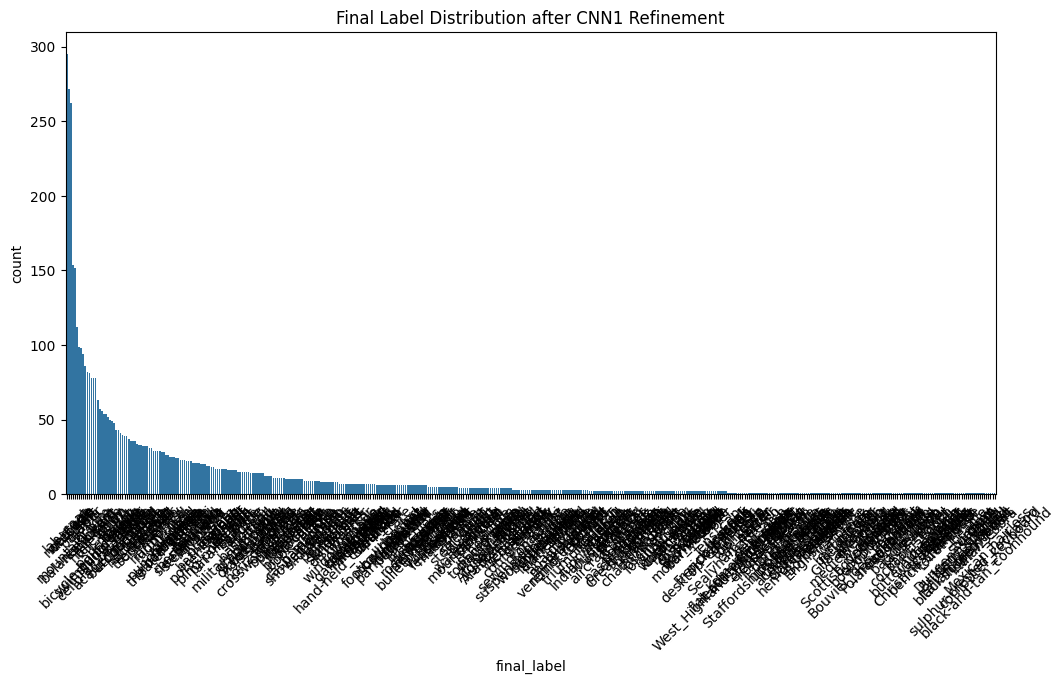

In [73]:
plt.figure(figsize=(12,6))
sns.barplot(data=label_counts, x='final_label', y='count')
plt.title('Final Label Distribution after CNN1 Refinement')
plt.xticks(rotation=45)
plt.show()

#Summary

**Process Overview**

1. Load Metadata:
From /processed/svm_final_img/svm_final_metadatav2.csv in GCS.
2. Map 'type' column:
Mapping each action label as either normal or abnormal.
3. Prepare test images for classification:
Load images from processed/svm_final_img/images/, resize to (224, 224), and preprocess for VGG19.
4. Predict labels using pretrained VGG19 ImageNet model. If prediction matches any of the 15 known labels → status: existing. Else → status: new
5. Assign 'final_label'
*   For train images: retain existing SVM label.
*   For test images: assign refined label from VGG19 or note as new.
6. Save final metadata to metadata/cnn1_final_metadata.csv in GCS.
7. Save trained CNN1 model to models/cnn1_vgg19_model.h5 in GCS. (recommend future switch to .keras)

---
**Execution Stats**

Test Images Processed: 5,400

Total Loop Time: 33 minutes 48 seconds

Average Speed: ~2.66 images/sec


The primary objective of this phase was to refine the labelling of still image frames extracted from home surveillance videos using a convolutional neural network (CNN). Specifically, a VGG19 model pretrained on ImageNet was employed to classify actions in test images, aiming to improve upon the earlier Support Vector Machine (SVM) results. The goal was to assign one of 15 predefined action labels or flag unrecognized actions as 'new.'

**Process Overview**

Data Preparation

18,000 images comprising 12,600 training images and 5,400 test images were used.

Metadata contained image filenames, SVM-predicted labels, source designation (train/test), and a type classification (normal/abnormal).

---
Model Deployment

VGG19 (ImageNet weights) was loaded with frozen layers.

A CNN classifier (CNN1) was constructed by appending Flatten, Dense, Dropout, and final Dense layers for 15 action categories.

Images were processed individually, with test images undergoing classification using the base VGG19 decode_predictions() function.

---
Labelling Approach

If VGG19’s top prediction matched the predefined 15 action labels, it was marked as 'existing.'

Otherwise, the prediction was noted as 'new.'

---
Key Findings:

The VGG19 model, while effective for object recognition, lacks suitability for action classification tasks due to its object-centric label space. The attempt to classify actions via ImageNet’s 1,000 classes resulted in fragmented, irrelevant labels with no semantic alignment to the intended action categories.

# Attempt 2 - Custom CNN on Train Dataset

Label

In [77]:
# Load metadata
metadata_blob = bucket.blob('processed/svm_final_img/svm_final_metadatav2.csv')
metadata_df = pd.read_csv(BytesIO(metadata_blob.download_as_bytes()))


In [78]:
# Separate train and test dataframes
train_df = metadata_df[metadata_df['source'] == 'train']
test_df = metadata_df[metadata_df['source'] == 'test']

In [79]:
# Label mapping
labels = sorted(train_df['label'].unique())
label_to_index = {label: idx for idx, label in enumerate(labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

Load Image

In [80]:
# Function to load image from GCS
def load_image_gcs(image_path, target_size=(224, 224)):
    blob = bucket.blob(image_path)
    img_bytes = blob.download_as_bytes()
    img = Image.open(BytesIO(img_bytes)).convert('RGB')
    img = img.resize(target_size)
    return np.array(img)

In [81]:
# Load train images and labels
X_train, y_train = [], []

for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    img_array = load_image_gcs(f"processed/svm_final_img/images/{row['new_filename']}")
    X_train.append(img_array)
    y_train.append(label_to_index[row['label']])

X_train = np.array(X_train, dtype='float32') / 255.0
y_train = to_categorical(y_train, num_classes=len(labels))

# Split into train-validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


100%|██████████| 12600/12600 [1:02:56<00:00,  3.34it/s]


Model

In [82]:
# Custom CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(labels), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 54, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,249,423 (84.87 MB)

 Trainable params: 22,248,975 (84.87 MB)

 Non-trainable params: 448 (1.75 KB)

In [83]:
# Train model
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val, y_val))


Epoch 1/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.1596 - loss: 4.3900 - val_accuracy: 0.0921 - val_loss: 3.2419
Epoch 2/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.3603 - loss: 2.0937 - val_accuracy: 0.2528 - val_loss: 2.6042
Epoch 3/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5408 - loss: 1.4367 - val_accuracy: 0.3230 - val_loss: 2.4726
Epoch 4/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6881 - loss: 0.9932 - val_accuracy: 0.3206 - val_loss: 2.5237
Epoch 5/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7802 - loss: 0.6931 - val_accuracy: 0.3385 - val_loss: 2.5822
Epoch 6/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8329 - loss: 0.4980 - val_accuracy: 0.3306 - val_loss: 2.8264
Epoch 7/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8786 - loss: 0.3808 - val_accuracy: 0.3532 - val_loss: 2.8356
Epoch 8/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9020 - loss: 0.2978 - val_acc

In [84]:
# Save trained model locally and upload to GCS
model.save('custom_cnn_15labels.h5')
model_blob = bucket.blob('models/custom_cnn_15labels.h5')
model_blob.upload_from_filename('custom_cnn_15labels.h5')
print("Custom CNN model uploaded to GCS.")

Custom CNN model uploaded to GCS.


# Train on Test dataset

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('custom_cnn_15labels.h5')

test_df.loc[:, 'cnn_pred_label'] = ''


In [87]:
def predict_label(img_array, model, index_to_label):
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    preds = model.predict(img_array)
    top_idx = np.argmax(preds)
    return index_to_label[top_idx]

In [88]:

for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    image_path = f"processed/svm_final_img/images/{row['new_filename']}"
    img_array = load_image_gcs(image_path)

    pred_label = predict_label(img_array, model, index_to_label)
    test_df.loc[idx, 'cnn_pred_label'] = pred_label

  0%|          | 0/5400 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step


  0%|          | 1/5400 [00:02<3:02:58,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 2/5400 [00:02<1:35:16,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 3/5400 [00:03<1:40:18,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 4/5400 [00:03<1:13:18,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 5/5400 [00:05<1:26:00,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 6/5400 [00:05<1:08:36,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 7/5400 [00:06<1:18:53,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 8/5400 [00:07<1:05:58,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 9/5400 [00:08<1:15:13,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 10/5400 [00:08<1:06:28,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 11/5400 [00:09<1:15:38,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  0%|          | 12/5400 [00:10<1:05:32,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 13/5400 [00:11<1:14:01,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 14/5400 [00:11<1:06:14,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 15/5400 [00:12<1:13:32,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 16/5400 [00:13<1:05:42,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 17/5400 [00:14<1:14:05,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  0%|          | 18/5400 [00:14<1:04:24,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 19/5400 [00:15<1:14:18,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 20/5400 [00:16<1:05:00,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 21/5400 [00:17<1:12:33,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 22/5400 [00:17<1:04:58,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 23/5400 [00:19<1:14:03,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 24/5400 [00:19<1:06:42,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 25/5400 [00:20<1:12:31,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 26/5400 [00:21<1:05:12,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 27/5400 [00:22<1:12:27,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  1%|          | 28/5400 [00:22<1:07:37,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|          | 29/5400 [00:23<1:11:40,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  1%|          | 30/5400 [00:24<1:07:24,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  1%|          | 31/5400 [00:25<1:10:59,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  1%|          | 32/5400 [00:25<1:06:55,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  1%|          | 33/5400 [00:26<1:10:24,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|          | 34/5400 [00:27<1:06:51,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|          | 35/5400 [00:28<1:12:56,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  1%|          | 36/5400 [00:28<1:06:37,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|          | 37/5400 [00:29<1:13:32,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|          | 38/5400 [00:30<1:06:10,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  1%|          | 39/5400 [00:31<1:11:47,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|          | 40/5400 [00:31<1:06:29,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|          | 41/5400 [00:32<1:12:36,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  1%|          | 42/5400 [00:33<1:05:38,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|          | 43/5400 [00:34<1:12:39,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|          | 44/5400 [00:35<1:05:20,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|          | 45/5400 [00:36<1:11:41,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|          | 46/5400 [00:36<1:05:57,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  1%|          | 47/5400 [00:37<1:11:21,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|          | 48/5400 [00:38<1:05:19,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  1%|          | 49/5400 [00:39<1:11:24,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  1%|          | 50/5400 [00:39<1:05:25,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|          | 51/5400 [00:40<1:12:09,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|          | 52/5400 [00:41<1:04:55,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  1%|          | 53/5400 [00:42<1:11:56,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  1%|          | 54/5400 [00:42<1:05:18,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|          | 55/5400 [00:43<1:11:45,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  1%|          | 56/5400 [00:44<1:04:24,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  1%|          | 57/5400 [00:45<1:13:02,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|          | 58/5400 [00:45<1:06:07,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|          | 59/5400 [00:46<1:12:04,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|          | 60/5400 [00:47<1:05:41,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  1%|          | 61/5400 [00:48<1:11:42,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  1%|          | 62/5400 [00:48<1:05:51,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|          | 63/5400 [00:49<1:11:39,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|          | 64/5400 [00:50<1:06:28,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|          | 65/5400 [00:51<1:10:50,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|          | 66/5400 [00:52<1:07:11,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  1%|          | 67/5400 [00:52<1:11:06,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|▏         | 68/5400 [00:53<1:07:18,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|▏         | 69/5400 [00:54<1:10:05,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|▏         | 70/5400 [00:55<1:06:59,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|▏         | 71/5400 [00:56<1:10:09,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  1%|▏         | 72/5400 [00:56<1:06:20,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|▏         | 73/5400 [00:57<1:09:28,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|▏         | 74/5400 [00:58<1:06:58,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  1%|▏         | 75/5400 [00:59<1:10:23,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|▏         | 76/5400 [00:59<1:07:33,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  1%|▏         | 77/5400 [01:00<1:10:01,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|▏         | 78/5400 [01:01<1:07:12,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|▏         | 79/5400 [01:02<1:11:50,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  1%|▏         | 80/5400 [01:02<1:00:54,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  2%|▏         | 81/5400 [01:03<1:12:47,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 82/5400 [01:04<1:02:31,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 83/5400 [01:05<1:12:31,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 84/5400 [01:05<1:02:51,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  2%|▏         | 85/5400 [01:06<1:14:23,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  2%|▏         | 86/5400 [01:07<1:04:37,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 87/5400 [01:08<1:14:45,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 88/5400 [01:08<1:04:35,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 89/5400 [01:10<1:13:56,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  2%|▏         | 90/5400 [01:10<1:04:40,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  2%|▏         | 91/5400 [01:11<1:13:32,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 92/5400 [01:12<1:05:43,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 93/5400 [01:13<1:13:26,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 94/5400 [01:13<1:05:25,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 95/5400 [01:14<1:12:16,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 96/5400 [01:15<1:04:52,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 97/5400 [01:16<1:12:29,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  2%|▏         | 98/5400 [01:16<1:04:15,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 99/5400 [01:17<1:13:25,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 100/5400 [01:18<1:00:49,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 101/5400 [01:18<52:24,  1.69it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 102/5400 [01:18<46:01,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 103/5400 [01:19<41:48,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 104/5400 [01:19<38:15,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  2%|▏         | 105/5400 [01:19<36:20,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 106/5400 [01:20<35:21,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  2%|▏         | 107/5400 [01:20<34:18,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  2%|▏         | 108/5400 [01:21<33:16,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 109/5400 [01:21<37:03,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 110/5400 [01:21<36:21,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  2%|▏         | 111/5400 [01:22<35:21,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 112/5400 [01:22<34:16,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  2%|▏         | 113/5400 [01:23<33:36,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  2%|▏         | 114/5400 [01:23<33:01,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 115/5400 [01:23<33:19,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 116/5400 [01:24<33:15,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  2%|▏         | 117/5400 [01:24<32:27,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 118/5400 [01:24<32:07,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  2%|▏         | 119/5400 [01:25<32:13,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  2%|▏         | 120/5400 [01:25<31:58,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  2%|▏         | 121/5400 [01:26<32:24,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  2%|▏         | 122/5400 [01:26<32:48,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 123/5400 [01:26<32:31,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 124/5400 [01:27<32:35,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 125/5400 [01:27<32:05,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  2%|▏         | 126/5400 [01:27<32:06,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  2%|▏         | 127/5400 [01:28<32:12,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  2%|▏         | 128/5400 [01:28<31:55,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 129/5400 [01:28<30:55,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  2%|▏         | 130/5400 [01:29<31:06,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 131/5400 [01:29<32:00,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  2%|▏         | 132/5400 [01:30<31:50,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 133/5400 [01:30<31:49,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 134/5400 [01:30<31:43,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▎         | 135/5400 [01:31<32:08,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  3%|▎         | 136/5400 [01:31<31:33,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  3%|▎         | 137/5400 [01:31<32:44,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  3%|▎         | 138/5400 [01:32<34:46,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  3%|▎         | 139/5400 [01:32<33:43,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  3%|▎         | 140/5400 [01:33<33:43,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  3%|▎         | 141/5400 [01:33<34:08,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  3%|▎         | 142/5400 [01:33<33:10,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  3%|▎         | 143/5400 [01:34<33:29,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  3%|▎         | 144/5400 [01:34<32:13,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  3%|▎         | 145/5400 [01:34<32:10,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  3%|▎         | 146/5400 [01:35<31:54,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  3%|▎         | 147/5400 [01:35<32:10,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  3%|▎         | 148/5400 [01:35<31:42,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 149/5400 [01:36<41:17,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 150/5400 [01:37<38:02,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 151/5400 [01:37<36:43,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 152/5400 [01:37<35:01,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 153/5400 [01:38<33:57,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 154/5400 [01:38<33:44,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 155/5400 [01:38<33:26,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  3%|▎         | 156/5400 [01:39<32:41,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 157/5400 [01:39<32:34,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 158/5400 [01:40<33:11,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 159/5400 [01:40<33:20,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 160/5400 [01:40<33:00,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 161/5400 [01:41<32:40,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  3%|▎         | 162/5400 [01:41<33:11,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 163/5400 [01:41<32:26,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 164/5400 [01:42<32:02,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 165/5400 [01:42<33:46,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 166/5400 [01:43<34:26,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 167/5400 [01:43<33:04,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 168/5400 [01:43<34:25,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  3%|▎         | 169/5400 [01:44<32:55,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 170/5400 [01:44<32:44,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 171/5400 [01:44<32:37,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 172/5400 [01:45<33:08,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  3%|▎         | 173/5400 [01:45<32:44,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 174/5400 [01:46<32:53,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 175/5400 [01:46<32:19,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 176/5400 [01:46<32:00,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 177/5400 [01:47<32:13,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 178/5400 [01:47<32:08,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  3%|▎         | 179/5400 [01:47<32:16,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  3%|▎         | 180/5400 [01:48<32:10,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 181/5400 [01:48<32:58,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  3%|▎         | 182/5400 [01:49<33:04,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 183/5400 [01:49<33:49,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 184/5400 [01:49<32:37,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 185/5400 [01:50<32:51,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 186/5400 [01:50<34:04,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 187/5400 [01:51<33:15,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  3%|▎         | 188/5400 [01:51<32:16,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▎         | 189/5400 [01:51<32:42,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▎         | 190/5400 [01:52<31:57,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▎         | 191/5400 [01:52<32:00,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▎         | 192/5400 [01:52<31:44,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▎         | 193/5400 [01:53<31:48,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▎         | 194/5400 [01:53<31:47,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▎         | 195/5400 [01:53<31:27,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▎         | 196/5400 [01:54<32:09,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  4%|▎         | 197/5400 [01:54<32:37,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▎         | 198/5400 [01:55<31:50,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▎         | 199/5400 [01:55<32:11,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▎         | 200/5400 [01:55<32:10,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▎         | 201/5400 [01:56<31:57,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▎         | 202/5400 [01:56<31:49,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 203/5400 [01:56<31:41,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  4%|▍         | 204/5400 [01:57<32:17,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 205/5400 [01:57<32:04,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 206/5400 [01:58<32:19,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 207/5400 [01:58<32:41,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▍         | 208/5400 [01:58<32:26,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  4%|▍         | 209/5400 [01:59<32:30,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▍         | 210/5400 [01:59<32:43,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 211/5400 [01:59<32:52,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  4%|▍         | 212/5400 [02:00<32:29,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 213/5400 [02:00<32:40,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 214/5400 [02:01<32:55,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 215/5400 [02:01<32:48,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 216/5400 [02:01<33:23,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 217/5400 [02:02<33:01,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 218/5400 [02:02<32:01,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 219/5400 [02:02<31:35,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  4%|▍         | 220/5400 [02:03<31:46,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 221/5400 [02:03<31:20,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▍         | 222/5400 [02:03<31:14,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▍         | 223/5400 [02:04<31:39,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 224/5400 [02:04<31:57,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 225/5400 [02:05<31:09,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 226/5400 [02:05<31:13,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▍         | 227/5400 [02:05<31:18,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 228/5400 [02:06<31:42,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 229/5400 [02:06<31:25,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 230/5400 [02:06<32:40,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 231/5400 [02:07<32:28,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 232/5400 [02:07<32:14,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 233/5400 [02:08<31:43,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 234/5400 [02:08<30:58,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▍         | 235/5400 [02:08<31:31,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  4%|▍         | 236/5400 [02:09<32:10,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▍         | 237/5400 [02:09<32:31,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▍         | 238/5400 [02:09<31:43,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 239/5400 [02:10<31:15,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 240/5400 [02:10<31:00,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  4%|▍         | 241/5400 [02:10<30:42,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 242/5400 [02:11<31:16,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  4%|▍         | 243/5400 [02:11<31:37,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  5%|▍         | 244/5400 [02:12<31:13,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▍         | 245/5400 [02:12<32:25,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▍         | 246/5400 [02:12<32:33,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▍         | 247/5400 [02:13<32:31,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▍         | 248/5400 [02:13<32:04,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▍         | 249/5400 [02:13<31:10,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▍         | 250/5400 [02:14<30:59,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▍         | 251/5400 [02:14<30:49,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  5%|▍         | 252/5400 [02:15<30:49,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▍         | 253/5400 [02:15<32:47,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▍         | 254/5400 [02:15<31:58,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▍         | 255/5400 [02:16<31:10,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▍         | 256/5400 [02:16<31:17,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▍         | 257/5400 [02:16<31:42,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▍         | 258/5400 [02:17<31:59,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▍         | 259/5400 [02:17<31:55,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  5%|▍         | 260/5400 [02:18<32:09,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▍         | 261/5400 [02:18<32:10,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  5%|▍         | 262/5400 [02:18<33:22,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▍         | 263/5400 [02:19<33:03,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▍         | 264/5400 [02:19<32:03,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  5%|▍         | 265/5400 [02:19<31:38,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▍         | 266/5400 [02:20<31:28,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▍         | 267/5400 [02:20<31:23,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▍         | 268/5400 [02:21<32:33,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▍         | 269/5400 [02:21<32:30,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▌         | 270/5400 [02:21<32:33,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▌         | 271/5400 [02:22<31:45,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▌         | 272/5400 [02:22<31:54,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  5%|▌         | 273/5400 [02:22<32:15,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  5%|▌         | 274/5400 [02:23<32:01,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▌         | 275/5400 [02:23<31:07,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▌         | 276/5400 [02:23<30:31,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▌         | 277/5400 [02:24<30:52,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▌         | 278/5400 [02:24<31:20,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▌         | 279/5400 [02:25<31:42,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▌         | 280/5400 [02:25<32:12,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▌         | 281/5400 [02:25<31:21,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▌         | 282/5400 [02:26<31:54,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▌         | 283/5400 [02:26<31:56,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▌         | 284/5400 [02:26<31:50,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▌         | 285/5400 [02:27<31:53,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▌         | 286/5400 [02:27<31:49,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▌         | 287/5400 [02:28<30:59,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▌         | 288/5400 [02:28<30:52,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▌         | 289/5400 [02:28<30:59,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▌         | 290/5400 [02:29<31:08,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  5%|▌         | 291/5400 [02:29<30:32,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▌         | 292/5400 [02:29<31:09,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▌         | 293/5400 [02:30<30:53,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▌         | 294/5400 [02:30<30:50,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▌         | 295/5400 [02:30<30:05,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▌         | 296/5400 [02:31<30:47,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▌         | 297/5400 [02:31<31:09,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▌         | 298/5400 [02:32<30:59,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▌         | 299/5400 [02:32<30:55,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▌         | 300/5400 [02:32<30:32,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▌         | 301/5400 [02:33<30:44,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 302/5400 [02:33<31:00,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▌         | 303/5400 [02:33<30:51,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  6%|▌         | 304/5400 [02:34<30:54,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▌         | 305/5400 [02:34<31:10,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▌         | 306/5400 [02:34<31:45,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▌         | 307/5400 [02:35<31:06,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 308/5400 [02:35<31:02,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  6%|▌         | 309/5400 [02:36<31:01,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  6%|▌         | 310/5400 [02:36<30:58,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 311/5400 [02:36<30:33,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▌         | 312/5400 [02:37<30:33,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 313/5400 [02:37<30:56,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 314/5400 [02:37<33:33,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▌         | 315/5400 [02:38<33:24,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  6%|▌         | 316/5400 [02:38<33:14,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  6%|▌         | 317/5400 [02:39<32:51,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▌         | 318/5400 [02:39<32:54,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▌         | 319/5400 [02:39<32:44,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▌         | 320/5400 [02:40<32:34,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▌         | 321/5400 [02:40<33:19,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  6%|▌         | 322/5400 [02:41<32:57,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 323/5400 [02:41<31:49,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 324/5400 [02:41<31:31,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 325/5400 [02:42<31:13,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▌         | 326/5400 [02:42<31:08,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▌         | 327/5400 [02:42<31:25,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 328/5400 [02:43<31:20,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 329/5400 [02:43<31:35,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  6%|▌         | 330/5400 [02:44<31:44,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▌         | 331/5400 [02:44<31:04,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 332/5400 [02:44<30:46,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  6%|▌         | 333/5400 [02:45<30:32,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▌         | 334/5400 [02:45<30:25,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▌         | 335/5400 [02:45<30:21,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 336/5400 [02:46<30:50,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▌         | 337/5400 [02:46<30:25,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▋         | 338/5400 [02:46<30:06,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▋         | 339/5400 [02:47<30:07,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▋         | 340/5400 [02:47<29:42,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▋         | 341/5400 [02:47<30:16,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▋         | 342/5400 [02:48<31:02,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▋         | 343/5400 [02:48<30:19,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▋         | 344/5400 [02:49<30:55,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▋         | 345/5400 [02:49<30:54,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▋         | 346/5400 [02:49<30:57,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▋         | 347/5400 [02:50<31:43,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▋         | 348/5400 [02:50<31:37,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▋         | 349/5400 [02:50<32:17,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▋         | 350/5400 [02:51<32:04,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  6%|▋         | 351/5400 [02:51<32:34,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  7%|▋         | 352/5400 [02:52<32:22,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 353/5400 [02:52<31:15,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  7%|▋         | 354/5400 [02:52<31:17,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 355/5400 [02:53<31:15,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 356/5400 [02:53<30:39,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 357/5400 [02:53<30:26,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 358/5400 [02:54<29:57,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 359/5400 [02:54<30:40,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 360/5400 [02:55<30:59,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 361/5400 [02:55<30:45,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 362/5400 [02:55<30:48,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  7%|▋         | 363/5400 [02:56<31:49,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  7%|▋         | 364/5400 [02:56<31:38,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 365/5400 [02:56<31:49,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 366/5400 [02:57<31:55,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 367/5400 [02:57<31:29,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  7%|▋         | 368/5400 [02:58<31:02,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 369/5400 [02:58<30:52,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 370/5400 [02:58<30:52,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  7%|▋         | 371/5400 [02:59<30:29,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 372/5400 [02:59<30:01,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  7%|▋         | 373/5400 [02:59<29:54,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  7%|▋         | 374/5400 [03:00<29:49,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  7%|▋         | 375/5400 [03:00<30:21,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  7%|▋         | 376/5400 [03:00<29:58,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 377/5400 [03:01<30:53,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  7%|▋         | 378/5400 [03:01<30:57,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  7%|▋         | 379/5400 [03:02<31:09,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 380/5400 [03:02<31:19,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 381/5400 [03:02<31:42,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 382/5400 [03:03<30:41,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  7%|▋         | 383/5400 [03:03<31:23,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 384/5400 [03:03<31:38,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  7%|▋         | 385/5400 [03:04<32:38,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  7%|▋         | 386/5400 [03:04<31:37,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 387/5400 [03:05<31:12,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  7%|▋         | 388/5400 [03:05<31:06,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 389/5400 [03:05<31:37,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 390/5400 [03:06<31:43,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 391/5400 [03:06<33:04,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 392/5400 [03:06<31:39,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  7%|▋         | 393/5400 [03:07<31:43,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  7%|▋         | 394/5400 [03:07<31:12,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 395/5400 [03:08<30:34,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  7%|▋         | 396/5400 [03:08<30:04,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 397/5400 [03:08<30:05,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  7%|▋         | 398/5400 [03:09<30:06,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  7%|▋         | 399/5400 [03:09<29:58,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  7%|▋         | 400/5400 [03:09<30:07,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 401/5400 [03:10<31:26,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 402/5400 [03:10<30:50,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 403/5400 [03:10<30:34,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  7%|▋         | 404/5400 [03:11<30:43,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  8%|▊         | 405/5400 [03:11<30:56,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|▊         | 406/5400 [03:12<30:52,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 407/5400 [03:12<30:55,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 408/5400 [03:12<30:36,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 409/5400 [03:13<30:37,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  8%|▊         | 410/5400 [03:13<30:09,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 411/5400 [03:13<29:50,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 412/5400 [03:14<29:33,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|▊         | 413/5400 [03:14<29:57,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  8%|▊         | 414/5400 [03:15<30:36,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  8%|▊         | 415/5400 [03:15<31:01,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|▊         | 416/5400 [03:15<30:08,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|▊         | 417/5400 [03:16<30:03,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  8%|▊         | 418/5400 [03:16<29:59,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  8%|▊         | 419/5400 [03:16<29:59,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 420/5400 [03:17<29:49,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 421/5400 [03:17<29:32,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 422/5400 [03:17<29:44,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  8%|▊         | 423/5400 [03:18<29:19,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  8%|▊         | 424/5400 [03:18<29:02,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|▊         | 425/5400 [03:18<29:32,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  8%|▊         | 426/5400 [03:19<30:45,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  8%|▊         | 427/5400 [03:19<30:28,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|▊         | 428/5400 [03:20<30:19,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  8%|▊         | 429/5400 [03:20<31:30,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|▊         | 430/5400 [03:20<31:32,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  8%|▊         | 431/5400 [03:21<31:32,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  8%|▊         | 432/5400 [03:21<30:56,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 433/5400 [03:21<30:06,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 434/5400 [03:22<31:10,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  8%|▊         | 435/5400 [03:22<31:22,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  8%|▊         | 436/5400 [03:23<31:29,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|▊         | 437/5400 [03:23<30:58,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  8%|▊         | 438/5400 [03:23<31:00,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  8%|▊         | 439/5400 [03:24<31:07,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|▊         | 440/5400 [03:24<31:18,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  8%|▊         | 441/5400 [03:24<30:35,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 442/5400 [03:25<29:45,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 443/5400 [03:25<30:11,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  8%|▊         | 444/5400 [03:26<30:21,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  8%|▊         | 445/5400 [03:26<30:11,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|▊         | 446/5400 [03:26<29:45,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  8%|▊         | 447/5400 [03:27<29:36,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  8%|▊         | 448/5400 [03:27<30:13,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|▊         | 449/5400 [03:27<30:49,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  8%|▊         | 450/5400 [03:28<30:37,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  8%|▊         | 451/5400 [03:28<30:37,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  8%|▊         | 452/5400 [03:29<30:31,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  8%|▊         | 453/5400 [03:29<30:00,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  8%|▊         | 454/5400 [03:29<30:19,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|▊         | 455/5400 [03:30<29:22,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|▊         | 456/5400 [03:30<30:02,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  8%|▊         | 457/5400 [03:30<29:48,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  8%|▊         | 458/5400 [03:31<30:25,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  8%|▊         | 459/5400 [03:31<30:59,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  9%|▊         | 460/5400 [03:31<30:20,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▊         | 461/5400 [03:32<30:32,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▊         | 462/5400 [03:32<30:03,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▊         | 463/5400 [03:33<31:46,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  9%|▊         | 464/5400 [03:33<30:37,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▊         | 465/5400 [03:33<30:47,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▊         | 466/5400 [03:34<31:02,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  9%|▊         | 467/5400 [03:34<30:26,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▊         | 468/5400 [03:34<31:03,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  9%|▊         | 469/5400 [03:35<30:58,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  9%|▊         | 470/5400 [03:35<30:50,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  9%|▊         | 471/5400 [03:36<30:28,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  9%|▊         | 472/5400 [03:36<30:18,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 473/5400 [03:36<30:54,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▉         | 474/5400 [03:37<30:25,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 475/5400 [03:37<31:05,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▉         | 476/5400 [03:37<31:19,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 477/5400 [03:38<30:44,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  9%|▉         | 478/5400 [03:38<30:28,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  9%|▉         | 479/5400 [03:39<30:23,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  9%|▉         | 480/5400 [03:39<30:05,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  9%|▉         | 481/5400 [03:39<30:48,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  9%|▉         | 482/5400 [03:40<30:11,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  9%|▉         | 483/5400 [03:40<29:28,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  9%|▉         | 484/5400 [03:40<28:57,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  9%|▉         | 485/5400 [03:41<28:48,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▉         | 486/5400 [03:41<28:24,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  9%|▉         | 487/5400 [03:41<28:39,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 488/5400 [03:42<28:56,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  9%|▉         | 489/5400 [03:42<30:08,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▉         | 490/5400 [03:43<30:50,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▉         | 491/5400 [03:43<30:15,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  9%|▉         | 492/5400 [03:43<30:30,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  9%|▉         | 493/5400 [03:44<30:04,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  9%|▉         | 494/5400 [03:44<29:52,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  9%|▉         | 495/5400 [03:44<30:14,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  9%|▉         | 496/5400 [03:45<30:04,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 497/5400 [03:45<31:49,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  9%|▉         | 498/5400 [03:46<31:20,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 499/5400 [03:46<30:42,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 500/5400 [03:46<30:33,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▉         | 501/5400 [03:47<30:50,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 502/5400 [03:47<30:38,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 503/5400 [03:47<30:51,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 504/5400 [03:48<31:00,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  9%|▉         | 505/5400 [03:48<30:34,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  9%|▉         | 506/5400 [03:49<30:10,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  9%|▉         | 507/5400 [03:49<29:46,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  9%|▉         | 508/5400 [03:49<29:59,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 509/5400 [03:50<29:59,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▉         | 510/5400 [03:50<30:10,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▉         | 511/5400 [03:50<30:43,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  9%|▉         | 512/5400 [03:51<31:15,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 10%|▉         | 513/5400 [03:51<31:42,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 10%|▉         | 514/5400 [03:52<31:25,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 10%|▉         | 515/5400 [03:52<30:15,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|▉         | 516/5400 [03:52<29:39,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|▉         | 517/5400 [03:53<29:53,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 10%|▉         | 518/5400 [03:53<30:09,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|▉         | 519/5400 [03:53<32:13,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|▉         | 520/5400 [03:54<30:55,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 10%|▉         | 521/5400 [03:54<30:23,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 10%|▉         | 522/5400 [03:55<29:43,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 10%|▉         | 523/5400 [03:55<29:38,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 10%|▉         | 524/5400 [03:55<29:50,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 10%|▉         | 525/5400 [03:56<30:21,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 10%|▉         | 526/5400 [03:56<30:16,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 10%|▉         | 527/5400 [03:56<31:24,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 10%|▉         | 528/5400 [03:57<31:30,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 10%|▉         | 529/5400 [03:57<30:32,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 10%|▉         | 530/5400 [03:57<29:38,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 10%|▉         | 531/5400 [03:58<30:02,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 10%|▉         | 532/5400 [03:58<29:12,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 10%|▉         | 533/5400 [03:59<29:19,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 10%|▉         | 534/5400 [03:59<29:28,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 10%|▉         | 535/5400 [03:59<29:07,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 10%|▉         | 536/5400 [04:00<29:26,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|▉         | 537/5400 [04:00<29:16,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|▉         | 538/5400 [04:00<29:17,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|▉         | 539/5400 [04:01<29:09,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 10%|█         | 540/5400 [04:01<29:04,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 10%|█         | 541/5400 [04:01<29:39,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 10%|█         | 542/5400 [04:02<29:32,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 10%|█         | 543/5400 [04:02<29:41,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|█         | 544/5400 [04:03<29:46,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 10%|█         | 545/5400 [04:03<29:52,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|█         | 546/5400 [04:03<30:08,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 10%|█         | 547/5400 [04:04<30:47,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 10%|█         | 548/5400 [04:04<29:39,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|█         | 549/5400 [04:04<30:24,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|█         | 550/5400 [04:05<29:40,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|█         | 551/5400 [04:05<29:49,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 10%|█         | 552/5400 [04:06<29:57,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 10%|█         | 553/5400 [04:06<29:41,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 10%|█         | 554/5400 [04:06<29:45,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 10%|█         | 555/5400 [04:07<30:09,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 10%|█         | 556/5400 [04:07<29:46,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 10%|█         | 557/5400 [04:07<29:59,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|█         | 558/5400 [04:08<29:55,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 10%|█         | 559/5400 [04:08<30:06,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 10%|█         | 560/5400 [04:09<31:06,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 10%|█         | 561/5400 [04:09<30:07,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 10%|█         | 562/5400 [04:09<30:03,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 10%|█         | 563/5400 [04:10<30:41,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 10%|█         | 564/5400 [04:10<30:05,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 10%|█         | 565/5400 [04:10<30:53,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 10%|█         | 566/5400 [04:11<29:53,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 10%|█         | 567/5400 [04:11<29:12,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 11%|█         | 568/5400 [04:11<29:01,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█         | 569/5400 [04:12<29:27,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█         | 570/5400 [04:12<29:32,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█         | 571/5400 [04:13<29:13,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█         | 572/5400 [04:13<28:55,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█         | 573/5400 [04:13<28:45,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█         | 574/5400 [04:14<28:35,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 11%|█         | 575/5400 [04:14<28:37,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 11%|█         | 576/5400 [04:14<28:57,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█         | 577/5400 [04:15<29:28,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 11%|█         | 578/5400 [04:15<29:36,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 11%|█         | 579/5400 [04:16<30:03,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█         | 580/5400 [04:16<29:50,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 11%|█         | 581/5400 [04:16<29:21,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 11%|█         | 582/5400 [04:17<30:42,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█         | 583/5400 [04:17<30:06,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█         | 584/5400 [04:17<29:38,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█         | 585/5400 [04:18<29:52,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█         | 586/5400 [04:18<29:02,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█         | 587/5400 [04:18<28:51,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 11%|█         | 588/5400 [04:19<28:22,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 11%|█         | 589/5400 [04:19<28:24,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█         | 590/5400 [04:19<28:23,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 11%|█         | 591/5400 [04:20<28:38,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 11%|█         | 592/5400 [04:20<29:13,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█         | 593/5400 [04:21<28:31,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█         | 594/5400 [04:21<28:25,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█         | 595/5400 [04:21<28:47,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█         | 596/5400 [04:22<29:42,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█         | 597/5400 [04:22<29:11,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 11%|█         | 598/5400 [04:22<29:39,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█         | 599/5400 [04:23<28:52,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 11%|█         | 600/5400 [04:23<28:09,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█         | 601/5400 [04:23<27:44,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 11%|█         | 602/5400 [04:24<28:16,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 11%|█         | 603/5400 [04:24<28:05,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 11%|█         | 604/5400 [04:24<27:41,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█         | 605/5400 [04:25<27:57,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█         | 606/5400 [04:25<28:16,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 11%|█         | 607/5400 [04:26<28:25,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█▏        | 608/5400 [04:26<28:49,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 11%|█▏        | 609/5400 [04:26<28:44,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█▏        | 610/5400 [04:27<28:44,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 11%|█▏        | 611/5400 [04:27<29:32,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 11%|█▏        | 612/5400 [04:27<29:31,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 11%|█▏        | 613/5400 [04:28<29:33,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 11%|█▏        | 614/5400 [04:28<29:06,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 11%|█▏        | 615/5400 [04:29<29:03,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 11%|█▏        | 616/5400 [04:29<29:20,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 11%|█▏        | 617/5400 [04:29<29:30,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█▏        | 618/5400 [04:30<29:58,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█▏        | 619/5400 [04:30<29:24,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█▏        | 620/5400 [04:30<28:57,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 621/5400 [04:31<28:34,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 622/5400 [04:31<28:46,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 623/5400 [04:31<28:10,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 624/5400 [04:32<29:51,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 12%|█▏        | 625/5400 [04:32<29:35,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 626/5400 [04:33<29:20,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 12%|█▏        | 627/5400 [04:33<29:01,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 12%|█▏        | 628/5400 [04:33<28:35,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 629/5400 [04:34<28:55,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 630/5400 [04:34<29:07,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 631/5400 [04:34<30:21,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 632/5400 [04:35<29:43,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 633/5400 [04:35<29:55,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 634/5400 [04:36<29:26,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 635/5400 [04:36<29:09,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 636/5400 [04:36<28:47,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 12%|█▏        | 637/5400 [04:37<28:00,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 12%|█▏        | 638/5400 [04:37<28:05,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 12%|█▏        | 639/5400 [04:37<27:49,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 640/5400 [04:38<28:05,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 641/5400 [04:38<27:55,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 642/5400 [04:38<27:54,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 643/5400 [04:39<28:45,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 644/5400 [04:39<28:25,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 645/5400 [04:39<28:56,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 646/5400 [04:40<29:38,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 647/5400 [04:40<29:06,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 12%|█▏        | 648/5400 [04:41<28:41,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 12%|█▏        | 649/5400 [04:41<29:20,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 12%|█▏        | 650/5400 [04:41<30:38,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 12%|█▏        | 651/5400 [04:42<29:47,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 12%|█▏        | 652/5400 [04:42<28:49,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 12%|█▏        | 653/5400 [04:42<28:27,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 654/5400 [04:43<28:28,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 655/5400 [04:43<28:37,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 656/5400 [04:43<29:05,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 657/5400 [04:44<28:54,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 658/5400 [04:44<28:43,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 12%|█▏        | 659/5400 [04:45<29:59,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 660/5400 [04:45<29:43,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 12%|█▏        | 661/5400 [04:45<28:59,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 12%|█▏        | 662/5400 [04:46<28:48,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 663/5400 [04:46<28:45,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 664/5400 [04:46<28:46,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 12%|█▏        | 665/5400 [04:47<28:20,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 666/5400 [04:47<27:59,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 12%|█▏        | 667/5400 [04:47<27:37,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 668/5400 [04:48<27:39,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 669/5400 [04:48<28:30,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 12%|█▏        | 670/5400 [04:49<28:42,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 671/5400 [04:49<29:05,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 672/5400 [04:49<28:45,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 673/5400 [04:50<28:37,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 12%|█▏        | 674/5400 [04:50<28:42,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▎        | 675/5400 [04:50<29:42,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 13%|█▎        | 676/5400 [04:51<29:11,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 677/5400 [04:51<29:58,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 678/5400 [04:52<29:55,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 679/5400 [04:52<30:01,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 680/5400 [04:52<29:27,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 681/5400 [04:53<28:34,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 682/5400 [04:53<28:15,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 13%|█▎        | 683/5400 [04:53<28:29,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 13%|█▎        | 684/5400 [04:54<28:01,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 13%|█▎        | 685/5400 [04:54<28:54,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 686/5400 [04:54<28:25,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 13%|█▎        | 687/5400 [04:55<28:35,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 13%|█▎        | 688/5400 [04:55<28:25,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 13%|█▎        | 689/5400 [04:56<29:07,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 13%|█▎        | 690/5400 [04:56<29:10,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 691/5400 [04:56<28:53,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 692/5400 [04:57<28:03,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 693/5400 [04:57<28:52,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 13%|█▎        | 694/5400 [04:57<28:56,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 695/5400 [04:58<28:47,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 13%|█▎        | 696/5400 [04:58<28:23,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 13%|█▎        | 697/5400 [04:59<29:13,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 13%|█▎        | 698/5400 [04:59<28:38,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 699/5400 [04:59<28:21,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 13%|█▎        | 700/5400 [05:00<28:37,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 13%|█▎        | 701/5400 [05:00<28:02,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 702/5400 [05:00<28:01,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 13%|█▎        | 703/5400 [05:01<27:57,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 704/5400 [05:01<28:15,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 705/5400 [05:01<28:11,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 706/5400 [05:02<28:34,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 707/5400 [05:02<28:19,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 13%|█▎        | 708/5400 [05:02<28:31,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 13%|█▎        | 709/5400 [05:03<27:58,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 710/5400 [05:03<28:30,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 13%|█▎        | 711/5400 [05:04<28:49,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 13%|█▎        | 712/5400 [05:04<28:36,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 713/5400 [05:04<28:42,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 714/5400 [05:05<29:03,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 13%|█▎        | 715/5400 [05:05<28:12,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 716/5400 [05:05<27:41,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 717/5400 [05:06<27:35,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 718/5400 [05:06<27:35,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 13%|█▎        | 719/5400 [05:06<27:28,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 13%|█▎        | 720/5400 [05:07<27:11,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 13%|█▎        | 721/5400 [05:07<27:08,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 13%|█▎        | 722/5400 [05:07<27:12,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 13%|█▎        | 723/5400 [05:08<29:02,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 13%|█▎        | 724/5400 [05:08<28:56,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 725/5400 [05:09<29:02,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 13%|█▎        | 726/5400 [05:09<29:10,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 13%|█▎        | 727/5400 [05:09<28:47,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 728/5400 [05:10<28:25,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 14%|█▎        | 729/5400 [05:10<28:32,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▎        | 730/5400 [05:10<28:16,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▎        | 731/5400 [05:11<28:25,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▎        | 732/5400 [05:11<28:55,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 14%|█▎        | 733/5400 [05:12<28:58,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▎        | 734/5400 [05:12<28:31,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 14%|█▎        | 735/5400 [05:12<28:55,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 14%|█▎        | 736/5400 [05:13<28:18,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▎        | 737/5400 [05:13<28:26,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▎        | 738/5400 [05:13<28:54,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▎        | 739/5400 [05:14<28:47,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 14%|█▎        | 740/5400 [05:14<27:54,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 14%|█▎        | 741/5400 [05:14<27:45,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▎        | 742/5400 [05:15<28:10,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▍        | 743/5400 [05:15<28:22,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▍        | 744/5400 [05:16<28:06,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 14%|█▍        | 745/5400 [05:16<27:44,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 14%|█▍        | 746/5400 [05:16<28:41,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 14%|█▍        | 747/5400 [05:17<28:13,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 14%|█▍        | 748/5400 [05:17<28:54,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▍        | 749/5400 [05:17<28:02,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▍        | 750/5400 [05:18<28:56,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▍        | 751/5400 [05:18<28:50,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▍        | 752/5400 [05:19<28:59,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▍        | 753/5400 [05:19<29:14,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▍        | 754/5400 [05:19<28:41,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▍        | 755/5400 [05:20<28:23,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▍        | 756/5400 [05:20<27:56,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 14%|█▍        | 757/5400 [05:20<27:45,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▍        | 758/5400 [05:21<27:55,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 14%|█▍        | 759/5400 [05:21<27:55,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 14%|█▍        | 760/5400 [05:21<27:21,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 14%|█▍        | 761/5400 [05:22<27:49,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▍        | 762/5400 [05:22<28:22,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▍        | 763/5400 [05:23<29:22,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▍        | 764/5400 [05:23<29:30,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▍        | 765/5400 [05:23<28:49,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▍        | 766/5400 [05:24<28:12,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 14%|█▍        | 767/5400 [05:24<27:31,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 14%|█▍        | 768/5400 [05:24<27:28,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 14%|█▍        | 769/5400 [05:25<27:53,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 14%|█▍        | 770/5400 [05:25<27:46,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▍        | 771/5400 [05:25<27:24,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 14%|█▍        | 772/5400 [05:26<27:08,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▍        | 773/5400 [05:26<27:11,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 14%|█▍        | 774/5400 [05:27<27:50,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 14%|█▍        | 775/5400 [05:27<27:54,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▍        | 776/5400 [05:27<27:28,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▍        | 777/5400 [05:28<28:16,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 14%|█▍        | 778/5400 [05:28<27:54,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▍        | 779/5400 [05:28<27:50,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 14%|█▍        | 780/5400 [05:29<27:28,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 14%|█▍        | 781/5400 [05:29<27:12,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 14%|█▍        | 782/5400 [05:29<27:48,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 14%|█▍        | 783/5400 [05:30<27:54,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 15%|█▍        | 784/5400 [05:30<27:13,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 15%|█▍        | 785/5400 [05:30<27:21,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▍        | 786/5400 [05:31<28:06,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▍        | 787/5400 [05:31<28:04,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 15%|█▍        | 788/5400 [05:32<28:09,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▍        | 789/5400 [05:32<27:21,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▍        | 790/5400 [05:32<27:42,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▍        | 791/5400 [05:33<27:56,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 15%|█▍        | 792/5400 [05:33<27:48,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 15%|█▍        | 793/5400 [05:33<27:58,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 15%|█▍        | 794/5400 [05:34<28:00,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 15%|█▍        | 795/5400 [05:34<27:52,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|█▍        | 796/5400 [05:34<27:37,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 15%|█▍        | 797/5400 [05:35<28:16,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 15%|█▍        | 798/5400 [05:35<28:09,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|█▍        | 799/5400 [05:36<28:27,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|█▍        | 800/5400 [05:36<28:51,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 15%|█▍        | 801/5400 [05:36<28:35,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▍        | 802/5400 [05:37<28:45,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 15%|█▍        | 803/5400 [05:37<28:43,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▍        | 804/5400 [05:37<29:07,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▍        | 805/5400 [05:38<28:25,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 15%|█▍        | 806/5400 [05:38<28:17,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 15%|█▍        | 807/5400 [05:39<28:11,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▍        | 808/5400 [05:39<27:22,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▍        | 809/5400 [05:39<27:29,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▌        | 810/5400 [05:40<26:52,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▌        | 811/5400 [05:40<27:26,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|█▌        | 812/5400 [05:40<29:14,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▌        | 813/5400 [05:41<28:28,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▌        | 814/5400 [05:41<27:48,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▌        | 815/5400 [05:41<28:01,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 15%|█▌        | 816/5400 [05:42<27:23,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▌        | 817/5400 [05:42<28:27,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 15%|█▌        | 818/5400 [05:43<28:08,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 15%|█▌        | 819/5400 [05:43<27:39,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 15%|█▌        | 820/5400 [05:43<27:41,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▌        | 821/5400 [05:44<27:45,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▌        | 822/5400 [05:44<27:46,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▌        | 823/5400 [05:44<27:54,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|█▌        | 824/5400 [05:45<29:04,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▌        | 825/5400 [05:45<28:36,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▌        | 826/5400 [05:46<28:12,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 15%|█▌        | 827/5400 [05:46<28:00,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|█▌        | 828/5400 [05:46<27:57,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▌        | 829/5400 [05:47<27:16,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▌        | 830/5400 [05:47<27:43,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 15%|█▌        | 831/5400 [05:47<27:41,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 15%|█▌        | 832/5400 [05:48<27:16,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▌        | 833/5400 [05:48<27:44,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|█▌        | 834/5400 [05:48<27:43,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 15%|█▌        | 835/5400 [05:49<29:57,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▌        | 836/5400 [05:49<30:08,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▌        | 837/5400 [05:50<30:32,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▌        | 838/5400 [05:50<29:39,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▌        | 839/5400 [05:50<29:07,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 16%|█▌        | 840/5400 [05:51<28:33,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 16%|█▌        | 841/5400 [05:51<28:10,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▌        | 842/5400 [05:52<27:41,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 16%|█▌        | 843/5400 [05:52<27:39,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 16%|█▌        | 844/5400 [05:52<27:57,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 16%|█▌        | 845/5400 [05:53<27:43,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▌        | 846/5400 [05:53<27:41,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▌        | 847/5400 [05:53<29:00,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▌        | 848/5400 [05:54<28:08,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▌        | 849/5400 [05:54<27:40,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▌        | 850/5400 [05:54<28:02,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▌        | 851/5400 [05:55<27:24,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 16%|█▌        | 852/5400 [05:55<28:07,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 16%|█▌        | 853/5400 [05:56<28:02,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▌        | 854/5400 [05:56<28:37,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 16%|█▌        | 855/5400 [05:56<28:13,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 16%|█▌        | 856/5400 [05:57<27:33,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▌        | 857/5400 [05:57<27:11,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 16%|█▌        | 858/5400 [05:57<27:26,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 16%|█▌        | 859/5400 [05:58<27:12,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▌        | 860/5400 [05:58<26:56,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 16%|█▌        | 861/5400 [05:58<27:17,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▌        | 862/5400 [05:59<27:21,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▌        | 863/5400 [05:59<27:11,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▌        | 864/5400 [06:00<27:13,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▌        | 865/5400 [06:00<26:46,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 16%|█▌        | 866/5400 [06:00<27:05,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 16%|█▌        | 867/5400 [06:01<27:26,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 16%|█▌        | 868/5400 [06:01<26:59,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 16%|█▌        | 869/5400 [06:01<27:07,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 16%|█▌        | 870/5400 [06:02<27:16,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 16%|█▌        | 871/5400 [06:02<27:15,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▌        | 872/5400 [06:02<26:53,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 16%|█▌        | 873/5400 [06:03<28:41,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▌        | 874/5400 [06:03<27:53,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 16%|█▌        | 875/5400 [06:04<28:26,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 16%|█▌        | 876/5400 [06:04<29:44,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 16%|█▌        | 877/5400 [06:04<29:00,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▋        | 878/5400 [06:05<29:10,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▋        | 879/5400 [06:05<29:30,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▋        | 880/5400 [06:06<29:08,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▋        | 881/5400 [06:06<28:25,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 16%|█▋        | 882/5400 [06:06<27:36,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 16%|█▋        | 883/5400 [06:07<27:39,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▋        | 884/5400 [06:07<27:40,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 16%|█▋        | 885/5400 [06:07<27:51,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 16%|█▋        | 886/5400 [06:08<27:15,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▋        | 887/5400 [06:08<26:28,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 16%|█▋        | 888/5400 [06:08<27:10,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▋        | 889/5400 [06:09<27:10,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 16%|█▋        | 890/5400 [06:09<27:07,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 16%|█▋        | 891/5400 [06:09<26:45,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 17%|█▋        | 892/5400 [06:10<27:16,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 17%|█▋        | 893/5400 [06:10<26:47,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 17%|█▋        | 894/5400 [06:11<27:11,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 17%|█▋        | 895/5400 [06:11<27:28,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 17%|█▋        | 896/5400 [06:11<27:06,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 897/5400 [06:12<26:56,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 17%|█▋        | 898/5400 [06:12<27:38,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 899/5400 [06:12<27:24,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 900/5400 [06:13<27:33,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 17%|█▋        | 901/5400 [06:13<27:43,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 17%|█▋        | 902/5400 [06:14<28:06,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 17%|█▋        | 903/5400 [06:14<27:45,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 17%|█▋        | 904/5400 [06:14<27:27,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 17%|█▋        | 905/5400 [06:15<26:57,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 17%|█▋        | 906/5400 [06:15<26:36,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 17%|█▋        | 907/5400 [06:15<26:31,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 17%|█▋        | 908/5400 [06:16<27:48,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 17%|█▋        | 909/5400 [06:16<27:22,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 17%|█▋        | 910/5400 [06:16<28:09,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 17%|█▋        | 911/5400 [06:17<28:16,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 912/5400 [06:17<28:27,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 17%|█▋        | 913/5400 [06:18<27:50,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 17%|█▋        | 914/5400 [06:18<27:29,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 17%|█▋        | 915/5400 [06:18<28:22,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 916/5400 [06:19<27:55,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 17%|█▋        | 917/5400 [06:19<27:49,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 17%|█▋        | 918/5400 [06:19<27:58,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 17%|█▋        | 919/5400 [06:20<27:10,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 17%|█▋        | 920/5400 [06:20<26:42,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 17%|█▋        | 921/5400 [06:21<27:05,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 17%|█▋        | 922/5400 [06:21<26:43,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 923/5400 [06:21<27:28,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 17%|█▋        | 924/5400 [06:22<27:09,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 17%|█▋        | 925/5400 [06:22<26:41,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 17%|█▋        | 926/5400 [06:22<27:26,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 17%|█▋        | 927/5400 [06:23<27:43,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 17%|█▋        | 928/5400 [06:23<27:14,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 17%|█▋        | 929/5400 [06:23<27:18,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 17%|█▋        | 930/5400 [06:24<26:44,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 17%|█▋        | 931/5400 [06:24<26:58,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 17%|█▋        | 932/5400 [06:24<26:27,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 17%|█▋        | 933/5400 [06:25<28:15,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 17%|█▋        | 934/5400 [06:25<27:55,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 17%|█▋        | 935/5400 [06:26<27:48,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 17%|█▋        | 936/5400 [06:26<28:05,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 17%|█▋        | 937/5400 [06:26<27:33,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 17%|█▋        | 938/5400 [06:27<27:18,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 17%|█▋        | 939/5400 [06:27<27:38,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 17%|█▋        | 940/5400 [06:27<27:04,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 941/5400 [06:28<26:28,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 17%|█▋        | 942/5400 [06:28<26:31,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 17%|█▋        | 943/5400 [06:29<26:18,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 944/5400 [06:29<26:08,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 945/5400 [06:29<26:11,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 946/5400 [06:30<26:24,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 18%|█▊        | 947/5400 [06:30<26:30,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 18%|█▊        | 948/5400 [06:30<26:52,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 18%|█▊        | 949/5400 [06:31<27:08,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 18%|█▊        | 950/5400 [06:31<27:29,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 18%|█▊        | 951/5400 [06:31<27:12,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 18%|█▊        | 952/5400 [06:32<27:04,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 18%|█▊        | 953/5400 [06:32<27:57,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 954/5400 [06:33<27:53,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 955/5400 [06:33<29:05,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 956/5400 [06:33<28:01,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 957/5400 [06:34<27:16,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 18%|█▊        | 958/5400 [06:34<26:42,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 18%|█▊        | 959/5400 [06:34<26:33,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 18%|█▊        | 960/5400 [06:35<26:34,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 18%|█▊        | 961/5400 [06:35<26:17,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 18%|█▊        | 962/5400 [06:35<26:28,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 18%|█▊        | 963/5400 [06:36<26:38,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 18%|█▊        | 964/5400 [06:36<26:19,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 965/5400 [06:37<27:51,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 18%|█▊        | 966/5400 [06:37<27:20,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 967/5400 [06:37<28:00,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 18%|█▊        | 968/5400 [06:38<27:04,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 18%|█▊        | 969/5400 [06:38<26:26,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 18%|█▊        | 970/5400 [06:38<26:25,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 971/5400 [06:39<25:52,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 18%|█▊        | 972/5400 [06:39<26:03,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 18%|█▊        | 973/5400 [06:39<27:06,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 18%|█▊        | 974/5400 [06:40<27:08,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 18%|█▊        | 975/5400 [06:40<26:44,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 976/5400 [06:41<26:54,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 977/5400 [06:41<26:57,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 18%|█▊        | 978/5400 [06:41<26:44,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 979/5400 [06:42<27:42,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 980/5400 [06:42<27:58,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 981/5400 [06:42<27:18,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 18%|█▊        | 982/5400 [06:43<27:20,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 18%|█▊        | 983/5400 [06:43<27:14,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 18%|█▊        | 984/5400 [06:44<27:59,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 18%|█▊        | 985/5400 [06:44<27:27,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 18%|█▊        | 986/5400 [06:44<26:58,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 18%|█▊        | 987/5400 [06:45<26:57,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 18%|█▊        | 988/5400 [06:45<27:31,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 989/5400 [06:45<27:37,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 990/5400 [06:46<27:08,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 991/5400 [06:46<26:54,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 992/5400 [06:47<27:01,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 18%|█▊        | 993/5400 [06:47<27:32,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 994/5400 [06:47<27:03,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 18%|█▊        | 995/5400 [06:48<26:48,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 18%|█▊        | 996/5400 [06:48<26:34,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 18%|█▊        | 997/5400 [06:48<26:06,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 18%|█▊        | 998/5400 [06:49<26:21,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 18%|█▊        | 999/5400 [06:49<25:57,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 19%|█▊        | 1000/5400 [06:49<26:21,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 19%|█▊        | 1001/5400 [06:50<26:32,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▊        | 1002/5400 [06:50<26:50,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▊        | 1003/5400 [06:51<26:34,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 19%|█▊        | 1004/5400 [06:51<26:41,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 19%|█▊        | 1005/5400 [06:51<26:19,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 19%|█▊        | 1006/5400 [06:52<25:46,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 19%|█▊        | 1007/5400 [06:52<25:56,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 19%|█▊        | 1008/5400 [06:52<26:17,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 19%|█▊        | 1009/5400 [06:53<27:15,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▊        | 1010/5400 [06:53<26:56,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 19%|█▊        | 1011/5400 [06:53<27:13,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 19%|█▊        | 1012/5400 [06:54<26:53,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▉        | 1013/5400 [06:54<26:58,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 19%|█▉        | 1014/5400 [06:55<27:01,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 19%|█▉        | 1015/5400 [06:55<26:36,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▉        | 1016/5400 [06:55<26:34,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▉        | 1017/5400 [06:56<26:44,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 19%|█▉        | 1018/5400 [06:56<26:27,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 19%|█▉        | 1019/5400 [06:56<26:23,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 19%|█▉        | 1020/5400 [06:57<26:27,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 19%|█▉        | 1021/5400 [06:57<26:15,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 19%|█▉        | 1022/5400 [06:57<27:01,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 19%|█▉        | 1023/5400 [06:58<26:35,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 19%|█▉        | 1024/5400 [06:58<27:32,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▉        | 1025/5400 [06:59<26:54,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▉        | 1026/5400 [06:59<27:15,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▉        | 1027/5400 [06:59<27:14,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▉        | 1028/5400 [07:00<28:24,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 19%|█▉        | 1029/5400 [07:00<27:44,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▉        | 1030/5400 [07:00<28:00,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 19%|█▉        | 1031/5400 [07:01<27:08,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 19%|█▉        | 1032/5400 [07:01<26:42,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 19%|█▉        | 1033/5400 [07:02<25:59,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 19%|█▉        | 1034/5400 [07:02<26:28,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 19%|█▉        | 1035/5400 [07:02<26:15,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 19%|█▉        | 1036/5400 [07:03<26:31,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 19%|█▉        | 1037/5400 [07:03<25:56,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 19%|█▉        | 1038/5400 [07:03<26:16,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 19%|█▉        | 1039/5400 [07:04<27:02,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 19%|█▉        | 1040/5400 [07:04<26:40,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 19%|█▉        | 1041/5400 [07:04<26:29,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▉        | 1042/5400 [07:05<26:23,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 19%|█▉        | 1043/5400 [07:05<26:51,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▉        | 1044/5400 [07:06<26:49,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 19%|█▉        | 1045/5400 [07:06<26:33,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▉        | 1046/5400 [07:06<26:04,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▉        | 1047/5400 [07:07<26:02,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 19%|█▉        | 1048/5400 [07:07<25:46,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 19%|█▉        | 1049/5400 [07:07<25:32,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 19%|█▉        | 1050/5400 [07:08<25:51,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 19%|█▉        | 1051/5400 [07:08<25:24,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 19%|█▉        | 1052/5400 [07:08<26:24,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 20%|█▉        | 1053/5400 [07:09<26:22,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|█▉        | 1054/5400 [07:09<26:00,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|█▉        | 1055/5400 [07:10<26:39,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 20%|█▉        | 1056/5400 [07:10<26:18,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 20%|█▉        | 1057/5400 [07:10<26:16,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 20%|█▉        | 1058/5400 [07:11<25:39,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 20%|█▉        | 1059/5400 [07:11<26:02,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 20%|█▉        | 1060/5400 [07:11<25:18,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 20%|█▉        | 1061/5400 [07:12<25:02,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|█▉        | 1062/5400 [07:12<26:24,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|█▉        | 1063/5400 [07:12<26:54,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 20%|█▉        | 1064/5400 [07:13<26:41,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|█▉        | 1065/5400 [07:13<26:13,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|█▉        | 1066/5400 [07:13<26:08,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 20%|█▉        | 1067/5400 [07:14<26:12,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 20%|█▉        | 1068/5400 [07:14<25:41,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 20%|█▉        | 1069/5400 [07:15<25:13,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 20%|█▉        | 1070/5400 [07:15<25:26,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 20%|█▉        | 1071/5400 [07:15<25:47,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 20%|█▉        | 1072/5400 [07:16<25:46,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 20%|█▉        | 1073/5400 [07:16<25:41,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|█▉        | 1074/5400 [07:16<26:06,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|█▉        | 1075/5400 [07:17<26:27,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 20%|█▉        | 1076/5400 [07:17<26:24,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|█▉        | 1077/5400 [07:17<26:36,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|█▉        | 1078/5400 [07:18<26:01,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 20%|█▉        | 1079/5400 [07:18<25:44,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|██        | 1080/5400 [07:19<25:57,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 20%|██        | 1081/5400 [07:19<26:00,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 20%|██        | 1082/5400 [07:19<27:22,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 20%|██        | 1083/5400 [07:20<27:33,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 20%|██        | 1084/5400 [07:20<26:23,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 20%|██        | 1085/5400 [07:20<26:07,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|██        | 1086/5400 [07:21<25:45,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|██        | 1087/5400 [07:21<26:11,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|██        | 1088/5400 [07:21<26:11,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|██        | 1089/5400 [07:22<25:47,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|██        | 1090/5400 [07:22<25:50,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 20%|██        | 1091/5400 [07:23<25:33,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 20%|██        | 1092/5400 [07:23<26:10,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 20%|██        | 1093/5400 [07:23<26:42,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 20%|██        | 1094/5400 [07:24<26:36,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 20%|██        | 1095/5400 [07:24<26:24,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 20%|██        | 1096/5400 [07:24<25:50,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 20%|██        | 1097/5400 [07:25<26:16,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 20%|██        | 1098/5400 [07:25<26:18,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 20%|██        | 1099/5400 [07:25<25:52,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 20%|██        | 1100/5400 [07:26<25:38,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 20%|██        | 1101/5400 [07:26<25:38,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|██        | 1102/5400 [07:27<26:02,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 20%|██        | 1103/5400 [07:27<26:41,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 20%|██        | 1104/5400 [07:27<26:38,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 20%|██        | 1105/5400 [07:28<26:20,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 20%|██        | 1106/5400 [07:28<26:09,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 20%|██        | 1107/5400 [07:28<26:30,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 21%|██        | 1108/5400 [07:29<25:49,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██        | 1109/5400 [07:29<25:58,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 21%|██        | 1110/5400 [07:29<26:06,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██        | 1111/5400 [07:30<27:06,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██        | 1112/5400 [07:30<28:06,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██        | 1113/5400 [07:31<27:43,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 21%|██        | 1114/5400 [07:31<26:49,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██        | 1115/5400 [07:31<26:38,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██        | 1116/5400 [07:32<26:24,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 21%|██        | 1117/5400 [07:32<26:12,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 21%|██        | 1118/5400 [07:32<25:49,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 21%|██        | 1119/5400 [07:33<25:46,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 21%|██        | 1120/5400 [07:33<25:57,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 21%|██        | 1121/5400 [07:34<26:02,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 21%|██        | 1122/5400 [07:34<25:29,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██        | 1123/5400 [07:34<26:24,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 21%|██        | 1124/5400 [07:35<26:19,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 21%|██        | 1125/5400 [07:35<26:37,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 21%|██        | 1126/5400 [07:35<26:16,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██        | 1127/5400 [07:36<26:06,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██        | 1128/5400 [07:36<25:33,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██        | 1129/5400 [07:37<25:58,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██        | 1130/5400 [07:37<26:00,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 21%|██        | 1131/5400 [07:37<26:42,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 21%|██        | 1132/5400 [07:38<26:07,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 21%|██        | 1133/5400 [07:38<25:39,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 21%|██        | 1134/5400 [07:38<25:19,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 21%|██        | 1135/5400 [07:39<25:23,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 21%|██        | 1136/5400 [07:39<25:08,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 21%|██        | 1137/5400 [07:39<24:56,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██        | 1138/5400 [07:40<24:54,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██        | 1139/5400 [07:40<25:16,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 21%|██        | 1140/5400 [07:40<25:36,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 21%|██        | 1141/5400 [07:41<25:44,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 21%|██        | 1142/5400 [07:41<25:29,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 21%|██        | 1143/5400 [07:42<25:00,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 21%|██        | 1144/5400 [07:42<25:27,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 21%|██        | 1145/5400 [07:42<25:30,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██        | 1146/5400 [07:43<25:51,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██        | 1147/5400 [07:43<26:47,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 21%|██▏       | 1148/5400 [07:43<26:26,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██▏       | 1149/5400 [07:44<27:23,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██▏       | 1150/5400 [07:44<26:52,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 21%|██▏       | 1151/5400 [07:45<25:59,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 21%|██▏       | 1152/5400 [07:45<25:47,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 21%|██▏       | 1153/5400 [07:45<26:00,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 21%|██▏       | 1154/5400 [07:46<25:26,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 21%|██▏       | 1155/5400 [07:46<25:36,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 21%|██▏       | 1156/5400 [07:46<26:24,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 21%|██▏       | 1157/5400 [07:47<26:08,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██▏       | 1158/5400 [07:47<25:31,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██▏       | 1159/5400 [07:47<25:07,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 21%|██▏       | 1160/5400 [07:48<25:33,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 22%|██▏       | 1161/5400 [07:48<25:40,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 22%|██▏       | 1162/5400 [07:48<25:29,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 22%|██▏       | 1163/5400 [07:49<25:53,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 22%|██▏       | 1164/5400 [07:49<25:52,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 22%|██▏       | 1165/5400 [07:50<25:42,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 22%|██▏       | 1166/5400 [07:50<25:29,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 22%|██▏       | 1167/5400 [07:50<25:09,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 22%|██▏       | 1168/5400 [07:51<24:54,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 1169/5400 [07:51<25:23,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 1170/5400 [07:51<25:36,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 1171/5400 [07:52<25:14,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 22%|██▏       | 1172/5400 [07:52<25:06,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 1173/5400 [07:52<24:51,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 1174/5400 [07:53<25:25,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 22%|██▏       | 1175/5400 [07:53<25:16,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 22%|██▏       | 1176/5400 [07:54<24:52,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 22%|██▏       | 1177/5400 [07:54<24:25,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 22%|██▏       | 1178/5400 [07:54<24:34,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 22%|██▏       | 1179/5400 [07:55<24:10,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 22%|██▏       | 1180/5400 [07:55<24:12,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 22%|██▏       | 1181/5400 [07:55<24:37,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 1182/5400 [07:56<25:55,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 1183/5400 [07:56<25:46,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 1184/5400 [07:56<25:45,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 22%|██▏       | 1185/5400 [07:57<26:21,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 22%|██▏       | 1186/5400 [07:57<25:59,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 22%|██▏       | 1187/5400 [07:57<25:45,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 22%|██▏       | 1188/5400 [07:58<26:09,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 22%|██▏       | 1189/5400 [07:58<26:16,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 1190/5400 [07:59<25:52,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 22%|██▏       | 1191/5400 [07:59<25:14,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 22%|██▏       | 1192/5400 [07:59<25:44,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 1193/5400 [08:00<25:10,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 22%|██▏       | 1194/5400 [08:00<25:10,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 1195/5400 [08:00<25:10,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 1196/5400 [08:01<25:00,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 22%|██▏       | 1197/5400 [08:01<25:25,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 22%|██▏       | 1198/5400 [08:02<27:18,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 22%|██▏       | 1199/5400 [08:02<26:30,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 22%|██▏       | 1200/5400 [08:02<25:42,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 22%|██▏       | 1201/5400 [08:03<26:06,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 22%|██▏       | 1202/5400 [08:03<25:52,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 22%|██▏       | 1203/5400 [08:03<25:49,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 22%|██▏       | 1204/5400 [08:04<25:49,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 22%|██▏       | 1205/5400 [08:04<25:28,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 22%|██▏       | 1206/5400 [08:04<24:52,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 22%|██▏       | 1207/5400 [08:05<24:52,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 22%|██▏       | 1208/5400 [08:05<24:29,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 22%|██▏       | 1209/5400 [08:06<25:03,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 22%|██▏       | 1210/5400 [08:06<24:52,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 22%|██▏       | 1211/5400 [08:06<24:51,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 22%|██▏       | 1212/5400 [08:07<24:14,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 22%|██▏       | 1213/5400 [08:07<23:56,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 22%|██▏       | 1214/5400 [08:07<24:05,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 22%|██▎       | 1215/5400 [08:08<23:45,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 1216/5400 [08:08<23:43,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 1217/5400 [08:08<23:43,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 1218/5400 [08:09<24:32,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 23%|██▎       | 1219/5400 [08:09<25:19,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 1220/5400 [08:09<25:47,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 1221/5400 [08:10<25:53,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 1222/5400 [08:10<25:18,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 23%|██▎       | 1223/5400 [08:10<24:42,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 23%|██▎       | 1224/5400 [08:11<24:45,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 1225/5400 [08:11<24:57,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 23%|██▎       | 1226/5400 [08:12<27:26,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 23%|██▎       | 1227/5400 [08:12<26:00,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 1228/5400 [08:12<25:28,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|██▎       | 1229/5400 [08:13<24:57,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 1230/5400 [08:13<25:00,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 1231/5400 [08:13<25:07,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 23%|██▎       | 1232/5400 [08:14<25:04,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 1233/5400 [08:14<24:59,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|██▎       | 1234/5400 [08:15<25:53,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 23%|██▎       | 1235/5400 [08:15<25:47,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 1236/5400 [08:15<25:59,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 1237/5400 [08:16<24:56,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 1238/5400 [08:16<26:09,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 1239/5400 [08:16<26:24,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 1240/5400 [08:17<25:46,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|██▎       | 1241/5400 [08:17<25:53,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 23%|██▎       | 1242/5400 [08:18<26:22,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 1243/5400 [08:18<25:48,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 1244/5400 [08:18<26:23,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 23%|██▎       | 1245/5400 [08:19<25:58,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 1246/5400 [08:19<25:50,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 1247/5400 [08:19<25:57,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 23%|██▎       | 1248/5400 [08:20<25:56,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 1249/5400 [08:20<25:53,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 1250/5400 [08:20<25:40,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 1251/5400 [08:21<25:37,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 1252/5400 [08:21<25:12,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 1253/5400 [08:22<25:45,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 1254/5400 [08:22<25:09,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 1255/5400 [08:22<24:51,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 23%|██▎       | 1256/5400 [08:23<24:34,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|██▎       | 1257/5400 [08:23<25:12,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 23%|██▎       | 1258/5400 [08:23<24:45,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 1259/5400 [08:24<24:35,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 23%|██▎       | 1260/5400 [08:24<25:10,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 23%|██▎       | 1261/5400 [08:24<25:28,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 1262/5400 [08:25<25:13,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 23%|██▎       | 1263/5400 [08:25<24:44,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 1264/5400 [08:26<24:10,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 1265/5400 [08:26<24:20,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 23%|██▎       | 1266/5400 [08:26<24:05,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 1267/5400 [08:27<24:25,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 1268/5400 [08:27<24:33,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▎       | 1269/5400 [08:27<24:33,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 24%|██▎       | 1270/5400 [08:28<24:37,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 24%|██▎       | 1271/5400 [08:28<25:27,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 24%|██▎       | 1272/5400 [08:28<24:54,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 24%|██▎       | 1273/5400 [08:29<24:55,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 24%|██▎       | 1274/5400 [08:29<25:00,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 24%|██▎       | 1275/5400 [08:30<25:19,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 24%|██▎       | 1276/5400 [08:30<25:26,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 24%|██▎       | 1277/5400 [08:30<25:28,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▎       | 1278/5400 [08:31<24:39,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▎       | 1279/5400 [08:31<24:54,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▎       | 1280/5400 [08:31<24:42,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▎       | 1281/5400 [08:32<24:37,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▎       | 1282/5400 [08:32<24:27,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 24%|██▍       | 1283/5400 [08:32<25:12,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▍       | 1284/5400 [08:33<25:00,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▍       | 1285/5400 [08:33<25:07,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 24%|██▍       | 1286/5400 [08:34<24:49,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 24%|██▍       | 1287/5400 [08:34<25:11,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 24%|██▍       | 1288/5400 [08:34<24:54,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▍       | 1289/5400 [08:35<24:36,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▍       | 1290/5400 [08:35<24:18,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▍       | 1291/5400 [08:35<24:12,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 24%|██▍       | 1292/5400 [08:36<24:35,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▍       | 1293/5400 [08:36<25:20,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▍       | 1294/5400 [08:36<24:59,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▍       | 1295/5400 [08:37<24:51,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▍       | 1296/5400 [08:37<25:25,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 24%|██▍       | 1297/5400 [08:38<26:03,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 24%|██▍       | 1298/5400 [08:38<25:30,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 24%|██▍       | 1299/5400 [08:38<24:56,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▍       | 1300/5400 [08:39<25:19,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▍       | 1301/5400 [08:39<25:01,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 24%|██▍       | 1302/5400 [08:39<24:37,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▍       | 1303/5400 [08:40<24:36,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▍       | 1304/5400 [08:40<25:14,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 24%|██▍       | 1305/5400 [08:40<25:15,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▍       | 1306/5400 [08:41<24:47,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 24%|██▍       | 1307/5400 [08:41<24:37,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 24%|██▍       | 1308/5400 [08:42<25:21,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 24%|██▍       | 1309/5400 [08:42<25:45,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▍       | 1310/5400 [08:42<25:38,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 24%|██▍       | 1311/5400 [08:43<25:24,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 24%|██▍       | 1312/5400 [08:43<25:11,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 24%|██▍       | 1313/5400 [08:43<25:18,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 24%|██▍       | 1314/5400 [08:44<25:12,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 24%|██▍       | 1315/5400 [08:44<25:59,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 24%|██▍       | 1316/5400 [08:45<25:46,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▍       | 1317/5400 [08:45<25:05,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▍       | 1318/5400 [08:45<24:49,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▍       | 1319/5400 [08:46<24:58,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▍       | 1320/5400 [08:46<24:53,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 24%|██▍       | 1321/5400 [08:46<24:51,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 24%|██▍       | 1322/5400 [08:47<24:23,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▍       | 1323/5400 [08:47<23:58,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 25%|██▍       | 1324/5400 [08:47<24:23,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 25%|██▍       | 1325/5400 [08:48<24:56,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 25%|██▍       | 1326/5400 [08:48<25:13,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 25%|██▍       | 1327/5400 [08:49<24:53,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 25%|██▍       | 1328/5400 [08:49<25:06,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 25%|██▍       | 1329/5400 [08:49<24:50,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 25%|██▍       | 1330/5400 [08:50<24:09,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 25%|██▍       | 1331/5400 [08:50<23:46,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 25%|██▍       | 1332/5400 [08:50<24:35,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 25%|██▍       | 1333/5400 [08:51<24:23,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 25%|██▍       | 1334/5400 [08:51<23:52,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 25%|██▍       | 1335/5400 [08:51<23:59,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 25%|██▍       | 1336/5400 [08:52<23:56,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 25%|██▍       | 1337/5400 [08:52<24:10,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 25%|██▍       | 1338/5400 [08:53<25:25,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 25%|██▍       | 1339/5400 [08:53<25:02,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 25%|██▍       | 1340/5400 [08:53<25:25,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 25%|██▍       | 1341/5400 [08:54<26:03,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 25%|██▍       | 1342/5400 [08:54<25:28,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 25%|██▍       | 1343/5400 [08:54<25:11,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 25%|██▍       | 1344/5400 [08:55<25:35,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 25%|██▍       | 1345/5400 [08:55<25:26,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 25%|██▍       | 1346/5400 [08:56<25:09,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 25%|██▍       | 1347/5400 [08:56<24:40,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 25%|██▍       | 1348/5400 [08:56<24:43,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 25%|██▍       | 1349/5400 [08:57<24:32,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 25%|██▌       | 1350/5400 [08:57<24:39,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 25%|██▌       | 1351/5400 [08:57<24:21,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 25%|██▌       | 1352/5400 [08:58<24:28,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 25%|██▌       | 1353/5400 [08:58<24:28,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 25%|██▌       | 1354/5400 [08:58<25:36,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 25%|██▌       | 1355/5400 [08:59<24:51,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 25%|██▌       | 1356/5400 [08:59<24:40,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 25%|██▌       | 1357/5400 [09:00<24:39,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 25%|██▌       | 1358/5400 [09:00<24:57,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 25%|██▌       | 1359/5400 [09:00<25:04,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 25%|██▌       | 1360/5400 [09:01<25:57,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 25%|██▌       | 1361/5400 [09:01<26:00,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 25%|██▌       | 1362/5400 [09:02<25:56,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 25%|██▌       | 1363/5400 [09:02<26:00,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 25%|██▌       | 1364/5400 [09:02<25:09,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 25%|██▌       | 1365/5400 [09:03<25:09,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 25%|██▌       | 1366/5400 [09:03<25:14,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 25%|██▌       | 1367/5400 [09:03<24:25,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 25%|██▌       | 1368/5400 [09:04<23:41,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 25%|██▌       | 1369/5400 [09:04<23:15,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 25%|██▌       | 1370/5400 [09:04<24:12,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 25%|██▌       | 1371/5400 [09:05<24:00,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 25%|██▌       | 1372/5400 [09:05<23:43,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 25%|██▌       | 1373/5400 [09:05<23:52,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 25%|██▌       | 1374/5400 [09:06<24:12,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 25%|██▌       | 1375/5400 [09:06<24:19,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 25%|██▌       | 1376/5400 [09:07<24:22,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 26%|██▌       | 1377/5400 [09:07<24:31,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▌       | 1378/5400 [09:07<24:19,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▌       | 1379/5400 [09:08<24:32,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▌       | 1380/5400 [09:08<24:17,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▌       | 1381/5400 [09:08<24:33,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▌       | 1382/5400 [09:09<23:43,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▌       | 1383/5400 [09:09<24:21,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▌       | 1384/5400 [09:09<24:01,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 26%|██▌       | 1385/5400 [09:10<23:43,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▌       | 1386/5400 [09:10<24:04,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▌       | 1387/5400 [09:10<23:56,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 26%|██▌       | 1388/5400 [09:11<24:17,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▌       | 1389/5400 [09:11<24:05,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 26%|██▌       | 1390/5400 [09:12<24:13,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▌       | 1391/5400 [09:12<24:01,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 26%|██▌       | 1392/5400 [09:12<24:33,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▌       | 1393/5400 [09:13<24:33,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▌       | 1394/5400 [09:13<24:38,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 26%|██▌       | 1395/5400 [09:13<25:18,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▌       | 1396/5400 [09:14<25:14,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▌       | 1397/5400 [09:14<25:12,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 26%|██▌       | 1398/5400 [09:15<24:33,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▌       | 1399/5400 [09:15<24:45,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 26%|██▌       | 1400/5400 [09:15<24:12,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 26%|██▌       | 1401/5400 [09:16<24:00,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▌       | 1402/5400 [09:16<24:42,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 26%|██▌       | 1403/5400 [09:16<23:54,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▌       | 1404/5400 [09:17<23:34,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▌       | 1405/5400 [09:17<23:43,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▌       | 1406/5400 [09:17<23:11,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▌       | 1407/5400 [09:18<22:48,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 26%|██▌       | 1408/5400 [09:18<22:50,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 26%|██▌       | 1409/5400 [09:18<23:26,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 26%|██▌       | 1410/5400 [09:19<23:32,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 26%|██▌       | 1411/5400 [09:19<24:13,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 26%|██▌       | 1412/5400 [09:20<24:06,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 26%|██▌       | 1413/5400 [09:20<24:57,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▌       | 1414/5400 [09:20<25:00,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▌       | 1415/5400 [09:21<24:43,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▌       | 1416/5400 [09:21<25:05,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▌       | 1417/5400 [09:21<24:13,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▋       | 1418/5400 [09:22<24:25,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 26%|██▋       | 1419/5400 [09:22<24:02,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▋       | 1420/5400 [09:23<23:50,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▋       | 1421/5400 [09:23<24:17,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▋       | 1422/5400 [09:23<24:08,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▋       | 1423/5400 [09:24<24:18,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▋       | 1424/5400 [09:24<24:12,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▋       | 1425/5400 [09:24<24:09,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 26%|██▋       | 1426/5400 [09:25<24:50,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▋       | 1427/5400 [09:25<24:30,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▋       | 1428/5400 [09:25<24:06,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▋       | 1429/5400 [09:26<23:34,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▋       | 1430/5400 [09:26<23:41,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▋       | 1431/5400 [09:27<24:48,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 27%|██▋       | 1432/5400 [09:27<24:44,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 1433/5400 [09:27<24:17,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 27%|██▋       | 1434/5400 [09:28<24:13,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 1435/5400 [09:28<23:48,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 27%|██▋       | 1436/5400 [09:28<23:47,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 27%|██▋       | 1437/5400 [09:29<23:29,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 27%|██▋       | 1438/5400 [09:29<23:50,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 1439/5400 [09:29<23:43,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 1440/5400 [09:30<23:51,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 27%|██▋       | 1441/5400 [09:30<23:59,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 1442/5400 [09:31<23:33,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 27%|██▋       | 1443/5400 [09:31<23:39,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 27%|██▋       | 1444/5400 [09:31<23:29,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 27%|██▋       | 1445/5400 [09:32<23:10,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 1446/5400 [09:32<23:40,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 27%|██▋       | 1447/5400 [09:32<24:19,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 27%|██▋       | 1448/5400 [09:33<23:51,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 1449/5400 [09:33<23:20,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 27%|██▋       | 1450/5400 [09:33<23:44,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 27%|██▋       | 1451/5400 [09:34<24:15,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 1452/5400 [09:34<23:48,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 1453/5400 [09:35<24:10,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 27%|██▋       | 1454/5400 [09:35<23:18,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 27%|██▋       | 1455/5400 [09:35<23:40,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 27%|██▋       | 1456/5400 [09:36<23:45,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 1457/5400 [09:36<24:31,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 1458/5400 [09:36<25:07,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 1459/5400 [09:37<24:38,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 1460/5400 [09:37<24:10,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 27%|██▋       | 1461/5400 [09:37<24:15,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 27%|██▋       | 1462/5400 [09:38<24:12,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 1463/5400 [09:38<23:44,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 1464/5400 [09:39<23:37,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 27%|██▋       | 1465/5400 [09:39<23:25,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 27%|██▋       | 1466/5400 [09:39<24:14,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 1467/5400 [09:40<23:48,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 1468/5400 [09:40<23:42,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 1469/5400 [09:40<23:43,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 1470/5400 [09:41<23:36,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 1471/5400 [09:41<23:36,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 1472/5400 [09:41<23:28,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 1473/5400 [09:42<22:54,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 1474/5400 [09:42<22:50,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 1475/5400 [09:42<22:32,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 1476/5400 [09:43<22:18,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 27%|██▋       | 1477/5400 [09:43<22:46,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 1478/5400 [09:43<22:48,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 1479/5400 [09:44<22:40,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 27%|██▋       | 1480/5400 [09:44<22:26,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 1481/5400 [09:45<22:52,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 27%|██▋       | 1482/5400 [09:45<22:45,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 1483/5400 [09:45<23:10,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 1484/5400 [09:46<23:33,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 28%|██▊       | 1485/5400 [09:46<23:14,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 28%|██▊       | 1486/5400 [09:46<23:55,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 28%|██▊       | 1487/5400 [09:47<23:59,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 28%|██▊       | 1488/5400 [09:47<23:30,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 28%|██▊       | 1489/5400 [09:47<23:57,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 28%|██▊       | 1490/5400 [09:48<23:45,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 28%|██▊       | 1491/5400 [09:48<23:40,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 28%|██▊       | 1492/5400 [09:49<23:14,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 28%|██▊       | 1493/5400 [09:49<23:53,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 1494/5400 [09:49<23:57,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1495/5400 [09:50<24:42,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1496/5400 [09:50<24:40,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1497/5400 [09:50<23:57,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1498/5400 [09:51<23:16,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 28%|██▊       | 1499/5400 [09:51<23:54,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 28%|██▊       | 1500/5400 [09:51<23:15,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 28%|██▊       | 1501/5400 [09:52<23:13,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 28%|██▊       | 1502/5400 [09:52<23:15,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 28%|██▊       | 1503/5400 [09:53<23:13,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 28%|██▊       | 1504/5400 [09:53<23:05,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 1505/5400 [09:53<23:16,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1506/5400 [09:54<22:54,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1507/5400 [09:54<23:06,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1508/5400 [09:54<23:10,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1509/5400 [09:55<23:00,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 28%|██▊       | 1510/5400 [09:55<23:20,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 28%|██▊       | 1511/5400 [09:55<23:37,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 28%|██▊       | 1512/5400 [09:56<23:24,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 28%|██▊       | 1513/5400 [09:56<23:17,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 28%|██▊       | 1514/5400 [09:56<23:08,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 28%|██▊       | 1515/5400 [09:57<24:39,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 28%|██▊       | 1516/5400 [09:57<23:46,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1517/5400 [09:58<23:21,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██▊       | 1518/5400 [09:58<23:16,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1519/5400 [09:58<23:55,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 28%|██▊       | 1520/5400 [09:59<25:36,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 1521/5400 [09:59<24:57,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 1522/5400 [10:00<24:33,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 28%|██▊       | 1523/5400 [10:00<24:47,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 1524/5400 [10:00<24:41,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 28%|██▊       | 1525/5400 [10:01<24:10,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 28%|██▊       | 1526/5400 [10:01<24:02,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 28%|██▊       | 1527/5400 [10:01<23:23,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 28%|██▊       | 1528/5400 [10:02<23:03,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1529/5400 [10:02<23:06,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1530/5400 [10:02<23:01,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1531/5400 [10:03<23:09,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1532/5400 [10:03<23:32,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 28%|██▊       | 1533/5400 [10:04<23:20,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 1534/5400 [10:04<23:39,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 28%|██▊       | 1535/5400 [10:04<23:32,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 28%|██▊       | 1536/5400 [10:05<23:42,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 28%|██▊       | 1537/5400 [10:05<23:58,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 28%|██▊       | 1538/5400 [10:05<25:00,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 28%|██▊       | 1539/5400 [10:06<24:32,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 29%|██▊       | 1540/5400 [10:06<25:20,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 29%|██▊       | 1541/5400 [10:07<24:46,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 29%|██▊       | 1542/5400 [10:07<24:36,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▊       | 1543/5400 [10:07<24:12,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 29%|██▊       | 1544/5400 [10:08<23:43,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▊       | 1545/5400 [10:08<23:35,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 29%|██▊       | 1546/5400 [10:08<23:00,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▊       | 1547/5400 [10:09<22:43,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▊       | 1548/5400 [10:09<23:18,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▊       | 1549/5400 [10:09<23:17,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 29%|██▊       | 1550/5400 [10:10<23:24,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 29%|██▊       | 1551/5400 [10:10<23:36,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 29%|██▊       | 1552/5400 [10:11<23:57,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 29%|██▉       | 1553/5400 [10:11<24:22,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 29%|██▉       | 1554/5400 [10:11<23:40,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▉       | 1555/5400 [10:12<23:36,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▉       | 1556/5400 [10:12<23:33,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 29%|██▉       | 1557/5400 [10:12<23:11,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 29%|██▉       | 1558/5400 [10:13<23:37,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 29%|██▉       | 1559/5400 [10:13<23:08,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▉       | 1560/5400 [10:14<23:07,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 29%|██▉       | 1561/5400 [10:14<23:21,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 29%|██▉       | 1562/5400 [10:14<22:49,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▉       | 1563/5400 [10:15<23:59,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▉       | 1564/5400 [10:15<23:49,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 29%|██▉       | 1565/5400 [10:15<23:35,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▉       | 1566/5400 [10:16<23:06,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 29%|██▉       | 1567/5400 [10:16<23:41,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 29%|██▉       | 1568/5400 [10:16<23:24,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 29%|██▉       | 1569/5400 [10:17<23:06,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▉       | 1570/5400 [10:17<22:46,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 29%|██▉       | 1571/5400 [10:18<23:26,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 29%|██▉       | 1572/5400 [10:18<22:57,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▉       | 1573/5400 [10:18<22:40,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 29%|██▉       | 1574/5400 [10:19<22:28,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 29%|██▉       | 1575/5400 [10:19<22:21,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 29%|██▉       | 1576/5400 [10:19<22:20,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 29%|██▉       | 1577/5400 [10:20<22:12,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 29%|██▉       | 1578/5400 [10:20<22:30,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 29%|██▉       | 1579/5400 [10:20<22:10,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▉       | 1580/5400 [10:21<22:27,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▉       | 1581/5400 [10:21<23:13,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▉       | 1582/5400 [10:21<23:02,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 29%|██▉       | 1583/5400 [10:22<23:31,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 29%|██▉       | 1584/5400 [10:22<22:59,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▉       | 1585/5400 [10:23<22:50,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 29%|██▉       | 1586/5400 [10:23<22:31,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▉       | 1587/5400 [10:23<22:12,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 29%|██▉       | 1588/5400 [10:24<22:32,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▉       | 1589/5400 [10:24<23:17,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 29%|██▉       | 1590/5400 [10:24<23:04,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 29%|██▉       | 1591/5400 [10:25<23:00,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 29%|██▉       | 1592/5400 [10:25<23:22,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|██▉       | 1593/5400 [10:25<22:57,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 30%|██▉       | 1594/5400 [10:26<22:25,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|██▉       | 1595/5400 [10:26<22:21,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 30%|██▉       | 1596/5400 [10:26<22:35,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 30%|██▉       | 1597/5400 [10:27<22:05,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 30%|██▉       | 1598/5400 [10:27<21:49,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 30%|██▉       | 1599/5400 [10:28<22:34,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 30%|██▉       | 1600/5400 [10:28<22:16,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|██▉       | 1601/5400 [10:28<23:53,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|██▉       | 1602/5400 [10:29<23:48,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 30%|██▉       | 1603/5400 [10:29<23:17,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 30%|██▉       | 1604/5400 [10:29<23:04,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|██▉       | 1605/5400 [10:30<22:42,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|██▉       | 1606/5400 [10:30<23:00,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 30%|██▉       | 1607/5400 [10:30<22:55,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|██▉       | 1608/5400 [10:31<23:31,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 30%|██▉       | 1609/5400 [10:31<23:55,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 30%|██▉       | 1610/5400 [10:32<23:49,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 30%|██▉       | 1611/5400 [10:32<23:07,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 30%|██▉       | 1612/5400 [10:32<23:46,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|██▉       | 1613/5400 [10:33<23:29,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|██▉       | 1614/5400 [10:33<23:41,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|██▉       | 1615/5400 [10:33<23:44,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|██▉       | 1616/5400 [10:34<23:56,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|██▉       | 1617/5400 [10:34<24:02,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 30%|██▉       | 1618/5400 [10:35<23:34,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 30%|██▉       | 1619/5400 [10:35<23:05,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 30%|███       | 1620/5400 [10:35<22:50,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 30%|███       | 1621/5400 [10:36<23:15,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 30%|███       | 1622/5400 [10:36<22:42,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 30%|███       | 1623/5400 [10:36<22:26,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 30%|███       | 1624/5400 [10:37<22:38,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|███       | 1625/5400 [10:37<22:15,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|███       | 1626/5400 [10:37<22:33,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 30%|███       | 1627/5400 [10:38<22:14,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 30%|███       | 1628/5400 [10:38<21:56,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 30%|███       | 1629/5400 [10:38<22:04,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|███       | 1630/5400 [10:39<23:17,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 30%|███       | 1631/5400 [10:39<23:20,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 30%|███       | 1632/5400 [10:40<22:35,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 30%|███       | 1633/5400 [10:40<23:07,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|███       | 1634/5400 [10:40<23:10,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 30%|███       | 1635/5400 [10:41<22:37,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 30%|███       | 1636/5400 [10:41<22:49,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 30%|███       | 1637/5400 [10:41<23:06,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|███       | 1638/5400 [10:42<22:43,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|███       | 1639/5400 [10:42<22:23,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|███       | 1640/5400 [10:43<22:23,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 30%|███       | 1641/5400 [10:43<22:46,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 30%|███       | 1642/5400 [10:43<22:29,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 30%|███       | 1643/5400 [10:44<22:54,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 30%|███       | 1644/5400 [10:44<23:00,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 30%|███       | 1645/5400 [10:44<22:40,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 30%|███       | 1646/5400 [10:45<22:13,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|███       | 1647/5400 [10:45<22:16,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 31%|███       | 1648/5400 [10:45<22:31,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 1649/5400 [10:46<22:43,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███       | 1650/5400 [10:46<22:10,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 31%|███       | 1651/5400 [10:46<21:54,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 1652/5400 [10:47<21:55,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███       | 1653/5400 [10:47<21:56,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 1654/5400 [10:48<21:56,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███       | 1655/5400 [10:48<22:24,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███       | 1656/5400 [10:48<21:54,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 31%|███       | 1657/5400 [10:49<21:55,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 31%|███       | 1658/5400 [10:49<22:08,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███       | 1659/5400 [10:49<22:18,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 31%|███       | 1660/5400 [10:50<22:26,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███       | 1661/5400 [10:50<22:26,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███       | 1662/5400 [10:50<22:28,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███       | 1663/5400 [10:51<22:16,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 1664/5400 [10:51<22:13,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 31%|███       | 1665/5400 [10:51<22:22,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 31%|███       | 1666/5400 [10:52<24:53,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 1667/5400 [10:52<24:23,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 31%|███       | 1668/5400 [10:53<24:02,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 31%|███       | 1669/5400 [10:53<23:11,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 31%|███       | 1670/5400 [10:53<23:00,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 31%|███       | 1671/5400 [10:54<22:39,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 31%|███       | 1672/5400 [10:54<22:14,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███       | 1673/5400 [10:54<21:44,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 1674/5400 [10:55<21:32,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 31%|███       | 1675/5400 [10:55<21:31,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 1676/5400 [10:55<21:32,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 1677/5400 [10:56<21:25,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 31%|███       | 1678/5400 [10:56<21:40,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 31%|███       | 1679/5400 [10:57<21:50,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███       | 1680/5400 [10:57<21:53,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███       | 1681/5400 [10:57<22:09,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███       | 1682/5400 [10:58<22:10,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 31%|███       | 1683/5400 [10:58<22:04,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 31%|███       | 1684/5400 [10:58<21:37,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 31%|███       | 1685/5400 [10:59<22:02,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 31%|███       | 1686/5400 [10:59<21:57,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 1687/5400 [10:59<21:53,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 31%|███▏      | 1688/5400 [11:00<22:07,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███▏      | 1689/5400 [11:00<22:18,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███▏      | 1690/5400 [11:00<22:29,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███▏      | 1691/5400 [11:01<22:05,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 31%|███▏      | 1692/5400 [11:01<21:55,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███▏      | 1693/5400 [11:02<22:03,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 31%|███▏      | 1694/5400 [11:02<21:47,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 31%|███▏      | 1695/5400 [11:02<21:36,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 31%|███▏      | 1696/5400 [11:03<21:25,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███▏      | 1697/5400 [11:03<22:10,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███▏      | 1698/5400 [11:03<21:43,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███▏      | 1699/5400 [11:04<22:08,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███▏      | 1700/5400 [11:04<22:15,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 32%|███▏      | 1701/5400 [11:04<22:28,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 1702/5400 [11:05<22:25,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 32%|███▏      | 1703/5400 [11:05<21:45,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 32%|███▏      | 1704/5400 [11:05<21:32,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 32%|███▏      | 1705/5400 [11:06<21:07,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 32%|███▏      | 1706/5400 [11:06<21:38,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 32%|███▏      | 1707/5400 [11:06<21:31,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 32%|███▏      | 1708/5400 [11:07<21:29,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 32%|███▏      | 1709/5400 [11:07<21:33,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 32%|███▏      | 1710/5400 [11:08<21:59,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 32%|███▏      | 1711/5400 [11:08<21:46,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 32%|███▏      | 1712/5400 [11:08<21:36,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 32%|███▏      | 1713/5400 [11:09<21:48,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 32%|███▏      | 1714/5400 [11:09<21:52,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 32%|███▏      | 1715/5400 [11:09<21:47,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 32%|███▏      | 1716/5400 [11:10<22:18,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 32%|███▏      | 1717/5400 [11:10<22:51,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|███▏      | 1718/5400 [11:10<22:40,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 32%|███▏      | 1719/5400 [11:11<22:07,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 32%|███▏      | 1720/5400 [11:11<21:58,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 1721/5400 [11:12<22:06,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 32%|███▏      | 1722/5400 [11:12<22:03,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 1723/5400 [11:12<23:30,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 32%|███▏      | 1724/5400 [11:13<22:50,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 1725/5400 [11:13<22:57,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 32%|███▏      | 1726/5400 [11:13<22:41,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 32%|███▏      | 1727/5400 [11:14<22:15,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 32%|███▏      | 1728/5400 [11:14<22:22,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 32%|███▏      | 1729/5400 [11:15<23:05,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 32%|███▏      | 1730/5400 [11:15<22:33,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 32%|███▏      | 1731/5400 [11:15<22:25,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 32%|███▏      | 1732/5400 [11:16<22:18,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 32%|███▏      | 1733/5400 [11:16<22:13,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 32%|███▏      | 1734/5400 [11:16<22:05,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 32%|███▏      | 1735/5400 [11:17<21:52,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 32%|███▏      | 1736/5400 [11:17<22:09,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 32%|███▏      | 1737/5400 [11:17<21:50,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 32%|███▏      | 1738/5400 [11:18<21:39,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 32%|███▏      | 1739/5400 [11:18<22:04,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 32%|███▏      | 1740/5400 [11:18<22:18,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 32%|███▏      | 1741/5400 [11:19<23:50,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 1742/5400 [11:19<23:22,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 32%|███▏      | 1743/5400 [11:20<23:15,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 32%|███▏      | 1744/5400 [11:20<22:59,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 1745/5400 [11:20<22:28,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 32%|███▏      | 1746/5400 [11:21<22:05,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 32%|███▏      | 1747/5400 [11:21<22:51,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 1748/5400 [11:22<23:01,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 32%|███▏      | 1749/5400 [11:22<23:54,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 32%|███▏      | 1750/5400 [11:22<23:00,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 32%|███▏      | 1751/5400 [11:23<22:09,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 32%|███▏      | 1752/5400 [11:23<22:11,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 32%|███▏      | 1753/5400 [11:23<22:15,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 32%|███▏      | 1754/5400 [11:24<21:46,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 32%|███▎      | 1755/5400 [11:24<22:22,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 33%|███▎      | 1756/5400 [11:24<22:52,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 1757/5400 [11:25<22:36,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 33%|███▎      | 1758/5400 [11:25<22:01,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 33%|███▎      | 1759/5400 [11:26<22:42,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 33%|███▎      | 1760/5400 [11:26<22:41,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 33%|███▎      | 1761/5400 [11:26<22:50,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 33%|███▎      | 1762/5400 [11:27<23:29,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 33%|███▎      | 1763/5400 [11:27<23:14,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 33%|███▎      | 1764/5400 [11:28<22:59,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 33%|███▎      | 1765/5400 [11:28<23:00,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 33%|███▎      | 1766/5400 [11:28<22:50,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 33%|███▎      | 1767/5400 [11:29<23:31,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 33%|███▎      | 1768/5400 [11:29<23:44,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 33%|███▎      | 1769/5400 [11:29<23:11,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 33%|███▎      | 1770/5400 [11:30<22:12,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 33%|███▎      | 1771/5400 [11:30<21:58,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 33%|███▎      | 1772/5400 [11:30<22:06,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 33%|███▎      | 1773/5400 [11:31<22:07,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 33%|███▎      | 1774/5400 [11:31<22:46,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 33%|███▎      | 1775/5400 [11:32<23:00,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 33%|███▎      | 1776/5400 [11:32<22:20,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 33%|███▎      | 1777/5400 [11:32<21:54,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 33%|███▎      | 1778/5400 [11:33<21:39,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 33%|███▎      | 1779/5400 [11:33<21:18,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 33%|███▎      | 1780/5400 [11:33<21:30,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 33%|███▎      | 1781/5400 [11:34<22:08,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 1782/5400 [11:34<21:58,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 33%|███▎      | 1783/5400 [11:34<21:35,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 33%|███▎      | 1784/5400 [11:35<21:35,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 33%|███▎      | 1785/5400 [11:35<21:30,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 33%|███▎      | 1786/5400 [11:36<21:19,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 33%|███▎      | 1787/5400 [11:36<21:30,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 33%|███▎      | 1788/5400 [11:36<21:45,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 33%|███▎      | 1789/5400 [11:37<21:12,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 33%|███▎      | 1790/5400 [11:37<22:36,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 33%|███▎      | 1791/5400 [11:37<22:19,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 33%|███▎      | 1792/5400 [11:38<22:17,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 33%|███▎      | 1793/5400 [11:38<22:06,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 33%|███▎      | 1794/5400 [11:39<22:18,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 1795/5400 [11:39<22:00,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 33%|███▎      | 1796/5400 [11:39<21:40,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 33%|███▎      | 1797/5400 [11:40<22:01,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 33%|███▎      | 1798/5400 [11:40<21:50,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 33%|███▎      | 1799/5400 [11:40<21:22,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 33%|███▎      | 1800/5400 [11:41<20:46,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 33%|███▎      | 1801/5400 [11:41<20:57,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 33%|███▎      | 1802/5400 [11:41<20:39,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 33%|███▎      | 1803/5400 [11:42<20:46,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 33%|███▎      | 1804/5400 [11:42<21:34,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 1805/5400 [11:42<21:40,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 33%|███▎      | 1806/5400 [11:43<21:28,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 33%|███▎      | 1807/5400 [11:43<22:10,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 1808/5400 [11:44<21:45,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███▎      | 1809/5400 [11:44<21:36,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▎      | 1810/5400 [11:44<21:30,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 34%|███▎      | 1811/5400 [11:45<21:17,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▎      | 1812/5400 [11:45<21:50,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▎      | 1813/5400 [11:45<22:03,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▎      | 1814/5400 [11:46<21:52,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▎      | 1815/5400 [11:46<21:22,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▎      | 1816/5400 [11:46<21:04,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▎      | 1817/5400 [11:47<21:36,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▎      | 1818/5400 [11:47<21:32,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▎      | 1819/5400 [11:47<21:23,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▎      | 1820/5400 [11:48<21:25,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 34%|███▎      | 1821/5400 [11:48<21:51,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 34%|███▎      | 1822/5400 [11:49<21:20,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▍      | 1823/5400 [11:49<21:29,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▍      | 1824/5400 [11:49<21:15,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▍      | 1825/5400 [11:50<21:24,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▍      | 1826/5400 [11:50<21:59,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▍      | 1827/5400 [11:50<22:06,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 34%|███▍      | 1828/5400 [11:51<21:49,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 1829/5400 [11:51<21:53,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▍      | 1830/5400 [11:51<21:36,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▍      | 1831/5400 [11:52<21:44,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 34%|███▍      | 1832/5400 [11:52<21:29,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 34%|███▍      | 1833/5400 [11:53<21:22,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 34%|███▍      | 1834/5400 [11:53<21:14,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▍      | 1835/5400 [11:53<21:48,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▍      | 1836/5400 [11:54<21:51,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 34%|███▍      | 1837/5400 [11:54<21:28,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 34%|███▍      | 1838/5400 [11:54<21:19,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▍      | 1839/5400 [11:55<21:09,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▍      | 1840/5400 [11:55<21:05,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███▍      | 1841/5400 [11:55<21:56,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 1842/5400 [11:56<21:28,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███▍      | 1843/5400 [11:56<21:01,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▍      | 1844/5400 [11:57<21:13,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▍      | 1845/5400 [11:57<21:19,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▍      | 1846/5400 [11:57<21:41,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▍      | 1847/5400 [11:58<23:18,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▍      | 1848/5400 [11:58<22:30,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▍      | 1849/5400 [11:58<21:43,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▍      | 1850/5400 [11:59<21:19,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▍      | 1851/5400 [11:59<21:23,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 34%|███▍      | 1852/5400 [11:59<21:29,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███▍      | 1853/5400 [12:00<21:26,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▍      | 1854/5400 [12:00<21:11,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▍      | 1855/5400 [12:01<21:39,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 34%|███▍      | 1856/5400 [12:01<21:13,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███▍      | 1857/5400 [12:01<21:03,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▍      | 1858/5400 [12:02<21:31,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▍      | 1859/5400 [12:02<21:57,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▍      | 1860/5400 [12:02<22:16,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▍      | 1861/5400 [12:03<22:18,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▍      | 1862/5400 [12:03<21:49,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 34%|███▍      | 1863/5400 [12:04<21:50,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 35%|███▍      | 1864/5400 [12:04<21:37,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 35%|███▍      | 1865/5400 [12:04<21:49,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▍      | 1866/5400 [12:05<22:15,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▍      | 1867/5400 [12:05<22:15,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 35%|███▍      | 1868/5400 [12:05<22:06,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 35%|███▍      | 1869/5400 [12:06<21:47,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▍      | 1870/5400 [12:06<21:25,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▍      | 1871/5400 [12:06<21:12,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▍      | 1872/5400 [12:07<21:29,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▍      | 1873/5400 [12:07<21:09,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▍      | 1874/5400 [12:08<21:14,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 35%|███▍      | 1875/5400 [12:08<21:07,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▍      | 1876/5400 [12:08<21:25,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▍      | 1877/5400 [12:09<21:19,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 35%|███▍      | 1878/5400 [12:09<21:00,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▍      | 1879/5400 [12:09<20:43,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▍      | 1880/5400 [12:10<20:52,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▍      | 1881/5400 [12:10<21:06,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▍      | 1882/5400 [12:10<21:24,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▍      | 1883/5400 [12:11<21:41,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 35%|███▍      | 1884/5400 [12:11<21:09,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▍      | 1885/5400 [12:12<21:12,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 35%|███▍      | 1886/5400 [12:12<22:11,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 35%|███▍      | 1887/5400 [12:12<21:40,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 35%|███▍      | 1888/5400 [12:13<21:04,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▍      | 1889/5400 [12:13<21:05,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 35%|███▌      | 1890/5400 [12:13<20:48,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▌      | 1891/5400 [12:14<20:35,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▌      | 1892/5400 [12:14<20:46,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▌      | 1893/5400 [12:14<21:32,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▌      | 1894/5400 [12:15<21:26,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▌      | 1895/5400 [12:15<21:25,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 35%|███▌      | 1896/5400 [12:16<21:22,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▌      | 1897/5400 [12:16<20:37,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▌      | 1898/5400 [12:16<20:58,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 35%|███▌      | 1899/5400 [12:17<21:04,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 35%|███▌      | 1900/5400 [12:17<20:58,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 35%|███▌      | 1901/5400 [12:17<20:25,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▌      | 1902/5400 [12:18<20:49,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▌      | 1903/5400 [12:18<20:43,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▌      | 1904/5400 [12:18<22:02,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 35%|███▌      | 1905/5400 [12:19<21:43,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▌      | 1906/5400 [12:19<21:23,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▌      | 1907/5400 [12:20<21:23,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▌      | 1908/5400 [12:20<20:59,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 35%|███▌      | 1909/5400 [12:20<20:37,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 35%|███▌      | 1910/5400 [12:21<20:22,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▌      | 1911/5400 [12:21<20:42,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 35%|███▌      | 1912/5400 [12:21<20:56,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▌      | 1913/5400 [12:22<21:08,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▌      | 1914/5400 [12:22<20:49,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 35%|███▌      | 1915/5400 [12:22<20:51,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▌      | 1916/5400 [12:23<21:29,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 36%|███▌      | 1917/5400 [12:23<22:21,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▌      | 1918/5400 [12:24<22:03,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▌      | 1919/5400 [12:24<21:47,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 36%|███▌      | 1920/5400 [12:24<21:30,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 36%|███▌      | 1921/5400 [12:25<21:13,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 36%|███▌      | 1922/5400 [12:25<20:55,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 36%|███▌      | 1923/5400 [12:25<20:58,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 36%|███▌      | 1924/5400 [12:26<20:37,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 36%|███▌      | 1925/5400 [12:26<20:38,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 36%|███▌      | 1926/5400 [12:26<21:35,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▌      | 1927/5400 [12:27<21:54,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 36%|███▌      | 1928/5400 [12:27<22:14,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▌      | 1929/5400 [12:28<21:38,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 36%|███▌      | 1930/5400 [12:28<21:53,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▌      | 1931/5400 [12:28<21:36,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 36%|███▌      | 1932/5400 [12:29<21:07,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▌      | 1933/5400 [12:29<21:56,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▌      | 1934/5400 [12:29<21:20,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 36%|███▌      | 1935/5400 [12:30<21:33,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 36%|███▌      | 1936/5400 [12:30<20:59,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 36%|███▌      | 1937/5400 [12:31<23:20,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▌      | 1938/5400 [12:31<23:05,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 36%|███▌      | 1939/5400 [12:31<23:01,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 36%|███▌      | 1940/5400 [12:32<22:44,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▌      | 1941/5400 [12:32<22:01,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▌      | 1942/5400 [12:33<21:35,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 36%|███▌      | 1943/5400 [12:33<21:23,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 36%|███▌      | 1944/5400 [12:33<21:00,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 36%|███▌      | 1945/5400 [12:34<20:47,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 36%|███▌      | 1946/5400 [12:34<20:44,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 36%|███▌      | 1947/5400 [12:34<20:49,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 36%|███▌      | 1948/5400 [12:35<20:45,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 36%|███▌      | 1949/5400 [12:35<20:41,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 36%|███▌      | 1950/5400 [12:35<21:13,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▌      | 1951/5400 [12:36<20:55,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▌      | 1952/5400 [12:36<20:51,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▌      | 1953/5400 [12:37<20:59,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▌      | 1954/5400 [12:37<20:38,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 36%|███▌      | 1955/5400 [12:37<20:42,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 36%|███▌      | 1956/5400 [12:38<21:43,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▌      | 1957/5400 [12:38<21:28,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 36%|███▋      | 1958/5400 [12:38<21:36,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 36%|███▋      | 1959/5400 [12:39<21:54,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 36%|███▋      | 1960/5400 [12:39<21:22,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 36%|███▋      | 1961/5400 [12:40<21:05,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 36%|███▋      | 1962/5400 [12:40<20:25,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▋      | 1963/5400 [12:40<20:42,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▋      | 1964/5400 [12:41<20:50,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▋      | 1965/5400 [12:41<20:34,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 36%|███▋      | 1966/5400 [12:41<20:44,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 36%|███▋      | 1967/5400 [12:42<20:53,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 36%|███▋      | 1968/5400 [12:42<20:48,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 36%|███▋      | 1969/5400 [12:42<20:44,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 36%|███▋      | 1970/5400 [12:43<20:43,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 36%|███▋      | 1971/5400 [12:43<20:44,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 37%|███▋      | 1972/5400 [12:43<20:24,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 1973/5400 [12:44<20:52,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 1974/5400 [12:44<21:02,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 37%|███▋      | 1975/5400 [12:45<21:01,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 37%|███▋      | 1976/5400 [12:45<20:53,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 1977/5400 [12:45<20:46,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 1978/5400 [12:46<21:04,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 37%|███▋      | 1979/5400 [12:46<20:58,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 37%|███▋      | 1980/5400 [12:46<21:06,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 37%|███▋      | 1981/5400 [12:47<21:06,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 37%|███▋      | 1982/5400 [12:47<20:29,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 37%|███▋      | 1983/5400 [12:48<20:21,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 37%|███▋      | 1984/5400 [12:48<19:56,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 1985/5400 [12:48<19:45,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 1986/5400 [12:49<20:08,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 1987/5400 [12:49<20:17,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 1988/5400 [12:49<20:47,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 1989/5400 [12:50<21:00,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 37%|███▋      | 1990/5400 [12:50<20:29,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 37%|███▋      | 1991/5400 [12:50<20:09,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 37%|███▋      | 1992/5400 [12:51<20:55,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 37%|███▋      | 1993/5400 [12:51<21:03,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 37%|███▋      | 1994/5400 [12:51<20:45,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 37%|███▋      | 1995/5400 [12:52<20:32,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 37%|███▋      | 1996/5400 [12:52<20:55,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 37%|███▋      | 1997/5400 [12:53<20:43,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 37%|███▋      | 1998/5400 [12:53<20:24,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 1999/5400 [12:53<20:21,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 2000/5400 [12:54<21:26,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 2001/5400 [12:54<21:05,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 2002/5400 [12:54<21:03,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 2003/5400 [12:55<20:47,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 37%|███▋      | 2004/5400 [12:55<21:15,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 2005/5400 [12:56<21:31,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 2006/5400 [12:56<20:50,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 37%|███▋      | 2007/5400 [12:56<20:42,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 37%|███▋      | 2008/5400 [12:57<20:44,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 2009/5400 [12:57<20:39,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 2010/5400 [12:57<20:09,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 2011/5400 [12:58<20:06,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 2012/5400 [12:58<20:00,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 2013/5400 [12:58<19:52,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 37%|███▋      | 2014/5400 [12:59<19:47,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 2015/5400 [12:59<19:51,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 37%|███▋      | 2016/5400 [12:59<19:56,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 37%|███▋      | 2017/5400 [13:00<19:44,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 37%|███▋      | 2018/5400 [13:00<19:56,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 37%|███▋      | 2019/5400 [13:01<20:05,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 37%|███▋      | 2020/5400 [13:01<20:09,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 2021/5400 [13:01<19:57,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 2022/5400 [13:02<21:00,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 2023/5400 [13:02<21:05,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 2024/5400 [13:02<20:42,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 38%|███▊      | 2025/5400 [13:03<21:07,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 38%|███▊      | 2026/5400 [13:03<20:44,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 2027/5400 [13:03<20:21,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 2028/5400 [13:04<20:15,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 38%|███▊      | 2029/5400 [13:04<20:02,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 2030/5400 [13:05<19:59,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 2031/5400 [13:05<19:55,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 38%|███▊      | 2032/5400 [13:05<20:18,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 2033/5400 [13:06<20:09,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 2034/5400 [13:06<20:13,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 38%|███▊      | 2035/5400 [13:06<20:32,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 2036/5400 [13:07<20:42,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 2037/5400 [13:07<20:15,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 2038/5400 [13:07<20:00,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 2039/5400 [13:08<20:48,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 38%|███▊      | 2040/5400 [13:08<20:38,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 38%|███▊      | 2041/5400 [13:09<20:31,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 2042/5400 [13:09<20:11,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 2043/5400 [13:09<19:45,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 2044/5400 [13:10<19:36,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 38%|███▊      | 2045/5400 [13:10<20:05,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 2046/5400 [13:10<19:45,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 2047/5400 [13:11<20:15,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 2048/5400 [13:11<20:34,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 38%|███▊      | 2049/5400 [13:11<20:18,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 2050/5400 [13:12<19:46,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 2051/5400 [13:12<20:03,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 2052/5400 [13:12<19:38,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 38%|███▊      | 2053/5400 [13:13<19:35,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 38%|███▊      | 2054/5400 [13:13<19:34,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 38%|███▊      | 2055/5400 [13:13<19:12,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 38%|███▊      | 2056/5400 [13:14<19:24,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 38%|███▊      | 2057/5400 [13:14<19:54,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 2058/5400 [13:15<20:03,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 2059/5400 [13:15<19:44,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 2060/5400 [13:15<19:33,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 38%|███▊      | 2061/5400 [13:16<20:02,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 38%|███▊      | 2062/5400 [13:16<20:02,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 2063/5400 [13:16<19:58,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 2064/5400 [13:17<19:56,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 2065/5400 [13:17<20:52,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 2066/5400 [13:18<20:38,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 38%|███▊      | 2067/5400 [13:18<20:18,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 2068/5400 [13:18<20:17,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 38%|███▊      | 2069/5400 [13:19<20:04,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 2070/5400 [13:19<20:38,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 2071/5400 [13:19<20:46,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 38%|███▊      | 2072/5400 [13:20<20:02,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 2073/5400 [13:20<19:40,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 2074/5400 [13:20<19:27,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 2075/5400 [13:21<19:27,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 38%|███▊      | 2076/5400 [13:21<19:15,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 38%|███▊      | 2077/5400 [13:21<19:40,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 2078/5400 [13:22<19:39,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 38%|███▊      | 2079/5400 [13:22<19:15,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|███▊      | 2080/5400 [13:22<19:26,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 39%|███▊      | 2081/5400 [13:23<19:33,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▊      | 2082/5400 [13:23<19:26,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▊      | 2083/5400 [13:24<19:18,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 39%|███▊      | 2084/5400 [13:24<19:10,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▊      | 2085/5400 [13:24<19:18,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▊      | 2086/5400 [13:25<19:19,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 39%|███▊      | 2087/5400 [13:25<19:39,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▊      | 2088/5400 [13:25<19:44,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|███▊      | 2089/5400 [13:26<20:32,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▊      | 2090/5400 [13:26<20:47,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 39%|███▊      | 2091/5400 [13:26<20:18,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 39%|███▊      | 2092/5400 [13:27<20:28,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 39%|███▉      | 2093/5400 [13:27<20:00,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▉      | 2094/5400 [13:28<20:45,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 39%|███▉      | 2095/5400 [13:28<20:30,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▉      | 2096/5400 [13:28<20:01,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▉      | 2097/5400 [13:29<20:01,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 39%|███▉      | 2098/5400 [13:29<20:05,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▉      | 2099/5400 [13:29<19:59,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▉      | 2100/5400 [13:30<20:32,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▉      | 2101/5400 [13:30<20:15,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 39%|███▉      | 2102/5400 [13:30<19:51,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|███▉      | 2103/5400 [13:31<19:30,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|███▉      | 2104/5400 [13:31<19:49,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▉      | 2105/5400 [13:32<19:27,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▉      | 2106/5400 [13:32<20:39,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▉      | 2107/5400 [13:32<20:34,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▉      | 2108/5400 [13:33<20:21,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 39%|███▉      | 2109/5400 [13:33<19:59,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 39%|███▉      | 2110/5400 [13:33<19:27,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▉      | 2111/5400 [13:34<19:44,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 39%|███▉      | 2112/5400 [13:34<19:13,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 39%|███▉      | 2113/5400 [13:34<19:11,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|███▉      | 2114/5400 [13:35<19:06,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|███▉      | 2115/5400 [13:35<19:21,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 39%|███▉      | 2116/5400 [13:35<19:15,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|███▉      | 2117/5400 [13:36<19:33,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▉      | 2118/5400 [13:36<19:45,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▉      | 2119/5400 [13:37<19:59,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▉      | 2120/5400 [13:37<20:30,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▉      | 2121/5400 [13:37<19:53,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▉      | 2122/5400 [13:38<20:02,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▉      | 2123/5400 [13:38<20:04,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 39%|███▉      | 2124/5400 [13:38<20:09,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 39%|███▉      | 2125/5400 [13:39<20:11,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▉      | 2126/5400 [13:39<19:57,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 39%|███▉      | 2127/5400 [13:40<19:56,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 39%|███▉      | 2128/5400 [13:40<19:43,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 39%|███▉      | 2129/5400 [13:40<20:14,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▉      | 2130/5400 [13:41<19:40,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▉      | 2131/5400 [13:41<20:02,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▉      | 2132/5400 [13:41<20:13,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|███▉      | 2133/5400 [13:42<20:01,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|███▉      | 2134/5400 [13:42<19:32,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 40%|███▉      | 2135/5400 [13:42<19:41,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 40%|███▉      | 2136/5400 [13:43<20:02,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|███▉      | 2137/5400 [13:43<19:57,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|███▉      | 2138/5400 [13:44<20:11,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 40%|███▉      | 2139/5400 [13:44<19:29,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 40%|███▉      | 2140/5400 [13:44<19:33,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|███▉      | 2141/5400 [13:45<19:14,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|███▉      | 2142/5400 [13:45<19:09,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 40%|███▉      | 2143/5400 [13:45<18:54,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|███▉      | 2144/5400 [13:46<19:23,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|███▉      | 2145/5400 [13:46<20:05,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 40%|███▉      | 2146/5400 [13:46<19:55,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|███▉      | 2147/5400 [13:47<19:37,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 40%|███▉      | 2148/5400 [13:47<19:15,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|███▉      | 2149/5400 [13:48<20:04,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 40%|███▉      | 2150/5400 [13:48<19:50,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 40%|███▉      | 2151/5400 [13:48<20:06,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 40%|███▉      | 2152/5400 [13:49<20:20,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 40%|███▉      | 2153/5400 [13:49<20:20,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 40%|███▉      | 2154/5400 [13:49<20:17,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|███▉      | 2155/5400 [13:50<20:06,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 40%|███▉      | 2156/5400 [13:50<19:55,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|███▉      | 2157/5400 [13:51<20:12,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|███▉      | 2158/5400 [13:51<20:34,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|███▉      | 2159/5400 [13:51<20:10,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|████      | 2160/5400 [13:52<20:10,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 40%|████      | 2161/5400 [13:52<20:12,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|████      | 2162/5400 [13:52<20:13,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 40%|████      | 2163/5400 [13:53<20:43,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 40%|████      | 2164/5400 [13:53<20:35,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 40%|████      | 2165/5400 [13:54<19:59,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|████      | 2166/5400 [13:54<19:27,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|████      | 2167/5400 [13:54<19:22,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 40%|████      | 2168/5400 [13:55<19:41,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 40%|████      | 2169/5400 [13:55<19:36,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 40%|████      | 2170/5400 [13:55<19:07,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|████      | 2171/5400 [13:56<18:45,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|████      | 2172/5400 [13:56<18:45,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 40%|████      | 2173/5400 [13:56<18:53,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 40%|████      | 2174/5400 [13:57<20:11,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 40%|████      | 2175/5400 [13:57<20:19,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 40%|████      | 2176/5400 [13:58<20:34,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 40%|████      | 2177/5400 [13:58<20:05,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|████      | 2178/5400 [13:58<19:57,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|████      | 2179/5400 [13:59<19:54,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|████      | 2180/5400 [13:59<19:31,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|████      | 2181/5400 [13:59<19:26,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|████      | 2182/5400 [14:00<19:15,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|████      | 2183/5400 [14:00<19:09,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 40%|████      | 2184/5400 [14:00<19:14,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 40%|████      | 2185/5400 [14:01<19:54,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|████      | 2186/5400 [14:01<19:44,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 40%|████      | 2187/5400 [14:02<19:14,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 41%|████      | 2188/5400 [14:02<18:58,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████      | 2189/5400 [14:02<19:11,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 41%|████      | 2190/5400 [14:03<19:00,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████      | 2191/5400 [14:03<18:56,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████      | 2192/5400 [14:03<19:38,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 41%|████      | 2193/5400 [14:04<19:47,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████      | 2194/5400 [14:04<19:37,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 41%|████      | 2195/5400 [14:04<19:21,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 41%|████      | 2196/5400 [14:05<19:14,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████      | 2197/5400 [14:05<19:34,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████      | 2198/5400 [14:05<19:08,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|████      | 2199/5400 [14:06<19:12,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████      | 2200/5400 [14:06<19:23,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████      | 2201/5400 [14:07<18:56,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 41%|████      | 2202/5400 [14:07<18:57,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████      | 2203/5400 [14:07<19:00,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 41%|████      | 2204/5400 [14:08<19:34,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████      | 2205/5400 [14:08<20:30,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 41%|████      | 2206/5400 [14:08<19:58,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████      | 2207/5400 [14:09<19:23,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 41%|████      | 2208/5400 [14:09<19:31,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████      | 2209/5400 [14:10<19:31,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 41%|████      | 2210/5400 [14:10<19:44,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|████      | 2211/5400 [14:10<19:32,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████      | 2212/5400 [14:11<19:11,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 41%|████      | 2213/5400 [14:11<19:06,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████      | 2214/5400 [14:11<19:08,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████      | 2215/5400 [14:12<18:52,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 41%|████      | 2216/5400 [14:12<19:13,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 41%|████      | 2217/5400 [14:12<19:11,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████      | 2218/5400 [14:13<19:12,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████      | 2219/5400 [14:13<18:50,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 41%|████      | 2220/5400 [14:13<19:08,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████      | 2221/5400 [14:14<18:48,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|████      | 2222/5400 [14:14<18:58,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████      | 2223/5400 [14:15<18:44,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████      | 2224/5400 [14:15<18:39,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|████      | 2225/5400 [14:15<18:46,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████      | 2226/5400 [14:16<18:59,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████      | 2227/5400 [14:16<18:46,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 41%|████▏     | 2228/5400 [14:16<20:00,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████▏     | 2229/5400 [14:17<19:27,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████▏     | 2230/5400 [14:17<19:10,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████▏     | 2231/5400 [14:17<19:01,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 41%|████▏     | 2232/5400 [14:18<19:02,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████▏     | 2233/5400 [14:18<18:50,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████▏     | 2234/5400 [14:19<18:44,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|████▏     | 2235/5400 [14:19<18:25,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|████▏     | 2236/5400 [14:19<18:36,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|████▏     | 2237/5400 [14:20<18:57,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 41%|████▏     | 2238/5400 [14:20<18:37,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 41%|████▏     | 2239/5400 [14:20<19:04,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████▏     | 2240/5400 [14:21<18:59,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 2241/5400 [14:21<19:02,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 2242/5400 [14:21<19:30,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 42%|████▏     | 2243/5400 [14:22<19:42,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 42%|████▏     | 2244/5400 [14:22<19:43,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 42%|████▏     | 2245/5400 [14:23<19:31,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 42%|████▏     | 2246/5400 [14:23<20:52,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████▏     | 2247/5400 [14:23<20:45,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 42%|████▏     | 2248/5400 [14:24<20:25,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 42%|████▏     | 2249/5400 [14:24<19:42,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 42%|████▏     | 2250/5400 [14:24<19:26,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 42%|████▏     | 2251/5400 [14:25<19:22,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 42%|████▏     | 2252/5400 [14:25<19:19,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 42%|████▏     | 2253/5400 [14:26<19:31,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 2254/5400 [14:26<19:26,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 2255/5400 [14:26<18:48,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 42%|████▏     | 2256/5400 [14:27<18:56,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 42%|████▏     | 2257/5400 [14:27<18:32,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 42%|████▏     | 2258/5400 [14:27<18:42,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 42%|████▏     | 2259/5400 [14:28<19:47,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 42%|████▏     | 2260/5400 [14:28<19:17,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 42%|████▏     | 2261/5400 [14:28<19:23,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 42%|████▏     | 2262/5400 [14:29<19:36,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 2263/5400 [14:29<19:15,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 2264/5400 [14:30<18:54,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 2265/5400 [14:30<19:17,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 2266/5400 [14:30<19:18,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████▏     | 2267/5400 [14:31<19:11,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 42%|████▏     | 2268/5400 [14:31<19:18,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 42%|████▏     | 2269/5400 [14:31<18:55,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 42%|████▏     | 2270/5400 [14:32<19:06,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 42%|████▏     | 2271/5400 [14:32<18:38,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 42%|████▏     | 2272/5400 [14:32<18:10,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 42%|████▏     | 2273/5400 [14:33<18:16,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 42%|████▏     | 2274/5400 [14:33<18:15,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 42%|████▏     | 2275/5400 [14:34<18:26,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 2276/5400 [14:34<18:21,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 2277/5400 [14:34<18:55,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 42%|████▏     | 2278/5400 [14:35<19:07,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 42%|████▏     | 2279/5400 [14:35<19:04,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 42%|████▏     | 2280/5400 [14:35<19:08,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 42%|████▏     | 2281/5400 [14:36<19:53,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 42%|████▏     | 2282/5400 [14:36<19:16,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 42%|████▏     | 2283/5400 [14:36<18:57,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 42%|████▏     | 2284/5400 [14:37<18:41,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 42%|████▏     | 2285/5400 [14:37<18:39,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 2286/5400 [14:38<18:22,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 2287/5400 [14:38<18:12,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 42%|████▏     | 2288/5400 [14:38<18:34,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 2289/5400 [14:39<18:25,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 2290/5400 [14:39<18:33,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 42%|████▏     | 2291/5400 [14:39<18:15,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 42%|████▏     | 2292/5400 [14:40<18:22,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 42%|████▏     | 2293/5400 [14:40<18:12,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 2294/5400 [14:40<18:09,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 42%|████▎     | 2295/5400 [14:41<17:58,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 43%|████▎     | 2296/5400 [14:41<18:18,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 43%|████▎     | 2297/5400 [14:41<17:57,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 2298/5400 [14:42<17:49,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 2299/5400 [14:42<18:11,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 2300/5400 [14:42<17:58,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 43%|████▎     | 2301/5400 [14:43<18:43,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 43%|████▎     | 2302/5400 [14:43<18:12,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 43%|████▎     | 2303/5400 [14:44<18:17,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 2304/5400 [14:44<18:25,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 2305/5400 [14:44<18:25,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 43%|████▎     | 2306/5400 [14:45<19:07,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 43%|████▎     | 2307/5400 [14:45<19:05,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 43%|████▎     | 2308/5400 [14:45<18:57,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 2309/5400 [14:46<18:52,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 2310/5400 [14:46<18:46,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 43%|████▎     | 2311/5400 [14:46<18:30,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 43%|████▎     | 2312/5400 [14:47<19:05,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 43%|████▎     | 2313/5400 [14:47<19:31,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 2314/5400 [14:48<18:54,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 43%|████▎     | 2315/5400 [14:48<18:38,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 43%|████▎     | 2316/5400 [14:48<18:51,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 2317/5400 [14:49<18:33,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 2318/5400 [14:49<18:46,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 2319/5400 [14:49<18:33,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 43%|████▎     | 2320/5400 [14:50<18:10,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 43%|████▎     | 2321/5400 [14:50<18:23,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 43%|████▎     | 2322/5400 [14:50<18:16,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 43%|████▎     | 2323/5400 [14:51<18:10,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 43%|████▎     | 2324/5400 [14:51<18:21,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 43%|████▎     | 2325/5400 [14:52<18:43,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 43%|████▎     | 2326/5400 [14:52<19:13,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 43%|████▎     | 2327/5400 [14:52<19:32,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 43%|████▎     | 2328/5400 [14:53<19:06,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 2329/5400 [14:53<19:07,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 2330/5400 [14:53<18:50,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 43%|████▎     | 2331/5400 [14:54<18:57,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 43%|████▎     | 2332/5400 [14:54<18:37,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 43%|████▎     | 2333/5400 [14:55<18:26,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 43%|████▎     | 2334/5400 [14:55<18:29,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 43%|████▎     | 2335/5400 [14:55<18:23,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 43%|████▎     | 2336/5400 [14:56<18:07,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 2337/5400 [14:56<18:37,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 43%|████▎     | 2338/5400 [14:56<19:37,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 2339/5400 [14:57<19:56,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 2340/5400 [14:57<19:13,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 2341/5400 [14:58<19:40,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 2342/5400 [14:58<19:11,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 2343/5400 [14:58<18:42,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 43%|████▎     | 2344/5400 [14:59<18:39,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 43%|████▎     | 2345/5400 [14:59<19:05,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 43%|████▎     | 2346/5400 [14:59<18:45,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 43%|████▎     | 2347/5400 [15:00<18:06,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 2348/5400 [15:00<17:45,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▎     | 2349/5400 [15:00<18:06,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▎     | 2350/5400 [15:01<17:52,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|████▎     | 2351/5400 [15:01<18:19,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|████▎     | 2352/5400 [15:01<18:27,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|████▎     | 2353/5400 [15:02<18:17,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 44%|████▎     | 2354/5400 [15:02<18:19,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▎     | 2355/5400 [15:03<17:54,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 44%|████▎     | 2356/5400 [15:03<18:09,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 44%|████▎     | 2357/5400 [15:03<17:55,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 44%|████▎     | 2358/5400 [15:04<17:54,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▎     | 2359/5400 [15:04<18:44,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 44%|████▎     | 2360/5400 [15:04<19:10,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▎     | 2361/5400 [15:05<19:03,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▎     | 2362/5400 [15:05<18:46,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 44%|████▍     | 2363/5400 [15:06<18:41,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 44%|████▍     | 2364/5400 [15:06<18:36,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 44%|████▍     | 2365/5400 [15:06<18:29,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 44%|████▍     | 2366/5400 [15:07<18:12,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▍     | 2367/5400 [15:07<18:23,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▍     | 2368/5400 [15:07<17:58,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 2369/5400 [15:08<17:55,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▍     | 2370/5400 [15:08<18:50,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 44%|████▍     | 2371/5400 [15:08<18:40,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 2372/5400 [15:09<18:53,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▍     | 2373/5400 [15:09<18:39,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 2374/5400 [15:10<18:32,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▍     | 2375/5400 [15:10<18:29,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 44%|████▍     | 2376/5400 [15:10<18:18,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 44%|████▍     | 2377/5400 [15:11<17:43,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 44%|████▍     | 2378/5400 [15:11<17:48,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|████▍     | 2379/5400 [15:11<17:44,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|████▍     | 2380/5400 [15:12<17:50,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 44%|████▍     | 2381/5400 [15:12<17:51,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 2382/5400 [15:12<18:39,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 2383/5400 [15:13<19:30,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▍     | 2384/5400 [15:13<19:26,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▍     | 2385/5400 [15:14<19:33,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▍     | 2386/5400 [15:14<19:17,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|████▍     | 2387/5400 [15:14<18:39,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|████▍     | 2388/5400 [15:15<18:04,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▍     | 2389/5400 [15:15<18:14,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▍     | 2390/5400 [15:15<18:00,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|████▍     | 2391/5400 [15:16<18:19,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 44%|████▍     | 2392/5400 [15:16<18:02,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▍     | 2393/5400 [15:16<17:50,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▍     | 2394/5400 [15:17<18:04,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▍     | 2395/5400 [15:17<17:47,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▍     | 2396/5400 [15:18<17:49,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 2397/5400 [15:18<17:58,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 2398/5400 [15:18<19:14,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 44%|████▍     | 2399/5400 [15:19<18:54,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|████▍     | 2400/5400 [15:19<18:47,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▍     | 2401/5400 [15:19<19:01,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▍     | 2402/5400 [15:20<18:17,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▍     | 2403/5400 [15:20<17:48,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▍     | 2404/5400 [15:20<17:44,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 45%|████▍     | 2405/5400 [15:21<17:42,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▍     | 2406/5400 [15:21<17:49,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▍     | 2407/5400 [15:22<17:36,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 45%|████▍     | 2408/5400 [15:22<17:45,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▍     | 2409/5400 [15:22<18:30,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▍     | 2410/5400 [15:23<18:30,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▍     | 2411/5400 [15:23<18:13,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▍     | 2412/5400 [15:23<18:04,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 45%|████▍     | 2413/5400 [15:24<17:49,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 45%|████▍     | 2414/5400 [15:24<17:44,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 45%|████▍     | 2415/5400 [15:24<17:57,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 45%|████▍     | 2416/5400 [15:25<17:43,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 45%|████▍     | 2417/5400 [15:25<17:40,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▍     | 2418/5400 [15:26<17:46,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▍     | 2419/5400 [15:26<18:11,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▍     | 2420/5400 [15:26<18:06,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▍     | 2421/5400 [15:27<17:34,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 45%|████▍     | 2422/5400 [15:27<17:58,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 45%|████▍     | 2423/5400 [15:27<17:51,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 45%|████▍     | 2424/5400 [15:28<17:53,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 45%|████▍     | 2425/5400 [15:28<17:56,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 45%|████▍     | 2426/5400 [15:28<18:04,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 45%|████▍     | 2427/5400 [15:29<17:31,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 45%|████▍     | 2428/5400 [15:29<17:23,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 45%|████▍     | 2429/5400 [15:30<18:08,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▌     | 2430/5400 [15:30<18:14,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▌     | 2431/5400 [15:30<18:44,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▌     | 2432/5400 [15:31<18:12,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▌     | 2433/5400 [15:31<18:00,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▌     | 2434/5400 [15:31<17:51,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 45%|████▌     | 2435/5400 [15:32<17:44,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▌     | 2436/5400 [15:32<17:36,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▌     | 2437/5400 [15:32<17:35,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 45%|████▌     | 2438/5400 [15:33<17:39,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 45%|████▌     | 2439/5400 [15:33<18:07,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 45%|████▌     | 2440/5400 [15:33<17:56,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▌     | 2441/5400 [15:34<18:14,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▌     | 2442/5400 [15:34<18:10,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▌     | 2443/5400 [15:35<17:39,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▌     | 2444/5400 [15:35<17:20,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▌     | 2445/5400 [15:35<17:38,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▌     | 2446/5400 [15:36<17:40,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 45%|████▌     | 2447/5400 [15:36<17:22,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▌     | 2448/5400 [15:36<17:13,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 45%|████▌     | 2449/5400 [15:37<17:35,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 45%|████▌     | 2450/5400 [15:37<17:41,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 45%|████▌     | 2451/5400 [15:37<17:41,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 45%|████▌     | 2452/5400 [15:38<17:49,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▌     | 2453/5400 [15:38<17:26,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▌     | 2454/5400 [15:38<17:21,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▌     | 2455/5400 [15:39<17:55,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 45%|████▌     | 2456/5400 [15:39<18:02,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▌     | 2457/5400 [15:40<18:09,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▌     | 2458/5400 [15:40<18:12,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▌     | 2459/5400 [15:40<17:35,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▌     | 2460/5400 [15:41<18:06,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 46%|████▌     | 2461/5400 [15:41<17:46,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 46%|████▌     | 2462/5400 [15:41<17:32,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 46%|████▌     | 2463/5400 [15:42<17:42,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 46%|████▌     | 2464/5400 [15:42<17:46,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 46%|████▌     | 2465/5400 [15:43<17:38,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████▌     | 2466/5400 [15:43<17:43,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▌     | 2467/5400 [15:43<18:02,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▌     | 2468/5400 [15:44<17:36,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▌     | 2469/5400 [15:44<17:22,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▌     | 2470/5400 [15:44<17:25,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▌     | 2471/5400 [15:45<17:45,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 46%|████▌     | 2472/5400 [15:45<18:14,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 46%|████▌     | 2473/5400 [15:45<17:50,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 46%|████▌     | 2474/5400 [15:46<18:09,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 46%|████▌     | 2475/5400 [15:46<18:02,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 46%|████▌     | 2476/5400 [15:47<17:33,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 46%|████▌     | 2477/5400 [15:47<17:27,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▌     | 2478/5400 [15:47<17:34,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▌     | 2479/5400 [15:48<17:48,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▌     | 2480/5400 [15:48<17:20,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▌     | 2481/5400 [15:48<17:31,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████▌     | 2482/5400 [15:49<17:32,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 46%|████▌     | 2483/5400 [15:49<17:51,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▌     | 2484/5400 [15:49<17:42,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 46%|████▌     | 2485/5400 [15:50<18:13,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 46%|████▌     | 2486/5400 [15:50<17:54,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 46%|████▌     | 2487/5400 [15:51<17:34,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 46%|████▌     | 2488/5400 [15:51<18:09,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 46%|████▌     | 2489/5400 [15:51<17:42,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▌     | 2490/5400 [15:52<17:37,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▌     | 2491/5400 [15:52<17:17,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▌     | 2492/5400 [15:52<16:55,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▌     | 2493/5400 [15:53<16:50,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▌     | 2494/5400 [15:53<17:02,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▌     | 2495/5400 [15:53<16:46,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▌     | 2496/5400 [15:54<17:29,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 46%|████▌     | 2497/5400 [15:54<17:17,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 46%|████▋     | 2498/5400 [15:54<17:40,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 46%|████▋     | 2499/5400 [15:55<17:20,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▋     | 2500/5400 [15:55<17:11,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 46%|████▋     | 2501/5400 [15:56<17:05,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▋     | 2502/5400 [15:56<17:04,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▋     | 2503/5400 [15:56<17:15,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▋     | 2504/5400 [15:57<17:41,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▋     | 2505/5400 [15:57<17:36,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▋     | 2506/5400 [15:57<17:12,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▋     | 2507/5400 [15:58<17:31,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▋     | 2508/5400 [15:58<17:34,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▋     | 2509/5400 [15:58<17:18,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▋     | 2510/5400 [15:59<19:02,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 46%|████▋     | 2511/5400 [15:59<18:19,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 47%|████▋     | 2512/5400 [16:00<18:12,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 47%|████▋     | 2513/5400 [16:00<17:46,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 2514/5400 [16:00<17:45,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 47%|████▋     | 2515/5400 [16:01<17:54,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 47%|████▋     | 2516/5400 [16:01<18:25,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 2517/5400 [16:01<18:03,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 2518/5400 [16:02<17:58,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 47%|████▋     | 2519/5400 [16:02<17:53,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 47%|████▋     | 2520/5400 [16:03<17:57,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 47%|████▋     | 2521/5400 [16:03<17:48,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 47%|████▋     | 2522/5400 [16:03<17:31,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 47%|████▋     | 2523/5400 [16:04<17:08,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 47%|████▋     | 2524/5400 [16:04<17:02,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 47%|████▋     | 2525/5400 [16:04<17:27,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 2526/5400 [16:05<17:22,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 47%|████▋     | 2527/5400 [16:05<17:31,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 2528/5400 [16:05<17:24,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 2529/5400 [16:06<17:06,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 47%|████▋     | 2530/5400 [16:06<17:29,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 2531/5400 [16:07<17:08,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 47%|████▋     | 2532/5400 [16:07<17:11,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 47%|████▋     | 2533/5400 [16:07<17:21,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 47%|████▋     | 2534/5400 [16:08<16:54,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 47%|████▋     | 2535/5400 [16:08<16:47,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 47%|████▋     | 2536/5400 [16:08<16:41,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 47%|████▋     | 2537/5400 [16:09<16:48,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 47%|████▋     | 2538/5400 [16:09<17:11,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 47%|████▋     | 2539/5400 [16:09<17:29,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 47%|████▋     | 2540/5400 [16:10<17:23,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 47%|████▋     | 2541/5400 [16:10<17:10,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 47%|████▋     | 2542/5400 [16:10<17:12,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 47%|████▋     | 2543/5400 [16:11<17:41,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 47%|████▋     | 2544/5400 [16:11<17:25,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 2545/5400 [16:12<17:33,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 47%|████▋     | 2546/5400 [16:12<17:29,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 47%|████▋     | 2547/5400 [16:12<18:58,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 47%|████▋     | 2548/5400 [16:13<18:38,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 47%|████▋     | 2549/5400 [16:13<18:13,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 2550/5400 [16:14<17:52,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 47%|████▋     | 2551/5400 [16:14<17:42,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 47%|████▋     | 2552/5400 [16:14<17:21,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 47%|████▋     | 2553/5400 [16:15<17:18,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 2554/5400 [16:15<17:00,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 47%|████▋     | 2555/5400 [16:15<16:45,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 47%|████▋     | 2556/5400 [16:16<16:58,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 47%|████▋     | 2557/5400 [16:16<16:40,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 47%|████▋     | 2558/5400 [16:16<16:29,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 47%|████▋     | 2559/5400 [16:17<16:45,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 47%|████▋     | 2560/5400 [16:17<17:03,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 47%|████▋     | 2561/5400 [16:18<17:27,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 47%|████▋     | 2562/5400 [16:18<17:20,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 2563/5400 [16:18<17:15,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 47%|████▋     | 2564/5400 [16:19<17:16,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 48%|████▊     | 2565/5400 [16:19<17:59,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 2566/5400 [16:19<17:47,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 2567/5400 [16:20<17:37,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 2568/5400 [16:20<17:03,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 48%|████▊     | 2569/5400 [16:20<17:19,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|████▊     | 2570/5400 [16:21<17:01,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|████▊     | 2571/5400 [16:21<16:36,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 2572/5400 [16:21<16:36,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 2573/5400 [16:22<17:15,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 2574/5400 [16:22<17:13,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 2575/5400 [16:23<17:07,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 2576/5400 [16:23<18:26,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 48%|████▊     | 2577/5400 [16:23<17:38,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 2578/5400 [16:24<17:27,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 2579/5400 [16:24<17:15,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 2580/5400 [16:24<17:01,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 2581/5400 [16:25<16:54,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|████▊     | 2582/5400 [16:25<17:01,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|████▊     | 2583/5400 [16:26<16:57,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 48%|████▊     | 2584/5400 [16:26<17:35,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 48%|████▊     | 2585/5400 [16:26<17:18,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 2586/5400 [16:27<17:21,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 2587/5400 [16:27<17:06,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 48%|████▊     | 2588/5400 [16:27<16:41,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 2589/5400 [16:28<16:51,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 48%|████▊     | 2590/5400 [16:28<16:50,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 48%|████▊     | 2591/5400 [16:28<16:50,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 2592/5400 [16:29<17:26,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 2593/5400 [16:29<17:13,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 48%|████▊     | 2594/5400 [16:30<17:01,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|████▊     | 2595/5400 [16:30<16:53,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|████▊     | 2596/5400 [16:30<17:11,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|████▊     | 2597/5400 [16:31<16:57,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 2598/5400 [16:31<16:42,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 48%|████▊     | 2599/5400 [16:31<16:49,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 2600/5400 [16:32<16:28,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 2601/5400 [16:32<16:39,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 2602/5400 [16:32<16:56,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 2603/5400 [16:33<16:53,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 2604/5400 [16:33<17:02,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|████▊     | 2605/5400 [16:34<16:44,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 2606/5400 [16:34<17:20,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 2607/5400 [16:34<18:40,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 2608/5400 [16:35<18:11,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|████▊     | 2609/5400 [16:35<17:31,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 48%|████▊     | 2610/5400 [16:35<17:23,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 2611/5400 [16:36<17:09,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 48%|████▊     | 2612/5400 [16:36<17:21,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 48%|████▊     | 2613/5400 [16:37<17:04,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 2614/5400 [16:37<16:47,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 2615/5400 [16:37<16:53,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 48%|████▊     | 2616/5400 [16:38<18:28,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 2617/5400 [16:38<17:51,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 2618/5400 [16:39<17:48,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 2619/5400 [16:39<17:58,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▊     | 2620/5400 [16:39<17:16,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 49%|████▊     | 2621/5400 [16:40<16:48,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▊     | 2622/5400 [16:40<16:52,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 49%|████▊     | 2623/5400 [16:40<16:51,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 49%|████▊     | 2624/5400 [16:41<16:55,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▊     | 2625/5400 [16:41<16:44,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|████▊     | 2626/5400 [16:41<16:58,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▊     | 2627/5400 [16:42<16:48,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 49%|████▊     | 2628/5400 [16:42<16:44,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 49%|████▊     | 2629/5400 [16:42<16:31,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▊     | 2630/5400 [16:43<16:21,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▊     | 2631/5400 [16:43<16:29,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▊     | 2632/5400 [16:44<16:31,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 49%|████▉     | 2633/5400 [16:44<16:08,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|████▉     | 2634/5400 [16:44<15:57,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 2635/5400 [16:45<16:21,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 49%|████▉     | 2636/5400 [16:45<16:07,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▉     | 2637/5400 [16:45<16:02,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 2638/5400 [16:46<15:58,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 2639/5400 [16:46<16:07,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 49%|████▉     | 2640/5400 [16:46<16:49,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▉     | 2641/5400 [16:47<16:23,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 49%|████▉     | 2642/5400 [16:47<16:11,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 49%|████▉     | 2643/5400 [16:47<16:05,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 49%|████▉     | 2644/5400 [16:48<16:02,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▉     | 2645/5400 [16:48<16:11,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|████▉     | 2646/5400 [16:48<16:17,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 2647/5400 [16:49<16:18,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 2648/5400 [16:49<16:22,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 2649/5400 [16:50<16:03,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 2650/5400 [16:50<16:02,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 2651/5400 [16:50<15:51,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|████▉     | 2652/5400 [16:51<15:57,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▉     | 2653/5400 [16:51<15:50,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 49%|████▉     | 2654/5400 [16:51<16:12,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▉     | 2655/5400 [16:52<16:16,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 49%|████▉     | 2656/5400 [16:52<16:04,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 49%|████▉     | 2657/5400 [16:52<15:55,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 49%|████▉     | 2658/5400 [16:53<16:41,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 49%|████▉     | 2659/5400 [16:53<16:30,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 49%|████▉     | 2660/5400 [16:53<16:37,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▉     | 2661/5400 [16:54<16:40,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 2662/5400 [16:54<16:33,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▉     | 2663/5400 [16:55<16:47,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▉     | 2664/5400 [16:55<16:44,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 49%|████▉     | 2665/5400 [16:55<17:28,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▉     | 2666/5400 [16:56<16:51,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▉     | 2667/5400 [16:56<16:45,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▉     | 2668/5400 [16:56<16:46,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▉     | 2669/5400 [16:57<16:32,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 49%|████▉     | 2670/5400 [16:57<16:56,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 49%|████▉     | 2671/5400 [16:58<16:51,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 2672/5400 [16:58<16:21,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 50%|████▉     | 2673/5400 [16:58<16:28,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|████▉     | 2674/5400 [16:59<16:43,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|████▉     | 2675/5400 [16:59<16:32,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|████▉     | 2676/5400 [16:59<16:21,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 50%|████▉     | 2677/5400 [17:00<16:27,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 50%|████▉     | 2678/5400 [17:00<16:26,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 50%|████▉     | 2679/5400 [17:00<16:33,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 50%|████▉     | 2680/5400 [17:01<16:25,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 50%|████▉     | 2681/5400 [17:01<16:19,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 50%|████▉     | 2682/5400 [17:01<16:21,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 50%|████▉     | 2683/5400 [17:02<16:09,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 50%|████▉     | 2684/5400 [17:02<16:09,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|████▉     | 2685/5400 [17:03<16:16,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 50%|████▉     | 2686/5400 [17:03<16:03,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 50%|████▉     | 2687/5400 [17:03<16:27,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 50%|████▉     | 2688/5400 [17:04<16:22,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|████▉     | 2689/5400 [17:04<16:08,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 50%|████▉     | 2690/5400 [17:04<16:18,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 50%|████▉     | 2691/5400 [17:05<16:18,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 50%|████▉     | 2692/5400 [17:05<16:28,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 50%|████▉     | 2693/5400 [17:05<16:35,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 50%|████▉     | 2694/5400 [17:06<16:44,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 50%|████▉     | 2695/5400 [17:06<16:25,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 50%|████▉     | 2696/5400 [17:07<16:11,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 50%|████▉     | 2697/5400 [17:07<16:39,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 50%|████▉     | 2698/5400 [17:07<16:34,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 50%|████▉     | 2699/5400 [17:08<16:29,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 50%|█████     | 2700/5400 [17:08<16:30,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 50%|█████     | 2701/5400 [17:08<16:11,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 50%|█████     | 2702/5400 [17:09<16:21,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 50%|█████     | 2703/5400 [17:09<16:06,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 50%|█████     | 2704/5400 [17:09<16:12,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 50%|█████     | 2705/5400 [17:10<16:24,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 50%|█████     | 2706/5400 [17:10<16:20,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 50%|█████     | 2707/5400 [17:11<21:30,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 50%|█████     | 2708/5400 [17:11<20:10,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 50%|█████     | 2709/5400 [17:12<18:57,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 50%|█████     | 2710/5400 [17:12<18:35,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 50%|█████     | 2711/5400 [17:12<17:51,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 50%|█████     | 2712/5400 [17:13<17:11,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 50%|█████     | 2713/5400 [17:13<17:13,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 50%|█████     | 2714/5400 [17:14<17:05,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 50%|█████     | 2715/5400 [17:14<17:06,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 50%|█████     | 2716/5400 [17:14<17:12,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 50%|█████     | 2717/5400 [17:15<17:07,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 50%|█████     | 2718/5400 [17:15<17:15,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 50%|█████     | 2719/5400 [17:15<17:04,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 50%|█████     | 2720/5400 [17:16<16:44,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 50%|█████     | 2721/5400 [17:16<16:37,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 50%|█████     | 2722/5400 [17:17<16:09,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 50%|█████     | 2723/5400 [17:17<16:23,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 50%|█████     | 2724/5400 [17:17<16:02,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 50%|█████     | 2725/5400 [17:18<16:08,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 50%|█████     | 2726/5400 [17:18<16:10,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 50%|█████     | 2727/5400 [17:18<17:12,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|█████     | 2728/5400 [17:19<17:10,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████     | 2729/5400 [17:19<16:41,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████     | 2730/5400 [17:20<16:28,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|█████     | 2731/5400 [17:20<16:05,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 51%|█████     | 2732/5400 [17:20<16:21,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|█████     | 2733/5400 [17:21<16:28,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████     | 2734/5400 [17:21<16:06,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████     | 2735/5400 [17:21<16:16,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 51%|█████     | 2736/5400 [17:22<16:02,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████     | 2737/5400 [17:22<16:02,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████     | 2738/5400 [17:22<15:58,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████     | 2739/5400 [17:23<16:15,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 51%|█████     | 2740/5400 [17:23<16:20,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████     | 2741/5400 [17:24<15:53,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████     | 2742/5400 [17:24<15:53,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 51%|█████     | 2743/5400 [17:24<15:43,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 51%|█████     | 2744/5400 [17:25<16:02,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████     | 2745/5400 [17:25<15:51,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 51%|█████     | 2746/5400 [17:25<15:58,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████     | 2747/5400 [17:26<16:28,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████     | 2748/5400 [17:26<16:22,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 51%|█████     | 2749/5400 [17:26<16:22,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████     | 2750/5400 [17:27<16:24,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 51%|█████     | 2751/5400 [17:27<16:41,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 51%|█████     | 2752/5400 [17:28<16:24,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████     | 2753/5400 [17:28<16:38,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████     | 2754/5400 [17:28<16:24,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████     | 2755/5400 [17:29<16:07,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|█████     | 2756/5400 [17:29<16:13,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████     | 2757/5400 [17:29<16:06,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|█████     | 2758/5400 [17:30<16:16,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████     | 2759/5400 [17:30<16:19,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 51%|█████     | 2760/5400 [17:30<15:55,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████     | 2761/5400 [17:31<15:54,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 51%|█████     | 2762/5400 [17:31<16:11,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████     | 2763/5400 [17:32<16:14,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 51%|█████     | 2764/5400 [17:32<16:10,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 51%|█████     | 2765/5400 [17:32<16:13,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 51%|█████     | 2766/5400 [17:33<16:10,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████     | 2767/5400 [17:33<15:57,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████▏    | 2768/5400 [17:33<16:13,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|█████▏    | 2769/5400 [17:34<15:52,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████▏    | 2770/5400 [17:34<16:22,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|█████▏    | 2771/5400 [17:35<16:08,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████▏    | 2772/5400 [17:35<16:02,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████▏    | 2773/5400 [17:35<16:00,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████▏    | 2774/5400 [17:36<15:44,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 51%|█████▏    | 2775/5400 [17:36<16:42,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████▏    | 2776/5400 [17:36<16:27,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████▏    | 2777/5400 [17:37<16:40,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 51%|█████▏    | 2778/5400 [17:37<17:21,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 51%|█████▏    | 2779/5400 [17:38<17:00,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████▏    | 2780/5400 [17:38<16:37,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 52%|█████▏    | 2781/5400 [17:38<16:23,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 52%|█████▏    | 2782/5400 [17:39<16:09,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|█████▏    | 2783/5400 [17:39<16:51,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 52%|█████▏    | 2784/5400 [17:40<16:46,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 2785/5400 [17:40<16:34,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 52%|█████▏    | 2786/5400 [17:40<16:30,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 2787/5400 [17:41<16:49,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 2788/5400 [17:41<16:33,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 2789/5400 [17:41<16:22,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|█████▏    | 2790/5400 [17:42<16:08,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 2791/5400 [17:42<15:51,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|█████▏    | 2792/5400 [17:42<15:45,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 2793/5400 [17:43<15:54,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 2794/5400 [17:43<15:48,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 2795/5400 [17:44<15:44,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|█████▏    | 2796/5400 [17:44<15:36,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 52%|█████▏    | 2797/5400 [17:44<15:35,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 52%|█████▏    | 2798/5400 [17:45<15:58,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 2799/5400 [17:45<16:06,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 52%|█████▏    | 2800/5400 [17:45<15:55,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 2801/5400 [17:46<15:43,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 2802/5400 [17:46<15:35,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 2803/5400 [17:46<15:42,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 2804/5400 [17:47<15:35,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 2805/5400 [17:47<15:46,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 52%|█████▏    | 2806/5400 [17:48<15:44,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 2807/5400 [17:48<15:45,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 52%|█████▏    | 2808/5400 [17:48<15:55,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 52%|█████▏    | 2809/5400 [17:49<15:54,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 2810/5400 [17:49<16:24,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 2811/5400 [17:49<16:44,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 52%|█████▏    | 2812/5400 [17:50<16:20,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 2813/5400 [17:50<16:12,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 2814/5400 [17:51<16:17,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 2815/5400 [17:51<15:52,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 2816/5400 [17:51<15:37,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|█████▏    | 2817/5400 [17:52<15:49,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 2818/5400 [17:52<16:02,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 52%|█████▏    | 2819/5400 [17:52<15:58,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 2820/5400 [17:53<15:53,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 2821/5400 [17:53<16:06,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 2822/5400 [17:54<16:23,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 52%|█████▏    | 2823/5400 [17:54<16:19,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 52%|█████▏    | 2824/5400 [17:54<16:06,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 2825/5400 [17:55<16:02,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 2826/5400 [17:55<15:42,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 52%|█████▏    | 2827/5400 [17:55<15:37,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 2828/5400 [17:56<15:13,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 2829/5400 [17:56<15:23,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 2830/5400 [17:56<15:16,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 2831/5400 [17:57<15:22,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 2832/5400 [17:57<15:49,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 2833/5400 [17:58<15:24,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 2834/5400 [17:58<15:28,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▎    | 2835/5400 [17:58<15:35,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 53%|█████▎    | 2836/5400 [17:59<16:02,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 2837/5400 [17:59<15:41,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 2838/5400 [17:59<15:47,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 2839/5400 [18:00<15:46,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 2840/5400 [18:00<15:45,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 2841/5400 [18:01<15:53,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|█████▎    | 2842/5400 [18:01<16:05,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 2843/5400 [18:01<15:51,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 53%|█████▎    | 2844/5400 [18:02<15:40,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 53%|█████▎    | 2845/5400 [18:02<15:38,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 53%|█████▎    | 2846/5400 [18:02<15:29,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 2847/5400 [18:03<15:36,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 53%|█████▎    | 2848/5400 [18:03<15:35,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 2849/5400 [18:03<15:36,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 2850/5400 [18:04<15:21,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 2851/5400 [18:04<15:15,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 53%|█████▎    | 2852/5400 [18:05<15:34,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 2853/5400 [18:05<15:41,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 2854/5400 [18:05<15:31,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 53%|█████▎    | 2855/5400 [18:06<15:43,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 53%|█████▎    | 2856/5400 [18:06<15:38,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 53%|█████▎    | 2857/5400 [18:06<15:45,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 53%|█████▎    | 2858/5400 [18:07<15:48,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 2859/5400 [18:07<15:27,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 2860/5400 [18:07<15:15,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 2861/5400 [18:08<15:25,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 53%|█████▎    | 2862/5400 [18:08<15:48,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 2863/5400 [18:09<16:08,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 2864/5400 [18:09<16:09,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 2865/5400 [18:09<15:51,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 2866/5400 [18:10<15:58,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 2867/5400 [18:10<15:52,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 53%|█████▎    | 2868/5400 [18:10<15:32,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 2869/5400 [18:11<15:38,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 53%|█████▎    | 2870/5400 [18:11<15:38,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 2871/5400 [18:12<16:06,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 2872/5400 [18:12<15:53,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 2873/5400 [18:12<15:23,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 2874/5400 [18:13<15:43,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 2875/5400 [18:13<15:38,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 2876/5400 [18:13<15:29,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|█████▎    | 2877/5400 [18:14<15:09,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 2878/5400 [18:14<15:03,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 53%|█████▎    | 2879/5400 [18:15<15:09,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 53%|█████▎    | 2880/5400 [18:15<15:31,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 2881/5400 [18:15<15:11,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 53%|█████▎    | 2882/5400 [18:16<15:46,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 2883/5400 [18:16<15:31,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 2884/5400 [18:16<15:26,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 2885/5400 [18:17<15:15,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 53%|█████▎    | 2886/5400 [18:17<15:22,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 2887/5400 [18:18<16:06,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 2888/5400 [18:18<16:01,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▎    | 2889/5400 [18:18<15:46,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 54%|█████▎    | 2890/5400 [18:19<16:46,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▎    | 2891/5400 [18:19<16:04,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 54%|█████▎    | 2892/5400 [18:19<15:31,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 54%|█████▎    | 2893/5400 [18:20<15:17,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▎    | 2894/5400 [18:20<15:20,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▎    | 2895/5400 [18:21<15:05,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▎    | 2896/5400 [18:21<15:01,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 54%|█████▎    | 2897/5400 [18:21<14:47,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▎    | 2898/5400 [18:22<15:07,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 54%|█████▎    | 2899/5400 [18:22<15:46,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 54%|█████▎    | 2900/5400 [18:22<15:41,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 54%|█████▎    | 2901/5400 [18:23<15:19,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 54%|█████▎    | 2902/5400 [18:23<15:04,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 54%|█████▍    | 2903/5400 [18:23<14:58,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 54%|█████▍    | 2904/5400 [18:24<14:56,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 54%|█████▍    | 2905/5400 [18:24<14:48,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 54%|█████▍    | 2906/5400 [18:25<15:28,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 2907/5400 [18:25<15:13,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 2908/5400 [18:25<15:13,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 2909/5400 [18:26<14:54,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 2910/5400 [18:26<15:02,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 2911/5400 [18:26<15:14,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 54%|█████▍    | 2912/5400 [18:27<15:09,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 54%|█████▍    | 2913/5400 [18:27<15:15,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 2914/5400 [18:27<15:43,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 54%|█████▍    | 2915/5400 [18:28<15:34,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 54%|█████▍    | 2916/5400 [18:28<15:39,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 54%|█████▍    | 2917/5400 [18:29<15:26,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▍    | 2918/5400 [18:29<15:29,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 2919/5400 [18:29<15:30,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 2920/5400 [18:30<15:21,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 2921/5400 [18:30<14:53,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 54%|█████▍    | 2922/5400 [18:30<15:00,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 2923/5400 [18:31<14:53,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 2924/5400 [18:31<14:49,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 54%|█████▍    | 2925/5400 [18:32<14:53,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 54%|█████▍    | 2926/5400 [18:32<15:07,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 54%|█████▍    | 2927/5400 [18:32<15:09,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 54%|█████▍    | 2928/5400 [18:33<15:07,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 54%|█████▍    | 2929/5400 [18:33<15:06,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 54%|█████▍    | 2930/5400 [18:33<15:11,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 2931/5400 [18:34<14:53,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 2932/5400 [18:34<15:09,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 2933/5400 [18:34<14:58,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 2934/5400 [18:35<14:57,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 54%|█████▍    | 2935/5400 [18:35<15:24,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 54%|█████▍    | 2936/5400 [18:36<15:21,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 54%|█████▍    | 2937/5400 [18:36<15:06,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 54%|█████▍    | 2938/5400 [18:36<15:14,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 54%|█████▍    | 2939/5400 [18:37<14:59,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 54%|█████▍    | 2940/5400 [18:37<14:51,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 2941/5400 [18:37<14:38,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 2942/5400 [18:38<15:15,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▍    | 2943/5400 [18:38<14:59,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▍    | 2944/5400 [18:38<15:05,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 55%|█████▍    | 2945/5400 [18:39<15:06,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▍    | 2946/5400 [18:39<14:51,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 55%|█████▍    | 2947/5400 [18:40<15:13,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 55%|█████▍    | 2948/5400 [18:40<15:05,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 55%|█████▍    | 2949/5400 [18:40<15:43,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▍    | 2950/5400 [18:41<15:20,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▍    | 2951/5400 [18:41<14:55,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▍    | 2952/5400 [18:41<14:50,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 55%|█████▍    | 2953/5400 [18:42<14:48,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▍    | 2954/5400 [18:42<14:40,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▍    | 2955/5400 [18:43<15:11,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▍    | 2956/5400 [18:43<15:21,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 55%|█████▍    | 2957/5400 [18:43<15:51,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 55%|█████▍    | 2958/5400 [18:44<15:34,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▍    | 2959/5400 [18:44<15:52,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 55%|█████▍    | 2960/5400 [18:45<15:47,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 55%|█████▍    | 2961/5400 [18:45<15:32,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▍    | 2962/5400 [18:45<15:22,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▍    | 2963/5400 [18:46<15:09,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▍    | 2964/5400 [18:46<15:01,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▍    | 2965/5400 [18:46<14:59,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▍    | 2966/5400 [18:47<14:29,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▍    | 2967/5400 [18:47<14:45,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▍    | 2968/5400 [18:47<14:25,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▍    | 2969/5400 [18:48<14:04,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▌    | 2970/5400 [18:48<14:03,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▌    | 2971/5400 [18:48<14:33,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▌    | 2972/5400 [18:49<14:37,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▌    | 2973/5400 [18:49<14:57,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▌    | 2974/5400 [18:50<15:43,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▌    | 2975/5400 [18:50<15:29,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▌    | 2976/5400 [18:50<15:25,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 55%|█████▌    | 2977/5400 [18:51<15:09,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▌    | 2978/5400 [18:51<15:36,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▌    | 2979/5400 [18:52<15:31,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▌    | 2980/5400 [18:52<15:06,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▌    | 2981/5400 [18:52<15:04,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▌    | 2982/5400 [18:53<14:51,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 55%|█████▌    | 2983/5400 [18:53<15:03,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 55%|█████▌    | 2984/5400 [18:53<14:52,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 55%|█████▌    | 2985/5400 [18:54<15:22,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▌    | 2986/5400 [18:54<14:55,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▌    | 2987/5400 [18:54<14:41,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 55%|█████▌    | 2988/5400 [18:55<14:41,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▌    | 2989/5400 [18:55<14:40,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 55%|█████▌    | 2990/5400 [18:56<14:39,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▌    | 2991/5400 [18:56<14:20,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▌    | 2992/5400 [18:56<14:37,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▌    | 2993/5400 [18:57<14:29,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▌    | 2994/5400 [18:57<14:32,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▌    | 2995/5400 [18:57<15:15,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▌    | 2996/5400 [18:58<15:01,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▌    | 2997/5400 [18:58<14:59,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 56%|█████▌    | 2998/5400 [18:59<15:32,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▌    | 2999/5400 [18:59<15:05,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▌    | 3000/5400 [18:59<14:51,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 3001/5400 [19:00<15:16,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 3002/5400 [19:00<15:11,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 3003/5400 [19:00<14:55,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 3004/5400 [19:01<14:25,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▌    | 3005/5400 [19:01<14:44,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▌    | 3006/5400 [19:02<14:44,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 56%|█████▌    | 3007/5400 [19:02<14:59,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 56%|█████▌    | 3008/5400 [19:02<15:02,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▌    | 3009/5400 [19:03<14:55,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▌    | 3010/5400 [19:03<14:33,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 56%|█████▌    | 3011/5400 [19:03<14:35,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 56%|█████▌    | 3012/5400 [19:04<14:37,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▌    | 3013/5400 [19:04<14:57,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 3014/5400 [19:05<15:07,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▌    | 3015/5400 [19:05<14:56,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 56%|█████▌    | 3016/5400 [19:05<14:27,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▌    | 3017/5400 [19:06<14:25,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▌    | 3018/5400 [19:06<14:11,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 56%|█████▌    | 3019/5400 [19:06<14:28,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 56%|█████▌    | 3020/5400 [19:07<14:45,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 56%|█████▌    | 3021/5400 [19:07<14:44,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 56%|█████▌    | 3022/5400 [19:07<14:47,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 3023/5400 [19:08<14:30,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 3024/5400 [19:08<14:31,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 56%|█████▌    | 3025/5400 [19:09<14:23,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▌    | 3026/5400 [19:09<14:31,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▌    | 3027/5400 [19:09<14:31,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▌    | 3028/5400 [19:10<14:22,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 56%|█████▌    | 3029/5400 [19:10<14:05,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▌    | 3030/5400 [19:10<14:13,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 3031/5400 [19:11<14:38,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▌    | 3032/5400 [19:11<14:30,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 56%|█████▌    | 3033/5400 [19:11<14:26,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 56%|█████▌    | 3034/5400 [19:12<14:19,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▌    | 3035/5400 [19:12<14:27,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 3036/5400 [19:13<14:18,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 56%|█████▌    | 3037/5400 [19:13<14:17,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▋    | 3038/5400 [19:13<14:10,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▋    | 3039/5400 [19:14<13:58,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▋    | 3040/5400 [19:14<13:33,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 56%|█████▋    | 3041/5400 [19:14<13:31,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 56%|█████▋    | 3042/5400 [19:15<13:29,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▋    | 3043/5400 [19:15<13:42,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▋    | 3044/5400 [19:15<13:51,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 56%|█████▋    | 3045/5400 [19:16<14:00,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 56%|█████▋    | 3046/5400 [19:16<14:09,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▋    | 3047/5400 [19:16<13:52,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 56%|█████▋    | 3048/5400 [19:17<13:47,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▋    | 3049/5400 [19:17<13:47,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▋    | 3050/5400 [19:17<13:37,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▋    | 3051/5400 [19:18<14:09,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 3052/5400 [19:18<13:40,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 3053/5400 [19:19<14:14,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 57%|█████▋    | 3054/5400 [19:19<14:20,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 3055/5400 [19:19<14:15,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 57%|█████▋    | 3056/5400 [19:20<14:02,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 57%|█████▋    | 3057/5400 [19:20<14:23,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 3058/5400 [19:20<13:58,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 3059/5400 [19:21<13:45,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 3060/5400 [19:21<13:48,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 3061/5400 [19:21<14:05,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 3062/5400 [19:22<14:19,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 57%|█████▋    | 3063/5400 [19:22<14:33,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 3064/5400 [19:23<14:23,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 3065/5400 [19:23<14:16,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 3066/5400 [19:23<14:10,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 3067/5400 [19:24<14:03,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 57%|█████▋    | 3068/5400 [19:24<13:47,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 57%|█████▋    | 3069/5400 [19:24<13:47,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 3070/5400 [19:25<13:53,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 3071/5400 [19:25<13:55,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 57%|█████▋    | 3072/5400 [19:25<14:01,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 3073/5400 [19:26<14:06,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 3074/5400 [19:26<13:52,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 3075/5400 [19:27<13:42,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 3076/5400 [19:27<13:40,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 3077/5400 [19:27<13:55,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 3078/5400 [19:28<13:41,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 3079/5400 [19:28<13:46,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 3080/5400 [19:28<13:57,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 57%|█████▋    | 3081/5400 [19:29<13:54,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 3082/5400 [19:29<14:02,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 57%|█████▋    | 3083/5400 [19:29<14:03,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 3084/5400 [19:30<14:03,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 3085/5400 [19:30<14:05,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 57%|█████▋    | 3086/5400 [19:31<14:08,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 57%|█████▋    | 3087/5400 [19:31<13:58,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 3088/5400 [19:31<13:52,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 3089/5400 [19:32<13:59,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 3090/5400 [19:32<14:25,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 3091/5400 [19:32<14:09,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 3092/5400 [19:33<13:59,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 57%|█████▋    | 3093/5400 [19:33<13:57,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 57%|█████▋    | 3094/5400 [19:33<13:48,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 3095/5400 [19:34<13:33,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 3096/5400 [19:34<13:53,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 3097/5400 [19:35<14:10,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 3098/5400 [19:35<14:22,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 3099/5400 [19:35<14:12,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 3100/5400 [19:36<13:49,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 3101/5400 [19:36<13:39,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 3102/5400 [19:36<14:09,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 3103/5400 [19:37<14:27,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 57%|█████▋    | 3104/5400 [19:37<14:28,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▊    | 3105/5400 [19:37<14:04,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 3106/5400 [19:38<14:01,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 3107/5400 [19:38<13:32,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 3108/5400 [19:39<13:29,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 3109/5400 [19:39<13:44,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 3110/5400 [19:39<13:56,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 3111/5400 [19:40<14:42,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 3112/5400 [19:40<14:34,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 3113/5400 [19:40<14:15,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 3114/5400 [19:41<13:48,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 3115/5400 [19:41<13:58,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 58%|█████▊    | 3116/5400 [19:41<13:49,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 58%|█████▊    | 3117/5400 [19:42<13:44,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 3118/5400 [19:42<13:32,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 3119/5400 [19:43<13:32,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 3120/5400 [19:43<13:37,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 3121/5400 [19:43<13:47,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 3122/5400 [19:44<13:43,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 3123/5400 [19:44<13:38,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 3124/5400 [19:44<13:49,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 3125/5400 [19:45<13:59,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 3126/5400 [19:45<13:55,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 3127/5400 [19:45<13:46,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 58%|█████▊    | 3128/5400 [19:46<14:06,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 3129/5400 [19:46<13:50,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 3130/5400 [19:47<14:06,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 3131/5400 [19:47<14:01,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 58%|█████▊    | 3132/5400 [19:47<14:21,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 3133/5400 [19:48<13:56,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 58%|█████▊    | 3134/5400 [19:48<14:05,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 58%|█████▊    | 3135/5400 [19:48<13:41,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 3136/5400 [19:49<14:10,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 3137/5400 [19:49<14:12,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 3138/5400 [19:50<13:57,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 3139/5400 [19:50<13:59,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 3140/5400 [19:50<14:04,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 3141/5400 [19:51<14:04,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 3142/5400 [19:51<13:39,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 3143/5400 [19:51<14:01,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 3144/5400 [19:52<13:47,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 3145/5400 [19:52<13:32,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 3146/5400 [19:53<13:58,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 58%|█████▊    | 3147/5400 [19:53<13:58,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 3148/5400 [19:53<13:43,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 58%|█████▊    | 3149/5400 [19:54<13:36,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 3150/5400 [19:54<13:35,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 3151/5400 [19:54<13:25,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 3152/5400 [19:55<13:23,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 58%|█████▊    | 3153/5400 [19:55<13:14,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 58%|█████▊    | 3154/5400 [19:55<13:17,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 3155/5400 [19:56<13:28,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 3156/5400 [19:56<13:37,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 3157/5400 [19:56<13:33,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 3158/5400 [19:57<13:50,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 3159/5400 [19:57<13:49,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▊    | 3160/5400 [19:58<13:46,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▊    | 3161/5400 [19:58<13:37,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▊    | 3162/5400 [19:58<13:28,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 59%|█████▊    | 3163/5400 [19:59<14:01,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▊    | 3164/5400 [19:59<13:36,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 59%|█████▊    | 3165/5400 [19:59<13:33,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 59%|█████▊    | 3166/5400 [20:00<13:39,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▊    | 3167/5400 [20:00<13:36,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 59%|█████▊    | 3168/5400 [20:01<13:50,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▊    | 3169/5400 [20:01<13:34,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 59%|█████▊    | 3170/5400 [20:01<13:21,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▊    | 3171/5400 [20:02<13:31,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▊    | 3172/5400 [20:02<13:38,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 3173/5400 [20:02<13:43,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 59%|█████▉    | 3174/5400 [20:03<13:39,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 3175/5400 [20:03<13:30,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 3176/5400 [20:03<13:11,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 3177/5400 [20:04<13:08,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 3178/5400 [20:04<13:14,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 3179/5400 [20:05<13:32,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 3180/5400 [20:05<13:39,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 59%|█████▉    | 3181/5400 [20:05<13:47,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 3182/5400 [20:06<13:35,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 59%|█████▉    | 3183/5400 [20:06<13:41,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 3184/5400 [20:06<13:29,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 3185/5400 [20:07<13:12,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 3186/5400 [20:07<13:36,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 59%|█████▉    | 3187/5400 [20:07<13:37,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▉    | 3188/5400 [20:08<13:23,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 59%|█████▉    | 3189/5400 [20:08<13:33,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 3190/5400 [20:09<13:36,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 3191/5400 [20:09<13:25,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 3192/5400 [20:09<13:27,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 3193/5400 [20:10<13:23,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 3194/5400 [20:10<13:36,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 3195/5400 [20:10<13:46,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 3196/5400 [20:11<13:44,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▉    | 3197/5400 [20:11<13:14,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▉    | 3198/5400 [20:11<12:55,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▉    | 3199/5400 [20:12<13:24,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▉    | 3200/5400 [20:12<13:25,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 59%|█████▉    | 3201/5400 [20:13<13:39,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 3202/5400 [20:13<13:31,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▉    | 3203/5400 [20:13<13:19,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 3204/5400 [20:14<13:23,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▉    | 3205/5400 [20:14<13:16,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 3206/5400 [20:14<13:57,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 59%|█████▉    | 3207/5400 [20:15<14:02,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 3208/5400 [20:15<13:33,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 3209/5400 [20:16<13:22,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 3210/5400 [20:16<13:39,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 59%|█████▉    | 3211/5400 [20:16<13:29,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▉    | 3212/5400 [20:17<13:28,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|█████▉    | 3213/5400 [20:17<13:10,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|█████▉    | 3214/5400 [20:17<12:49,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|█████▉    | 3215/5400 [20:18<13:01,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|█████▉    | 3216/5400 [20:18<12:54,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|█████▉    | 3217/5400 [20:18<13:13,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|█████▉    | 3218/5400 [20:19<12:51,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|█████▉    | 3219/5400 [20:19<13:01,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|█████▉    | 3220/5400 [20:20<12:50,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|█████▉    | 3221/5400 [20:20<12:53,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|█████▉    | 3222/5400 [20:20<12:41,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|█████▉    | 3223/5400 [20:21<12:42,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|█████▉    | 3224/5400 [20:21<12:44,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|█████▉    | 3225/5400 [20:21<13:00,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|█████▉    | 3226/5400 [20:22<13:12,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|█████▉    | 3227/5400 [20:22<12:51,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|█████▉    | 3228/5400 [20:22<13:02,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|█████▉    | 3229/5400 [20:23<13:05,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|█████▉    | 3230/5400 [20:23<13:14,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|█████▉    | 3231/5400 [20:23<13:04,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|█████▉    | 3232/5400 [20:24<12:58,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|█████▉    | 3233/5400 [20:24<13:06,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|█████▉    | 3234/5400 [20:25<12:47,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|█████▉    | 3235/5400 [20:25<12:43,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|█████▉    | 3236/5400 [20:25<12:35,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|█████▉    | 3237/5400 [20:26<12:31,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|█████▉    | 3238/5400 [20:26<12:21,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|█████▉    | 3239/5400 [20:26<12:32,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|██████    | 3240/5400 [20:27<12:44,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|██████    | 3241/5400 [20:27<12:41,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|██████    | 3242/5400 [20:27<12:49,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|██████    | 3243/5400 [20:28<12:54,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|██████    | 3244/5400 [20:28<13:10,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|██████    | 3245/5400 [20:28<13:03,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|██████    | 3246/5400 [20:29<12:53,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|██████    | 3247/5400 [20:29<12:42,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|██████    | 3248/5400 [20:29<12:29,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|██████    | 3249/5400 [20:30<12:59,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 60%|██████    | 3250/5400 [20:30<12:55,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|██████    | 3251/5400 [20:31<12:59,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|██████    | 3252/5400 [20:31<12:57,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 60%|██████    | 3253/5400 [20:31<13:24,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|██████    | 3254/5400 [20:32<13:10,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|██████    | 3255/5400 [20:32<13:19,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|██████    | 3256/5400 [20:32<13:20,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|██████    | 3257/5400 [20:33<13:08,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|██████    | 3258/5400 [20:33<13:28,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|██████    | 3259/5400 [20:34<13:34,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|██████    | 3260/5400 [20:34<13:25,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|██████    | 3261/5400 [20:34<13:16,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|██████    | 3262/5400 [20:35<13:01,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|██████    | 3263/5400 [20:35<12:43,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|██████    | 3264/5400 [20:35<12:42,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|██████    | 3265/5400 [20:36<12:49,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|██████    | 3266/5400 [20:36<12:48,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|██████    | 3267/5400 [20:36<12:41,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 61%|██████    | 3268/5400 [20:37<12:23,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 3269/5400 [20:37<12:37,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████    | 3270/5400 [20:38<12:42,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 61%|██████    | 3271/5400 [20:38<13:00,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 61%|██████    | 3272/5400 [20:38<13:18,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 61%|██████    | 3273/5400 [20:39<13:09,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 61%|██████    | 3274/5400 [20:39<13:00,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 61%|██████    | 3275/5400 [20:39<13:02,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 3276/5400 [20:40<12:48,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 3277/5400 [20:40<13:17,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 61%|██████    | 3278/5400 [20:41<13:12,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 3279/5400 [20:41<13:09,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 61%|██████    | 3280/5400 [20:41<12:51,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 3281/5400 [20:42<12:41,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 3282/5400 [20:42<12:32,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 3283/5400 [20:42<12:46,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 3284/5400 [20:43<12:47,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 3285/5400 [20:43<13:02,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 61%|██████    | 3286/5400 [20:43<13:14,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 61%|██████    | 3287/5400 [20:44<13:13,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 3288/5400 [20:44<13:00,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 3289/5400 [20:45<13:08,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 3290/5400 [20:45<13:13,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 3291/5400 [20:45<13:02,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 61%|██████    | 3292/5400 [20:46<13:13,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 61%|██████    | 3293/5400 [20:46<13:05,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████    | 3294/5400 [20:46<13:09,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 61%|██████    | 3295/5400 [20:47<13:13,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 3296/5400 [20:47<12:54,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 61%|██████    | 3297/5400 [20:48<13:01,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 3298/5400 [20:48<12:59,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 61%|██████    | 3299/5400 [20:48<12:39,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 3300/5400 [20:49<12:31,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 3301/5400 [20:49<12:39,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 3302/5400 [20:49<12:22,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████    | 3303/5400 [20:50<12:17,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████    | 3304/5400 [20:50<12:20,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 61%|██████    | 3305/5400 [20:50<12:18,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 61%|██████    | 3306/5400 [20:51<12:24,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 3307/5400 [20:51<12:23,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████▏   | 3308/5400 [20:51<12:17,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████▏   | 3309/5400 [20:52<12:12,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████▏   | 3310/5400 [20:52<12:08,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████▏   | 3311/5400 [20:52<12:30,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████▏   | 3312/5400 [20:53<12:22,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 61%|██████▏   | 3313/5400 [20:53<12:14,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████▏   | 3314/5400 [20:54<12:20,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████▏   | 3315/5400 [20:54<12:36,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████▏   | 3316/5400 [20:54<12:26,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████▏   | 3317/5400 [20:55<12:23,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 61%|██████▏   | 3318/5400 [20:55<12:05,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████▏   | 3319/5400 [20:55<12:03,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████▏   | 3320/5400 [20:56<12:26,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 62%|██████▏   | 3321/5400 [20:56<12:36,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 62%|██████▏   | 3322/5400 [20:56<12:38,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 3323/5400 [20:57<12:45,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 3324/5400 [20:57<12:42,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 3325/5400 [20:58<12:29,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 3326/5400 [20:58<12:26,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 3327/5400 [20:58<13:16,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 3328/5400 [20:59<13:03,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 62%|██████▏   | 3329/5400 [20:59<12:30,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 3330/5400 [20:59<12:20,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 3331/5400 [21:00<12:25,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 3332/5400 [21:00<12:28,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 62%|██████▏   | 3333/5400 [21:00<12:35,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 3334/5400 [21:01<12:36,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 3335/5400 [21:01<12:54,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 3336/5400 [21:02<12:26,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 3337/5400 [21:02<12:59,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 62%|██████▏   | 3338/5400 [21:02<12:47,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 3339/5400 [21:03<13:30,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 3340/5400 [21:03<13:20,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 3341/5400 [21:04<13:07,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 3342/5400 [21:04<12:49,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 62%|██████▏   | 3343/5400 [21:04<12:40,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 3344/5400 [21:05<12:22,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 3345/5400 [21:05<12:44,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 62%|██████▏   | 3346/5400 [21:05<12:43,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 3347/5400 [21:06<12:46,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 3348/5400 [21:06<12:38,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 3349/5400 [21:06<12:19,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 3350/5400 [21:07<12:12,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 62%|██████▏   | 3351/5400 [21:07<12:18,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 3352/5400 [21:08<12:31,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 3353/5400 [21:08<12:26,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 3354/5400 [21:08<12:21,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 62%|██████▏   | 3355/5400 [21:09<12:28,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 3356/5400 [21:09<12:31,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 3357/5400 [21:09<12:50,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 62%|██████▏   | 3358/5400 [21:10<12:37,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 3359/5400 [21:10<12:28,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 3360/5400 [21:10<12:31,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 3361/5400 [21:11<12:56,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 3362/5400 [21:11<12:41,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 62%|██████▏   | 3363/5400 [21:12<12:22,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 3364/5400 [21:12<12:43,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 62%|██████▏   | 3365/5400 [21:12<12:26,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 62%|██████▏   | 3366/5400 [21:13<12:16,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 3367/5400 [21:13<12:25,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 3368/5400 [21:13<12:29,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 3369/5400 [21:14<12:13,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 3370/5400 [21:14<12:03,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 3371/5400 [21:14<12:06,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 3372/5400 [21:15<12:16,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 3373/5400 [21:15<12:18,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 3374/5400 [21:16<12:03,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▎   | 3375/5400 [21:16<11:55,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 3376/5400 [21:16<12:01,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 3377/5400 [21:17<12:01,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 63%|██████▎   | 3378/5400 [21:17<12:03,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 63%|██████▎   | 3379/5400 [21:17<12:32,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 63%|██████▎   | 3380/5400 [21:18<12:24,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 3381/5400 [21:18<12:07,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 3382/5400 [21:18<11:57,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 3383/5400 [21:19<12:00,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 63%|██████▎   | 3384/5400 [21:19<12:17,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 63%|██████▎   | 3385/5400 [21:20<12:34,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 3386/5400 [21:20<12:18,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 3387/5400 [21:20<12:22,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 63%|██████▎   | 3388/5400 [21:21<12:18,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 3389/5400 [21:21<12:08,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 3390/5400 [21:21<12:04,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 3391/5400 [21:22<12:08,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 63%|██████▎   | 3392/5400 [21:22<12:56,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 63%|██████▎   | 3393/5400 [21:23<12:42,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 3394/5400 [21:23<12:16,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 3395/5400 [21:23<12:17,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 3396/5400 [21:24<12:04,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 3397/5400 [21:24<13:18,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 3398/5400 [21:24<13:03,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 3399/5400 [21:25<12:45,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 63%|██████▎   | 3400/5400 [21:25<12:56,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 63%|██████▎   | 3401/5400 [21:26<12:58,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 3402/5400 [21:26<12:27,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 3403/5400 [21:26<12:10,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 3404/5400 [21:27<11:59,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 3405/5400 [21:27<11:52,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 63%|██████▎   | 3406/5400 [21:27<12:04,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 3407/5400 [21:28<12:07,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 3408/5400 [21:28<12:19,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 3409/5400 [21:28<12:14,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 63%|██████▎   | 3410/5400 [21:29<12:26,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 3411/5400 [21:29<12:39,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 63%|██████▎   | 3412/5400 [21:30<12:36,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 3413/5400 [21:30<12:19,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 3414/5400 [21:30<12:43,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 3415/5400 [21:31<12:29,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 3416/5400 [21:31<12:16,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 3417/5400 [21:32<12:15,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 3418/5400 [21:32<12:11,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 63%|██████▎   | 3419/5400 [21:32<12:07,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 3420/5400 [21:33<12:05,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 3421/5400 [21:33<11:55,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 3422/5400 [21:33<11:54,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 3423/5400 [21:34<11:51,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 3424/5400 [21:34<11:50,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 63%|██████▎   | 3425/5400 [21:34<11:38,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 3426/5400 [21:35<11:53,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 3427/5400 [21:35<11:57,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 63%|██████▎   | 3428/5400 [21:35<12:10,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 64%|██████▎   | 3429/5400 [21:36<12:03,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▎   | 3430/5400 [21:36<12:12,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▎   | 3431/5400 [21:37<11:52,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▎   | 3432/5400 [21:37<11:54,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 64%|██████▎   | 3433/5400 [21:37<12:04,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 64%|██████▎   | 3434/5400 [21:38<11:47,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 64%|██████▎   | 3435/5400 [21:38<11:40,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 64%|██████▎   | 3436/5400 [21:38<11:27,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 64%|██████▎   | 3437/5400 [21:39<11:25,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▎   | 3438/5400 [21:39<11:23,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▎   | 3439/5400 [21:39<11:26,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 64%|██████▎   | 3440/5400 [21:40<11:30,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▎   | 3441/5400 [21:40<11:40,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▎   | 3442/5400 [21:40<11:26,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▍   | 3443/5400 [21:41<11:38,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 64%|██████▍   | 3444/5400 [21:41<11:54,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▍   | 3445/5400 [21:42<12:00,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▍   | 3446/5400 [21:42<12:30,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▍   | 3447/5400 [21:42<12:18,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 64%|██████▍   | 3448/5400 [21:43<12:10,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▍   | 3449/5400 [21:43<12:04,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 64%|██████▍   | 3450/5400 [21:43<11:57,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 64%|██████▍   | 3451/5400 [21:44<12:27,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 64%|██████▍   | 3452/5400 [21:44<12:25,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 64%|██████▍   | 3453/5400 [21:45<12:13,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 64%|██████▍   | 3454/5400 [21:45<12:01,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 64%|██████▍   | 3455/5400 [21:45<11:54,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 64%|██████▍   | 3456/5400 [21:46<11:58,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▍   | 3457/5400 [21:46<11:50,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▍   | 3458/5400 [21:46<11:50,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 64%|██████▍   | 3459/5400 [21:47<11:58,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 64%|██████▍   | 3460/5400 [21:47<11:35,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 64%|██████▍   | 3461/5400 [21:47<11:27,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▍   | 3462/5400 [21:48<11:25,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▍   | 3463/5400 [21:48<11:24,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▍   | 3464/5400 [21:49<11:20,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▍   | 3465/5400 [21:49<11:35,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▍   | 3466/5400 [21:49<11:42,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▍   | 3467/5400 [21:50<12:08,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▍   | 3468/5400 [21:50<11:57,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 64%|██████▍   | 3469/5400 [21:50<11:51,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 64%|██████▍   | 3470/5400 [21:51<11:41,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▍   | 3471/5400 [21:51<11:30,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 64%|██████▍   | 3472/5400 [21:51<11:31,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 64%|██████▍   | 3473/5400 [21:52<11:27,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 64%|██████▍   | 3474/5400 [21:52<11:40,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████▍   | 3475/5400 [21:53<12:01,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████▍   | 3476/5400 [21:53<11:41,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 64%|██████▍   | 3477/5400 [21:53<11:56,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 64%|██████▍   | 3478/5400 [21:54<11:52,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▍   | 3479/5400 [21:54<12:01,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 64%|██████▍   | 3480/5400 [21:54<11:50,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 64%|██████▍   | 3481/5400 [21:55<11:41,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▍   | 3482/5400 [21:55<11:54,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 64%|██████▍   | 3483/5400 [21:56<11:49,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 65%|██████▍   | 3484/5400 [21:56<11:35,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 65%|██████▍   | 3485/5400 [21:56<11:43,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 65%|██████▍   | 3486/5400 [21:57<11:30,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▍   | 3487/5400 [21:57<11:35,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▍   | 3488/5400 [21:57<11:22,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▍   | 3489/5400 [21:58<11:40,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▍   | 3490/5400 [21:58<11:34,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▍   | 3491/5400 [21:58<11:25,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▍   | 3492/5400 [21:59<11:26,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▍   | 3493/5400 [21:59<11:36,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▍   | 3494/5400 [22:00<11:37,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▍   | 3495/5400 [22:00<11:52,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 65%|██████▍   | 3496/5400 [22:00<11:43,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 65%|██████▍   | 3497/5400 [22:01<11:33,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 65%|██████▍   | 3498/5400 [22:01<11:22,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 65%|██████▍   | 3499/5400 [22:01<11:41,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▍   | 3500/5400 [22:02<11:49,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▍   | 3501/5400 [22:02<11:30,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▍   | 3502/5400 [22:02<11:30,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 65%|██████▍   | 3503/5400 [22:03<11:27,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▍   | 3504/5400 [22:03<11:40,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 65%|██████▍   | 3505/5400 [22:04<11:35,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 65%|██████▍   | 3506/5400 [22:04<11:57,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 65%|██████▍   | 3507/5400 [22:04<11:56,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 65%|██████▍   | 3508/5400 [22:05<11:48,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 65%|██████▍   | 3509/5400 [22:05<11:38,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 65%|██████▌   | 3510/5400 [22:05<11:39,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▌   | 3511/5400 [22:06<11:55,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 65%|██████▌   | 3512/5400 [22:06<11:54,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▌   | 3513/5400 [22:07<11:35,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▌   | 3514/5400 [22:07<11:19,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 65%|██████▌   | 3515/5400 [22:07<11:47,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▌   | 3516/5400 [22:08<12:09,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▌   | 3517/5400 [22:08<11:46,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▌   | 3518/5400 [22:09<12:25,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 65%|██████▌   | 3519/5400 [22:09<11:46,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 65%|██████▌   | 3520/5400 [22:09<11:30,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▌   | 3521/5400 [22:10<11:34,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 65%|██████▌   | 3522/5400 [22:10<11:35,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▌   | 3523/5400 [22:10<11:30,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 65%|██████▌   | 3524/5400 [22:11<11:24,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▌   | 3525/5400 [22:11<11:28,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▌   | 3526/5400 [22:11<11:10,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▌   | 3527/5400 [22:12<11:11,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▌   | 3528/5400 [22:12<11:03,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▌   | 3529/5400 [22:12<10:47,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 65%|██████▌   | 3530/5400 [22:13<10:54,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 65%|██████▌   | 3531/5400 [22:13<10:57,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 65%|██████▌   | 3532/5400 [22:13<10:57,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 65%|██████▌   | 3533/5400 [22:14<11:02,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 65%|██████▌   | 3534/5400 [22:14<11:14,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▌   | 3535/5400 [22:15<11:14,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▌   | 3536/5400 [22:15<10:56,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 3537/5400 [22:15<11:02,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▌   | 3538/5400 [22:16<11:00,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 3539/5400 [22:16<11:15,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▌   | 3540/5400 [22:16<11:26,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 3541/5400 [22:17<11:17,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▌   | 3542/5400 [22:17<11:08,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 66%|██████▌   | 3543/5400 [22:17<10:55,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▌   | 3544/5400 [22:18<10:49,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 66%|██████▌   | 3545/5400 [22:18<10:50,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 66%|██████▌   | 3546/5400 [22:18<10:47,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 66%|██████▌   | 3547/5400 [22:19<10:44,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▌   | 3548/5400 [22:19<10:56,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▌   | 3549/5400 [22:20<10:47,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▌   | 3550/5400 [22:20<11:00,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▌   | 3551/5400 [22:20<11:42,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 66%|██████▌   | 3552/5400 [22:21<11:23,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 66%|██████▌   | 3553/5400 [22:21<11:29,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 66%|██████▌   | 3554/5400 [22:21<11:35,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 66%|██████▌   | 3555/5400 [22:22<11:27,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 66%|██████▌   | 3556/5400 [22:22<11:25,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▌   | 3557/5400 [22:23<11:15,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 66%|██████▌   | 3558/5400 [22:23<11:06,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 66%|██████▌   | 3559/5400 [22:23<11:14,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▌   | 3560/5400 [22:24<11:00,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 66%|██████▌   | 3561/5400 [22:24<11:13,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▌   | 3562/5400 [22:24<11:02,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▌   | 3563/5400 [22:25<11:04,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▌   | 3564/5400 [22:25<11:00,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▌   | 3565/5400 [22:25<11:34,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 3566/5400 [22:26<11:29,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 66%|██████▌   | 3567/5400 [22:26<11:15,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 66%|██████▌   | 3568/5400 [22:27<11:01,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 66%|██████▌   | 3569/5400 [22:27<10:46,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▌   | 3570/5400 [22:27<10:38,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 3571/5400 [22:28<11:08,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▌   | 3572/5400 [22:28<11:27,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 3573/5400 [22:28<11:22,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▌   | 3574/5400 [22:29<11:06,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 3575/5400 [22:29<11:19,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 3576/5400 [22:29<11:03,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 66%|██████▌   | 3577/5400 [22:30<10:52,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▋   | 3578/5400 [22:30<10:56,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▋   | 3579/5400 [22:31<11:16,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▋   | 3580/5400 [22:31<11:23,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▋   | 3581/5400 [22:31<11:17,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 66%|██████▋   | 3582/5400 [22:32<11:10,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▋   | 3583/5400 [22:32<11:06,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 66%|██████▋   | 3584/5400 [22:32<11:07,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▋   | 3585/5400 [22:33<10:59,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 66%|██████▋   | 3586/5400 [22:33<11:01,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▋   | 3587/5400 [22:34<10:55,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▋   | 3588/5400 [22:34<11:04,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▋   | 3589/5400 [22:34<10:48,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▋   | 3590/5400 [22:35<10:39,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 66%|██████▋   | 3591/5400 [22:35<10:27,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 67%|██████▋   | 3592/5400 [22:35<10:18,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 67%|██████▋   | 3593/5400 [22:36<10:58,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 67%|██████▋   | 3594/5400 [22:36<11:00,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 3595/5400 [22:36<11:13,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 67%|██████▋   | 3596/5400 [22:37<11:07,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 67%|██████▋   | 3597/5400 [22:37<11:25,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 3598/5400 [22:38<11:05,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 3599/5400 [22:38<11:04,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 67%|██████▋   | 3600/5400 [22:38<11:06,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 3601/5400 [22:39<10:55,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 67%|██████▋   | 3602/5400 [22:39<10:59,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 3603/5400 [22:39<10:58,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 67%|██████▋   | 3604/5400 [22:40<10:46,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 67%|██████▋   | 3605/5400 [22:40<10:39,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 67%|██████▋   | 3606/5400 [22:40<10:59,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 3607/5400 [22:41<10:47,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 3608/5400 [22:41<10:36,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 67%|██████▋   | 3609/5400 [22:41<10:43,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 67%|██████▋   | 3610/5400 [22:42<10:58,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 67%|██████▋   | 3611/5400 [22:42<10:55,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 67%|██████▋   | 3612/5400 [22:43<10:44,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 67%|██████▋   | 3613/5400 [22:43<10:54,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 67%|██████▋   | 3614/5400 [22:43<10:49,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 67%|██████▋   | 3615/5400 [22:44<10:53,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 67%|██████▋   | 3616/5400 [22:44<11:10,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 67%|██████▋   | 3617/5400 [22:44<11:09,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 3618/5400 [22:45<11:12,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 3619/5400 [22:45<11:11,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 67%|██████▋   | 3620/5400 [22:46<11:09,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 3621/5400 [22:46<11:00,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 67%|██████▋   | 3622/5400 [22:46<11:00,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 3623/5400 [22:47<11:08,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 67%|██████▋   | 3624/5400 [22:47<10:53,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 3625/5400 [22:47<10:38,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 3626/5400 [22:48<10:50,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 67%|██████▋   | 3627/5400 [22:48<10:49,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 67%|██████▋   | 3628/5400 [22:49<10:37,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 67%|██████▋   | 3629/5400 [22:49<10:40,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 67%|██████▋   | 3630/5400 [22:49<10:40,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 67%|██████▋   | 3631/5400 [22:50<10:29,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 3632/5400 [22:50<10:39,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 67%|██████▋   | 3633/5400 [22:50<10:43,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 3634/5400 [22:51<10:36,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 67%|██████▋   | 3635/5400 [22:51<10:17,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 67%|██████▋   | 3636/5400 [22:51<11:04,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 67%|██████▋   | 3637/5400 [22:52<11:10,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 67%|██████▋   | 3638/5400 [22:52<11:03,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 67%|██████▋   | 3639/5400 [22:53<10:44,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 67%|██████▋   | 3640/5400 [22:53<10:37,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 67%|██████▋   | 3641/5400 [22:53<10:32,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 67%|██████▋   | 3642/5400 [22:54<10:34,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 3643/5400 [22:54<10:33,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 3644/5400 [22:54<10:31,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|██████▊   | 3645/5400 [22:55<10:33,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 3646/5400 [22:55<10:25,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 68%|██████▊   | 3647/5400 [22:55<10:27,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 68%|██████▊   | 3648/5400 [22:56<10:23,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 68%|██████▊   | 3649/5400 [22:56<10:09,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 68%|██████▊   | 3650/5400 [22:56<10:13,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|██████▊   | 3651/5400 [22:57<10:45,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|██████▊   | 3652/5400 [22:57<10:40,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 68%|██████▊   | 3653/5400 [22:58<10:40,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 68%|██████▊   | 3654/5400 [22:58<10:42,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 68%|██████▊   | 3655/5400 [22:58<10:46,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 68%|██████▊   | 3656/5400 [22:59<10:59,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 3657/5400 [22:59<10:40,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 68%|██████▊   | 3658/5400 [22:59<10:52,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|██████▊   | 3659/5400 [23:00<10:40,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|██████▊   | 3660/5400 [23:00<10:43,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 68%|██████▊   | 3661/5400 [23:01<10:51,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 68%|██████▊   | 3662/5400 [23:01<10:39,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 68%|██████▊   | 3663/5400 [23:01<10:29,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 68%|██████▊   | 3664/5400 [23:02<10:17,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|██████▊   | 3665/5400 [23:02<10:07,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 68%|██████▊   | 3666/5400 [23:02<10:15,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 68%|██████▊   | 3667/5400 [23:03<10:07,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 3668/5400 [23:03<10:20,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 68%|██████▊   | 3669/5400 [23:03<10:19,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 3670/5400 [23:04<10:34,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 68%|██████▊   | 3671/5400 [23:04<10:25,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|██████▊   | 3672/5400 [23:04<10:31,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|██████▊   | 3673/5400 [23:05<10:34,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 68%|██████▊   | 3674/5400 [23:05<10:29,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|██████▊   | 3675/5400 [23:06<10:28,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 68%|██████▊   | 3676/5400 [23:06<10:32,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|██████▊   | 3677/5400 [23:06<10:39,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 68%|██████▊   | 3678/5400 [23:07<10:16,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 3679/5400 [23:07<10:16,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|██████▊   | 3680/5400 [23:07<10:21,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 68%|██████▊   | 3681/5400 [23:08<10:16,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|██████▊   | 3682/5400 [23:08<10:24,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|██████▊   | 3683/5400 [23:08<10:17,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 68%|██████▊   | 3684/5400 [23:09<10:40,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 68%|██████▊   | 3685/5400 [23:09<10:37,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 68%|██████▊   | 3686/5400 [23:10<10:17,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|██████▊   | 3687/5400 [23:10<10:24,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|██████▊   | 3688/5400 [23:10<10:32,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 68%|██████▊   | 3689/5400 [23:11<10:14,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 68%|██████▊   | 3690/5400 [23:11<10:05,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 68%|██████▊   | 3691/5400 [23:11<10:17,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 68%|██████▊   | 3692/5400 [23:12<10:36,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 3693/5400 [23:12<10:24,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 68%|██████▊   | 3694/5400 [23:12<10:18,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 68%|██████▊   | 3695/5400 [23:13<10:18,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|██████▊   | 3696/5400 [23:13<10:17,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 68%|██████▊   | 3697/5400 [23:14<10:22,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|██████▊   | 3698/5400 [23:14<10:17,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|██████▊   | 3699/5400 [23:14<10:14,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 69%|██████▊   | 3700/5400 [23:15<10:11,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 69%|██████▊   | 3701/5400 [23:15<09:58,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 69%|██████▊   | 3702/5400 [23:15<10:05,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▊   | 3703/5400 [23:16<10:06,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▊   | 3704/5400 [23:16<10:17,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▊   | 3705/5400 [23:16<10:24,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▊   | 3706/5400 [23:17<10:15,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 69%|██████▊   | 3707/5400 [23:17<10:34,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 69%|██████▊   | 3708/5400 [23:18<10:13,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 69%|██████▊   | 3709/5400 [23:18<10:10,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 69%|██████▊   | 3710/5400 [23:18<09:56,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 69%|██████▊   | 3711/5400 [23:19<10:15,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 69%|██████▊   | 3712/5400 [23:19<09:59,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 69%|██████▉   | 3713/5400 [23:19<10:08,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 69%|██████▉   | 3714/5400 [23:20<10:00,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 69%|██████▉   | 3715/5400 [23:20<10:12,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 69%|██████▉   | 3716/5400 [23:20<09:54,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▉   | 3717/5400 [23:21<10:06,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 69%|██████▉   | 3718/5400 [23:21<10:09,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 69%|██████▉   | 3719/5400 [23:22<10:15,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▉   | 3720/5400 [23:22<10:08,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 69%|██████▉   | 3721/5400 [23:22<09:59,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 69%|██████▉   | 3722/5400 [23:23<09:55,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 69%|██████▉   | 3723/5400 [23:23<09:56,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 69%|██████▉   | 3724/5400 [23:23<10:08,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▉   | 3725/5400 [23:24<10:07,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 69%|██████▉   | 3726/5400 [23:24<10:02,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▉   | 3727/5400 [23:24<10:09,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▉   | 3728/5400 [23:25<10:11,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 69%|██████▉   | 3729/5400 [23:25<10:01,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▉   | 3730/5400 [23:25<09:57,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 69%|██████▉   | 3731/5400 [23:26<09:53,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 69%|██████▉   | 3732/5400 [23:26<09:52,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 69%|██████▉   | 3733/5400 [23:27<09:50,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 69%|██████▉   | 3734/5400 [23:27<09:45,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 69%|██████▉   | 3735/5400 [23:27<09:42,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 69%|██████▉   | 3736/5400 [23:28<09:58,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 69%|██████▉   | 3737/5400 [23:28<09:45,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 69%|██████▉   | 3738/5400 [23:28<09:58,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▉   | 3739/5400 [23:29<09:51,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▉   | 3740/5400 [23:29<09:54,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▉   | 3741/5400 [23:29<09:56,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▉   | 3742/5400 [23:30<10:00,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 69%|██████▉   | 3743/5400 [23:30<09:55,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▉   | 3744/5400 [23:30<10:02,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 69%|██████▉   | 3745/5400 [23:31<10:13,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 69%|██████▉   | 3746/5400 [23:31<10:07,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 69%|██████▉   | 3747/5400 [23:32<10:13,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 69%|██████▉   | 3748/5400 [23:32<10:05,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 69%|██████▉   | 3749/5400 [23:32<09:42,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 69%|██████▉   | 3750/5400 [23:33<09:46,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 69%|██████▉   | 3751/5400 [23:33<09:54,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▉   | 3752/5400 [23:33<09:58,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|██████▉   | 3753/5400 [23:34<09:57,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|██████▉   | 3754/5400 [23:34<09:52,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|██████▉   | 3755/5400 [23:34<09:47,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|██████▉   | 3756/5400 [23:35<10:24,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 70%|██████▉   | 3757/5400 [23:35<10:16,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 70%|██████▉   | 3758/5400 [23:36<10:03,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 70%|██████▉   | 3759/5400 [23:36<09:49,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 70%|██████▉   | 3760/5400 [23:36<09:50,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 70%|██████▉   | 3761/5400 [23:37<09:46,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 70%|██████▉   | 3762/5400 [23:37<09:51,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|██████▉   | 3763/5400 [23:37<09:51,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|██████▉   | 3764/5400 [23:38<09:58,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|██████▉   | 3765/5400 [23:38<09:52,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|██████▉   | 3766/5400 [23:39<10:03,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|██████▉   | 3767/5400 [23:39<10:06,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 70%|██████▉   | 3768/5400 [23:39<09:52,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 70%|██████▉   | 3769/5400 [23:40<09:41,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 70%|██████▉   | 3770/5400 [23:40<09:32,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 70%|██████▉   | 3771/5400 [23:40<09:43,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 70%|██████▉   | 3772/5400 [23:41<09:48,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 70%|██████▉   | 3773/5400 [23:41<09:26,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 70%|██████▉   | 3774/5400 [23:41<09:24,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 70%|██████▉   | 3775/5400 [23:42<09:40,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 70%|██████▉   | 3776/5400 [23:42<09:38,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 70%|██████▉   | 3777/5400 [23:42<09:50,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|██████▉   | 3778/5400 [23:43<09:39,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 70%|██████▉   | 3779/5400 [23:43<09:47,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|███████   | 3780/5400 [23:44<09:58,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 70%|███████   | 3781/5400 [23:44<10:00,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 70%|███████   | 3782/5400 [23:44<10:12,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 70%|███████   | 3783/5400 [23:45<10:12,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 70%|███████   | 3784/5400 [23:45<09:54,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|███████   | 3785/5400 [23:45<09:43,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 70%|███████   | 3786/5400 [23:46<09:21,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 70%|███████   | 3787/5400 [23:46<09:32,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|███████   | 3788/5400 [23:46<09:27,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 70%|███████   | 3789/5400 [23:47<09:50,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 70%|███████   | 3790/5400 [23:47<09:45,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 70%|███████   | 3791/5400 [23:48<09:52,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|███████   | 3792/5400 [23:48<10:05,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|███████   | 3793/5400 [23:48<09:51,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 70%|███████   | 3794/5400 [23:49<09:40,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 70%|███████   | 3795/5400 [23:49<09:43,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 70%|███████   | 3796/5400 [23:49<09:39,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 70%|███████   | 3797/5400 [23:50<10:01,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 70%|███████   | 3798/5400 [23:50<09:51,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 70%|███████   | 3799/5400 [23:51<10:03,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 70%|███████   | 3800/5400 [23:51<10:07,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 70%|███████   | 3801/5400 [23:51<10:04,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 70%|███████   | 3802/5400 [23:52<10:00,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|███████   | 3803/5400 [23:52<10:11,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 70%|███████   | 3804/5400 [23:52<09:48,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 70%|███████   | 3805/5400 [23:53<09:37,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 70%|███████   | 3806/5400 [23:53<09:45,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 70%|███████   | 3807/5400 [23:53<09:39,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 71%|███████   | 3808/5400 [23:54<09:50,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 71%|███████   | 3809/5400 [23:54<09:37,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 71%|███████   | 3810/5400 [23:55<09:29,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 71%|███████   | 3811/5400 [23:55<09:23,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████   | 3812/5400 [23:55<09:34,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████   | 3813/5400 [23:56<09:38,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 71%|███████   | 3814/5400 [23:56<09:36,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████   | 3815/5400 [23:56<09:41,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████   | 3816/5400 [23:57<09:51,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████   | 3817/5400 [23:57<09:50,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████   | 3818/5400 [23:58<09:50,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 71%|███████   | 3819/5400 [23:58<09:37,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 71%|███████   | 3820/5400 [23:58<09:21,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 71%|███████   | 3821/5400 [23:59<09:15,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 71%|███████   | 3822/5400 [23:59<09:19,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████   | 3823/5400 [23:59<09:14,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 71%|███████   | 3824/5400 [24:00<09:22,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 71%|███████   | 3825/5400 [24:00<09:19,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 71%|███████   | 3826/5400 [24:00<09:22,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 71%|███████   | 3827/5400 [24:01<09:06,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 71%|███████   | 3828/5400 [24:01<09:16,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 71%|███████   | 3829/5400 [24:01<10:10,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 71%|███████   | 3830/5400 [24:02<10:01,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 71%|███████   | 3831/5400 [24:02<09:42,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 71%|███████   | 3832/5400 [24:03<09:34,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 71%|███████   | 3833/5400 [24:03<09:27,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 71%|███████   | 3834/5400 [24:03<09:28,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 71%|███████   | 3835/5400 [24:04<09:26,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 71%|███████   | 3836/5400 [24:04<09:27,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 71%|███████   | 3837/5400 [24:04<09:27,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████   | 3838/5400 [24:05<09:36,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 71%|███████   | 3839/5400 [24:05<09:35,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 71%|███████   | 3840/5400 [24:05<09:31,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 71%|███████   | 3841/5400 [24:06<09:26,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 71%|███████   | 3842/5400 [24:06<09:30,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 71%|███████   | 3843/5400 [24:07<09:30,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 71%|███████   | 3844/5400 [24:07<09:29,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 71%|███████   | 3845/5400 [24:07<09:17,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 71%|███████   | 3846/5400 [24:08<09:12,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 71%|███████   | 3847/5400 [24:08<09:14,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 71%|███████▏  | 3848/5400 [24:08<09:28,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 71%|███████▏  | 3849/5400 [24:09<09:20,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 71%|███████▏  | 3850/5400 [24:09<09:18,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 71%|███████▏  | 3851/5400 [24:09<09:28,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████▏  | 3852/5400 [24:10<09:21,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 71%|███████▏  | 3853/5400 [24:10<09:26,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 71%|███████▏  | 3854/5400 [24:11<09:20,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 71%|███████▏  | 3855/5400 [24:11<09:16,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 71%|███████▏  | 3856/5400 [24:11<09:08,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 71%|███████▏  | 3857/5400 [24:12<09:20,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 71%|███████▏  | 3858/5400 [24:12<09:20,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████▏  | 3859/5400 [24:12<09:48,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 71%|███████▏  | 3860/5400 [24:13<09:41,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 3861/5400 [24:13<09:35,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 72%|███████▏  | 3862/5400 [24:14<09:42,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 3863/5400 [24:14<09:19,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 72%|███████▏  | 3864/5400 [24:14<09:16,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 3865/5400 [24:15<09:40,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 72%|███████▏  | 3866/5400 [24:15<09:21,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 72%|███████▏  | 3867/5400 [24:15<09:24,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 72%|███████▏  | 3868/5400 [24:16<09:24,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 72%|███████▏  | 3869/5400 [24:16<09:21,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 72%|███████▏  | 3870/5400 [24:16<09:14,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 72%|███████▏  | 3871/5400 [24:17<09:09,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 3872/5400 [24:17<09:11,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 72%|███████▏  | 3873/5400 [24:18<09:14,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 3874/5400 [24:18<09:19,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 3875/5400 [24:18<09:05,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 3876/5400 [24:19<09:20,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 72%|███████▏  | 3877/5400 [24:19<09:12,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 72%|███████▏  | 3878/5400 [24:19<08:55,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 72%|███████▏  | 3879/5400 [24:20<09:00,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 72%|███████▏  | 3880/5400 [24:20<09:03,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 72%|███████▏  | 3881/5400 [24:20<09:07,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 72%|███████▏  | 3882/5400 [24:21<08:59,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 72%|███████▏  | 3883/5400 [24:21<09:06,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 72%|███████▏  | 3884/5400 [24:22<09:34,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 72%|███████▏  | 3885/5400 [24:22<09:40,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 3886/5400 [24:22<09:20,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 3887/5400 [24:23<09:14,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 72%|███████▏  | 3888/5400 [24:23<09:16,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 72%|███████▏  | 3889/5400 [24:23<09:04,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 72%|███████▏  | 3890/5400 [24:24<08:53,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 72%|███████▏  | 3891/5400 [24:24<08:49,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 72%|███████▏  | 3892/5400 [24:24<08:48,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 72%|███████▏  | 3893/5400 [24:25<08:46,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 72%|███████▏  | 3894/5400 [24:25<08:44,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 72%|███████▏  | 3895/5400 [24:25<08:54,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 3896/5400 [24:26<09:06,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 72%|███████▏  | 3897/5400 [24:26<08:58,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 3898/5400 [24:26<08:50,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 72%|███████▏  | 3899/5400 [24:27<08:49,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 72%|███████▏  | 3900/5400 [24:27<08:46,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 3901/5400 [24:28<08:50,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 3902/5400 [24:28<08:53,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 72%|███████▏  | 3903/5400 [24:28<08:51,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 72%|███████▏  | 3904/5400 [24:29<08:54,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 3905/5400 [24:29<09:02,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 72%|███████▏  | 3906/5400 [24:29<09:05,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 72%|███████▏  | 3907/5400 [24:30<09:08,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 3908/5400 [24:30<09:07,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 72%|███████▏  | 3909/5400 [24:30<09:05,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 3910/5400 [24:31<09:14,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 72%|███████▏  | 3911/5400 [24:31<09:22,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 3912/5400 [24:32<09:08,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 72%|███████▏  | 3913/5400 [24:32<09:00,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 72%|███████▏  | 3914/5400 [24:32<08:54,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 72%|███████▎  | 3915/5400 [24:33<09:15,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 73%|███████▎  | 3916/5400 [24:33<09:02,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 73%|███████▎  | 3917/5400 [24:33<08:57,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 73%|███████▎  | 3918/5400 [24:34<08:51,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 73%|███████▎  | 3919/5400 [24:34<09:06,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 73%|███████▎  | 3920/5400 [24:34<08:49,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 73%|███████▎  | 3921/5400 [24:35<08:34,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 73%|███████▎  | 3922/5400 [24:35<08:37,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 3923/5400 [24:36<08:42,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 73%|███████▎  | 3924/5400 [24:36<08:50,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 73%|███████▎  | 3925/5400 [24:36<08:51,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 73%|███████▎  | 3926/5400 [24:37<09:00,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 73%|███████▎  | 3927/5400 [24:37<08:51,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 73%|███████▎  | 3928/5400 [24:37<08:46,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 73%|███████▎  | 3929/5400 [24:38<08:44,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 73%|███████▎  | 3930/5400 [24:38<08:47,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 73%|███████▎  | 3931/5400 [24:38<08:59,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 3932/5400 [24:39<09:04,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 3933/5400 [24:39<08:57,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 73%|███████▎  | 3934/5400 [24:40<08:55,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 73%|███████▎  | 3935/5400 [24:40<08:55,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 73%|███████▎  | 3936/5400 [24:40<08:58,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 73%|███████▎  | 3937/5400 [24:41<08:45,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 73%|███████▎  | 3938/5400 [24:41<08:47,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 73%|███████▎  | 3939/5400 [24:41<08:41,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 73%|███████▎  | 3940/5400 [24:42<08:30,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 73%|███████▎  | 3941/5400 [24:42<08:43,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 73%|███████▎  | 3942/5400 [24:42<08:43,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 3943/5400 [24:43<08:49,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 3944/5400 [24:43<08:46,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 3945/5400 [24:44<08:50,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 3946/5400 [24:44<09:05,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 73%|███████▎  | 3947/5400 [24:44<09:04,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 3948/5400 [24:45<08:57,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 3949/5400 [24:45<08:47,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 3950/5400 [24:45<08:45,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 73%|███████▎  | 3951/5400 [24:46<08:48,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 73%|███████▎  | 3952/5400 [24:46<08:33,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 73%|███████▎  | 3953/5400 [24:46<08:41,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 73%|███████▎  | 3954/5400 [24:47<08:45,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 3955/5400 [24:47<08:46,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 3956/5400 [24:48<08:47,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 3957/5400 [24:48<08:48,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 3958/5400 [24:48<08:44,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 3959/5400 [24:49<08:36,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 73%|███████▎  | 3960/5400 [24:49<08:53,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 73%|███████▎  | 3961/5400 [24:49<08:56,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 73%|███████▎  | 3962/5400 [24:50<09:01,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 73%|███████▎  | 3963/5400 [24:50<08:54,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 73%|███████▎  | 3964/5400 [24:51<08:58,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 3965/5400 [24:51<08:50,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 73%|███████▎  | 3966/5400 [24:51<08:45,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 73%|███████▎  | 3967/5400 [24:52<08:41,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 73%|███████▎  | 3968/5400 [24:52<08:43,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▎  | 3969/5400 [24:52<08:51,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▎  | 3970/5400 [24:53<08:31,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▎  | 3971/5400 [24:53<08:29,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▎  | 3972/5400 [24:53<08:26,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 74%|███████▎  | 3973/5400 [24:54<08:35,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▎  | 3974/5400 [24:54<08:44,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▎  | 3975/5400 [24:54<08:35,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 74%|███████▎  | 3976/5400 [24:55<08:51,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 74%|███████▎  | 3977/5400 [24:55<09:06,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▎  | 3978/5400 [24:56<08:55,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▎  | 3979/5400 [24:56<08:46,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▎  | 3980/5400 [24:56<08:49,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▎  | 3981/5400 [24:57<09:07,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▎  | 3982/5400 [24:57<09:11,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 74%|███████▍  | 3983/5400 [24:58<09:11,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 74%|███████▍  | 3984/5400 [24:58<09:08,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▍  | 3985/5400 [24:58<08:54,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▍  | 3986/5400 [24:59<08:44,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▍  | 3987/5400 [24:59<08:32,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 74%|███████▍  | 3988/5400 [24:59<08:26,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▍  | 3989/5400 [25:00<08:29,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▍  | 3990/5400 [25:00<08:17,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▍  | 3991/5400 [25:00<08:46,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▍  | 3992/5400 [25:01<08:46,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 74%|███████▍  | 3993/5400 [25:01<08:43,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▍  | 3994/5400 [25:02<08:45,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▍  | 3995/5400 [25:02<08:49,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▍  | 3996/5400 [25:02<08:36,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▍  | 3997/5400 [25:03<08:27,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▍  | 3998/5400 [25:03<08:23,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▍  | 3999/5400 [25:03<08:16,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▍  | 4000/5400 [25:04<08:16,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▍  | 4001/5400 [25:04<08:13,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▍  | 4002/5400 [25:04<08:22,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▍  | 4003/5400 [25:05<08:22,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▍  | 4004/5400 [25:05<08:28,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 74%|███████▍  | 4005/5400 [25:06<08:21,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▍  | 4006/5400 [25:06<08:09,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████▍  | 4007/5400 [25:06<08:10,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▍  | 4008/5400 [25:07<08:17,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 74%|███████▍  | 4009/5400 [25:07<08:25,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 74%|███████▍  | 4010/5400 [25:07<08:22,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▍  | 4011/5400 [25:08<08:20,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 74%|███████▍  | 4012/5400 [25:08<08:15,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 74%|███████▍  | 4013/5400 [25:08<08:21,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 74%|███████▍  | 4014/5400 [25:09<08:12,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▍  | 4015/5400 [25:09<08:15,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 74%|███████▍  | 4016/5400 [25:09<08:23,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▍  | 4017/5400 [25:10<08:14,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▍  | 4018/5400 [25:10<08:14,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▍  | 4019/5400 [25:11<08:34,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 74%|███████▍  | 4020/5400 [25:11<08:29,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▍  | 4021/5400 [25:11<08:22,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 74%|███████▍  | 4022/5400 [25:12<08:22,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 74%|███████▍  | 4023/5400 [25:12<08:24,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 75%|███████▍  | 4024/5400 [25:12<08:19,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 75%|███████▍  | 4025/5400 [25:13<08:16,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 75%|███████▍  | 4026/5400 [25:13<08:14,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 75%|███████▍  | 4027/5400 [25:13<08:14,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 75%|███████▍  | 4028/5400 [25:14<08:10,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▍  | 4029/5400 [25:14<08:18,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▍  | 4030/5400 [25:15<08:16,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▍  | 4031/5400 [25:15<08:15,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▍  | 4032/5400 [25:15<08:03,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▍  | 4033/5400 [25:16<08:07,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▍  | 4034/5400 [25:16<08:06,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▍  | 4035/5400 [25:16<08:08,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 75%|███████▍  | 4036/5400 [25:17<08:04,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 75%|███████▍  | 4037/5400 [25:17<07:55,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 75%|███████▍  | 4038/5400 [25:17<08:09,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▍  | 4039/5400 [25:18<08:02,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▍  | 4040/5400 [25:18<08:13,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▍  | 4041/5400 [25:19<08:13,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▍  | 4042/5400 [25:19<08:05,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 75%|███████▍  | 4043/5400 [25:19<08:11,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▍  | 4044/5400 [25:20<08:34,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▍  | 4045/5400 [25:20<08:41,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 75%|███████▍  | 4046/5400 [25:20<08:21,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 75%|███████▍  | 4047/5400 [25:21<08:21,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 75%|███████▍  | 4048/5400 [25:21<08:05,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▍  | 4049/5400 [25:21<07:58,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 75%|███████▌  | 4050/5400 [25:22<07:49,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 75%|███████▌  | 4051/5400 [25:22<07:52,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▌  | 4052/5400 [25:22<08:01,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▌  | 4053/5400 [25:23<08:03,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 75%|███████▌  | 4054/5400 [25:23<07:55,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▌  | 4055/5400 [25:24<07:52,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▌  | 4056/5400 [25:24<07:44,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▌  | 4057/5400 [25:24<07:47,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▌  | 4058/5400 [25:25<07:50,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 75%|███████▌  | 4059/5400 [25:25<07:54,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 75%|███████▌  | 4060/5400 [25:25<07:54,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 75%|███████▌  | 4061/5400 [25:26<07:52,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 75%|███████▌  | 4062/5400 [25:26<07:51,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 75%|███████▌  | 4063/5400 [25:26<07:55,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 75%|███████▌  | 4064/5400 [25:27<08:01,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▌  | 4065/5400 [25:27<08:01,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▌  | 4066/5400 [25:27<08:11,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▌  | 4067/5400 [25:28<08:12,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▌  | 4068/5400 [25:28<08:09,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▌  | 4069/5400 [25:29<08:02,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▌  | 4070/5400 [25:29<07:53,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 75%|███████▌  | 4071/5400 [25:29<07:55,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 75%|███████▌  | 4072/5400 [25:30<07:52,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 75%|███████▌  | 4073/5400 [25:30<07:57,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 75%|███████▌  | 4074/5400 [25:30<07:53,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 75%|███████▌  | 4075/5400 [25:31<07:56,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 75%|███████▌  | 4076/5400 [25:31<08:08,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 76%|███████▌  | 4077/5400 [25:32<08:36,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 76%|███████▌  | 4078/5400 [25:32<08:26,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▌  | 4079/5400 [25:32<08:35,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 76%|███████▌  | 4080/5400 [25:33<08:30,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 76%|███████▌  | 4081/5400 [25:33<08:34,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 76%|███████▌  | 4082/5400 [25:33<08:13,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 76%|███████▌  | 4083/5400 [25:34<08:06,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 76%|███████▌  | 4084/5400 [25:34<08:15,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▌  | 4085/5400 [25:35<08:16,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 76%|███████▌  | 4086/5400 [25:35<08:08,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 76%|███████▌  | 4087/5400 [25:35<07:51,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 76%|███████▌  | 4088/5400 [25:36<07:58,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 76%|███████▌  | 4089/5400 [25:36<08:07,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 76%|███████▌  | 4090/5400 [25:36<08:10,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 76%|███████▌  | 4091/5400 [25:37<08:14,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 76%|███████▌  | 4092/5400 [25:37<08:09,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▌  | 4093/5400 [25:37<07:55,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▌  | 4094/5400 [25:38<07:45,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▌  | 4095/5400 [25:38<07:50,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 76%|███████▌  | 4096/5400 [25:39<08:10,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 76%|███████▌  | 4097/5400 [25:39<07:59,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 76%|███████▌  | 4098/5400 [25:39<07:47,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▌  | 4099/5400 [25:40<07:53,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 76%|███████▌  | 4100/5400 [25:40<08:15,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▌  | 4101/5400 [25:40<07:59,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 76%|███████▌  | 4102/5400 [25:41<08:01,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▌  | 4103/5400 [25:41<07:56,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 76%|███████▌  | 4104/5400 [25:42<07:57,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 76%|███████▌  | 4105/5400 [25:42<07:53,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 76%|███████▌  | 4106/5400 [25:42<07:46,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 76%|███████▌  | 4107/5400 [25:43<07:56,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 76%|███████▌  | 4108/5400 [25:43<07:53,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 76%|███████▌  | 4109/5400 [25:43<07:57,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 76%|███████▌  | 4110/5400 [25:44<07:42,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 76%|███████▌  | 4111/5400 [25:44<07:28,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 76%|███████▌  | 4112/5400 [25:44<07:24,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 76%|███████▌  | 4113/5400 [25:45<07:36,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 76%|███████▌  | 4114/5400 [25:45<07:41,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 76%|███████▌  | 4115/5400 [25:46<08:03,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 76%|███████▌  | 4116/5400 [25:46<08:02,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▌  | 4117/5400 [25:46<07:58,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▋  | 4118/5400 [25:47<07:44,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▋  | 4119/5400 [25:47<07:48,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 76%|███████▋  | 4120/5400 [25:47<07:36,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 76%|███████▋  | 4121/5400 [25:48<07:38,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 76%|███████▋  | 4122/5400 [25:48<07:28,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▋  | 4123/5400 [25:48<07:36,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 76%|███████▋  | 4124/5400 [25:49<07:49,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▋  | 4125/5400 [25:49<07:44,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 76%|███████▋  | 4126/5400 [25:50<07:50,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 76%|███████▋  | 4127/5400 [25:50<07:51,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 76%|███████▋  | 4128/5400 [25:50<07:55,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▋  | 4129/5400 [25:51<07:50,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▋  | 4130/5400 [25:51<07:40,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 76%|███████▋  | 4131/5400 [25:51<07:34,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 77%|███████▋  | 4132/5400 [25:52<07:28,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 77%|███████▋  | 4133/5400 [25:52<07:35,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 77%|███████▋  | 4134/5400 [25:52<07:41,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 77%|███████▋  | 4135/5400 [25:53<07:37,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 4136/5400 [25:53<07:31,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 4137/5400 [25:53<07:30,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 4138/5400 [25:54<07:34,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 4139/5400 [25:54<07:29,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 4140/5400 [25:55<07:38,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 4141/5400 [25:55<07:36,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 4142/5400 [25:55<07:33,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 77%|███████▋  | 4143/5400 [25:56<07:27,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 77%|███████▋  | 4144/5400 [25:56<07:18,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 77%|███████▋  | 4145/5400 [25:56<07:30,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 77%|███████▋  | 4146/5400 [25:57<07:28,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 77%|███████▋  | 4147/5400 [25:57<07:34,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 4148/5400 [25:57<07:31,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 4149/5400 [25:58<07:37,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 4150/5400 [25:58<07:35,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 4151/5400 [25:59<07:38,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 4152/5400 [25:59<07:42,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 4153/5400 [25:59<07:45,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 77%|███████▋  | 4154/5400 [26:00<07:31,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 77%|███████▋  | 4155/5400 [26:00<07:31,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 4156/5400 [26:00<07:34,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 77%|███████▋  | 4157/5400 [26:01<07:22,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 4158/5400 [26:01<07:25,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 77%|███████▋  | 4159/5400 [26:01<07:24,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 77%|███████▋  | 4160/5400 [26:02<07:20,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 4161/5400 [26:02<07:14,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 4162/5400 [26:02<07:25,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 4163/5400 [26:03<07:20,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 77%|███████▋  | 4164/5400 [26:03<07:35,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 4165/5400 [26:04<07:38,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 77%|███████▋  | 4166/5400 [26:04<07:43,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 77%|███████▋  | 4167/5400 [26:04<07:40,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 77%|███████▋  | 4168/5400 [26:05<07:35,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 77%|███████▋  | 4169/5400 [26:05<07:45,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 77%|███████▋  | 4170/5400 [26:06<07:42,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 77%|███████▋  | 4171/5400 [26:06<07:33,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 4172/5400 [26:06<07:30,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 4173/5400 [26:07<07:18,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 4174/5400 [26:07<07:10,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 4175/5400 [26:07<07:13,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 77%|███████▋  | 4176/5400 [26:08<07:22,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 4177/5400 [26:08<07:29,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 77%|███████▋  | 4178/5400 [26:08<07:19,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 4179/5400 [26:09<07:27,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 77%|███████▋  | 4180/5400 [26:09<07:29,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 77%|███████▋  | 4181/5400 [26:10<07:44,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 77%|███████▋  | 4182/5400 [26:10<08:29,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 77%|███████▋  | 4183/5400 [26:10<07:59,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 4184/5400 [26:11<07:40,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 78%|███████▊  | 4185/5400 [26:11<07:25,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 4186/5400 [26:11<07:10,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 78%|███████▊  | 4187/5400 [26:12<07:11,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 78%|███████▊  | 4188/5400 [26:12<07:09,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 78%|███████▊  | 4189/5400 [26:12<07:15,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 4190/5400 [26:13<07:17,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 78%|███████▊  | 4191/5400 [26:13<07:14,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 78%|███████▊  | 4192/5400 [26:14<07:09,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 78%|███████▊  | 4193/5400 [26:14<07:07,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 78%|███████▊  | 4194/5400 [26:14<07:10,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 78%|███████▊  | 4195/5400 [26:15<07:17,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 4196/5400 [26:15<07:16,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 4197/5400 [26:15<07:22,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 78%|███████▊  | 4198/5400 [26:16<07:41,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 78%|███████▊  | 4199/5400 [26:16<07:54,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 4200/5400 [26:17<08:20,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 78%|███████▊  | 4201/5400 [26:17<08:05,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 78%|███████▊  | 4202/5400 [26:17<07:41,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 78%|███████▊  | 4203/5400 [26:18<07:51,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 78%|███████▊  | 4204/5400 [26:18<07:35,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 78%|███████▊  | 4205/5400 [26:18<07:25,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 78%|███████▊  | 4206/5400 [26:19<07:38,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 78%|███████▊  | 4207/5400 [26:19<07:32,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 4208/5400 [26:20<07:36,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 78%|███████▊  | 4209/5400 [26:20<07:21,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 78%|███████▊  | 4210/5400 [26:20<07:23,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 78%|███████▊  | 4211/5400 [26:21<07:10,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 4212/5400 [26:21<07:13,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 4213/5400 [26:21<07:11,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 78%|███████▊  | 4214/5400 [26:22<07:20,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 78%|███████▊  | 4215/5400 [26:22<07:20,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 78%|███████▊  | 4216/5400 [26:23<07:10,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 78%|███████▊  | 4217/5400 [26:23<07:09,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 78%|███████▊  | 4218/5400 [26:23<07:07,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 78%|███████▊  | 4219/5400 [26:24<07:17,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 78%|███████▊  | 4220/5400 [26:24<07:15,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 78%|███████▊  | 4221/5400 [26:24<07:05,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 78%|███████▊  | 4222/5400 [26:25<07:02,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 78%|███████▊  | 4223/5400 [26:25<07:08,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 78%|███████▊  | 4224/5400 [26:26<07:19,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 4225/5400 [26:26<07:15,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 78%|███████▊  | 4226/5400 [26:26<07:08,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 78%|███████▊  | 4227/5400 [26:27<07:08,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 78%|███████▊  | 4228/5400 [26:27<07:13,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 78%|███████▊  | 4229/5400 [26:27<07:04,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 78%|███████▊  | 4230/5400 [26:28<07:16,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 78%|███████▊  | 4231/5400 [26:28<07:02,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 4232/5400 [26:28<07:09,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 4233/5400 [26:29<07:14,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 4234/5400 [26:29<07:10,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 78%|███████▊  | 4235/5400 [26:30<06:55,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 4236/5400 [26:30<06:58,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 78%|███████▊  | 4237/5400 [26:30<06:53,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 78%|███████▊  | 4238/5400 [26:31<06:57,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 78%|███████▊  | 4239/5400 [26:31<06:51,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▊  | 4240/5400 [26:31<06:56,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 79%|███████▊  | 4241/5400 [26:32<06:56,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 79%|███████▊  | 4242/5400 [26:32<06:55,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 79%|███████▊  | 4243/5400 [26:32<06:55,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 79%|███████▊  | 4244/5400 [26:33<06:53,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 79%|███████▊  | 4245/5400 [26:33<06:56,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 79%|███████▊  | 4246/5400 [26:33<07:01,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▊  | 4247/5400 [26:34<06:53,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 79%|███████▊  | 4248/5400 [26:34<06:58,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 79%|███████▊  | 4249/5400 [26:35<07:01,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▊  | 4250/5400 [26:35<07:10,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 79%|███████▊  | 4251/5400 [26:35<06:58,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 79%|███████▊  | 4252/5400 [26:36<06:48,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 79%|███████▉  | 4253/5400 [26:36<06:38,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 79%|███████▉  | 4254/5400 [26:36<06:39,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 79%|███████▉  | 4255/5400 [26:37<06:37,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▉  | 4256/5400 [26:37<06:37,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▉  | 4257/5400 [26:37<06:51,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 79%|███████▉  | 4258/5400 [26:38<06:57,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 79%|███████▉  | 4259/5400 [26:38<06:56,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 79%|███████▉  | 4260/5400 [26:39<07:00,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 79%|███████▉  | 4261/5400 [26:39<07:08,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 79%|███████▉  | 4262/5400 [26:39<06:58,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 79%|███████▉  | 4263/5400 [26:40<06:57,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 79%|███████▉  | 4264/5400 [26:40<06:51,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 79%|███████▉  | 4265/5400 [26:40<06:56,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 79%|███████▉  | 4266/5400 [26:41<07:01,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 79%|███████▉  | 4267/5400 [26:41<07:01,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 79%|███████▉  | 4268/5400 [26:41<07:02,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 79%|███████▉  | 4269/5400 [26:42<07:00,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 79%|███████▉  | 4270/5400 [26:42<07:02,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 79%|███████▉  | 4271/5400 [26:43<07:03,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 79%|███████▉  | 4272/5400 [26:43<06:54,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 79%|███████▉  | 4273/5400 [26:43<06:57,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▉  | 4274/5400 [26:44<07:04,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 79%|███████▉  | 4275/5400 [26:44<06:58,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 79%|███████▉  | 4276/5400 [26:44<06:46,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 79%|███████▉  | 4277/5400 [26:45<06:36,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 79%|███████▉  | 4278/5400 [26:45<06:44,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 79%|███████▉  | 4279/5400 [26:46<06:52,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▉  | 4280/5400 [26:46<06:40,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▉  | 4281/5400 [26:46<06:43,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▉  | 4282/5400 [26:47<06:34,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▉  | 4283/5400 [26:47<06:31,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▉  | 4284/5400 [26:47<06:30,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▉  | 4285/5400 [26:48<06:31,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 79%|███████▉  | 4286/5400 [26:48<06:44,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 79%|███████▉  | 4287/5400 [26:48<06:40,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 79%|███████▉  | 4288/5400 [26:49<06:41,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▉  | 4289/5400 [26:49<06:48,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 79%|███████▉  | 4290/5400 [26:49<06:45,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 79%|███████▉  | 4291/5400 [26:50<06:39,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 79%|███████▉  | 4292/5400 [26:50<06:37,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|███████▉  | 4293/5400 [26:51<06:47,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 80%|███████▉  | 4294/5400 [26:51<06:54,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 80%|███████▉  | 4295/5400 [26:51<06:42,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|███████▉  | 4296/5400 [26:52<06:31,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 80%|███████▉  | 4297/5400 [26:52<06:37,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 80%|███████▉  | 4298/5400 [26:52<06:31,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 80%|███████▉  | 4299/5400 [26:53<06:26,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 80%|███████▉  | 4300/5400 [26:53<06:34,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 80%|███████▉  | 4301/5400 [26:53<06:35,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 80%|███████▉  | 4302/5400 [26:54<06:44,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 80%|███████▉  | 4303/5400 [26:54<06:38,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 80%|███████▉  | 4304/5400 [26:55<06:48,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|███████▉  | 4305/5400 [26:55<06:56,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 80%|███████▉  | 4306/5400 [26:55<06:51,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|███████▉  | 4307/5400 [26:56<07:02,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|███████▉  | 4308/5400 [26:56<06:51,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|███████▉  | 4309/5400 [26:56<06:52,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|███████▉  | 4310/5400 [26:57<06:53,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 80%|███████▉  | 4311/5400 [26:57<06:36,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 80%|███████▉  | 4312/5400 [26:58<06:33,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 80%|███████▉  | 4313/5400 [26:58<06:25,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 80%|███████▉  | 4314/5400 [26:58<06:16,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|███████▉  | 4315/5400 [26:59<06:12,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 80%|███████▉  | 4316/5400 [26:59<06:25,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 80%|███████▉  | 4317/5400 [26:59<06:32,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|███████▉  | 4318/5400 [27:00<06:21,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|███████▉  | 4319/5400 [27:00<06:21,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|████████  | 4320/5400 [27:00<06:26,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 80%|████████  | 4321/5400 [27:01<06:28,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|████████  | 4322/5400 [27:01<06:21,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 80%|████████  | 4323/5400 [27:01<06:21,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 80%|████████  | 4324/5400 [27:02<06:12,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 80%|████████  | 4325/5400 [27:02<06:14,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 80%|████████  | 4326/5400 [27:02<06:25,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 80%|████████  | 4327/5400 [27:03<06:44,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|████████  | 4328/5400 [27:03<06:38,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|████████  | 4329/5400 [27:04<06:37,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|████████  | 4330/5400 [27:04<06:30,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|████████  | 4331/5400 [27:04<06:38,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|████████  | 4332/5400 [27:05<06:27,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 80%|████████  | 4333/5400 [27:05<06:19,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|████████  | 4334/5400 [27:05<06:19,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|████████  | 4335/5400 [27:06<06:23,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 80%|████████  | 4336/5400 [27:06<06:23,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 80%|████████  | 4337/5400 [27:06<06:14,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 80%|████████  | 4338/5400 [27:07<06:15,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 80%|████████  | 4339/5400 [27:07<06:26,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 80%|████████  | 4340/5400 [27:08<06:30,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 80%|████████  | 4341/5400 [27:08<06:28,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|████████  | 4342/5400 [27:08<06:32,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 80%|████████  | 4343/5400 [27:09<06:27,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|████████  | 4344/5400 [27:09<06:27,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|████████  | 4345/5400 [27:09<06:21,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 80%|████████  | 4346/5400 [27:10<06:35,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 80%|████████  | 4347/5400 [27:10<06:32,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 81%|████████  | 4348/5400 [27:11<06:24,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 81%|████████  | 4349/5400 [27:11<06:20,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 81%|████████  | 4350/5400 [27:11<06:22,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 81%|████████  | 4351/5400 [27:12<06:22,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 81%|████████  | 4352/5400 [27:12<06:27,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 81%|████████  | 4353/5400 [27:12<06:27,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 81%|████████  | 4354/5400 [27:13<06:29,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 81%|████████  | 4355/5400 [27:13<06:26,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 81%|████████  | 4356/5400 [27:13<06:25,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 81%|████████  | 4357/5400 [27:14<06:31,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 81%|████████  | 4358/5400 [27:14<06:25,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 81%|████████  | 4359/5400 [27:15<06:35,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 81%|████████  | 4360/5400 [27:15<06:31,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 81%|████████  | 4361/5400 [27:15<06:23,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 81%|████████  | 4362/5400 [27:16<06:25,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 81%|████████  | 4363/5400 [27:16<06:19,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 81%|████████  | 4364/5400 [27:16<06:13,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 81%|████████  | 4365/5400 [27:17<06:16,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 81%|████████  | 4366/5400 [27:17<06:14,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████  | 4367/5400 [27:17<06:13,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 81%|████████  | 4368/5400 [27:18<06:16,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 81%|████████  | 4369/5400 [27:18<06:15,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 81%|████████  | 4370/5400 [27:19<06:12,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 81%|████████  | 4371/5400 [27:19<06:25,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 81%|████████  | 4372/5400 [27:19<06:26,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 81%|████████  | 4373/5400 [27:20<06:16,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 81%|████████  | 4374/5400 [27:20<06:16,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 81%|████████  | 4375/5400 [27:20<06:17,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 81%|████████  | 4376/5400 [27:21<06:15,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 81%|████████  | 4377/5400 [27:21<06:06,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 81%|████████  | 4378/5400 [27:22<06:08,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████  | 4379/5400 [27:22<06:09,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 81%|████████  | 4380/5400 [27:22<06:06,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 81%|████████  | 4381/5400 [27:23<06:11,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 81%|████████  | 4382/5400 [27:23<06:27,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 81%|████████  | 4383/5400 [27:23<06:25,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 81%|████████  | 4384/5400 [27:24<06:22,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 81%|████████  | 4385/5400 [27:24<06:20,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 81%|████████  | 4386/5400 [27:25<06:24,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 81%|████████  | 4387/5400 [27:25<06:17,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████▏ | 4388/5400 [27:25<06:17,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████▏ | 4389/5400 [27:26<06:22,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████▏ | 4390/5400 [27:26<06:25,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 81%|████████▏ | 4391/5400 [27:26<06:30,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████▏ | 4392/5400 [27:27<06:25,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 81%|████████▏ | 4393/5400 [27:27<06:15,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████▏ | 4394/5400 [27:28<06:18,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 81%|████████▏ | 4395/5400 [27:28<06:15,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 81%|████████▏ | 4396/5400 [27:28<06:13,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 81%|████████▏ | 4397/5400 [27:29<06:01,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 81%|████████▏ | 4398/5400 [27:29<06:19,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 81%|████████▏ | 4399/5400 [27:29<06:25,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 81%|████████▏ | 4400/5400 [27:30<06:19,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 82%|████████▏ | 4401/5400 [27:30<06:17,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 82%|████████▏ | 4402/5400 [27:31<06:07,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 4403/5400 [27:31<05:59,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 82%|████████▏ | 4404/5400 [27:31<06:14,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 82%|████████▏ | 4405/5400 [27:32<06:08,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 82%|████████▏ | 4406/5400 [27:32<06:07,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 82%|████████▏ | 4407/5400 [27:32<06:09,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 82%|████████▏ | 4408/5400 [27:33<05:57,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 82%|████████▏ | 4409/5400 [27:33<05:57,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 4410/5400 [27:33<05:53,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 82%|████████▏ | 4411/5400 [27:34<06:01,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 82%|████████▏ | 4412/5400 [27:34<05:57,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 4413/5400 [27:35<06:00,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 82%|████████▏ | 4414/5400 [27:35<05:56,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 4415/5400 [27:35<06:02,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 82%|████████▏ | 4416/5400 [27:36<05:55,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 82%|████████▏ | 4417/5400 [27:36<05:55,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 4418/5400 [27:36<05:54,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 82%|████████▏ | 4419/5400 [27:37<06:26,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 82%|████████▏ | 4420/5400 [27:37<06:15,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 82%|████████▏ | 4421/5400 [27:38<06:15,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 82%|████████▏ | 4422/5400 [27:38<06:08,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 82%|████████▏ | 4423/5400 [27:38<06:02,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 82%|████████▏ | 4424/5400 [27:39<05:54,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 82%|████████▏ | 4425/5400 [27:39<05:53,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 4426/5400 [27:39<05:51,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 4427/5400 [27:40<05:51,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 82%|████████▏ | 4428/5400 [27:40<05:42,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 82%|████████▏ | 4429/5400 [27:40<05:42,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 82%|████████▏ | 4430/5400 [27:41<05:55,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 82%|████████▏ | 4431/5400 [27:41<05:51,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 82%|████████▏ | 4432/5400 [27:42<05:52,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 82%|████████▏ | 4433/5400 [27:42<05:53,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 82%|████████▏ | 4434/5400 [27:42<05:54,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 82%|████████▏ | 4435/5400 [27:43<05:46,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 82%|████████▏ | 4436/5400 [27:43<05:51,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 82%|████████▏ | 4437/5400 [27:43<05:47,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 82%|████████▏ | 4438/5400 [27:44<05:53,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 82%|████████▏ | 4439/5400 [27:44<05:46,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 82%|████████▏ | 4440/5400 [27:44<05:40,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 4441/5400 [27:45<05:40,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 82%|████████▏ | 4442/5400 [27:45<05:36,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 82%|████████▏ | 4443/5400 [27:45<05:34,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 4444/5400 [27:46<05:46,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 82%|████████▏ | 4445/5400 [27:46<05:55,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 82%|████████▏ | 4446/5400 [27:47<05:51,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 82%|████████▏ | 4447/5400 [27:47<06:03,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 4448/5400 [27:47<06:04,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 4449/5400 [27:48<05:55,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 82%|████████▏ | 4450/5400 [27:48<05:53,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 82%|████████▏ | 4451/5400 [27:48<05:56,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 82%|████████▏ | 4452/5400 [27:49<05:53,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 4453/5400 [27:49<05:42,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 82%|████████▏ | 4454/5400 [27:50<05:38,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 82%|████████▎ | 4455/5400 [27:50<05:48,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 83%|████████▎ | 4456/5400 [27:50<05:42,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 83%|████████▎ | 4457/5400 [27:51<06:03,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 83%|████████▎ | 4458/5400 [27:51<05:54,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 83%|████████▎ | 4459/5400 [27:51<05:48,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 4460/5400 [27:52<05:45,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 83%|████████▎ | 4461/5400 [27:52<05:46,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 83%|████████▎ | 4462/5400 [27:53<05:46,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 4463/5400 [27:53<05:38,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 83%|████████▎ | 4464/5400 [27:53<05:38,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 83%|████████▎ | 4465/5400 [27:54<05:43,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 83%|████████▎ | 4466/5400 [27:54<05:37,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 4467/5400 [27:54<05:36,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 4468/5400 [27:55<05:35,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 83%|████████▎ | 4469/5400 [27:55<05:32,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 83%|████████▎ | 4470/5400 [27:55<05:35,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 4471/5400 [27:56<05:41,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 4472/5400 [27:56<05:42,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 83%|████████▎ | 4473/5400 [27:57<05:40,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 83%|████████▎ | 4474/5400 [27:57<05:44,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 83%|████████▎ | 4475/5400 [27:57<05:50,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 4476/5400 [27:58<05:45,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 4477/5400 [27:58<05:37,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 4478/5400 [27:58<05:41,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 83%|████████▎ | 4479/5400 [27:59<05:37,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 83%|████████▎ | 4480/5400 [27:59<05:28,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 83%|████████▎ | 4481/5400 [27:59<05:23,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 83%|████████▎ | 4482/5400 [28:00<05:33,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 83%|████████▎ | 4483/5400 [28:00<05:29,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 83%|████████▎ | 4484/5400 [28:01<05:44,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 4485/5400 [28:01<05:40,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 4486/5400 [28:01<05:31,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 83%|████████▎ | 4487/5400 [28:02<05:40,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 83%|████████▎ | 4488/5400 [28:02<05:39,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 4489/5400 [28:02<05:38,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 4490/5400 [28:03<05:30,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 83%|████████▎ | 4491/5400 [28:03<05:26,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 83%|████████▎ | 4492/5400 [28:03<05:19,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 83%|████████▎ | 4493/5400 [28:04<05:24,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 83%|████████▎ | 4494/5400 [28:04<05:19,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 83%|████████▎ | 4495/5400 [28:05<05:22,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 4496/5400 [28:05<05:33,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 83%|████████▎ | 4497/5400 [28:05<05:26,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 4498/5400 [28:06<05:27,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 83%|████████▎ | 4499/5400 [28:06<05:32,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 83%|████████▎ | 4500/5400 [28:06<05:24,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 83%|████████▎ | 4501/5400 [28:07<05:19,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 83%|████████▎ | 4502/5400 [28:07<05:21,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 83%|████████▎ | 4503/5400 [28:07<05:31,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 83%|████████▎ | 4504/5400 [28:08<05:24,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 83%|████████▎ | 4505/5400 [28:08<05:24,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 83%|████████▎ | 4506/5400 [28:09<05:31,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 83%|████████▎ | 4507/5400 [28:09<05:31,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 4508/5400 [28:09<05:33,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▎ | 4509/5400 [28:10<05:34,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 84%|████████▎ | 4510/5400 [28:10<05:28,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 84%|████████▎ | 4511/5400 [28:10<05:26,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▎ | 4512/5400 [28:11<05:35,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 84%|████████▎ | 4513/5400 [28:11<05:28,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 84%|████████▎ | 4514/5400 [28:12<05:25,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▎ | 4515/5400 [28:12<05:24,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 84%|████████▎ | 4516/5400 [28:12<05:22,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 84%|████████▎ | 4517/5400 [28:13<05:16,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 84%|████████▎ | 4518/5400 [28:13<05:23,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 84%|████████▎ | 4519/5400 [28:13<05:27,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▎ | 4520/5400 [28:14<05:26,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▎ | 4521/5400 [28:14<05:20,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 84%|████████▎ | 4522/5400 [28:14<05:19,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 84%|████████▍ | 4523/5400 [28:15<05:17,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▍ | 4524/5400 [28:15<05:19,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 84%|████████▍ | 4525/5400 [28:16<05:16,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 84%|████████▍ | 4526/5400 [28:16<05:18,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 84%|████████▍ | 4527/5400 [28:16<05:13,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 84%|████████▍ | 4528/5400 [28:17<05:05,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 84%|████████▍ | 4529/5400 [28:17<05:10,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 84%|████████▍ | 4530/5400 [28:17<05:10,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 84%|████████▍ | 4531/5400 [28:18<05:08,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 84%|████████▍ | 4532/5400 [28:18<05:11,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▍ | 4533/5400 [28:18<05:30,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▍ | 4534/5400 [28:19<05:32,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▍ | 4535/5400 [28:19<05:27,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 84%|████████▍ | 4536/5400 [28:20<05:29,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 84%|████████▍ | 4537/5400 [28:20<05:32,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▍ | 4538/5400 [28:20<05:27,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 84%|████████▍ | 4539/5400 [28:21<05:17,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 84%|████████▍ | 4540/5400 [28:21<05:11,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 84%|████████▍ | 4541/5400 [28:21<04:59,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 84%|████████▍ | 4542/5400 [28:22<04:56,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 84%|████████▍ | 4543/5400 [28:22<04:58,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▍ | 4544/5400 [28:22<04:59,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 84%|████████▍ | 4545/5400 [28:23<05:08,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 84%|████████▍ | 4546/5400 [28:23<05:04,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▍ | 4547/5400 [28:24<05:16,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▍ | 4548/5400 [28:24<05:13,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 84%|████████▍ | 4549/5400 [28:24<05:14,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▍ | 4550/5400 [28:25<05:13,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 84%|████████▍ | 4551/5400 [28:25<05:08,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 84%|████████▍ | 4552/5400 [28:25<05:04,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 84%|████████▍ | 4553/5400 [28:26<05:02,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 84%|████████▍ | 4554/5400 [28:26<04:55,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 84%|████████▍ | 4555/5400 [28:26<05:01,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▍ | 4556/5400 [28:27<05:01,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▍ | 4557/5400 [28:27<05:02,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▍ | 4558/5400 [28:27<04:56,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▍ | 4559/5400 [28:28<04:59,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 84%|████████▍ | 4560/5400 [28:28<05:00,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▍ | 4561/5400 [28:29<04:56,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▍ | 4562/5400 [28:29<04:54,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 84%|████████▍ | 4563/5400 [28:29<04:56,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 85%|████████▍ | 4564/5400 [28:30<04:57,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 85%|████████▍ | 4565/5400 [28:30<04:54,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 85%|████████▍ | 4566/5400 [28:30<04:54,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 85%|████████▍ | 4567/5400 [28:31<05:11,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▍ | 4568/5400 [28:31<05:14,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▍ | 4569/5400 [28:31<05:09,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▍ | 4570/5400 [28:32<04:59,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▍ | 4571/5400 [28:32<05:01,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▍ | 4572/5400 [28:33<04:50,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▍ | 4573/5400 [28:33<04:52,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▍ | 4574/5400 [28:33<04:55,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 85%|████████▍ | 4575/5400 [28:34<04:58,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 85%|████████▍ | 4576/5400 [28:34<04:56,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 85%|████████▍ | 4577/5400 [28:34<04:52,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▍ | 4578/5400 [28:35<04:52,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▍ | 4579/5400 [28:35<04:50,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▍ | 4580/5400 [28:35<04:46,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▍ | 4581/5400 [28:36<04:46,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 85%|████████▍ | 4582/5400 [28:36<04:54,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▍ | 4583/5400 [28:36<04:59,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▍ | 4584/5400 [28:37<04:58,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▍ | 4585/5400 [28:37<05:08,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 85%|████████▍ | 4586/5400 [28:38<05:02,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 85%|████████▍ | 4587/5400 [28:38<04:59,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▍ | 4588/5400 [28:38<05:06,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▍ | 4589/5400 [28:39<04:57,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 85%|████████▌ | 4590/5400 [28:39<04:48,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 85%|████████▌ | 4591/5400 [28:39<04:46,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▌ | 4592/5400 [28:40<04:46,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▌ | 4593/5400 [28:40<04:38,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 85%|████████▌ | 4594/5400 [28:40<04:49,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▌ | 4595/5400 [28:41<04:48,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▌ | 4596/5400 [28:41<04:44,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 85%|████████▌ | 4597/5400 [28:42<04:43,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 85%|████████▌ | 4598/5400 [28:42<04:40,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 85%|████████▌ | 4599/5400 [28:42<04:40,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 85%|████████▌ | 4600/5400 [28:43<04:40,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 85%|████████▌ | 4601/5400 [28:43<04:47,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 85%|████████▌ | 4602/5400 [28:43<04:51,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 85%|████████▌ | 4603/5400 [28:44<04:53,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▌ | 4604/5400 [28:44<04:48,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 85%|████████▌ | 4605/5400 [28:44<04:45,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▌ | 4606/5400 [28:45<04:42,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▌ | 4607/5400 [28:45<04:46,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▌ | 4608/5400 [28:45<04:49,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▌ | 4609/5400 [28:46<04:46,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 85%|████████▌ | 4610/5400 [28:46<04:52,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 85%|████████▌ | 4611/5400 [28:47<04:54,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▌ | 4612/5400 [28:47<04:54,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 85%|████████▌ | 4613/5400 [28:47<04:51,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 85%|████████▌ | 4614/5400 [28:48<04:44,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 85%|████████▌ | 4615/5400 [28:48<04:48,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▌ | 4616/5400 [28:48<04:55,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 4617/5400 [28:49<04:45,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▌ | 4618/5400 [28:49<04:46,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▌ | 4619/5400 [28:50<04:42,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 86%|████████▌ | 4620/5400 [28:50<04:40,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 86%|████████▌ | 4621/5400 [28:50<04:46,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 86%|████████▌ | 4622/5400 [28:51<04:45,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 86%|████████▌ | 4623/5400 [28:51<04:49,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 86%|████████▌ | 4624/5400 [28:51<04:46,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 86%|████████▌ | 4625/5400 [28:52<04:39,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▌ | 4626/5400 [28:52<04:38,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 86%|████████▌ | 4627/5400 [28:52<04:40,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 4628/5400 [28:53<04:41,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▌ | 4629/5400 [28:53<04:33,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 86%|████████▌ | 4630/5400 [28:54<04:36,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 86%|████████▌ | 4631/5400 [28:54<04:42,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▌ | 4632/5400 [28:54<04:38,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▌ | 4633/5400 [28:55<04:37,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 86%|████████▌ | 4634/5400 [28:55<04:41,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 86%|████████▌ | 4635/5400 [28:55<05:01,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 86%|████████▌ | 4636/5400 [28:56<04:47,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 86%|████████▌ | 4637/5400 [28:56<04:38,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 86%|████████▌ | 4638/5400 [28:56<04:36,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 86%|████████▌ | 4639/5400 [28:57<04:33,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 4640/5400 [28:57<04:37,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 4641/5400 [28:58<04:38,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▌ | 4642/5400 [28:58<04:32,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▌ | 4643/5400 [28:58<04:31,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▌ | 4644/5400 [28:59<04:31,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▌ | 4645/5400 [28:59<04:32,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 86%|████████▌ | 4646/5400 [28:59<04:42,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 86%|████████▌ | 4647/5400 [29:00<04:32,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 86%|████████▌ | 4648/5400 [29:00<04:29,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 86%|████████▌ | 4649/5400 [29:00<04:29,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 86%|████████▌ | 4650/5400 [29:01<04:29,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 86%|████████▌ | 4651/5400 [29:01<04:30,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▌ | 4652/5400 [29:02<04:31,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 86%|████████▌ | 4653/5400 [29:02<04:34,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 86%|████████▌ | 4654/5400 [29:02<04:32,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▌ | 4655/5400 [29:03<04:31,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 4656/5400 [29:03<04:31,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▌ | 4657/5400 [29:03<04:31,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 86%|████████▋ | 4658/5400 [29:04<04:31,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 86%|████████▋ | 4659/5400 [29:04<04:34,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 86%|████████▋ | 4660/5400 [29:04<04:28,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▋ | 4661/5400 [29:05<04:26,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 86%|████████▋ | 4662/5400 [29:05<04:36,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 86%|████████▋ | 4663/5400 [29:06<04:31,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▋ | 4664/5400 [29:06<04:29,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▋ | 4665/5400 [29:06<04:28,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 86%|████████▋ | 4666/5400 [29:07<04:31,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 86%|████████▋ | 4667/5400 [29:07<04:34,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 86%|████████▋ | 4668/5400 [29:07<04:32,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 86%|████████▋ | 4669/5400 [29:08<04:32,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 86%|████████▋ | 4670/5400 [29:08<04:32,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 86%|████████▋ | 4671/5400 [29:09<04:33,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 87%|████████▋ | 4672/5400 [29:09<04:36,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 87%|████████▋ | 4673/5400 [29:09<04:28,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 4674/5400 [29:10<04:33,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 87%|████████▋ | 4675/5400 [29:10<04:22,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 87%|████████▋ | 4676/5400 [29:10<04:36,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 4677/5400 [29:11<04:32,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 4678/5400 [29:11<04:24,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 4679/5400 [29:12<04:26,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 87%|████████▋ | 4680/5400 [29:12<04:26,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 4681/5400 [29:12<04:27,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 4682/5400 [29:13<04:25,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 87%|████████▋ | 4683/5400 [29:13<04:25,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 87%|████████▋ | 4684/5400 [29:13<04:28,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 87%|████████▋ | 4685/5400 [29:14<04:19,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 87%|████████▋ | 4686/5400 [29:14<04:12,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 87%|████████▋ | 4687/5400 [29:14<04:18,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 4688/5400 [29:15<04:22,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 4689/5400 [29:15<04:20,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 4690/5400 [29:16<04:32,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 87%|████████▋ | 4691/5400 [29:16<04:27,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 87%|████████▋ | 4692/5400 [29:16<04:25,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 87%|████████▋ | 4693/5400 [29:17<04:21,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 87%|████████▋ | 4694/5400 [29:17<04:16,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 87%|████████▋ | 4695/5400 [29:17<04:17,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 87%|████████▋ | 4696/5400 [29:18<04:11,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 87%|████████▋ | 4697/5400 [29:18<04:06,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 87%|████████▋ | 4698/5400 [29:18<04:10,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 87%|████████▋ | 4699/5400 [29:19<04:17,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 4700/5400 [29:19<04:16,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 87%|████████▋ | 4701/5400 [29:20<04:19,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 4702/5400 [29:20<04:18,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 4703/5400 [29:20<04:17,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 4704/5400 [29:21<04:13,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 4705/5400 [29:21<04:17,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 87%|████████▋ | 4706/5400 [29:21<04:19,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 4707/5400 [29:22<04:19,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 87%|████████▋ | 4708/5400 [29:22<04:19,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 87%|████████▋ | 4709/5400 [29:23<04:12,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 87%|████████▋ | 4710/5400 [29:23<04:08,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 87%|████████▋ | 4711/5400 [29:23<04:11,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 4712/5400 [29:24<04:11,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 4713/5400 [29:24<04:06,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 87%|████████▋ | 4714/5400 [29:24<04:11,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 4715/5400 [29:25<04:11,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 4716/5400 [29:25<04:10,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 4717/5400 [29:25<04:11,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 4718/5400 [29:26<04:09,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 87%|████████▋ | 4719/5400 [29:26<04:05,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 87%|████████▋ | 4720/5400 [29:27<04:06,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 87%|████████▋ | 4721/5400 [29:27<04:01,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 87%|████████▋ | 4722/5400 [29:27<04:00,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 87%|████████▋ | 4723/5400 [29:28<03:58,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 87%|████████▋ | 4724/5400 [29:28<04:05,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 88%|████████▊ | 4725/5400 [29:28<04:06,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 4726/5400 [29:29<04:07,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 4727/5400 [29:29<04:05,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 88%|████████▊ | 4728/5400 [29:29<04:00,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 88%|████████▊ | 4729/5400 [29:30<04:00,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 88%|████████▊ | 4730/5400 [29:30<03:57,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 4731/5400 [29:31<03:57,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 4732/5400 [29:31<03:55,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 88%|████████▊ | 4733/5400 [29:31<03:56,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 88%|████████▊ | 4734/5400 [29:32<03:56,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 88%|████████▊ | 4735/5400 [29:32<03:59,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 88%|████████▊ | 4736/5400 [29:32<03:58,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 88%|████████▊ | 4737/5400 [29:33<03:57,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 4738/5400 [29:33<03:59,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 4739/5400 [29:33<03:57,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 88%|████████▊ | 4740/5400 [29:34<04:00,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 4741/5400 [29:34<03:58,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 4742/5400 [29:34<03:52,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 88%|████████▊ | 4743/5400 [29:35<03:52,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 88%|████████▊ | 4744/5400 [29:35<03:50,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 88%|████████▊ | 4745/5400 [29:35<03:49,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 4746/5400 [29:36<03:50,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 88%|████████▊ | 4747/5400 [29:36<03:52,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 4748/5400 [29:37<03:52,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 88%|████████▊ | 4749/5400 [29:37<03:50,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 88%|████████▊ | 4750/5400 [29:37<03:49,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 4751/5400 [29:38<03:51,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 88%|████████▊ | 4752/5400 [29:38<03:56,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 4753/5400 [29:38<03:55,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 4754/5400 [29:39<03:57,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 4755/5400 [29:39<03:55,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 88%|████████▊ | 4756/5400 [29:39<03:48,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 88%|████████▊ | 4757/5400 [29:40<03:54,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 88%|████████▊ | 4758/5400 [29:40<03:52,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 4759/5400 [29:41<03:56,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 4760/5400 [29:41<03:52,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 88%|████████▊ | 4761/5400 [29:41<03:47,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 88%|████████▊ | 4762/5400 [29:42<03:46,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 4763/5400 [29:42<03:46,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 4764/5400 [29:42<03:53,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 88%|████████▊ | 4765/5400 [29:43<03:50,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 4766/5400 [29:43<03:54,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 4767/5400 [29:43<03:55,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 88%|████████▊ | 4768/5400 [29:44<03:54,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 88%|████████▊ | 4769/5400 [29:44<03:53,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 88%|████████▊ | 4770/5400 [29:45<03:58,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 88%|████████▊ | 4771/5400 [29:45<03:58,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 88%|████████▊ | 4772/5400 [29:45<03:52,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 88%|████████▊ | 4773/5400 [29:46<03:46,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 4774/5400 [29:46<03:46,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 88%|████████▊ | 4775/5400 [29:46<03:43,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 88%|████████▊ | 4776/5400 [29:47<03:44,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 4777/5400 [29:47<03:43,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 88%|████████▊ | 4778/5400 [29:47<03:45,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 88%|████████▊ | 4779/5400 [29:48<03:47,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▊ | 4780/5400 [29:48<03:49,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 89%|████████▊ | 4781/5400 [29:49<03:48,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 89%|████████▊ | 4782/5400 [29:49<03:53,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 89%|████████▊ | 4783/5400 [29:49<03:51,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▊ | 4784/5400 [29:50<03:51,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 89%|████████▊ | 4785/5400 [29:50<03:53,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 89%|████████▊ | 4786/5400 [29:50<03:47,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▊ | 4787/5400 [29:51<03:48,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 89%|████████▊ | 4788/5400 [29:51<03:46,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▊ | 4789/5400 [29:52<03:42,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 89%|████████▊ | 4790/5400 [29:52<03:44,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▊ | 4791/5400 [29:52<03:39,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▊ | 4792/5400 [29:53<03:39,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▉ | 4793/5400 [29:53<03:36,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▉ | 4794/5400 [29:53<03:35,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▉ | 4795/5400 [29:54<03:30,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▉ | 4796/5400 [29:54<03:28,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▉ | 4797/5400 [29:54<03:28,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▉ | 4798/5400 [29:55<03:31,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 89%|████████▉ | 4799/5400 [29:55<03:36,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 89%|████████▉ | 4800/5400 [29:55<03:31,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▉ | 4801/5400 [29:56<03:31,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 89%|████████▉ | 4802/5400 [29:56<03:34,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 89%|████████▉ | 4803/5400 [29:57<03:36,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 89%|████████▉ | 4804/5400 [29:57<03:33,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 89%|████████▉ | 4805/5400 [29:57<03:32,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 89%|████████▉ | 4806/5400 [29:58<03:33,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 89%|████████▉ | 4807/5400 [29:58<03:37,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▉ | 4808/5400 [29:58<03:34,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 89%|████████▉ | 4809/5400 [29:59<03:30,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▉ | 4810/5400 [29:59<03:30,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 89%|████████▉ | 4811/5400 [29:59<03:33,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▉ | 4812/5400 [30:00<03:33,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 89%|████████▉ | 4813/5400 [30:00<03:33,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▉ | 4814/5400 [30:01<03:29,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 89%|████████▉ | 4815/5400 [30:01<03:35,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 89%|████████▉ | 4816/5400 [30:01<03:33,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▉ | 4817/5400 [30:02<03:30,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▉ | 4818/5400 [30:02<03:28,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 89%|████████▉ | 4819/5400 [30:02<03:25,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▉ | 4820/5400 [30:03<03:43,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 89%|████████▉ | 4821/5400 [30:03<03:45,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 89%|████████▉ | 4822/5400 [30:04<03:42,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▉ | 4823/5400 [30:04<03:39,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▉ | 4824/5400 [30:04<03:34,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▉ | 4825/5400 [30:05<03:32,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▉ | 4826/5400 [30:05<03:34,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 89%|████████▉ | 4827/5400 [30:05<03:34,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 89%|████████▉ | 4828/5400 [30:06<03:25,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 89%|████████▉ | 4829/5400 [30:06<03:26,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▉ | 4830/5400 [30:06<03:32,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 89%|████████▉ | 4831/5400 [30:07<03:30,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 89%|████████▉ | 4832/5400 [30:07<03:31,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 90%|████████▉ | 4833/5400 [30:08<03:29,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|████████▉ | 4834/5400 [30:08<03:23,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|████████▉ | 4835/5400 [30:08<03:19,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 90%|████████▉ | 4836/5400 [30:09<03:36,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|████████▉ | 4837/5400 [30:09<03:32,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|████████▉ | 4838/5400 [30:09<03:25,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 90%|████████▉ | 4839/5400 [30:10<03:27,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 90%|████████▉ | 4840/5400 [30:10<03:26,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 90%|████████▉ | 4841/5400 [30:11<03:28,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 90%|████████▉ | 4842/5400 [30:11<03:28,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 90%|████████▉ | 4843/5400 [30:11<03:23,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|████████▉ | 4844/5400 [30:12<03:28,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|████████▉ | 4845/5400 [30:12<03:24,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|████████▉ | 4846/5400 [30:12<03:23,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|████████▉ | 4847/5400 [30:13<03:21,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|████████▉ | 4848/5400 [30:13<03:20,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|████████▉ | 4849/5400 [30:13<03:21,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|████████▉ | 4850/5400 [30:14<03:19,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|████████▉ | 4851/5400 [30:14<03:16,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|████████▉ | 4852/5400 [30:15<03:15,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 90%|████████▉ | 4853/5400 [30:15<03:17,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 90%|████████▉ | 4854/5400 [30:15<03:16,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|████████▉ | 4855/5400 [30:16<03:14,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|████████▉ | 4856/5400 [30:16<03:13,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|████████▉ | 4857/5400 [30:16<03:13,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|████████▉ | 4858/5400 [30:17<03:12,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 90%|████████▉ | 4859/5400 [30:17<03:14,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|█████████ | 4860/5400 [30:17<03:12,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|█████████ | 4861/5400 [30:18<03:14,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|█████████ | 4862/5400 [30:18<03:12,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|█████████ | 4863/5400 [30:18<03:15,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|█████████ | 4864/5400 [30:19<03:09,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 90%|█████████ | 4865/5400 [30:19<03:09,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|█████████ | 4866/5400 [30:20<03:16,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 90%|█████████ | 4867/5400 [30:20<03:18,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|█████████ | 4868/5400 [30:20<03:15,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|█████████ | 4869/5400 [30:21<03:16,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|█████████ | 4870/5400 [30:21<03:12,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|█████████ | 4871/5400 [30:21<03:10,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|█████████ | 4872/5400 [30:22<03:10,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|█████████ | 4873/5400 [30:22<03:08,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|█████████ | 4874/5400 [30:22<03:11,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|█████████ | 4875/5400 [30:23<03:08,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|█████████ | 4876/5400 [30:23<03:05,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 90%|█████████ | 4877/5400 [30:24<03:03,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|█████████ | 4878/5400 [30:24<03:00,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|█████████ | 4879/5400 [30:24<03:00,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|█████████ | 4880/5400 [30:25<03:02,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 90%|█████████ | 4881/5400 [30:25<03:03,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 90%|█████████ | 4882/5400 [30:25<03:00,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|█████████ | 4883/5400 [30:26<03:01,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|█████████ | 4884/5400 [30:26<03:05,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|█████████ | 4885/5400 [30:26<03:07,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|█████████ | 4886/5400 [30:27<03:05,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|█████████ | 4887/5400 [30:27<03:13,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 91%|█████████ | 4888/5400 [30:27<03:07,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 91%|█████████ | 4889/5400 [30:28<03:04,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 91%|█████████ | 4890/5400 [30:28<03:01,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 91%|█████████ | 4891/5400 [30:28<02:57,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 91%|█████████ | 4892/5400 [30:29<02:57,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████ | 4893/5400 [30:30<03:48,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 91%|█████████ | 4894/5400 [30:30<03:34,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 91%|█████████ | 4895/5400 [30:30<03:24,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████ | 4896/5400 [30:31<03:23,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████ | 4897/5400 [30:31<03:21,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████ | 4898/5400 [30:31<03:20,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████ | 4899/5400 [30:32<03:17,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████ | 4900/5400 [30:32<03:10,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████ | 4901/5400 [30:33<03:05,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 91%|█████████ | 4902/5400 [30:33<03:03,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████ | 4903/5400 [30:33<03:03,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████ | 4904/5400 [30:34<03:05,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 91%|█████████ | 4905/5400 [30:34<03:02,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████ | 4906/5400 [30:34<03:02,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████ | 4907/5400 [30:35<03:02,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████ | 4908/5400 [30:35<03:02,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 91%|█████████ | 4909/5400 [30:35<03:02,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 91%|█████████ | 4910/5400 [30:36<03:01,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 91%|█████████ | 4911/5400 [30:36<03:04,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████ | 4912/5400 [30:37<03:07,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████ | 4913/5400 [30:37<03:09,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████ | 4914/5400 [30:37<03:04,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 91%|█████████ | 4915/5400 [30:38<03:00,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 91%|█████████ | 4916/5400 [30:38<02:56,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████ | 4917/5400 [30:38<02:55,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████ | 4918/5400 [30:39<02:57,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████ | 4919/5400 [30:39<02:56,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████ | 4920/5400 [30:40<02:58,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████ | 4921/5400 [30:40<02:56,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████ | 4922/5400 [30:40<02:58,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 91%|█████████ | 4923/5400 [30:41<02:58,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████ | 4924/5400 [30:41<02:54,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 91%|█████████ | 4925/5400 [30:41<02:52,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████ | 4926/5400 [30:42<02:52,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 91%|█████████ | 4927/5400 [30:42<02:49,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 91%|█████████▏| 4928/5400 [30:42<02:48,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 91%|█████████▏| 4929/5400 [30:43<02:49,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████▏| 4930/5400 [30:43<02:50,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████▏| 4931/5400 [30:44<02:51,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 91%|█████████▏| 4932/5400 [30:44<02:50,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████▏| 4933/5400 [30:44<02:51,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████▏| 4934/5400 [30:45<02:48,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████▏| 4935/5400 [30:45<02:49,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████▏| 4936/5400 [30:45<02:51,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████▏| 4937/5400 [30:46<02:49,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████▏| 4938/5400 [30:46<02:48,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████▏| 4939/5400 [30:47<02:48,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████▏| 4940/5400 [30:47<02:46,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 4941/5400 [30:47<02:47,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 4942/5400 [30:48<02:44,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 92%|█████████▏| 4943/5400 [30:48<02:45,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 92%|█████████▏| 4944/5400 [30:48<02:47,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 4945/5400 [30:49<02:46,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 4946/5400 [30:49<02:46,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 92%|█████████▏| 4947/5400 [30:49<02:48,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 92%|█████████▏| 4948/5400 [30:50<02:48,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 4949/5400 [30:50<02:45,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 92%|█████████▏| 4950/5400 [30:51<02:43,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 4951/5400 [30:51<02:44,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 92%|█████████▏| 4952/5400 [30:51<02:44,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▏| 4953/5400 [30:52<02:41,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 4954/5400 [30:52<02:38,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 4955/5400 [30:52<02:38,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▏| 4956/5400 [30:53<02:46,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▏| 4957/5400 [30:53<02:43,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 4958/5400 [30:54<02:47,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 4959/5400 [30:54<02:46,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 4960/5400 [30:54<02:43,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 4961/5400 [30:55<02:44,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 4962/5400 [30:55<02:45,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 4963/5400 [30:55<02:42,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 92%|█████████▏| 4964/5400 [30:56<02:42,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▏| 4965/5400 [30:56<02:41,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 4966/5400 [30:56<02:41,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 4967/5400 [30:57<02:37,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 4968/5400 [30:57<02:36,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 4969/5400 [30:58<02:37,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 92%|█████████▏| 4970/5400 [30:58<02:36,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 4971/5400 [30:58<02:33,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 4972/5400 [30:59<02:34,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▏| 4973/5400 [30:59<02:36,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▏| 4974/5400 [30:59<02:35,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▏| 4975/5400 [31:00<02:32,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 92%|█████████▏| 4976/5400 [31:00<02:36,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 4977/5400 [31:00<02:36,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 92%|█████████▏| 4978/5400 [31:01<02:34,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▏| 4979/5400 [31:01<02:33,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 4980/5400 [31:02<02:34,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▏| 4981/5400 [31:02<02:33,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 92%|█████████▏| 4982/5400 [31:02<02:30,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 4983/5400 [31:03<02:33,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▏| 4984/5400 [31:03<02:39,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 92%|█████████▏| 4985/5400 [31:03<02:37,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 4986/5400 [31:04<02:33,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 92%|█████████▏| 4987/5400 [31:04<02:37,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 92%|█████████▏| 4988/5400 [31:05<02:34,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 4989/5400 [31:05<02:30,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▏| 4990/5400 [31:05<02:31,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 4991/5400 [31:06<02:31,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 4992/5400 [31:06<02:29,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▏| 4993/5400 [31:06<02:27,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 4994/5400 [31:07<02:25,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▎| 4995/5400 [31:07<02:23,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 4996/5400 [31:07<02:25,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 4997/5400 [31:08<02:25,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 93%|█████████▎| 4998/5400 [31:08<02:25,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 93%|█████████▎| 4999/5400 [31:09<02:25,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 5000/5400 [31:09<02:25,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 5001/5400 [31:09<02:25,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 5002/5400 [31:10<02:26,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 5003/5400 [31:10<02:24,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 5004/5400 [31:10<02:26,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 5005/5400 [31:11<02:24,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 5006/5400 [31:11<02:26,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 5007/5400 [31:11<02:24,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 5008/5400 [31:12<02:28,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 5009/5400 [31:12<02:26,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 5010/5400 [31:13<02:28,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 5011/5400 [31:13<02:31,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 5012/5400 [31:13<02:33,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 93%|█████████▎| 5013/5400 [31:14<02:30,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 5014/5400 [31:14<02:27,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 5015/5400 [31:15<02:28,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 5016/5400 [31:15<02:27,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 5017/5400 [31:15<02:21,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 5018/5400 [31:16<02:18,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 5019/5400 [31:16<02:21,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 5020/5400 [31:16<02:19,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|█████████▎| 5021/5400 [31:17<02:19,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 5022/5400 [31:17<02:21,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 5023/5400 [31:18<02:19,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 5024/5400 [31:18<02:16,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 5025/5400 [31:18<02:17,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|█████████▎| 5026/5400 [31:19<02:18,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 93%|█████████▎| 5027/5400 [31:19<02:16,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 5028/5400 [31:19<02:17,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 5029/5400 [31:20<02:20,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 5030/5400 [31:20<02:23,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 5031/5400 [31:21<02:19,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 5032/5400 [31:21<02:20,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 5033/5400 [31:21<02:18,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 5034/5400 [31:22<02:16,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 93%|█████████▎| 5035/5400 [31:22<02:15,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 5036/5400 [31:22<02:17,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 5037/5400 [31:23<02:16,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 5038/5400 [31:23<02:16,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|█████████▎| 5039/5400 [31:24<02:14,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 5040/5400 [31:24<02:13,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 5041/5400 [31:24<02:15,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 5042/5400 [31:25<02:15,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 5043/5400 [31:25<02:15,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 5044/5400 [31:25<02:12,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|█████████▎| 5045/5400 [31:26<02:14,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 5046/5400 [31:26<02:14,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 93%|█████████▎| 5047/5400 [31:27<02:13,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 5048/5400 [31:27<02:11,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 94%|█████████▎| 5049/5400 [31:27<02:10,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 94%|█████████▎| 5050/5400 [31:28<02:10,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 94%|█████████▎| 5051/5400 [31:28<02:14,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▎| 5052/5400 [31:28<02:13,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 94%|█████████▎| 5053/5400 [31:29<02:11,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▎| 5054/5400 [31:29<02:11,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 94%|█████████▎| 5055/5400 [31:30<02:08,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▎| 5056/5400 [31:30<02:05,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▎| 5057/5400 [31:30<02:08,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▎| 5058/5400 [31:31<02:06,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▎| 5059/5400 [31:31<02:09,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 94%|█████████▎| 5060/5400 [31:31<02:07,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▎| 5061/5400 [31:32<02:07,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▎| 5062/5400 [31:32<02:07,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 94%|█████████▍| 5063/5400 [31:33<02:07,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 5064/5400 [31:33<02:04,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 94%|█████████▍| 5065/5400 [31:33<02:03,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 94%|█████████▍| 5066/5400 [31:34<02:02,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 94%|█████████▍| 5067/5400 [31:34<02:04,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 94%|█████████▍| 5068/5400 [31:34<02:06,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 5069/5400 [31:35<02:05,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 5070/5400 [31:35<02:00,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 5071/5400 [31:36<01:58,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▍| 5072/5400 [31:36<01:59,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 5073/5400 [31:36<02:00,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 94%|█████████▍| 5074/5400 [31:37<02:01,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 94%|█████████▍| 5075/5400 [31:37<02:00,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 94%|█████████▍| 5076/5400 [31:37<01:59,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 94%|█████████▍| 5077/5400 [31:38<01:58,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 5078/5400 [31:38<02:02,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 5079/5400 [31:39<02:01,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 94%|█████████▍| 5080/5400 [31:39<01:59,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 5081/5400 [31:39<01:58,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 94%|█████████▍| 5082/5400 [31:40<02:01,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 5083/5400 [31:40<01:59,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▍| 5084/5400 [31:40<02:03,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 5085/5400 [31:41<01:59,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 5086/5400 [31:41<01:58,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 94%|█████████▍| 5087/5400 [31:42<01:59,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 5088/5400 [31:42<01:58,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 94%|█████████▍| 5089/5400 [31:42<01:58,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 94%|█████████▍| 5090/5400 [31:43<01:59,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 94%|█████████▍| 5091/5400 [31:43<01:55,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 5092/5400 [31:43<01:56,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 5093/5400 [31:44<01:52,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▍| 5094/5400 [31:44<01:51,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 5095/5400 [31:44<01:48,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▍| 5096/5400 [31:45<01:51,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▍| 5097/5400 [31:45<01:53,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 5098/5400 [31:46<01:52,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 94%|█████████▍| 5099/5400 [31:46<01:50,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 5100/5400 [31:46<01:48,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 5101/5400 [31:47<01:45,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 94%|█████████▍| 5102/5400 [31:47<01:45,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 5103/5400 [31:47<01:48,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▍| 5104/5400 [31:48<01:48,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 95%|█████████▍| 5105/5400 [31:48<01:50,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▍| 5106/5400 [31:49<01:49,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▍| 5107/5400 [31:49<01:46,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 95%|█████████▍| 5108/5400 [31:49<01:46,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▍| 5109/5400 [31:50<01:45,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 95%|█████████▍| 5110/5400 [31:50<01:44,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▍| 5111/5400 [31:50<01:44,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 95%|█████████▍| 5112/5400 [31:51<01:42,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▍| 5113/5400 [31:51<01:42,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 95%|█████████▍| 5114/5400 [31:51<01:44,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▍| 5115/5400 [31:52<01:46,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▍| 5116/5400 [31:52<01:49,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▍| 5117/5400 [31:53<01:46,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▍| 5118/5400 [31:53<01:47,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 95%|█████████▍| 5119/5400 [31:53<01:43,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 95%|█████████▍| 5120/5400 [31:54<01:43,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▍| 5121/5400 [31:54<01:44,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 95%|█████████▍| 5122/5400 [31:54<01:41,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▍| 5123/5400 [31:55<01:39,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▍| 5124/5400 [31:55<01:42,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 95%|█████████▍| 5125/5400 [31:56<01:39,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 95%|█████████▍| 5126/5400 [31:56<01:40,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 95%|█████████▍| 5127/5400 [31:56<01:41,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 95%|█████████▍| 5128/5400 [31:57<01:39,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 95%|█████████▍| 5129/5400 [31:57<01:39,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 95%|█████████▌| 5130/5400 [31:57<01:36,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▌| 5131/5400 [31:58<01:36,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▌| 5132/5400 [31:58<01:34,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▌| 5133/5400 [31:58<01:36,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▌| 5134/5400 [31:59<01:36,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▌| 5135/5400 [31:59<01:36,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 95%|█████████▌| 5136/5400 [31:59<01:35,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▌| 5137/5400 [32:00<01:35,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 95%|█████████▌| 5138/5400 [32:00<01:35,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▌| 5139/5400 [32:01<01:33,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|█████████▌| 5140/5400 [32:01<01:35,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 95%|█████████▌| 5141/5400 [32:01<01:37,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▌| 5142/5400 [32:02<01:35,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 95%|█████████▌| 5143/5400 [32:02<01:36,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▌| 5144/5400 [32:02<01:33,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▌| 5145/5400 [32:03<01:34,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|█████████▌| 5146/5400 [32:03<01:35,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 95%|█████████▌| 5147/5400 [32:04<01:33,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▌| 5148/5400 [32:04<01:33,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▌| 5149/5400 [32:04<01:30,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▌| 5150/5400 [32:05<01:30,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▌| 5151/5400 [32:05<01:31,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▌| 5152/5400 [32:05<01:30,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 95%|█████████▌| 5153/5400 [32:06<01:30,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▌| 5154/5400 [32:06<01:30,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 95%|█████████▌| 5155/5400 [32:06<01:29,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 95%|█████████▌| 5156/5400 [32:07<01:35,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▌| 5157/5400 [32:07<01:31,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▌| 5158/5400 [32:08<01:29,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▌| 5159/5400 [32:08<01:29,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 96%|█████████▌| 5160/5400 [32:08<01:27,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▌| 5161/5400 [32:09<01:27,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 96%|█████████▌| 5162/5400 [32:09<01:26,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▌| 5163/5400 [32:09<01:26,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▌| 5164/5400 [32:10<01:26,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▌| 5165/5400 [32:10<01:25,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 96%|█████████▌| 5166/5400 [32:11<01:23,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 96%|█████████▌| 5167/5400 [32:11<01:25,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▌| 5168/5400 [32:11<01:23,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▌| 5169/5400 [32:12<01:26,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 96%|█████████▌| 5170/5400 [32:12<01:25,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▌| 5171/5400 [32:12<01:24,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 96%|█████████▌| 5172/5400 [32:13<01:26,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▌| 5173/5400 [32:13<01:25,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▌| 5174/5400 [32:14<01:25,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▌| 5175/5400 [32:14<01:25,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▌| 5176/5400 [32:14<01:25,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 96%|█████████▌| 5177/5400 [32:15<01:22,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 96%|█████████▌| 5178/5400 [32:15<01:20,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 96%|█████████▌| 5179/5400 [32:15<01:18,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 96%|█████████▌| 5180/5400 [32:16<01:17,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▌| 5181/5400 [32:16<01:19,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▌| 5182/5400 [32:16<01:19,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 96%|█████████▌| 5183/5400 [32:17<01:18,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▌| 5184/5400 [32:17<01:16,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▌| 5185/5400 [32:18<01:17,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▌| 5186/5400 [32:18<01:16,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▌| 5187/5400 [32:18<01:15,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 96%|█████████▌| 5188/5400 [32:19<01:16,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 96%|█████████▌| 5189/5400 [32:19<01:16,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▌| 5190/5400 [32:19<01:17,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 96%|█████████▌| 5191/5400 [32:20<01:17,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▌| 5192/5400 [32:20<01:15,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▌| 5193/5400 [32:20<01:14,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▌| 5194/5400 [32:21<01:15,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▌| 5195/5400 [32:21<01:15,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▌| 5196/5400 [32:22<01:14,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▌| 5197/5400 [32:22<01:14,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▋| 5198/5400 [32:22<01:12,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▋| 5199/5400 [32:23<01:12,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▋| 5200/5400 [32:23<01:14,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▋| 5201/5400 [32:23<01:12,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 96%|█████████▋| 5202/5400 [32:24<01:13,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▋| 5203/5400 [32:24<01:11,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▋| 5204/5400 [32:24<01:10,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▋| 5205/5400 [32:25<01:12,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▋| 5206/5400 [32:25<01:11,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 96%|█████████▋| 5207/5400 [32:26<01:11,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▋| 5208/5400 [32:26<01:09,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 96%|█████████▋| 5209/5400 [32:26<01:10,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▋| 5210/5400 [32:27<01:08,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 96%|█████████▋| 5211/5400 [32:27<01:07,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 97%|█████████▋| 5212/5400 [32:27<01:06,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 97%|█████████▋| 5213/5400 [32:28<01:07,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 97%|█████████▋| 5214/5400 [32:28<01:08,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 97%|█████████▋| 5215/5400 [32:28<01:07,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 97%|█████████▋| 5216/5400 [32:29<01:06,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 97%|█████████▋| 5217/5400 [32:29<01:07,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 97%|█████████▋| 5218/5400 [32:30<01:06,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 97%|█████████▋| 5219/5400 [32:30<01:05,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 97%|█████████▋| 5220/5400 [32:30<01:04,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 97%|█████████▋| 5221/5400 [32:31<01:04,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 97%|█████████▋| 5222/5400 [32:31<01:07,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 97%|█████████▋| 5223/5400 [32:31<01:06,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 97%|█████████▋| 5224/5400 [32:32<01:08,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 97%|█████████▋| 5225/5400 [32:32<01:07,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 97%|█████████▋| 5226/5400 [32:33<01:04,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 97%|█████████▋| 5227/5400 [32:33<01:04,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 97%|█████████▋| 5228/5400 [32:33<01:05,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 97%|█████████▋| 5229/5400 [32:34<01:05,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 97%|█████████▋| 5230/5400 [32:34<01:04,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 97%|█████████▋| 5231/5400 [32:34<01:03,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 97%|█████████▋| 5232/5400 [32:35<01:02,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 97%|█████████▋| 5233/5400 [32:35<01:01,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 97%|█████████▋| 5234/5400 [32:36<01:00,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 97%|█████████▋| 5235/5400 [32:36<01:03,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 97%|█████████▋| 5236/5400 [32:36<01:01,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 97%|█████████▋| 5237/5400 [32:37<00:59,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 97%|█████████▋| 5238/5400 [32:37<01:00,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 97%|█████████▋| 5239/5400 [32:37<00:59,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 97%|█████████▋| 5240/5400 [32:38<00:57,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 97%|█████████▋| 5241/5400 [32:38<00:58,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 97%|█████████▋| 5242/5400 [32:38<00:58,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 97%|█████████▋| 5243/5400 [32:39<00:57,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 97%|█████████▋| 5244/5400 [32:39<00:57,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 97%|█████████▋| 5245/5400 [32:40<00:59,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 97%|█████████▋| 5246/5400 [32:40<00:57,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 97%|█████████▋| 5247/5400 [32:40<00:55,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 97%|█████████▋| 5248/5400 [32:41<00:55,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 97%|█████████▋| 5249/5400 [32:41<00:55,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 97%|█████████▋| 5250/5400 [32:41<00:54,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 97%|█████████▋| 5251/5400 [32:42<00:54,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 97%|█████████▋| 5252/5400 [32:42<00:52,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 97%|█████████▋| 5253/5400 [32:43<00:52,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 97%|█████████▋| 5254/5400 [32:43<00:51,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 97%|█████████▋| 5255/5400 [32:43<00:52,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 97%|█████████▋| 5256/5400 [32:44<00:51,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 97%|█████████▋| 5257/5400 [32:44<00:51,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 97%|█████████▋| 5258/5400 [32:44<00:51,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 97%|█████████▋| 5259/5400 [32:45<00:51,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 97%|█████████▋| 5260/5400 [32:45<00:52,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 97%|█████████▋| 5261/5400 [32:45<00:50,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 97%|█████████▋| 5262/5400 [32:46<00:51,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 97%|█████████▋| 5263/5400 [32:46<00:51,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 97%|█████████▋| 5264/5400 [32:47<00:49,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 98%|█████████▊| 5265/5400 [32:47<00:49,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 98%|█████████▊| 5266/5400 [32:47<00:48,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 98%|█████████▊| 5267/5400 [32:48<00:49,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 98%|█████████▊| 5268/5400 [32:48<00:49,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 98%|█████████▊| 5269/5400 [32:48<00:47,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 98%|█████████▊| 5270/5400 [32:49<00:49,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 98%|█████████▊| 5271/5400 [32:49<00:47,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 98%|█████████▊| 5272/5400 [32:50<00:47,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 5273/5400 [32:50<00:48,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 5274/5400 [32:50<00:47,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 98%|█████████▊| 5275/5400 [32:51<00:46,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 5276/5400 [32:51<00:45,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 98%|█████████▊| 5277/5400 [32:51<00:45,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 98%|█████████▊| 5278/5400 [32:52<00:45,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 5279/5400 [32:52<00:45,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 5280/5400 [32:53<00:45,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 98%|█████████▊| 5281/5400 [32:53<00:44,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 98%|█████████▊| 5282/5400 [32:53<00:44,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 5283/5400 [32:54<00:43,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 5284/5400 [32:54<00:42,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 5285/5400 [32:54<00:41,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 98%|█████████▊| 5286/5400 [32:55<00:40,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 5287/5400 [32:55<00:40,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 5288/5400 [32:55<00:40,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 98%|█████████▊| 5289/5400 [32:56<00:40,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 5290/5400 [32:56<00:39,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 98%|█████████▊| 5291/5400 [32:56<00:39,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 98%|█████████▊| 5292/5400 [32:57<00:39,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 5293/5400 [32:57<00:38,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 98%|█████████▊| 5294/5400 [32:58<00:39,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 98%|█████████▊| 5295/5400 [32:58<00:38,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 5296/5400 [32:58<00:37,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 98%|█████████▊| 5297/5400 [32:59<00:36,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|█████████▊| 5298/5400 [32:59<00:36,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 98%|█████████▊| 5299/5400 [32:59<00:36,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 5300/5400 [33:00<00:35,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 98%|█████████▊| 5301/5400 [33:00<00:36,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 98%|█████████▊| 5302/5400 [33:00<00:35,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 98%|█████████▊| 5303/5400 [33:01<00:35,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 98%|█████████▊| 5304/5400 [33:01<00:35,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|█████████▊| 5305/5400 [33:02<00:36,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 98%|█████████▊| 5306/5400 [33:02<00:35,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 5307/5400 [33:02<00:35,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 5308/5400 [33:03<00:34,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 98%|█████████▊| 5309/5400 [33:03<00:33,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 98%|█████████▊| 5310/5400 [33:03<00:33,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 5311/5400 [33:04<00:32,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 5312/5400 [33:04<00:31,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 98%|█████████▊| 5313/5400 [33:05<00:31,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 5314/5400 [33:05<00:31,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 98%|█████████▊| 5315/5400 [33:05<00:31,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 98%|█████████▊| 5316/5400 [33:06<00:31,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 5317/5400 [33:06<00:30,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 5318/5400 [33:06<00:30,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 5319/5400 [33:07<00:29,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 99%|█████████▊| 5320/5400 [33:07<00:29,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▊| 5321/5400 [33:08<00:29,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 99%|█████████▊| 5322/5400 [33:08<00:29,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▊| 5323/5400 [33:08<00:28,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 99%|█████████▊| 5324/5400 [33:09<00:28,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 99%|█████████▊| 5325/5400 [33:09<00:27,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 99%|█████████▊| 5326/5400 [33:09<00:26,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 99%|█████████▊| 5327/5400 [33:10<00:26,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 99%|█████████▊| 5328/5400 [33:10<00:26,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 99%|█████████▊| 5329/5400 [33:10<00:26,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 99%|█████████▊| 5330/5400 [33:11<00:26,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 99%|█████████▊| 5331/5400 [33:11<00:26,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 99%|█████████▊| 5332/5400 [33:12<00:25,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 99%|█████████▉| 5333/5400 [33:12<00:24,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 99%|█████████▉| 5334/5400 [33:12<00:24,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 5335/5400 [33:13<00:23,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 99%|█████████▉| 5336/5400 [33:13<00:23,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 99%|█████████▉| 5337/5400 [33:13<00:22,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 99%|█████████▉| 5338/5400 [33:14<00:22,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 99%|█████████▉| 5339/5400 [33:14<00:22,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 99%|█████████▉| 5340/5400 [33:15<00:22,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 99%|█████████▉| 5341/5400 [33:15<00:22,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 99%|█████████▉| 5342/5400 [33:15<00:21,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 99%|█████████▉| 5343/5400 [33:16<00:21,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 5344/5400 [33:16<00:20,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 99%|█████████▉| 5345/5400 [33:16<00:20,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 5346/5400 [33:17<00:20,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 99%|█████████▉| 5347/5400 [33:17<00:19,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 99%|█████████▉| 5348/5400 [33:18<00:19,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 99%|█████████▉| 5349/5400 [33:18<00:18,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 99%|█████████▉| 5350/5400 [33:18<00:17,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 99%|█████████▉| 5351/5400 [33:19<00:17,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 99%|█████████▉| 5352/5400 [33:19<00:16,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 99%|█████████▉| 5353/5400 [33:19<00:16,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 99%|█████████▉| 5354/5400 [33:20<00:16,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 99%|█████████▉| 5355/5400 [33:20<00:16,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 99%|█████████▉| 5356/5400 [33:20<00:15,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 99%|█████████▉| 5357/5400 [33:21<00:15,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 5358/5400 [33:21<00:14,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 5359/5400 [33:21<00:14,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 99%|█████████▉| 5360/5400 [33:22<00:14,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 99%|█████████▉| 5361/5400 [33:22<00:14,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 99%|█████████▉| 5362/5400 [33:23<00:13,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 99%|█████████▉| 5363/5400 [33:23<00:13,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 5364/5400 [33:23<00:13,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 99%|█████████▉| 5365/5400 [33:24<00:13,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 99%|█████████▉| 5366/5400 [33:24<00:12,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 5367/5400 [33:24<00:11,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 5368/5400 [33:25<00:11,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 5369/5400 [33:25<00:11,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 5370/5400 [33:25<00:11,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 99%|█████████▉| 5371/5400 [33:26<00:10,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 99%|█████████▉| 5372/5400 [33:26<00:10,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


100%|█████████▉| 5373/5400 [33:27<00:09,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


100%|█████████▉| 5374/5400 [33:27<00:09,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


100%|█████████▉| 5375/5400 [33:27<00:09,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


100%|█████████▉| 5376/5400 [33:28<00:08,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


100%|█████████▉| 5377/5400 [33:28<00:08,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


100%|█████████▉| 5378/5400 [33:28<00:08,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


100%|█████████▉| 5379/5400 [33:29<00:07,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


100%|█████████▉| 5380/5400 [33:29<00:07,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


100%|█████████▉| 5381/5400 [33:30<00:07,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


100%|█████████▉| 5382/5400 [33:30<00:06,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


100%|█████████▉| 5383/5400 [33:30<00:06,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


100%|█████████▉| 5384/5400 [33:31<00:06,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


100%|█████████▉| 5385/5400 [33:31<00:05,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


100%|█████████▉| 5386/5400 [33:31<00:05,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


100%|█████████▉| 5387/5400 [33:32<00:04,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


100%|█████████▉| 5388/5400 [33:32<00:04,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


100%|█████████▉| 5389/5400 [33:33<00:03,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


100%|█████████▉| 5390/5400 [33:33<00:03,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


100%|█████████▉| 5391/5400 [33:33<00:03,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


100%|█████████▉| 5392/5400 [33:34<00:02,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


100%|█████████▉| 5393/5400 [33:34<00:02,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


100%|█████████▉| 5394/5400 [33:34<00:02,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


100%|█████████▉| 5395/5400 [33:35<00:01,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


100%|█████████▉| 5396/5400 [33:35<00:01,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


100%|█████████▉| 5397/5400 [33:36<00:01,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


100%|█████████▉| 5398/5400 [33:36<00:00,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


100%|█████████▉| 5399/5400 [33:36<00:00,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


100%|██████████| 5400/5400 [33:37<00:00,  2.68it/s]


In [90]:
# Update final_label column in original metadata_df
metadata_df.loc[metadata_df['source'] == 'test', 'final_label'] = test_df['cnn_pred_label'].values

# Save updated metadata CSV locally and upload to GCS
os.makedirs('metadata', exist_ok=True)
metadata_df.to_csv('metadata/cnn1_customcnn_metadata.csv', index=False)
metadata_blob = bucket.blob('metadata/cnn1_customcnn_metadata.csv')
metadata_blob.upload_from_filename('metadata/cnn1_customcnn_metadata.csv')

print("Updated metadata with Custom CNN predictions uploaded to GCS.")

Updated metadata with Custom CNN predictions uploaded to GCS.


                 label  count
0             laughing    545
1             sleeping    443
2             fighting    435
3   listening_to_music    433
4              running    422
5             clapping    412
6               eating    357
7              dancing    337
8              sitting    334
9              texting    329
10             calling    326
11            drinking    305
12             cycling    261
13             hugging    236
14        using_laptop    225


/tmp/ipython-input-91-2157309061.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='count', data=pred_counts_df, palette='viridis')


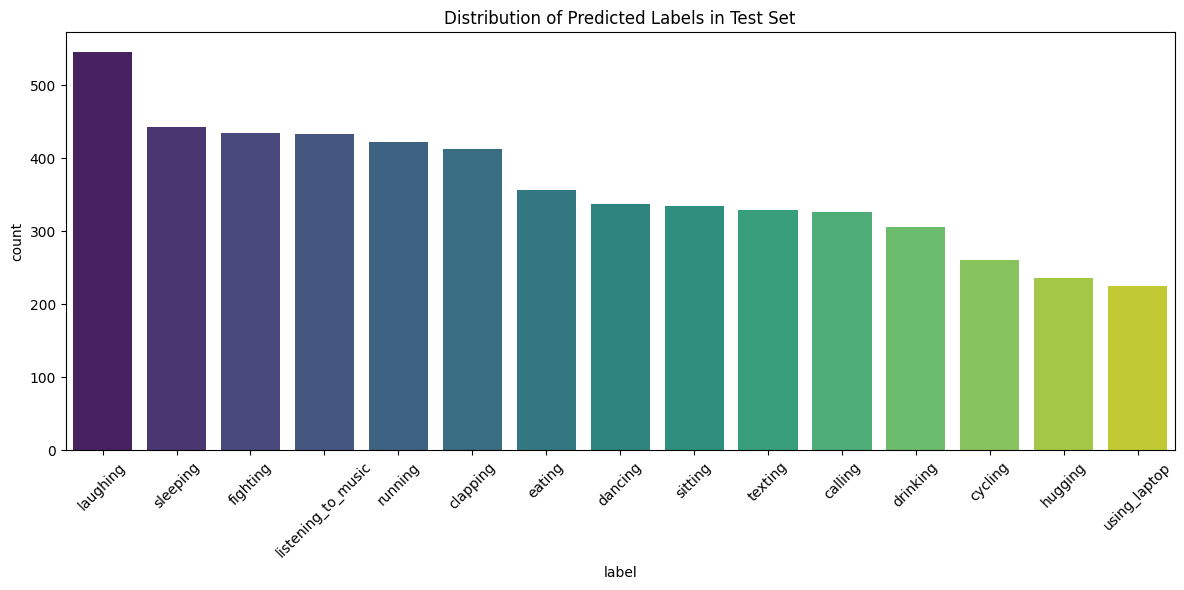

In [91]:
# Count occurrences per predicted label in test images
pred_counts_df = test_df['cnn_pred_label'].value_counts().reset_index()
pred_counts_df.columns = ['label', 'count']

# Display summary
print(pred_counts_df)

# Optional: Barplot to visualise label distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.barplot(x='label', y='count', data=pred_counts_df, palette='viridis')
plt.title('Distribution of Predicted Labels in Test Set')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

                    precision    recall  f1-score   support

           calling       0.16      0.15      0.16       350
          clapping       0.22      0.29      0.25       310
           cycling       0.58      0.43      0.49       355
           dancing       0.37      0.35      0.36       355
          drinking       0.20      0.19      0.19       333
            eating       0.46      0.50      0.48       331
          fighting       0.39      0.46      0.42       366
           hugging       0.19      0.12      0.15       366
          laughing       0.28      0.39      0.33       384
listening_to_music       0.18      0.20      0.19       382
           running       0.41      0.49      0.45       354
           sitting       0.24      0.20      0.22       395
          sleeping       0.35      0.44      0.39       346
           texting       0.20      0.15      0.17       445
      using_laptop       0.34      0.23      0.28       328

          accuracy                    

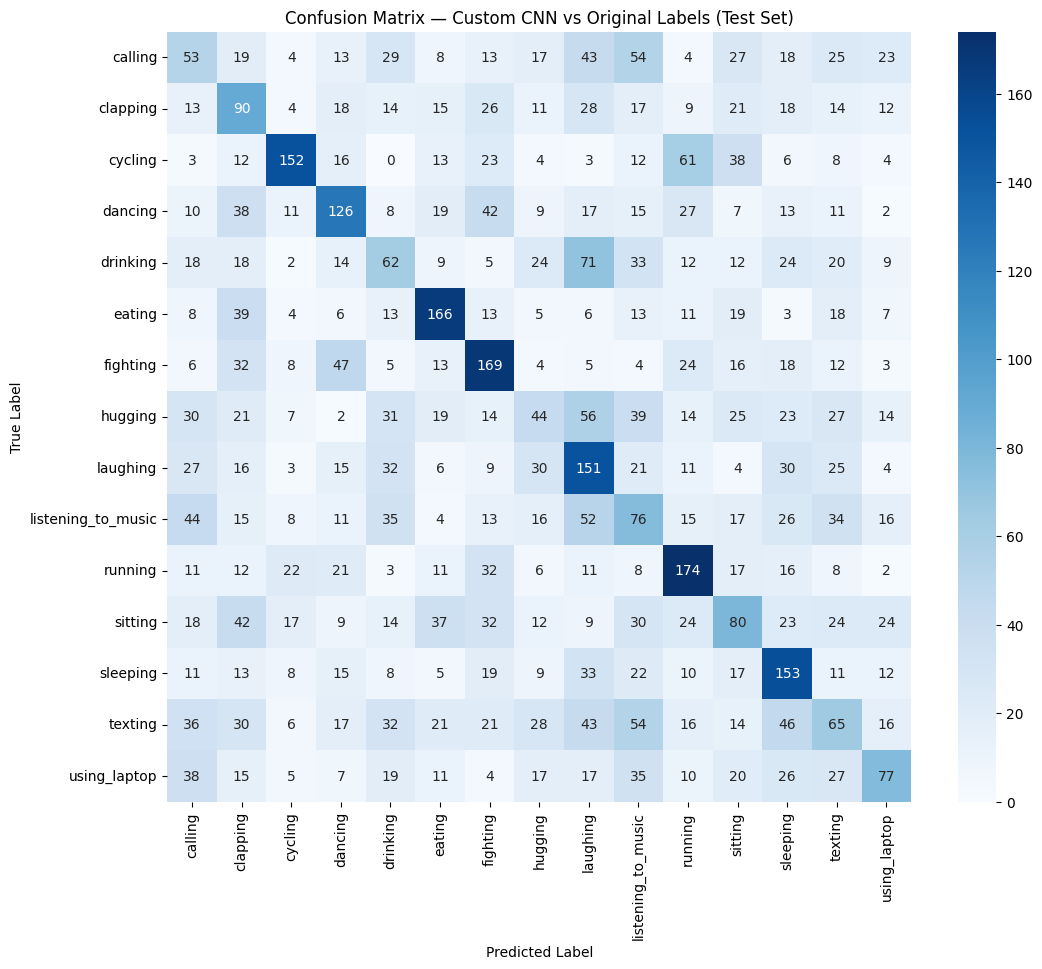

Overall Accuracy on Test Set: 0.3033


In [92]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Merge predictions to metadata_df test portion
test_eval_df = metadata_df[metadata_df['source'] == 'test'].copy()
test_eval_df['cnn_pred_label'] = test_df['cnn_pred_label'].values

# If ground truth exists in 'label' column:
print(classification_report(test_eval_df['label'], test_eval_df['cnn_pred_label'], zero_division=0))

# Confusion matrix
import seaborn as sns
cm = confusion_matrix(test_eval_df['label'], test_eval_df['cnn_pred_label'], labels=known_labels)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=known_labels, yticklabels=known_labels, cmap='Blues')
plt.title("Confusion Matrix — Custom CNN vs Original Labels (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Overall accuracy
acc = accuracy_score(test_eval_df['label'], test_eval_df['cnn_pred_label'])
print(f"Overall Accuracy on Test Set: {acc:.4f}")

In [93]:
# Save the prediction count summary
pred_counts_df.to_csv('metadata/cnn1_customcnn_prediction_counts.csv', index=False)
pred_counts_blob = bucket.blob('metadata/cnn1_customcnn_prediction_counts.csv')
pred_counts_blob.upload_from_filename('metadata/cnn1_customcnn_prediction_counts.csv')

In [94]:
!cp "/content/drive/MyDrive/Colab Notebooks/P2-05_CNN1-img.ipynb" "/content/P2-05_CNN1-img.ipynb"

!jupyter nbconvert --to script "/content/P2-05_CNN1-img.ipynb" --output "/content/P2-05_CNN1-img"
!mv /content/P2-05_CNN1-img.txt /content/P2-05_CNN1-img.py

client = storage.Client(project='p2-anomaly')
bucket = client.bucket('p2-anomaly')
notebook_blob = bucket.blob('notebooks/P2-05_CNN1-img.ipynb')
notebook_blob.upload_from_filename('/content/P2-05_CNN1-img.ipynb')
print("Notebook pushed to GCS.")

local_script_path = '/content/P2-05_CNN1-img.py'
gcs_script_path = 'scripts/P2-05_CNN1-img.py'
script_blob = bucket.blob(gcs_script_path)
script_blob.upload_from_filename(local_script_path)
print("Script uploaded to GCS.")

[NbConvertApp] Converting notebook /content/P2-05_CNN1-img.ipynb to script
[NbConvertApp] Writing 14682 bytes to /content/P2-05_CNN1-img.txt
Notebook pushed to GCS.
Script uploaded to GCS.
